[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mitiau/DNABERT-Z/blob/main/ZDNA-prediction.ipynb)

# Install dependecies and define helper functions

In [ ]:
!pip install transformers
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.9 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
import transformers
from transformers import BertTokenizer, BertForTokenClassification
import numpy as np
from Bio import SeqIO
from io import StringIO, BytesIO
from google.colab import drive, files
from tqdm import tqdm
import pickle
import scipy
from scipy import ndimage

In [ ]:
def seq2kmer(seq, k):
    kmer = [seq[x:x+k] for x in range(len(seq)+1-k)]
    return kmer

def split_seq(seq, length = 512, pad = 16):
    res = []
    for st in range(0, len(seq), length - pad):
        end = min(st+512, len(seq))
        res.append(seq[st:end])
    return res

def stitch_np_seq(np_seqs, pad = 16):
    res = np.array([])
    for seq in np_seqs:
        res = res[:-pad]
        res = np.concatenate([res,seq])
    return res

# Select model and parameters

In [ ]:
model = 'HG kouzine' #@param ["HG chipseq", "HG kouzine", "MM chipseq", "MM kouzine"]
model_confidence_threshold = 0.5 #@param {type:"number"}
minimum_sequence_length = 10 #@param {type:"integer"}

In [ ]:
if model == 'HG chipseq':
    model_id = '1VAsp8I904y_J0PUhAQqpSlCn1IqfG0FB'
elif model == 'HG kouzine':
    model_id = '1dAeAt5Gu2cadwDhbc7OnenUgDLHlUvkx'
elif model == 'MM curax':
    model_id = '1W6GEgHNoitlB-xXJbLJ_jDW4BF35W1Sd'
elif model == 'MM kouzine':
    model_id = '1dXpQFmheClKXIEoqcZ7kgCwx6hzVCv3H'


In [ ]:
!gdown $model_id
!gdown 10sF8Ywktd96HqAL0CwvlZZUUGj05CGk5
!gdown 16bT7HDv71aRwyh3gBUbKwign1mtyLD2d
!gdown 1EE9goZ2JRSD8UTx501q71lGCk-CK3kqG
!gdown 1gZZdtAoDnDiLQqjQfGyuwt268Pe5sXW0


!mkdir 6-new-12w-0
!mv pytorch_model.bin 6-new-12w-0/
!mv config.json 6-new-12w-0/
!mv special_tokens_map.json 6-new-12w-0/
!mv tokenizer_config.json 6-new-12w-0/
!mv vocab.txt 6-new-12w-0/

Downloading...
From (original): https://drive.google.com/uc?id=1dAeAt5Gu2cadwDhbc7OnenUgDLHlUvkx
From (redirected): https://drive.google.com/uc?id=1dAeAt5Gu2cadwDhbc7OnenUgDLHlUvkx&confirm=t&uuid=2c95c185-075e-466f-bd34-e05619293c51
To: /content/pytorch_model.bin
100% 354M/354M [00:04<00:00, 75.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=10sF8Ywktd96HqAL0CwvlZZUUGj05CGk5
To: /content/config.json
100% 634/634 [00:00<00:00, 2.15MB/s]
Downloading...
From: https://drive.google.com/uc?id=16bT7HDv71aRwyh3gBUbKwign1mtyLD2d
To: /content/special_tokens_map.json
100% 112/112 [00:00<00:00, 479kB/s]
Downloading...
From: https://drive.google.com/uc?id=1EE9goZ2JRSD8UTx501q71lGCk-CK3kqG
To: /content/tokenizer_config.json
100% 40.0/40.0 [00:00<00:00, 178kB/s]
Downloading...
From: https://drive.google.com/uc?id=1gZZdtAoDnDiLQqjQfGyuwt268Pe5sXW0
To: /content/vocab.txt
100% 28.7k/28.7k [00:00<00:00, 67.8MB/s]


In [ ]:
tokenizer = BertTokenizer.from_pretrained('6-new-12w-0/')
model = BertForTokenClassification.from_pretrained('6-new-12w-0/')
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4101, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Upload fasta files for prediction

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving GCF_003719475.1_ASM371947v1_genomic.fna to GCF_003719475.1_ASM371947v1_genomic.fna
User uploaded file "GCF_003719475.1_ASM371947v1_genomic.fna" with length 21551899 bytes


In [ ]:
# Или
!gdown 1qhSELqHhmF-8NyWYXf5obB58kAaMT0ER

# Predict and save raw outputs

In [ ]:
out = []
for key in uploaded.keys():
    print(key)
    out.append(key)
    result_dict = {}
    for seq_record in SeqIO.parse(StringIO(BytesIO(uploaded[key]).read().decode('UTF-8')), 'fasta'):
        kmer_seq = seq2kmer(str(seq_record.seq).upper(), 6)
        seq_pieces = split_seq(kmer_seq)
        print(seq_record.name)
        out.append(seq_record.name)
        with torch.no_grad():
            preds = []
            for seq_piece in tqdm(seq_pieces):
                input_ids = torch.LongTensor(tokenizer.encode(' '.join(seq_piece), add_special_tokens=False))
                outputs = torch.softmax(model(input_ids.cuda().unsqueeze(0))[-1],axis = -1)[0,:,1]
                preds.append(outputs.cpu().numpy())
        result_dict[seq_record.name] = stitch_np_seq(preds)



        labeled, max_label = scipy.ndimage.label(result_dict[seq_record.name]>model_confidence_threshold)
        print('  start     end')
        out.append('  start     end')
        for label in range(1, max_label+1):
            candidate = np.where(labeled == label)[0]
            candidate_length = candidate.shape[0]
            if candidate_length>minimum_sequence_length:
                print('{:8}'.format(candidate[0]), '{:8}'.format(candidate[-1]))
                out.append('{:8}'.format(candidate[0]) + '{:8}'.format(candidate[-1]))

    with open(key + '.preds.pkl',"wb") as fh:
      pickle.dump(result_dict, fh)
    print()

with open('text_predictions.txt',"w") as fh:
    for item in out:
        fh.write("%s\n" % item)


GCF_003719475.1_ASM371947v1_genomic.fna
NW_021705745.1


100%|██████████| 312/312 [00:20<00:00, 15.43it/s]


  start     end
     349      367
    1185     1212
    1508     1522
    1920     1934
    2385     2404
    2564     2583
    2846     2862
    3412     3429
    4089     4104
    4664     4676
    5991     6002
    6883     6897
    7368     7383
    8348     8363
    9764     9778
    9865     9884
   10012    10030
   10067    10080
   13062    13075
   15353    15370
   15880    15891
   20543    20558
   20597    20614
   23351    23369
   25400    25413
   26560    26575
   28631    28644
   30235    30255
   30569    30584
   31785    31799
   32537    32550
   35634    35648
   35982    35996
   36430    36443
   37491    37508
   41635    41649
   43596    43606
   43809    43826
   44306    44317
   46512    46525
   46933    46948
   49859    49877
   50075    50094
   52289    52303
   53113    53127
   55009    55024
   55191    55210
   56199    56226
   58844    58857
   62278    62302
   65823    65839
   67118    67134
   70874    70893
   70961    70971
   71845    

100%|██████████| 302/302 [00:11<00:00, 25.97it/s]


  start     end
      94      110
     157      176
     234      255
     452      462
    8832     8845
    9968     9983
   11016    11027
   21805    21821
   21956    21974
   23242    23253
   25046    25059
   25759    25776
   26522    26534
   28804    28818
   29566    29597
   29914    29926
   30353    30381
   33054    33071
   33078    33093
   33432    33447
   33983    33995
   36463    36477
   37680    37694
   38032    38046
   39104    39133
   41884    41901
   43666    43683
   48810    48824
   52689    52701
   53891    53908
   54379    54398
   56395    56410
   56730    56746
   57118    57128
   62497    62513
   63019    63030
   64466    64479
   68394    68406
   68764    68776
   70293    70303
   70632    70642
   72361    72396
   72480    72511
   72912    72929
   73377    73389
   74019    74035
   75480    75496
   75944    75965
   80931    80946
   84816    84830
   86278    86291
   87370    87385
   88678    88690
   92479    92498
   93321    

100%|██████████| 283/283 [00:13<00:00, 21.25it/s]


  start     end
    5520     5535
    5596     5610
    9125     9140
    9581     9597
   10126    10144
   10599    10611
   11486    11498
   12437    12449
   12529    12549
   12795    12813
   13090    13105
   13133    13146
   14305    14324
   17251    17270
   18425    18438
   18856    18871
   21722    21736
   22826    22843
   22943    22960
   24812    24843
   24967    24989
   29607    29620
   30645    30656
   31496    31512
   32903    32918
   33193    33209
   34674    34703
   35135    35146
   35367    35385
   36432    36453
   44096    44110
   44234    44247
   44252    44269
   49767    49782
   50208    50220
   53568    53584
   54665    54681
   54926    54944
   55133    55147
   55594    55609
   57814    57835
   58120    58139
   58184    58200
   58251    58264
   59550    59562
   61500    61514
   63088    63102
   64061    64074
   64587    64606
   65084    65098
   65396    65410
   66344    66361
   66861    66875
   66955    66974
   68332    

100%|██████████| 261/261 [00:10<00:00, 25.43it/s]


  start     end
    3532     3550
    4933     4948
    6513     6529
    9401     9416
   10262    10277
   12135    12148
   13636    13654
   15852    15871
   16102    16114
   16744    16775
   16959    16975
   20387    20404
   22585    22598
   23119    23134
   24273    24286
   24767    24779
   29623    29636
   29691    29706
   29898    29914
   30003    30016
   31157    31171
   32208    32222
   33411    33425
   34323    34338
   41106    41119
   41271    41286
   44575    44588
   45154    45168
   45335    45348
   46522    46539
   46624    46637
   49280    49294
   50494    50508
   50805    50819
   50847    50865
   51902    51914
   51999    52010
   52658    52674
   55528    55541
   58837    58852
   59353    59384
   61204    61217
   61463    61479
   62238    62257
   63059    63073
   64224    64237
   65442    65456
   65607    65622
   67207    67220
   67397    67414
   68237    68249
   68343    68354
   75255    75272
   76004    76019
   77667    

100%|██████████| 254/254 [00:10<00:00, 25.06it/s]


  start     end
       9       24
      82      101
     795      813
    2754     2789
    4929     4949
    5373     5391
    5549     5565
    6197     6214
    6297     6310
    6977     6991
    7108     7123
    8232     8245
    8523     8541
    8597     8610
    8803     8821
    8829     8848
   10163    10176
   10821    10836
   12464    12474
   13640    13651
   13823    13839
   14588    14608
   14980    14994
   16522    16537
   16997    17015
   17425    17443
   18152    18166
   19245    19259
   19602    19619
   19809    19835
   20334    20346
   20981    20992
   21590    21602
   21912    21925
   22212    22229
   22555    22570
   23209    23221
   23298    23311
   23674    23698
   23780    23795
   24850    24869
   24914    24927
   26148    26158
   27444    27456
   29253    29263
   30194    30216
   30300    30317
   31743    31756
   33573    33583
   34140    34151
   35289    35304
   36550    36563
   37280    37294
   37836    37855
   38455    

100%|██████████| 241/241 [00:09<00:00, 25.11it/s]


  start     end
      23       39
     158      172
     236      248
    1281     1298
    1734     1750
    2048     2059
    2932     2948
    4136     4150
    4472     4491
    4626     4642
    4721     4735
    5501     5513
    6366     6379
    7538     7550
    7585     7600
    8663     8680
    8744     8777
    9920     9932
   11812    11831
   12397    12413
   12802    12816
   13055    13079
   13301    13323
   13508    13523
   14416    14432
   14690    14704
   15094    15109
   15206    15220
   15632    15649
   16453    16471
   16558    16574
   18249    18272
   21197    21215
   22747    22760
   23010    23031
   23859    23870
   23977    23990
   24203    24219
   25250    25267
   25331    25350
   26474    26491
   29011    29027
   29608    29625
   30749    30764
   32461    32475
   32527    32537
   33498    33520
   35280    35291
   35506    35523
   35913    35923
   36661    36681
   39166    39181
   39526    39545
   39759    39770
   40511    

100%|██████████| 231/231 [00:08<00:00, 26.27it/s]


  start     end
      61       72
     750      766
    1026     1040
    1091     1103
    4129     4148
    5959     5977
    7301     7317
    7637     7647
   10881    10902
   13549    13563
   14906    14926
   15464    15477
   15883    15896
   16573    16589
   17317    17332
   17905    17921
   19176    19188
   21671    21682
   23456    23467
   25112    25126
   27465    27485
   28133    28147
   30092    30104
   34446    34462
   35429    35443
   36082    36097
   37240    37261
   37281    37305
   39141    39161
   42271    42283
   43162    43176
   43271    43283
   43448    43460
   47247    47263
   47972    47987
   48090    48106
   54573    54588
   55906    55921
   57891    57902
   59184    59198
   62385    62398
   63660    63678
   65471    65485
   66844    66859
   69080    69096
   70398    70417
   71076    71091
   72508    72522
   75150    75166
   77141    77162
   79080    79092
   79683    79700
   79774    79787
   80293    80311
   80318    

100%|██████████| 224/224 [00:08<00:00, 24.97it/s]


  start     end
     203      221
     240      262
     710      723
    4381     4400
    4804     4816
    7052     7066
    7264     7280
    7538     7553
    7960     7976
    9720     9736
   10364    10377
   11875    11886
   13107    13122
   14288    14302
   15131    15148
   15916    15933
   17308    17323
   17463    17475
   17618    17647
   18166    18180
   18718    18737
   19300    19326
   20845    20860
   22062    22073
   22917    22931
   25980    25998
   26574    26584
   27902    27927
   30682    30700
   31048    31062
   31152    31165
   32307    32320
   32582    32596
   32826    32839
   33247    33262
   33782    33793
   34327    34342
   36976    36992
   37803    37818
   39287    39309
   39320    39335
   39662    39679
   39811    39830
   40518    40533
   41216    41232
   41850    41863
   44719    44732
   45390    45405
   46403    46413
   46464    46479
   46689    46709
   49245    49260
   50350    50366
   51599    51614
   51696    

100%|██████████| 223/223 [00:08<00:00, 24.80it/s]


  start     end
     330      346
    1066     1082
    1287     1305
    1643     1653
    1697     1710
    2501     2519
    3111     3121
    3951     3964
    4204     4218
    4410     4422
    5165     5176
    5235     5247
    5477     5490
    5961     5977
    6023     6035
    6158     6177
    6572     6590
    6843     6857
    8059     8072
    9600     9612
    9624     9637
    9671     9686
    9883     9896
   10208    10236
   10294    10311
   10335    10366
   10678    10693
   10837    10847
   11023    11043
   11319    11335
   12063    12084
   13316    13329
   13727    13743
   15316    15329
   15927    15940
   16609    16624
   17008    17022
   17444    17461
   18490    18503
   18789    18803
   19042    19053
   19695    19713
   20109    20127
   21215    21234
   22738    22764
   22875    22887
   23071    23083
   24108    24120
   25405    25418
   26079    26094
   26478    26490
   27515    27536
   32654    32665
   35420    35434
   35745    

100%|██████████| 216/216 [00:08<00:00, 26.09it/s]


  start     end
     565      589
    1215     1233
    1308     1325
    3010     3028
    4033     4052
    4780     4799
    5021     5031
    5185     5208
    6045     6063
    6388     6406
    7344     7360
    8776     8796
   10069    10082
   13568    13583
   13868    13878
   14499    14515
   17758    17776
   17934    17945
   20533    20547
   20560    20576
   21256    21270
   23317    23330
   24076    24092
   24724    24741
   24964    24977
   25745    25758
   28710    28724
   28890    28903
   29464    29478
   30119    30136
   30674    30685
   32154    32167
   32193    32209
   32635    32650
   33047    33064
   34707    34719
   35270    35283
   35304    35322
   36174    36188
   37138    37153
   38097    38111
   38192    38205
   38445    38456
   38947    38962
   39577    39590
   41138    41153
   43724    43738
   45826    45846
   47224    47238
   48740    48753
   51135    51150
   54489    54503
   55960    55972
   56553    56570
   56640    

100%|██████████| 212/212 [00:08<00:00, 24.60it/s]


  start     end
     413      424
    2020     2033
    6316     6329
    7037     7047
    7886     7900
    9015     9027
    9444     9457
   14360    14372
   16661    16674
   19491    19506
   20957    20971
   21681    21695
   23699    23719
   23846    23866
   25282    25293
   26164    26177
   27721    27733
   30420    30436
   31207    31219
   31964    31983
   33175    33188
   34763    34783
   40398    40411
   42188    42203
   44489    44504
   45205    45221
   46016    46027
   46818    46836
   49983    49994
   50359    50373
   50949    50962
   51388    51402
   52265    52279
   53605    53616
   55086    55100
   56150    56170
   57867    57879
   59849    59867
   60524    60537
   60930    60962
   61361    61376
   61848    61864
   65569    65587
   65867    65886
   68004    68017
   69130    69145
   69394    69410
   71843    71856
   73106    73118
   74539    74553
   74976    74995
   75020    75036
   75839    75859
   76236    76252
   77636    

100%|██████████| 206/206 [00:08<00:00, 24.62it/s]


  start     end
    1105     1116
    1440     1462
    6341     6358
    7041     7051
    7920     7935
   13448    13465
   14265    14280
   14388    14400
   15639    15654
   15992    16005
   17838    17848
   17894    17908
   19333    19343
   20549    20566
   24273    24288
   26563    26583
   26725    26738
   36191    36207
   46082    46095
   46532    46548
   47247    47262
   49422    49437
   51113    51127
   52530    52545
   53400    53414
   54782    54801
   55477    55490
   57333    57347
   59119    59135
   60374    60390
   60519    60530
   61509    61523
   63573    63583
   66089    66104
   67914    67928
   69796    69812
   70105    70119
   72478    72496
   73833    73847
   75446    75458
   77127    77141
   78267    78283
   79342    79357
   80890    80905
   81522    81537
   82111    82122
   83707    83722
   84213    84229
   88068    88083
   89805    89820
   90948    90961
   91502    91519
   92909    92923
   97471    97489
   98635    

100%|██████████| 204/204 [00:07<00:00, 25.74it/s]


  start     end
     113      126
     575      592
    2394     2415
    2499     2517
    2595     2611
    2935     2951
    3727     3741
    4655     4670
    4825     4861
    5046     5064
    5339     5353
    6890     6904
    8491     8505
    8814     8837
    9301     9319
   10435    10451
   10618    10631
   11007    11023
   11077    11090
   11103    11127
   11185    11200
   11245    11261
   12033    12055
   12487    12505
   12972    12985
   14100    14114
   17159    17173
   18392    18407
   18564    18577
   18832    18844
   19087    19104
   19433    19446
   19963    19975
   20034    20047
   20164    20182
   20531    20547
   21070    21086
   21287    21305
   21418    21435
   21928    21951
   22432    22451
   22827    22852
   23393    23404
   24247    24260
   25062    25076
   26199    26214
   26752    26765
   27058    27083
   27573    27584
   27810    27824
   28340    28356
   29050    29063
   30997    31011
   33070    33085
   33294    

100%|██████████| 201/201 [00:08<00:00, 22.38it/s]


  start     end
      57       83
    1085     1100
    1896     1915
    2286     2300
    2338     2362
    2715     2729
    2911     2924
    2933     2948
    3067     3083
    3087     3107
    4024     4050
    6296     6312
    7192     7206
    7231     7246
    8050     8063
    9346     9363
   13475    13487
   14196    14212
   14255    14266
   15677    15689
   15901    15912
   16723    16734
   16915    16930
   18266    18278
   19296    19313
   19486    19500
   20806    20819
   20868    20881
   23039    23052
   23781    23794
   24579    24596
   24818    24833
   26207    26221
   27704    27715
   31822    31836
   36603    36623
   37073    37086
   40767    40781
   41668    41684
   41756    41767
   42538    42557
   43152    43162
   46176    46190
   46197    46213
   46895    46907
   47494    47520
   47650    47662
   49609    49626
   50423    50434
   50473    50486
   52708    52723
   57957    57968
   58340    58355
   58611    58631
   59083    

100%|██████████| 199/199 [00:08<00:00, 24.31it/s]


  start     end
     167      181
    1848     1860
    1998     2015
    2326     2341
    2384     2399
    2873     2891
    4104     4119
    4371     4385
    5106     5125
    5547     5557
    6523     6537
    8277     8291
    9934     9948
   11636    11649
   12343    12378
   13620    13634
   13817    13827
   14353    14368
   18202    18220
   18923    18940
   20295    20317
   21126    21143
   22272    22291
   23171    23188
   23528    23546
   25425    25441
   26661    26676
   27075    27087
   27627    27639
   27832    27849
   28633    28646
   28950    28963
   28987    28998
   29400    29415
   29602    29616
   30784    30801
   31062    31084
   31288    31304
   31378    31389
   32626    32640
   32996    33013
   35647    35661
   36838    36860
   37258    37274
   37673    37690
   39899    39915
   40645    40661
   41255    41275
   42184    42194
   44709    44721
   45570    45587
   46065    46082
   46367    46381
   46863    46875
   47586    

100%|██████████| 196/196 [00:07<00:00, 25.60it/s]


  start     end
     137      158
    1508     1526
    2292     2309
    2519     2533
    2659     2672
    3361     3374
    3758     3772
    4237     4252
    4637     4654
    6125     6138
    6524     6536
    8092     8106
    8476     8489
    9901     9919
   10562    10577
   11921    11936
   12153    12168
   12418    12429
   12829    12844
   12989    13001
   14893    14910
   15143    15160
   16740    16757
   16946    16960
   17608    17635
   17783    17796
   20310    20325
   20724    20736
   21147    21166
   23873    23886
   26091    26103
   27552    27564
   27754    27771
   28513    28527
   31043    31056
   31203    31214
   33573    33595
   34744    34765
   36328    36343
   36750    36763
   39407    39420
   39581    39596
   39862    39874
   40073    40091
   40981    40998
   43062    43083
   45653    45671
   48349    48364
   52045    52059
   52672    52691
   54196    54213
   56309    56329
   57265    57277
   59410    59423
   60800    

100%|██████████| 191/191 [00:07<00:00, 24.42it/s]


  start     end
     585      598
     806      816
    2927     2942
    5292     5308
    5395     5410
   11006    11025
   11333    11349
   14910    14927
   14997    15011
   15780    15795
   18350    18367
   19575    19587
   20094    20109
   24739    24754
   25150    25162
   28834    28847
   36073    36087
   36245    36262
   38334    38349
   38578    38590
   42789    42807
   53721    53733
   54145    54157
   54272    54288
   57895    57913
   59554    59581
   62598    62612
   63091    63107
   64298    64311
   64515    64525
   64795    64814
   65236    65264
   65362    65386
   65915    65926
   67477    67498
   67650    67662
   68105    68116
   69632    69648
   70270    70289
   70856    70873
   72972    72982
   74658    74677
   74845    74859
   76296    76309
   76908    76920
   76997    77007
   80739    80752
   81000    81014
   81478    81492
   81522    81533
   81656    81670
   84128    84141
   85900    85917
   86961    86973
   88705    

100%|██████████| 190/190 [00:07<00:00, 25.70it/s]


  start     end
     626      640
     909      922
    1400     1413
    3260     3276
    5104     5115
    6664     6681
    8850     8862
    8940     8955
    9570     9600
    9898     9913
    9928     9943
   12302    12315
   13199    13219
   13504    13522
   13667    13685
   13994    14009
   16327    16337
   17748    17763
   21896    21910
   23723    23737
   27921    27938
   29541    29555
   31909    31925
   32270    32295
   32967    32983
   33200    33212
   36476    36489
   36727    36739
   37105    37122
   38764    38780
   39080    39100
   39713    39735
   40437    40450
   40472    40497
   42377    42397
   42769    42788
   43610    43625
   46243    46256
   46595    46609
   47864    47878
   48171    48188
   49375    49388
   49426    49441
   50707    50728
   50850    50863
   52042    52053
   53072    53083
   54081    54094
   55953    55965
   57785    57798
   59430    59441
   59540    59554
   59942    59964
   60838    60855
   77848    

100%|██████████| 190/190 [00:07<00:00, 24.67it/s]


  start     end
     632      658
     955      968
    4990     5004
    6140     6155
    7513     7525
    7633     7650
   10897    10911
   11049    11061
   11741    11771
   12246    12260
   12461    12481
   12626    12641
   14068    14078
   16553    16565
   16965    16981
   18096    18110
   19562    19579
   26343    26355
   27584    27597
   29006    29023
   29547    29561
   29832    29845
   32630    32642
   35967    35987
   39899    39917
   39992    40007
   40894    40910
   41332    41347
   42132    42149
   42971    42986
   44760    44774
   44977    44991
   45172    45194
   46345    46367
   48027    48042
   49433    49463
   49654    49672
   50598    50612
   56876    56892
   57378    57392
   58325    58339
   61017    61031
   61088    61101
   61635    61651
   66522    66538
   67013    67029
   67197    67212
   67935    67949
   67997    68015
   68500    68511
   68944    68957
   70309    70321
   71148    71162
   72457    72476
   73501    

100%|██████████| 188/188 [00:07<00:00, 24.52it/s]


  start     end
    3830     3846
    4533     4545
    5369     5382
    5445     5455
    6172     6190
    6939     6962
    6972     6989
    7031     7046
    7391     7402
    7500     7516
    8708     8726
   10798    10811
   11428    11442
   13742    13755
   14279    14296
   14916    14928
   17150    17163
   20605    20617
   21016    21033
   21894    21912
   22753    22771
   23595    23607
   23867    23881
   24189    24203
   24450    24464
   25273    25283
   25961    25972
   27004    27020
   28208    28225
   30563    30579
   36583    36597
   36837    36864
   36889    36919
   38025    38036
   41040    41050
   43256    43271
   45203    45222
   48424    48442
   49246    49258
   49578    49588
   50231    50246
   50924    50938
   50985    50998
   51628    51638
   52301    52313
   53238    53249
   53789    53803
   57068    57084
   59167    59180
   59257    59274
   61284    61299
   67039    67053
   75689    75714
   75981    75994
   76072    

100%|██████████| 185/185 [00:07<00:00, 26.08it/s]


  start     end
     322      337
    1101     1117
    2740     2751
    9342     9352
   12239    12252
   13020    13030
   13699    13713
   14960    14971
   17045    17055
   18223    18238
   19973    19984
   20004    20018
   21771    21783
   25170    25188
   26213    26228
   28356    28371
   29210    29223
   29473    29490
   29603    29618
   30737    30751
   31525    31550
   31966    31978
   34419    34434
   35251    35264
   38454    38475
   40084    40099
   40874    40899
   42257    42274
   46863    46878
   46948    46963
   47413    47427
   47851    47868
   48109    48123
   50618    50628
   51525    51539
   51999    52016
   52416    52431
   53488    53502
   54250    54266
   54850    54866
   55863    55882
   56400    56417
   56649    56664
   58199    58212
   58673    58696
   59491    59506
   59885    59897
   61755    61774
   62759    62779
   63576    63597
   64107    64124
   66815    66829
   67291    67304
   69942    69954
   70489    

100%|██████████| 186/186 [00:07<00:00, 24.57it/s]


  start     end
    4414     4429
    5319     5342
    5999     6013
    9480     9491
   11318    11340
   11640    11657
   15047    15067
   17995    18013
   19915    19929
   21975    21996
   22281    22293
   28289    28301
   28976    28999
   30455    30470
   31586    31598
   31878    31894
   37092    37109
   38756    38767
   40156    40175
   40999    41016
   42945    42959
   43096    43111
   45470    45485
   47916    47933
   48472    48485
   48939    48951
   50251    50264
   51097    51111
   53638    53654
   54220    54236
   54491    54507
   55180    55196
   55383    55402
   57454    57469
   62586    62597
   63413    63429
   64870    64882
   65048    65062
   66437    66449
   67562    67575
   68124    68138
   70153    70168
   70455    70467
   71906    71919
   73225    73244
   75990    76002
   77364    77375
   82456    82469
   87074    87090
NW_021705767.1


100%|██████████| 184/184 [00:07<00:00, 23.42it/s]


  start     end
       3       19
     445      462
     573      585
     898      911
    1064     1078
    1157     1178
    1228     1249
    1380     1396
    1449     1462
    1827     1842
    1917     1933
    2139     2155
    2246     2268
    2499     2516
    2607     2622
    2888     2904
    2917     2932
    2989     3002
    3309     3329
    3473     3496
    3605     3621
    3848     3871
    3942     3965
    4074     4090
    4317     4339
    4688     4702
    4902     4919
    5383     5401
    5739     5757
    6103     6117
    6666     6681
    6743     6760
    7488     7506
    7689     7704
    8226     8237
    8577     8593
    9350     9369
    9757     9775
   10624    10634
   11031    11046
   11565    11581
   11630    11645
   12423    12446
   12496    12518
   12926    12937
   14735    14747
   14794    14811
   15169    15182
   15199    15213
   15235    15254
   16930    16946
   17174    17195
   17541    17555
   17803    17820
   19537    

100%|██████████| 183/183 [00:07<00:00, 24.64it/s]


  start     end
      21       34
     141      153
     848      867
    1753     1782
    2055     2073
    2281     2295
    3502     3517
    3895     3910
    3990     4012
    4243     4256
    4917     4930
    5391     5408
    6144     6159
    6218     6233
    6744     6762
    7114     7128
    8152     8175
    8473     8485
    9456     9469
    9919     9934
   10400    10415
   11822    11836
   11929    11943
   12731    12741
   13985    14003
   14493    14508
   15021    15036
   15514    15530
   16542    16558
   16980    16992
   17448    17460
   18371    18383
   18714    18729
   18988    19002
   19029    19047
   19626    19643
   19662    19674
   20353    20369
   21248    21262
   21556    21570
   23046    23062
   23295    23309
   24318    24341
   24379    24394
   25109    25128
   25134    25150
   25429    25456
   25539    25558
   26047    26071
   26294    26320
   26624    26639
   28509    28524
   28676    28687
   29424    29439
   31690    

100%|██████████| 182/182 [00:07<00:00, 25.13it/s]


  start     end
     161      177
    8725     8739
    8917     8927
    8959     8972
    9073     9089
   14029    14043
   14402    14415
   15597    15613
   18204    18222
   18853    18883
   18889    18901
   19914    19934
   19940    19952
   20185    20200
   21090    21102
   22091    22103
   24084    24100
   25448    25472
   25491    25517
   25546    25585
   25656    25667
   26969    26984
   27521    27533
   27582    27593
   27700    27719
   28623    28634
   28663    28678
   29212    29226
   29424    29439
   30005    30021
   30797    30809
   31320    31332
   32093    32106
   32336    32349
   36446    36469
   37099    37116
   37434    37499
   37606    37618
   38817    38836
   40525    40539
   41734    41750
   42605    42626
   42630    42649
   44350    44363
   44791    44804
   44891    44903
   44955    44967
   45562    45574
   45859    45869
   46003    46020
   46396    46411
   46626    46641
   46717    46730
   47104    47119
   47171    

100%|██████████| 180/180 [00:07<00:00, 25.25it/s]


  start     end
      17       34
      74       87
     438      453
     455      472
    1064     1077
    2003     2014
    2283     2307
    2424     2448
    3427     3441
    4996     5009
    5292     5320
    5564     5580
    5653     5674
    5750     5766
    6360     6381
    6633     6649
    7361     7379
    7605     7619
    7626     7641
    7961     7980
    8432     8446
    9082     9095
    9245     9262
    9599     9618
   10691    10705
   10988    11003
   11277    11300
   12366    12382
   12814    12833
   13168    13186
   13301    13317
   13344    13357
   13674    13688
   14075    14088
   14779    14793
   15308    15319
   15429    15441
   15623    15635
   17278    17291
   17583    17596
   17729    17747
   18005    18020
   18166    18182
   18265    18277
   18841    18856
   19885    19901
   20300    20322
   21637    21652
   22297    22316
   22394    22405
   22514    22526
   22732    22752
   23112    23129
   23135    23151
   23529    

100%|██████████| 181/181 [00:07<00:00, 24.64it/s]


  start     end
     782      795
     867      882
    1804     1820
    2180     2193
    3022     3035
    4538     4558
    8407     8424
    9129     9141
   10025    10047
   10304    10326
   10497    10507
   10884    10897
   11614    11628
   11891    11903
   13313    13323
   13470    13491
   14403    14418
   14614    14628
   14877    14901
   15982    16001
   17284    17303
   17640    17650
   18998    19015
   21330    21342
   21775    21803
   22000    22020
   23631    23645
   23884    23905
   24701    24716
   25053    25074
   25275    25287
   26885    26899
   26978    26989
   27445    27459
   27542    27559
   27610    27623
   29215    29234
   29720    29733
   30586    30599
   31453    31471
   32161    32175
   32348    32363
   33156    33174
   34035    34048
   36639    36652
   37155    37180
   38224    38238
   38287    38303
   38846    38861
   39553    39567
   40571    40585
   41289    41305
   41487    41501
   41834    41852
   42176    

100%|██████████| 180/180 [00:06<00:00, 25.90it/s]


  start     end
      22       43
     700      713
    2366     2383
    4251     4263
    4457     4482
    4820     4834
    5553     5566
    6114     6127
    7310     7321
    8271     8289
    8761     8775
    9184     9200
    9480     9492
   10056    10069
   13103    13120
   15396    15409
   18208    18230
   18359    18376
   19519    19533
   20343    20356
   20407    20438
   21959    21975
   22408    22422
   22553    22568
   24494    24508
   25670    25684
   27027    27040
   27331    27344
   27363    27378
   27600    27615
   29493    29504
   29795    29824
   30945    30964
   32242    32256
   32335    32349
   32783    32805
   33271    33287
   34281    34297
   40268    40284
   40327    40342
   40919    40931
   41088    41107
   41997    42017
   43162    43173
   46897    46911
   47427    47442
   47600    47615
   51670    51682
   54612    54626
   55756    55770
   56443    56461
   60078    60096
   61166    61182
   61486    61501
   61913    

100%|██████████| 178/178 [00:07<00:00, 24.48it/s]


  start     end
    1133     1152
    2279     2295
    4203     4216
    4258     4275
    4864     4876
    5022     5038
    6531     6549
    6558     6591
    7230     7244
    7816     7830
    9065     9084
    9183     9195
   14404    14420
   15362    15375
   16958    16968
   17167    17177
   17749    17762
   17938    17950
   18365    18381
   19866    19880
   20963    20985
   22414    22428
   24085    24100
   25118    25129
   26137    26152
   26356    26375
   26416    26433
   26718    26734
   27553    27567
   27709    27720
   28455    28472
   28632    28644
   29209    29225
   29994    30010
   30453    30468
   31521    31533
   32050    32060
   32252    32264
   32696    32706
   33461    33475
   34002    34016
   34318    34338
   35939    35956
   37183    37195
   37450    37460
   38193    38203
   38630    38641
   41517    41532
   41918    41935
   44476    44492
   44689    44706
   44900    44915
   47178    47191
   47484    47494
   52950    

100%|██████████| 178/178 [00:06<00:00, 25.76it/s]


  start     end
     499      522
    2053     2064
    3112     3128
    3787     3810
    4320     4342
    4397     4411
    4490     4517
    4990     5005
    5881     5898
    8329     8345
   10557    10573
   10646    10664
   10822    10844
   10899    10911
   11824    11837
   13130    13142
   13502    13516
   13887    13904
   14095    14107
   14197    14215
   14296    14309
   14445    14457
   14624    14637
   14660    14677
   15947    15960
   16264    16277
   16732    16752
   17314    17338
   18838    18861
   19762    19783
   20428    20443
   20844    20856
   21244    21271
   21317    21327
   21780    21798
   22209    22237
   23253    23266
   23328    23343
   23931    23945
   24661    24682
   24687    24706
   24968    24985
   25575    25587
   26383    26400
   27871    27884
   28092    28116
   28297    28307
   29978    29993
   30187    30206
   30834    30847
   31939    31983
   33011    33027
   33192    33215
   33378    33391
   33517    

100%|██████████| 173/173 [00:07<00:00, 24.07it/s]


  start     end
    1338     1349
    1881     1897
    2767     2781
    3270     3282
    3405     3421
    5237     5248
    5290     5301
    5545     5565
    6788     6801
    7031     7047
    7386     7400
    7750     7765
    8202     8220
    8394     8405
    9276     9291
    9951     9965
   10572    10583
   11222    11241
   11874    11887
   12020    12039
   12394    12412
   13408    13423
   14134    14148
   14227    14241
   14511    14525
   15205    15219
   15756    15770
   15988    16002
   16556    16574
   16975    16989
   17225    17236
   17786    17799
   18100    18114
   18120    18137
   18432    18442
   21284    21304
   21708    21728
   21972    21983
   22967    22983
   23258    23280
   23288    23306
   23507    23522
   25607    25625
   26477    26496
   26698    26716
   26808    26822
   27159    27174
   27794    27804
   27852    27868
   28250    28270
   28520    28534
   28917    28932
   30202    30214
   30306    30321
   30529    

100%|██████████| 173/173 [00:06<00:00, 25.49it/s]


  start     end
     225      247
    1296     1310
    1417     1430
    1811     1824
    3404     3418
    4874     4895
    4939     4955
    4979     4994
    5506     5518
    5822     5839
    6035     6051
    6168     6181
    6525     6559
    6580     6600
    6609     6630
    7241     7259
    7583     7597
    8568     8582
    9160     9174
    9565     9580
   10113    10126
   10966    10979
   11158    11170
   11457    11472
   11826    11838
   12560    12570
   13531    13543
   14528    14540
   14682    14698
   15162    15178
   15521    15534
   15571    15586
   17131    17145
   18661    18680
   19025    19041
   19236    19250
   21463    21474
   21647    21665
   21722    21738
   21829    21844
   21935    21948
   22213    22236
   22720    22738
   22983    22999
   23098    23111
   23370    23385
   23549    23570
   24033    24045
   24730    24744
   24806    24822
   25870    25888
   32163    32177
   37712    37725
   39106    39120
   40164    

100%|██████████| 171/171 [00:06<00:00, 24.44it/s]


  start     end
       0       12
     127      172
     504      516
     536      548
     745      760
    1219     1235
    2283     2296
    2658     2675
    3208     3223
    3238     3250
    3625     3640
    3655     3670
    4597     4615
    6189     6202
   10854    10867
   11783    11795
   11830    11844
   12169    12185
   13449    13461
   14462    14480
   15192    15206
   15815    15825
   15937    15951
   16731    16748
   17413    17431
   18332    18346
   18441    18454
   19996    20012
   20213    20229
   20529    20546
   21947    21969
   23685    23706
   23846    23860
   24127    24143
   24175    24189
   24687    24700
   25175    25190
   25420    25441
   25820    25841
   25887    25900
   26894    26909
   28368    28380
   28504    28518
   28890    28907
   29625    29642
   29747    29759
   30549    30566
   31054    31068
   31075    31088
   31663    31674
   32300    32310
   32314    32332
   32894    32909
   34692    34706
   35428    

100%|██████████| 171/171 [00:06<00:00, 25.02it/s]


  start     end
     591      606
    1111     1127
    1634     1647
    1923     1945
    2061     2077
    2908     2927
    4189     4203
    5095     5110
    5734     5747
    5749     5759
    5947     6008
    6576     6590
    7051     7065
    7455     7467
    8038     8049
    8102     8112
    8209     8224
    8246     8263
    8420     8431
    8439     8454
    8614     8628
    9238     9253
    9630     9656
   15359    15375
   18551    18561
   20280    20295
   20435    20453
   21585    21600
   22650    22663
   22948    22960
   23050    23066
   23932    23947
   24703    24718
   24940    24957
   25092    25107
   25478    25490
   25837    25848
   26247    26265
   26469    26483
   26710    26727
   27141    27164
   28447    28459
   28681    28698
   28886    28903
   29011    29029
   29093    29108
   29112    29132
   29536    29564
   30166    30180
   30609    30624
   30687    30712
   30842    30853
   30912    30929
   31235    31247
   31492    

100%|██████████| 172/172 [00:06<00:00, 24.70it/s]


  start     end
    1024     1037
    2443     2457
    2755     2769
    2888     2902
    6865     6880
    7043     7056
    7804     7819
    9407     9417
    9430     9444
   11039    11056
   11065    11080
   11275    11286
   12010    12027
   12598    12609
   18718    18732
   18741    18763
   22180    22194
   23570    23585
   23719    23729
   23766    23778
   26409    26422
   29062    29080
   29156    29170
   30189    30207
   31157    31173
   31411    31425
   32395    32411
   32863    32875
   34496    34510
   36795    36813
   37935    37956
   42535    42553
   46904    46916
   47821    47840
   47980    47993
   48911    48925
   49754    49771
   53408    53423
   55395    55409
   56335    56359
   57114    57128
   60240    60260
   64006    64020
   64873    64892
   65623    65639
   67479    67496
   70032    70047
   70999    71012
   75750    75772
   76364    76376
   76644    76658
   76981    76994
   78694    78714
   79569    79580
   80302    

100%|██████████| 169/169 [00:06<00:00, 24.37it/s]


  start     end
     287      301
     850      868
    1175     1196
    1317     1331
    3166     3180
    3332     3345
    3780     3794
    4934     4948
    5659     5674
    5867     5877
    6460     6474
    6666     6707
    6780     6817
    7952     7965
    9520     9536
   11208    11220
   11419    11436
   12301    12315
   12837    12848
   12856    12876
   13084    13103
   13217    13233
   14235    14253
   14570    14588
   15165    15181
   16971    16986
   17341    17355
   17560    17591
   18552    18570
   18676    18688
   18728    18744
   19374    19392
   19727    19743
   20047    20065
   20456    20474
   20486    20499
   20681    20703
   20982    21002
   21244    21262
   21794    21807
   22096    22108
   23055    23072
   23131    23148
   23589    23605
   25027    25041
   26037    26058
   26928    26946
   27540    27556
   29135    29151
   29527    29542
   31687    31705
   33553    33565
   33918    33933
   35106    35123
   35162    

100%|██████████| 166/166 [00:06<00:00, 25.66it/s]


  start     end
     483      494
    2597     2612
    2881     2903
    3479     3495
    3990     4004
    4670     4687
    7815     7829
    7962     7975
    8014     8026
    8198     8212
    9027     9045
   10940    10952
   15818    15833
   18785    18804
   20700    20723
   20947    20964
   21500    21515
   21713    21728
   22204    22218
   24993    25011
   25227    25253
   25669    25689
   25878    25898
   27218    27234
   29038    29055
   30351    30363
   32507    32517
   35585    35609
   40925    40946
   41023    41038
   41065    41084
   41792    41807
   42877    42889
   43182    43199
   43539    43553
   43947    43962
   46440    46454
   46517    46531
   46579    46596
   49071    49085
   49514    49538
   49877    49893
   50296    50306
   52038    52050
   52469    52482
   53303    53325
   53399    53417
   53535    53550
   54245    54260
   55335    55351
   55649    55662
   56519    56531
   56576    56593
   61121    61137
   61186    

100%|██████████| 165/165 [00:06<00:00, 24.06it/s]


  start     end
     299      322
     360      400
    2466     2479
    2597     2613
    3031     3049
    5369     5383
    6779     6794
    8722     8734
    8938     8952
   10207    10219
   10433    10443
   11373    11390
   12715    12734
   13195    13209
   13832    13845
   14150    14167
   14229    14243
   16104    16119
   16895    16910
   17341    17356
   17430    17442
   19393    19407
   20747    20759
   21328    21344
   21858    21870
   22271    22285
   22586    22603
   23417    23434
   23912    23926
   24256    24273
   24607    24628
   26148    26163
   27166    27182
   27747    27759
   27938    27954
   28127    28145
   28753    28766
   29069    29083
   29406    29425
   29820    29836
   30048    30062
   30651    30665
   30817    30830
   31045    31057
   31193    31206
   31620    31635
   32656    32668
   32895    32911
   33805    33827
   34349    34363
   34419    34436
   34983    34997
   35418    35436
   36097    36114
   36280    

100%|██████████| 167/167 [00:06<00:00, 25.30it/s]


  start     end
     557      569
    1326     1339
    1756     1766
    2573     2589
    4562     4578
    7075     7115
    7237     7254
    8409     8421
    9334     9350
   10380    10395
   10422    10439
   11538    11554
   12231    12244
   12376    12391
   13105    13123
   13936    13955
   14121    14148
   14564    14584
   14894    14911
   15413    15429
   15849    15860
   15995    16008
   16612    16631
   16687    16704
   16801    16821
   16941    16957
   17247    17258
   17519    17533
   17754    17779
   17839    17854
   18070    18087
   18138    18155
   18512    18542
   18572    18587
   20043    20059
   20117    20131
   21025    21039
   21678    21700
   22401    22414
   22724    22745
   22987    23008
   23261    23276
   23428    23441
   23524    23551
   23649    23663
   23808    23823
   23942    23954
   24481    24497
   25206    25216
   25251    25266
   26037    26048
   26245    26264
   27601    27615
   28668    28685
   28803    

100%|██████████| 162/162 [00:06<00:00, 23.81it/s]


  start     end
     116      132
    1233     1248
    1283     1300
    1406     1422
    1555     1571
    1982     2002
    2405     2419
    2764     2776
    4112     4123
    6480     6491
    6584     6601
    7192     7207
    7960     7978
   11805    11817
   13065    13078
   13653    13670
   15114    15131
   15356    15372
   15926    15937
   16378    16396
   16902    16917
   17317    17332
   19871    19888
   20095    20109
   20870    20892
   23497    23509
   30646    30660
   33248    33268
   34435    34448
   35902    35921
   36519    36536
   37016    37029
   37286    37304
   37655    37673
   37860    37878
   38075    38094
   38108    38124
   38493    38509
   39167    39180
   39792    39808
   40658    40670
   41732    41747
   44169    44189
   44516    44530
   44820    44834
   48143    48159
   48633    48651
   50652    50669
   50996    51007
   51694    51706
   52893    52905
   54317    54337
   55234    55260
   55818    55830
   55892    

100%|██████████| 161/161 [00:06<00:00, 25.23it/s]


  start     end
     100      111
    1300     1314
    2313     2325
    3078     3094
    3650     3667
    3749     3765
    4989     5005
    5973     5993
    6942     6959
    7183     7199
    7664     7681
    7847     7864
    8210     8224
    8442     8458
    8865     8905
    9561     9577
    9789     9808
   10055    10078
   10540    10557
   11090    11109
   11607    11621
   11943    11959
   12203    12221
   12534    12550
   12600    12613
   15218    15230
   16350    16360
   17185    17204
   17494    17516
   19796    19811
   21153    21164
   21966    21981
   22241    22256
   23040    23054
   23120    23134
   23700    23716
   24306    24321
   24418    24430
   25207    25219
   25360    25377
   25726    25738
   28802    28818
   30837    30852
   31782    31794
   33897    33909
   35144    35162
   35915    35937
   36790    36801
   37495    37508
   38588    38607
   38641    38655
   45738    45753
   45856    45882
   45981    46003
   46230    

100%|██████████| 163/163 [00:06<00:00, 23.84it/s]


  start     end
      47       61
     614      636
    2571     2585
    2780     2795
    3141     3153
    4073     4086
    6022     6039
    7347     7365
    7918     7929
    9208     9224
    9378     9401
    9616     9631
   10177    10192
   10218    10236
   11332    11349
   11972    11987
   12010    12026
   12522    12534
   12902    12924
   14415    14431
   15578    15597
   15684    15695
   16864    16878
   17502    17516
   17699    17716
   19069    19083
   19819    19831
   19888    19903
   20047    20058
   20382    20393
   20756    20771
   20888    20904
   21050    21063
   21085    21102
   21811    21821
   21864    21879
   22399    22414
   22466    22482
   22980    22999
   24267    24282
   24374    24391
   24955    24974
   25085    25098
   25285    25295
   25449    25460
   26111    26129
   27359    27371
   27913    27928
   28341    28355
   28707    28722
   29218    29232
   29269    29279
   31037    31051
   32516    32531
   32587    

100%|██████████| 159/159 [00:06<00:00, 25.43it/s]


  start     end
     164      178
    3450     3470
    5024     5041
    5538     5556
    6377     6397
    7924     7935
   14076    14089
   15039    15054
   16098    16110
   16777    16791
   21026    21043
   22290    22300
   24227    24238
   25728    25743
   27563    27577
   27696    27710
   28535    28552
   30661    30674
   31715    31729
   32784    32797
   34024    34037
   34524    34540
   36752    36767
   38649    38663
   38699    38709
   42014    42039
   42236    42247
   43509    43532
   43857    43872
   46418    46432
   49618    49631
   49895    49909
   50405    50424
   53434    53449
   53593    53609
   53659    53676
   54557    54575
   54607    54625
   62690    62702
   62941    62954
   65679    65695
   67254    67274
   67387    67401
   67569    67582
   70133    70149
   73981    73994
   74597    74612
   74618    74638
   75017    75031
   77300    77312
   77643    77659
   77752    77767
   78091    78103
   78643    78660
NW_021705788

100%|██████████| 157/157 [00:06<00:00, 23.82it/s]


  start     end
     122      138
     734      748
     824      840
    1161     1175
    1186     1202
    1257     1274
    1411     1429
    1516     1533
    1646     1659
    1859     1873
    2076     2107
    2353     2375
    2958     2975
    3443     3457
    3685     3708
    3941     3961
    4081     4100
    4507     4525
    4804     4820
    5183     5203
    5305     5321
    5486     5508
    5623     5658
    6156     6171
    6249     6280
    6758     6777
    6884     6903
    7012     7028
    7578     7595
    7899     7913
    8474     8487
    8680     8694
    8867     8900
    9293     9328
   10229    10240
   10532    10558
   10607    10630
   10873    10888
   10988    11007
   11172    11192
   11377    11400
   11692    11712
   11897    11920
   12858    12869
   13353    13372
   13849    13868
   14201    14211
   14225    14238
   14319    14338
   14418    14452
   14769    14783
   14820    14834
   14880    14891
   14895    14911
   16155    

100%|██████████| 154/154 [00:06<00:00, 25.59it/s]


  start     end
     474      509
    1575     1590
    1723     1737
    1981     2000
    3076     3094
    5499     5512
    6844     6855
    7366     7384
    7718     7732
    9502     9512
   10195    10209
   10696    10707
   10805    10816
   10978    10998
   14453    14468
   15687    15704
   20344    20356
   23630    23642
   23694    23705
   24924    24936
   25424    25449
   25601    25611
   25989    26003
   26182    26204
   26253    26267
   27560    27575
   27687    27701
   27840    27857
   28834    28852
   29460    29473
   29556    29573
   31143    31159
   32033    32048
   34085    34101
   34577    34593
   35060    35075
   35872    35889
   36541    36554
   37794    37806
   39196    39233
   39663    39679
   40583    40593
   40709    40720
   42551    42565
   44796    44810
   46601    46615
   46937    46954
   47615    47635
   47690    47709
   48147    48180
   59357    59374
   59891    59906
   64894    64904
   66702    66716
   66737    

100%|██████████| 151/151 [00:06<00:00, 23.93it/s]


  start     end
     218      236
     550      564
    1074     1092
    1336     1354
    1686     1701
    2186     2201
    3254     3268
    3531     3550
    3654     3671
    4205     4221
    4651     4663
    4734     4749
    6155     6168
    8568     8583
    9324     9345
    9925     9941
   10541    10558
   12196    12210
   13695    13709
   15958    15972
   16931    16949
   17224    17244
   17879    17897
   18677    18696
   19731    19748
   23590    23604
   24405    24429
   24440    24460
   26693    26704
   26708    26726
   26886    26904
   27845    27857
   29110    29125
   31066    31079
   32439    32457
   33588    33605
   36497    36514
   37102    37119
   38207    38221
   38323    38339
   39029    39042
   39125    39141
   40347    40361
   40780    40793
   40814    40828
   41578    41597
   46981    46993
   48062    48077
   48501    48515
   48679    48693
   49139    49156
   50196    50216
   52191    52201
   52388    52402
   52768    

100%|██████████| 151/151 [00:05<00:00, 25.48it/s]


  start     end
    1012     1029
    3394     3411
    4008     4022
    5324     5336
    8238     8251
    8485     8506
    9155     9166
    9440     9460
    9874     9886
   10159    10179
   11557    11569
   11920    11935
   12417    12431
   12941    12954
   13501    13517
   13811    13829
   13988    14026
   16589    16600
   18060    18077
   18166    18181
   18434    18448
   19630    19644
   22970    22984
   23488    23500
   24060    24077
   24319    24336
   26352    26366
   27360    27377
   27903    27918
   28293    28315
   28882    28897
   30609    30621
   30672    30687
   31081    31098
   31203    31219
   32847    32858
   34582    34599
   35112    35124
   35226    35244
   35289    35301
   35633    35649
   35822    35840
   36282    36300
   36908    36925
   37859    37871
   37962    37975
   38013    38040
   38076    38093
   38508    38524
   39352    39370
   40036    40048
   40209    40225
   41986    41998
   44464    44479
   46083    

100%|██████████| 147/147 [00:06<00:00, 24.02it/s]


  start     end
    4443     4454
    4749     4764
    4988     5014
    5190     5204
    6063     6078
    7352     7371
    7735     7753
    8349     8364
    9634     9648
    9950     9967
   12635    12651
   13310    13328
   14657    14670
   15279    15294
   15396    15411
   15697    15713
   16141    16160
   20854    20870
   21268    21283
   22299    22313
   22614    22628
   23072    23087
   25008    25022
   25802    25817
   27158    27174
   28502    28513
   28732    28750
   29411    29430
   29439    29458
   31338    31352
   32984    32999
   33175    33190
   33505    33527
   33645    33656
   33831    33847
   34620    34635
   35860    35873
   36393    36414
   38333    38353
   38982    38997
   39406    39419
   40706    40720
   40779    40805
   41358    41371
   42556    42568
   42574    42588
   42798    42808
   43657    43670
   43696    43714
   44007    44025
   46992    47004
   47281    47302
   47953    47966
   48100    48111
   48872    

100%|██████████| 146/146 [00:05<00:00, 25.21it/s]


  start     end
     321      339
     389      399
     497      512
     609      628
    1380     1397
    1868     1885
    1952     1973
    2333     2355
    2873     2888
    3022     3040
    3370     3386
    3898     3914
    4161     4180
    4388     4402
    4421     4434
    4568     4582
    5388     5399
    5557     5574
    5756     5771
    6133     6147
    8221     8232
    8392     8404
    8953     8969
    9736     9757
   10169    10182
   10971    10985
   11600    11615
   11859    11869
   12434    12457
   13358    13376
   13746    13764
   14211    14222
   15016    15042
   15328    15342
   15486    15512
   15808    15822
   17777    17801
   18057    18070
   18124    18140
   18173    18189
   18276    18290
   18678    18693
   18783    18800
   19255    19272
   19683    19698
   19974    19992
   20219    20234
   21375    21392
   21834    21853
   22101    22133
   23027    23037
   23591    23604
   23641    23659
   23878    23892
   24913    

100%|██████████| 145/145 [00:05<00:00, 24.67it/s]


  start     end
     715      734
    1746     1792
    1855     1872
    1929     1945
    2096     2117
    2697     2729
    2741     2756
    3190     3204
    4078     4092
    4207     4220
    5377     5392
    5692     5708
    6576     6596
    7267     7286
    8544     8563
    8829     8848
    9125     9139
    9248     9260
   10098    10110
   10333    10350
   10912    10931
   11624    11639
   11776    11792
   12963    12973
   13504    13523
   13643    13656
   14970    14985
   15141    15155
   15230    15245
   15585    15601
   16052    16066
   16176    16186
   16368    16380
   16836    16849
   17072    17083
   17215    17229
   17385    17399
   17939    17953
   17988    18001
   18880    18891
   19306    19319
   20281    20301
   20887    20898
   21351    21363
   21393    21410
   22028    22044
   22276    22295
   22704    22721
   23274    23291
   23454    23472
   23976    23992
   24031    24050
   24326    24342
   24558    24574
   25545    

100%|██████████| 144/144 [00:05<00:00, 24.42it/s]


  start     end
     150      168
     359      375
     916      929
    1662     1678
    2494     2511
    3156     3170
    3181     3193
    3276     3295
    3559     3588
    4631     4648
    5287     5304
    5487     5503
    5693     5706
    6394     6409
    6887     6907
    7102     7115
    7195     7212
    8002     8018
    8381     8403
    8466     8478
    8856     8870
    8875     8891
    8998     9012
    9562     9575
   11333    11348
   11530    11547
   11662    11680
   12291    12307
   12446    12459
   12872    12891
   14597    14609
   15162    15174
   15695    15708
   15738    15756
   15922    15934
   16033    16051
   16460    16477
   17184    17201
   18716    18742
   19558    19590
   19951    19968
   21847    21861
   22068    22082
   22608    22628
   22787    22799
   25270    25289
   25321    25338
   26668    26687
   27494    27507
   29307    29328
   29761    29785
   30083    30097
   30673    30690
   32325    32341
   32638    

100%|██████████| 143/143 [00:05<00:00, 25.28it/s]


  start     end
     160      175
     689      708
    2100     2110
    2189     2203
    2257     2275
    4082     4100
    4138     4154
    4773     4789
    5987     6004
    6605     6622
    6770     6783
    7653     7665
    8653     8680
   10171    10183
   10595    10609
   11064    11081
   11413    11425
   12548    12562
   15024    15038
   16393    16408
   16527    16541
   25940    25953
   28020    28050
   30520    30531
   30847    30864
   31324    31338
   33409    33422
   34199    34216
   34950    34965
   38235    38251
   38432    38448
   41256    41271
   44815    44831
   45078    45090
   45266    45279
   45725    45737
   46704    46724
   46916    46931
   47202    47217
   49112    49124
   53541    53557
   55415    55429
   55671    55686
   55787    55803
   55832    55845
   55872    55888
   56049    56061
   56304    56322
   57302    57321
   59037    59050
   59531    59549
   62543    62558
   63315    63328
   63942    63957
   64221    

100%|██████████| 140/140 [00:05<00:00, 24.09it/s]


  start     end
    5645     5658
    6391     6411
    7380     7398
    9509     9523
    9742     9760
    9803     9817
    9979     9995
   10551    10570
   12181    12195
   12379    12393
   13011    13026
   17962    17977
   18985    18997
   25431    25444
   26233    26249
   27404    27417
   29455    29473
   30028    30041
   30454    30465
   32048    32061
   33961    33974
   34900    34915
   35015    35028
   35646    35659
   35753    35770
   38090    38108
   38152    38165
   38296    38314
   38327    38348
   38673    38687
   42879    42893
   43801    43814
   45125    45135
   50738    50757
   51689    51707
   51779    51795
   52237    52253
   52704    52720
   53399    53419
   53943    53955
   54709    54723
   56388    56400
   57711    57723
   58634    58646
   61894    61905
   61927    61937
   62444    62460
   65044    65061
   65550    65562
   65965    65979
   67492    67505
   67886    67901
   68857    68874
NW_021705797.1


100%|██████████| 142/142 [00:05<00:00, 25.54it/s]


  start     end
    3352     3368
    4132     4146
    4349     4362
    5418     5432
    7335     7354
    7489     7504
    7661     7680
    8096     8112
    8276     8293
    8525     8539
    8928     8941
    9544     9557
    9820     9834
   10479    10495
   11132    11146
   11636    11652
   11764    11787
   11848    11863
   12121    12142
   12690    12710
   12743    12756
   12837    12850
   13056    13066
   13180    13194
   15800    15813
   16476    16491
   16526    16538
   17879    17899
   18175    18185
   18367    18379
   18709    18719
   19258    19271
   19470    19487
   19730    19741
   20246    20262
   20286    20301
   20451    20463
   20866    20882
   21080    21092
   21292    21307
   22547    22561
   23294    23310
   23917    23937
   24090    24107
   24245    24264
   24629    24642
   24997    25013
   26026    26041
   26145    26159
   26520    26544
   26972    26996
   27417    27429
   28780    28798
   29836    29851
   30400    

100%|██████████| 142/142 [00:05<00:00, 23.82it/s]


  start     end
      99      122
     169      186
     323      336
    1535     1549
    5301     5313
    8479     8494
    9082     9096
    9169     9181
    9667     9682
   11006    11022
   11863    11874
   13264    13274
   14240    14254
   14578    14594
   15091    15104
   15470    15481
   16482    16496
   16550    16566
   19879    19890
   21218    21229
   21339    21352
   21644    21658
   22540    22553
   23658    23675
   23848    23869
   26321    26337
   43185    43200
   58274    58288
   58471    58490
   60749    60762
   61982    61997
   64481    64507
   64591    64609
   66719    66737
   67839    67865
NW_021705801.1


100%|██████████| 140/140 [00:05<00:00, 25.54it/s]


  start     end
     657      671
    1213     1234
    2287     2301
    2584     2599
    2982     2999
    3739     3755
    6340     6351
    7440     7453
    8237     8248
    8369     8385
    8823     8835
   10455    10473
   11843    11861
   12540    12552
   13123    13139
   13767    13788
   14563    14573
   17374    17388
   19603    19620
   21338    21355
   21997    22008
   22923    22936
   23190    23208
   23362    23381
   23401    23415
   23830    23849
   24292    24303
   25770    25783
   26209    26227
   26381    26400
   26420    26433
   26924    26939
   30648    30668
   31714    31726
   33657    33675
   40292    40315
   41418    41433
   41652    41663
   45444    45469
   46420    46437
   46505    46518
   46908    46926
   48372    48383
   50126    50137
   50162    50180
   50210    50228
   50235    50249
   50855    50867
   50891    50908
   50939    50957
   50964    50979
   51652    51669
   52213    52226
   54044    54055
   54258    

100%|██████████| 139/139 [00:05<00:00, 23.79it/s]


  start     end
     303      320
     509      524
     544      556
     837      849
    1225     1242
    1654     1669
    2387     2398
    4219     4235
    4358     4373
    7356     7369
    7920     7932
    9659     9674
    9696     9710
   10318    10330
   10427    10438
   13469    13480
   14612    14625
   15328    15347
   15645    15658
   15992    16008
   16547    16563
   17431    17447
   18887    18900
   19962    19977
   20553    20566
   20868    20886
   22305    22319
   23508    23531
   24029    24045
   24804    24822
   25063    25074
   26018    26042
   26841    26857
   27708    27719
   28428    28446
   28457    28471
   29117    29131
   29227    29241
   29275    29285
   30351    30379
   30533    30555
   30721    30737
   31332    31342
   31702    31717
   32828    32839
   34806    34817
   35902    35922
   36376    36397
   37506    37524
   39188    39199
   39831    39842
   44406    44424
   45563    45574
   46133    46153
   46537    

100%|██████████| 142/142 [00:05<00:00, 25.50it/s]


  start     end
      74      100
    1498     1509
    2792     2806
    3459     3471
    3535     3549
    3873     3885
    4218     4234
    4595     4609
    4677     4694
    5653     5668
    5820     5834
    6994     7007
    7159     7178
    7239     7250
    7530     7546
    7659     7679
    7769     7785
    8317     8332
    8928     8940
   10442    10471
   13041    13056
   14297    14319
   14617    14632
   15295    15309
   15643    15654
   15674    15689
   15792    15808
   16186    16202
   16284    16297
   16316    16335
   16399    16411
   16892    16906
   18627    18641
   18808    18826
   19130    19144
   19448    19462
   19713    19729
   20287    20298
   20892    20904
   20920    20937
   21311    21327
   24492    24503
   24519    24533
   24680    24694
   25010    25023
   25749    25767
   25993    26006
   26530    26547
   27184    27197
   27556    27577
   28311    28332
   28786    28801
   29439    29451
   30111    30129
   30919    

100%|██████████| 139/139 [00:05<00:00, 24.34it/s]


  start     end
     837      847
    1955     1969
    1994     2016
    2285     2301
    2350     2362
    2417     2432
    2835     2880
    3030     3054
    3135     3148
    3157     3173
    4407     4451
    4592     4614
    5180     5190
    5415     5429
    6197     6214
    6251     6268
    7772     7784
    8117     8133
    8450     8477
    8862     8875
    9290     9307
    9690     9703
   10572    10586
   10618    10634
   10892    10905
   11069    11084
   11182    11195
   11708    11724
   12583    12599
   13847    13857
   13910    13927
   14116    14135
   14277    14288
   15138    15158
   16160    16180
   16415    16430
   17700    17712
   18260    18274
   21194    21221
   21503    21517
   23235    23246
   24118    24133
   25180    25191
   25937    25951
   26589    26603
   26852    26864
   27146    27162
   27289    27304
   27548    27568
   27651    27665
   28459    28477
   28946    28963
   29630    29642
   29722    29741
   30752    

100%|██████████| 138/138 [00:05<00:00, 24.72it/s]


  start     end
    3515     3527
    4062     4074
    5778     5794
   10351    10368
   10399    10414
   10510    10526
   10536    10550
   11159    11172
   11610    11627
   12179    12196
   12406    12420
   12872    12888
   13888    13909
   14210    14226
   14298    14312
   15253    15272
   15615    15626
   15938    15951
   16514    16528
   16571    16592
   16850    16863
   16919    16954
   17155    17166
   17455    17470
   17821    17836
   18771    18788
   19194    19210
   19652    19666
   21127    21144
   21450    21463
   23365    23384
   24046    24068
   24934    24949
   25039    25060
   25114    25134
   26702    26721
   30082    30101
   31108    31123
   31285    31298
   31488    31506
   32107    32123
   32542    32555
   32705    32727
   33746    33759
   34625    34642
   34769    34785
   35664    35682
   36141    36158
   38482    38496
   40589    40603
   40733    40748
   41850    41865
   42718    42733
   43095    43105
   44502    

100%|██████████| 138/138 [00:05<00:00, 25.57it/s]


  start     end
      84      107
     217      235
     307      327
     536      550
     628      653
     763      781
     882      907
    1017     1035
    1107     1127
    1333     1346
    1348     1361
    1861     1879
    2166     2186
    2397     2411
    4152     4171
    4329     4341
    4680     4694
    4822     4840
    6154     6175
    6449     6463
    6510     6527
    7292     7305
    7627     7644
    8168     8183
    8196     8207
    8422     8439
    9475     9489
    9492     9508
    9897     9909
   10274    10289
   10591    10605
   10944    10960
   11847    11863
   12335    12347
   13056    13070
   13107    13122
   13248    13265
   13596    13626
   15421    15435
   16240    16252
   16307    16324
   17021    17036
   17132    17147
   17645    17660
   17790    17806
   17896    17914
   18406    18422
   19007    19036
   19732    19757
   20017    20035
   20044    20070
   21309    21327
   21511    21528
   22098    22118
   22602    

100%|██████████| 134/134 [00:05<00:00, 23.63it/s]


  start     end
     485      495
    1244     1259
    2071     2085
    2213     2229
    4024     4040
    5511     5531
    6494     6506
    7391     7404
    7466     7484
    7547     7561
    9600     9619
    9982     9997
   10198    10213
   10218    10229
   10973    10986
   11093    11119
   11786    11809
   12074    12089
   12510    12526
   12898    12912
   15851    15868
   18482    18497
   20053    20073
   20174    20185
   21754    21765
   22259    22272
   23477    23493
   24319    24337
   26741    26767
   26986    27000
   27810    27823
   28401    28425
   30558    30581
   31017    31027
   31086    31100
   32061    32076
   32372    32388
   33647    33660
   34529    34541
   34573    34585
   35203    35225
   37902    37916
   38006    38019
   38198    38215
   38481    38494
   38655    38669
   41506    41520
   41635    41648
   42327    42343
   46390    46407
   47434    47449
   48499    48516
   48978    48996
   49009    49020
   49271    

100%|██████████| 134/134 [00:05<00:00, 25.25it/s]


  start     end
      59      106
     124      136
     144      158
    1970     1982
    2927     2944
    3886     3904
    4045     4065
    4319     4333
    4607     4624
    6485     6496
    6724     6737
    7074     7088
   10157    10173
   11216    11239
   11674    11690
   12084    12100
   13201    13214
   13512    13524
   15584    15600
   17084    17101
   20215    20228
   20698    20711
   20856    20869
   23777    23792
   24635    24652
   25099    25119
   25221    25245
   25314    25327
   25489    25518
   25565    25583
   26096    26114
   27482    27503
   28332    28346
   28768    28778
   28906    28928
   29669    29680
   30731    30750
   32666    32679
   33642    33656
   33973    33987
   34983    34998
   35143    35155
   37834    37849
   38797    38813
   40113    40131
   40480    40500
   40792    40808
   41578    41600
   41790    41801
   43749    43764
   44477    44491
   46188    46221
   46687    46707
   47540    47554
   48079    

100%|██████████| 132/132 [00:05<00:00, 23.64it/s]


  start     end
     324      335
    2041     2056
    2089     2102
    4048     4059
    4464     4477
    5342     5360
    6241     6265
    7315     7330
    8756     8769
    9124     9140
   11478    11498
   12826    12840
   12967    12988
   13392    13410
   15084    15101
   15464    15478
   15917    15934
   16539    16551
   19913    19938
   20465    20479
   20752    20766
   22293    22307
   22821    22837
   23049    23073
   23337    23354
   24394    24413
   28496    28511
   28747    28767
   28809    28825
   29082    29108
   29340    29360
   29398    29413
   29605    29621
   29846    29859
   30039    30053
   34246    34261
   35158    35175
   35308    35325
   35857    35871
   35917    35930
   36639    36658
   39642    39657
   41403    41417
   42936    42949
   42965    42989
   44182    44196
   46114    46125
   46578    46601
   48894    48912
   49217    49228
   49323    49340
   49499    49513
   49855    49871
   50138    50157
   54630    

100%|██████████| 132/132 [00:05<00:00, 25.35it/s]


  start     end
     582      612
     808      822
    2244     2257
    3328     3343
    3400     3418
    3769     3780
    5538     5550
    6119     6132
    6479     6497
    8564     8578
    8809     8825
   12198    12214
   12732    12747
   13477    13495
   15388    15404
   16017    16031
   17456    17470
   18738    18748
   18861    18874
   19480    19498
   19687    19712
   19906    19922
   21170    21184
   21767    21779
   21985    22004
   22525    22539
   22757    22772
   22960    22978
   23537    23551
   24608    24625
   25602    25613
   26403    26420
   26587    26603
   26897    26907
   27901    27924
   28616    28633
   29193    29205
   29372    29403
   31137    31147
   31721    31741
   32097    32116
   32153    32172
   32968    32986
   33383    33394
   33547    33562
   34158    34173
   34493    34508
   34886    34909
   34949    34962
   35108    35126
   35990    36003
   36224    36239
   36724    36738
   36911    36925
   38031    

100%|██████████| 132/132 [00:05<00:00, 24.68it/s]


  start     end
     460      475
    1510     1538
    1573     1587
    2489     2501
    3023     3039
    3684     3698
    3953     3967
    5060     5075
    5278     5300
    5441     5455
    5674     5692
    6332     6345
    6909     6922
    7206     7220
    7403     7421
    7707     7719
    7864     7897
    8089     8106
    8564     8581
    8612     8626
    8986     9001
    9020     9038
    9477     9491
   10432    10448
   11428    11441
   13182    13198
   19409    19423
   19765    19783
   28325    28336
   28354    28367
   29590    29604
   30071    30086
   31503    31517
   31875    31886
   33273    33295
   33795    33813
   33892    33913
   34345    34364
   34630    34647
   35475    35491
   35592    35607
   35821    35837
   35865    35886
   36965    36982
   37915    37929
   38390    38406
   39524    39541
   39883    39899
   39926    39938
   40463    40480
   41800    41828
   41938    41955
   43007    43038
   43195    43212
   43419    

100%|██████████| 131/131 [00:05<00:00, 24.56it/s]


  start     end
     432      447
    2342     2357
    2451     2465
    2843     2860
    2952     2968
    3473     3486
    3576     3589
    3940     3958
    4869     4881
    5790     5806
    6627     6640
    7176     7192
    9274     9286
   10322    10334
   10435    10448
   14950    14966
   15401    15414
   15932    15948
   18990    19013
   19653    19665
   21171    21194
   21215    21229
   21459    21473
   22065    22079
   22344    22358
   22750    22761
   24069    24087
   25489    25499
   25918    25931
   26060    26076
   26550    26565
   26937    26949
   27123    27138
   30488    30504
   32039    32055
   32553    32566
   33860    33873
   36809    36825
   37294    37312
   37582    37596
   41185    41203
   41498    41529
   42166    42181
   44621    44638
   45100    45112
   45309    45322
   45796    45809
   46818    46831
   47797    47812
   48213    48228
   48639    48654
   49261    49273
   49525    49540
   50408    50421
   50641    

100%|██████████| 131/131 [00:05<00:00, 24.23it/s]


  start     end
     210      225
    1110     1125
    1791     1803
    2134     2147
    4994     5009
    6263     6275
    6362     6374
    6958     6975
   12546    12559
   13245    13259
   14068    14083
   14512    14526
   14634    14645
   14828    14846
   15116    15131
   15201    15215
   15267    15279
   20734    20748
   21867    21881
   22573    22588
   22821    22833
   23087    23098
   23207    23219
   23664    23676
   23698    23712
   25977    25991
   26542    26554
   26727    26743
   27114    27132
   27575    27589
   28046    28059
   29948    29959
   31186    31204
   35975    35993
   36781    36799
   37130    37150
   38540    38552
   38850    38865
   40479    40493
   41119    41139
   42679    42693
   43342    43353
   43665    43679
   47088    47102
   47389    47403
   48469    48483
   50486    50501
   50528    50540
   51380    51395
   52917    52931
   54038    54053
   54692    54708
   54924    54937
   56854    56879
   57183    

100%|██████████| 131/131 [00:05<00:00, 23.18it/s]


  start     end
     715      727
    4388     4405
    4542     4556
    6158     6169
    6840     6857
    8320     8334
   10520    10534
   11575    11587
   11828    11843
   13687    13706
   13850    13864
   14095    14107
   14488    14501
   14771    14788
   15635    15649
   16944    16957
   18652    18668
   21026    21041
   21365    21379
   21678    21699
   22309    22319
   25820    25831
   28698    28712
   30389    30403
   30723    30741
   30785    30797
   31640    31657
   32894    32910
   34104    34117
   36260    36273
   36422    36437
   37596    37612
   37658    37672
   38009    38021
   38166    38176
   38543    38558
   38849    38861
   39346    39358
   41649    41663
   44642    44658
   46924    46944
   47819    47835
   49068    49080
   50179    50192
   52389    52423
   54639    54654
   56915    56936
   57216    57231
   58100    58114
   59379    59398
   61773    61788
   62570    62583
   63224    63236
   63741    63766
NW_021705816

100%|██████████| 129/129 [00:05<00:00, 25.42it/s]


  start     end
    9450     9464
   10386    10406
   11384    11402
   11675    11691
   11888    11903
   12536    12553
   12899    12917
   15661    15674
   16703    16718
   20003    20018
   20161    20179
   20550    20560
   20842    20874
   21162    21172
   21518    21532
   25121    25138
   26773    26783
   28059    28072
   28177    28194
   28470    28484
   28671    28690
   29714    29727
   30708    30721
   31657    31672
   32405    32420
   32493    32512
   32797    32817
   33395    33415
   33705    33721
   33775    33793
   34166    34192
   34908    34927
   36326    36341
   36844    36863
   37476    37495
   37641    37652
   37830    37846
   38216    38251
   38692    38704
   38950    38970
   39127    39146
   40011    40027
   40176    40196
   40654    40671
   41049    41067
   41345    41360
   42194    42212
   42345    42362
   42656    42674
   42866    42882
   43679    43695
   43798    43812
   44773    44786
   45042    45055
   45407    

100%|██████████| 131/131 [00:05<00:00, 23.96it/s]


  start     end
     329      341
     405      421
     637      647
     825      842
    3429     3442
    4320     4334
    4779     4799
    6867     6888
    7443     7456
    7467     7481
    8556     8571
    9317     9330
    9945     9957
   10693    10712
   10856    10870
   11131    11148
   11238    11262
   11600    11619
   12817    12830
   13897    13910
   13996    14015
   14095    14113
   15813    15836
   17285    17298
   17707    17729
   18021    18032
   18140    18159
   18940    18956
   19469    19487
   20017    20035
   20158    20170
   20484    20507
   20776    20788
   21214    21227
   21611    21623
   23200    23214
   23987    24001
   34168    34185
   35232    35249
   36027    36044
   36282    36294
   36649    36668
   36957    36977
   37905    37926
   38105    38118
   38209    38220
   38652    38662
   40101    40116
   40743    40773
   41440    41455
   42782    42799
   45473    45487
   45760    45774
   47811    47829
   47960    

100%|██████████| 128/128 [00:05<00:00, 25.10it/s]


  start     end
      26      101
     264      278
    1000     1023
    1688     1701
    2482     2496
    4183     4198
    4505     4519
    6236     6250
    6345     6362
    6552     6565
    8863     8884
    8907     8921
    9008     9024
   10687    10698
   12674    12686
   13088    13104
   13872    13887
   14134    14150
   14735    14751
   15603    15619
   15835    15849
   16519    16535
   17179    17195
   17669    17688
   18335    18351
   18439    18452
   18943    18962
   19785    19802
   20059    20077
   20554    20568
   20587    20601
   22635    22653
   22801    22815
   23043    23063
   23075    23089
   23183    23198
   23264    23280
   23372    23388
   24592    24605
   26076    26088
   26727    26738
   26917    26933
   27529    27546
   27799    27814
   27883    27898
   28105    28118
   28668    28688
   28807    28819
   29440    29455
   29499    29513
   29637    29656
   30099    30112
   31088    31100
   31367    31379
   31937    

100%|██████████| 128/128 [00:05<00:00, 25.58it/s]


  start     end
     856      874
    1298     1309
    2844     2859
    3060     3073
    8840     8858
    9063     9078
    9362     9378
    9549     9563
    9859     9871
   10351    10362
   10603    10619
   11385    11401
   11885    11903
   11999    12013
   12425    12442
   12869    12895
   13220    13236
   13613    13626
   13814    13829
   14464    14479
   14932    14948
   15276    15289
   15458    15476
   16113    16127
   16225    16239
   17078    17094
   17128    17143
   17991    18004
   18820    18835
   19703    19718
   20337    20354
   21886    21898
   24379    24395
   24555    24566
   25045    25058
   26061    26080
   26218    26232
   27756    27768
   28189    28203
   29389    29406
   29994    30009
   30361    30380
   32149    32159
   33654    33679
   34180    34197
   35165    35179
   36251    36265
   36648    36660
   36853    36868
   36936    36951
   37490    37503
   38406    38424
   38848    38864
   39274    39292
   39950    

100%|██████████| 128/128 [00:05<00:00, 23.57it/s]


  start     end
      58       74
    1328     1338
    1636     1653
    1829     1841
    2069     2089
    4212     4227
    5703     5727
    8336     8354
    8392     8407
    8466     8479
   10650    10679
   12262    12278
   12548    12567
   13053    13068
   13859    13874
   17141    17164
   17452    17472
   17484    17502
   17595    17613
   17780    17795
   17999    18027
   18421    18440
   18601    18616
   18693    18703
   18794    18809
   19247    19264
   20595    20607
   21308    21319
   21932    21947
   22399    22412
   23374    23390
   24288    24303
   24566    24582
   26372    26390
   26984    26996
   27518    27537
   28146    28175
   28596    28614
   28753    28767
   29514    29530
   30325    30349
   30389    30434
   30638    30654
   30999    31012
   31825    31837
   32456    32473
   32521    32540
   32606    32623
   32865    32886
   33465    33480
   37624    37636
   38198    38213
   39444    39476
   39542    39559
   39844    

100%|██████████| 129/129 [00:05<00:00, 25.41it/s]


  start     end
     460      474
    1408     1421
    1714     1734
    2048     2060
    2303     2319
    2412     2428
    2476     2494
    3768     3782
    4144     4159
    4351     4361
    4406     4426
    5897     5908
    6123     6140
    6257     6272
    6282     6301
    6784     6800
    7134     7146
    7779     7792
    8152     8164
    9197     9207
   10354    10368
   10805    10843
   10918    10934
   11617    11633
   11719    11736
   12343    12354
   13058    13070
   13305    13326
   13548    13562
   13732    13755
   14151    14167
   14570    14585
   14899    14913
   15482    15519
   15576    15597
   15620    15641
   15750    15764
   15838    15855
   16456    16477
   16912    16932
   18728    18745
   19006    19017
   20170    20184
   20588    20602
   20703    20718
   20734    20745
   21043    21058
   22946    22963
   23589    23605
   24274    24303
   24454    24474
   24584    24602
   24659    24675
   24840    24854
   25130    

100%|██████████| 127/127 [00:05<00:00, 23.30it/s]


  start     end
     598      618
     938      952
    1127     1143
    1654     1666
    2575     2590
    2774     2789
    5301     5319
    5558     5580
    7112     7124
    9671     9683
   12096    12114
   12198    12211
   13525    13538
   16902    16916
   19708    19722
   20310    20323
   23284    23297
   23592    23607
   23616    23630
   24514    24525
   26003    26019
   28096    28112
   29211    29224
   30179    30191
   30343    30361
   31594    31611
   31692    31708
   33892    33907
   34898    34922
   35735    35751
   37737    37750
   44449    44466
   44588    44602
   45637    45649
   45840    45853
   49416    49428
   52939    52955
   53000    53016
   53938    53954
   54550    54562
   55919    55931
   55934    55951
   60357    60367
   62690    62706
NW_021705822.1


100%|██████████| 124/124 [00:04<00:00, 25.10it/s]


  start     end
      13       25
      62       77
     140      158
     669      683
     940      953
     989     1004
    1066     1086
    1162     1183
    1570     1584
    1842     1852
    1890     1904
    2297     2308
    3228     3243
    3504     3520
    4448     4463
    5079     5098
    5339     5359
    5740     5754
    6000     6013
    7284     7301
    7809     7826
    8481     8498
    8539     8552
    9730     9741
   10180    10198
   10664    10680
   10686    10702
   10921    10936
   11119    11134
   12371    12392
   12420    12438
   12445    12459
   12900    12927
   15042    15057
   16213    16234
   16630    16655
   16949    16961
   17014    17028
   17199    17220
   17992    18006
   18480    18493
   20419    20435
   20705    20726
   21162    21182
   21506    21525
   22701    22717
   23407    23424
   24336    24349
   25408    25418
   25763    25778
   26088    26098
   26882    26898
   27194    27215
   30506    30519
   30916    

100%|██████████| 124/124 [00:04<00:00, 25.26it/s]


  start     end
      89      103
     366      381
    1942     1957
    2812     2827
    3154     3170
    3577     3589
    4767     4780
    5005     5020
    5225     5239
    5856     5871
    6192     6208
    6915     6927
    7095     7111
    7286     7302
    7366     7385
    8312     8323
    8347     8361
    8996     9012
    9568     9584
    9676     9690
   10212    10230
   10278    10290
   10387    10404
   10653    10671
   11636    11649
   12304    12317
   12829    12846
   13166    13178
   13747    13764
   14164    14179
   14503    14519
   15267    15280
   15671    15689
   15855    15869
   15890    15905
   16565    16579
   18041    18061
   19606    19619
   19847    19861
   19957    19973
   20574    20587
   20759    20776
   20923    20941
   21794    21820
   22722    22739
   24008    24022
   24458    24470
   24525    24537
   26362    26373
   26560    26590
   27537    27549
   27572    27596
   28048    28070
   28766    28785
   28935    

100%|██████████| 124/124 [00:05<00:00, 22.92it/s]


  start     end
    2143     2158
    2511     2523
    2604     2618
    3167     3182
    4381     4394
    5193     5208
    5929     5941
    8660     8670
    9286     9301
    9633     9651
   10403    10415
   11272    11284
   11972    11985
   12479    12496
   12965    12980
   14996    15006
   15155    15170
   15316    15332
   15917    15932
   16111    16128
   16214    16224
   17303    17320
   18281    18293
   19072    19102
   19526    19544
   20578    20595
   21177    21189
   22953    22966
   23050    23064
   24020    24033
   25014    25027
   25956    25984
   26883    26897
   27298    27308
   28099    28110
   28409    28426
   32255    32280
   32601    32613
   32916    32934
   33593    33605
   37582    37599
   38366    38378
   38395    38408
   42261    42283
   42589    42604
   42951    42969
   43407    43423
   43829    43848
   44160    44175
   45771    45784
   46523    46537
   46821    46836
   47022    47033
   47177    47189
   50138    

100%|██████████| 122/122 [00:04<00:00, 25.21it/s]


  start     end
      51       71
     659      673
    1609     1625
    2271     2281
    2841     2856
    4375     4391
    6663     6682
    6738     6755
    7809     7820
    8140     8152
   10480    10495
   10822    10832
   11258    11283
   11828    11845
   12331    12345
   12386    12399
   15838    15854
   15948    15973
   16176    16189
   16315    16334
   16691    16706
   17344    17359
   17560    17574
   17670    17692
   18399    18416
   21235    21252
   23192    23207
   25249    25263
   25658    25683
   28324    28341
   30329    30344
   31029    31040
   31325    31345
   31483    31498
   32182    32194
   32796    32814
   33477    33488
   33949    33966
   34055    34071
   34749    34766
   34834    34847
   35559    35579
   35912    35934
   37432    37446
   41529    41545
   41627    41643
   42746    42760
   48907    48918
   50804    50819
   50871    50885
   52690    52702
   54012    54030
   56908    56920
   58295    58307
   58831    

100%|██████████| 122/122 [00:05<00:00, 23.70it/s]


  start     end
      62       76
     207      222
     513      532
    2773     2788
    4217     4232
    5831     5846
    9552     9565
    9837     9857
   10042    10061
   10318    10333
   13209    13228
   13345    13358
   14604    14623
   14713    14728
   14910    14940
   17296    17313
   17401    17412
   17806    17822
   19251    19264
   19850    19864
   20356    20369
   20738    20749
   20927    20941
   21435    21453
   21594    21611
   22248    22262
   23327    23341
   25198    25215
   25773    25786
   27045    27058
   27351    27366
   27639    27657
   28742    28764
   29252    29263
   29771    29785
   30825    30853
   32048    32063
   32864    32882
   33279    33291
   34836    34849
   35138    35159
   35610    35649
   36189    36207
   37256    37273
   37951    37966
   37996    38012
   38867    38879
   38949    38962
   42403    42419
   43574    43589
   44021    44031
   44198    44213
   44512    44527
   46016    46033
   47628    

100%|██████████| 120/120 [00:04<00:00, 24.42it/s]


  start     end
     287      300
     310      322
     634      646
    2083     2102
    2305     2324
    2668     2681
    4140     4159
    4994     5010
    5614     5636
    6587     6600
    7411     7425
    8886     8901
    9476     9494
   10091    10108
   12136    12147
   12386    12399
   12578    12595
   15190    15211
   16120    16138
   17118    17130
   19235    19248
   19664    19683
   21153    21163
   21458    21473
   22095    22150
   22433    22451
   22509    22524
   24927    24942
   25561    25582
   25896    25913
   26454    26471
   27188    27202
   29368    29382
   30471    30485
   30607    30618
   31645    31675
   32572    32583
   33032    33045
   33881    33896
   34512    34529
   34869    34881
   36042    36060
   36122    36140
   36237    36256
   36283    36294
   36721    36734
   36836    36851
   37542    37555
   40797    40815
   40924    40936
   41907    41922
   42000    42015
   42605    42619
   42946    42959
   43414    

100%|██████████| 119/119 [00:04<00:00, 25.06it/s]


  start     end
      99      115
    1428     1448
    1609     1626
    2315     2330
    2399     2411
    2514     2525
    2572     2584
    3988     3999
    4573     4586
    5327     5339
    5543     5561
    6529     6544
    6956     6969
    8100     8134
    8188     8210
    8809     8824
    9386     9404
    9965     9978
   10889    10903
   11264    11276
   11713    11723
   13207    13218
   13921    13936
   14584    14601
   15170    15183
   16960    16972
   17518    17533
   18711    18723
   19478    19488
   19986    20004
   20043    20068
   20210    20246
   20757    20776
   21024    21038
   21312    21324
   21453    21466
   21984    21996
   22719    22731
   22983    23024
   23276    23288
   23403    23417
   24910    24921
   25772    25789
   26225    26240
   26357    26370
   27192    27207
   27344    27356
   28215    28231
   28806    28821
   28932    28946
   29633    29647
   30323    30355
   30559    30575
   31558    31573
   31836    

100%|██████████| 119/119 [00:05<00:00, 23.04it/s]


  start     end
     289      307
     436      469
     941      957
    1026     1064
    1340     1355
    1360     1378
    1488     1508
    2925     2938
    3398     3418
    4231     4247
    4343     4363
    4487     4506
    4795     4809
    5590     5607
    5829     5844
    6919     6939
    8100     8118
    9302     9319
   12502    12517
   12825    12842
   13175    13188
   13621    13636
   13714    13729
   13894    13910
   15170    15183
   16850    16863
   17155    17169
   18734    18751
   19744    19759
   20165    20179
   20406    20418
   22358    22378
   23223    23236
   23349    23362
   23834    23845
   23963    23978
   24254    24272
   24481    24495
   25144    25165
   25447    25457
   25495    25507
   25608    25641
   26068    26081
   28084    28099
   30289    30302
   30331    30348
   30511    30528
   30703    30716
   34061    34079
   37452    37465
   37546    37561
   37722    37737
   37865    37876
   38609    38622
   38664    

100%|██████████| 117/117 [00:04<00:00, 25.41it/s]


  start     end
     183      195
     674      689
    1147     1163
    1921     1940
    1944     1973
    2267     2286
    3145     3159
    3289     3304
    5926     5940
    7483     7498
    7753     7768
    8708     8721
    9955     9970
   10337    10352
   11752    11762
   12202    12215
   12773    12790
   12949    12966
   13122    13139
   14116    14135
   14180    14197
   15180    15196
   15342    15355
   15548    15568
   16430    16445
   17492    17506
   17648    17660
   17668    17684
   18709    18722
   19159    19177
   19405    19425
   20724    20737
   21156    21172
   21239    21251
   21982    22008
   22072    22092
   22306    22319
   22559    22574
   22631    22649
   23086    23105
   23208    23240
   23463    23482
   23602    23616
   24374    24397
   25813    25830
   26518    26535
   26999    27011
   27975    27992
   28124    28154
   29056    29071
   29204    29217
   30789    30805
   31170    31187
   31893    31910
   32602    

100%|██████████| 117/117 [00:04<00:00, 24.94it/s]


  start     end
     234      256
    1955     1965
    3338     3353
    3478     3492
    4055     4088
    4141     4155
    4397     4418
    4671     4685
    6508     6526
    6811     6828
    6872     6892
    7372     7387
    7805     7821
    8307     8318
    8445     8459
    8887     8902
    9013     9029
    9174     9192
    9555     9569
    9713     9727
    9842     9855
   10435    10447
   10590    10605
   10852    10869
   11142    11154
   11741    11759
   12505    12517
   12533    12546
   13815    13841
   14651    14669
   15096    15114
   15603    15621
   15727    15752
   15933    15954
   16725    16741
   18110    18127
   18557    18574
   19239    19268
   19393    19418
   19620    19639
   19949    19971
   20753    20765
   20842    20857
   21234    21247
   21406    21423
   21601    21619
   21627    21644
   22062    22076
   22471    22498
   22648    22664
   22767    22783
   23758    23776
   23836    23853
   23990    24003
   24055    

100%|██████████| 118/118 [00:05<00:00, 23.30it/s]


  start     end
    5411     5426
    7097     7111
    7841     7854
    8657     8674
   11961    11978
   13751    13768
   16192    16206
   16601    16613
   17743    17757
   17870    17880
   19401    19418
   20370    20387
   20818    20830
   20938    20952
   22307    22319
   24079    24091
   24406    24421
   24725    24739
   24891    24905
   25263    25281
   25662    25676
   26404    26415
   28102    28115
   28826    28844
   29176    29192
   29340    29355
   30598    30612
   30789    30802
   31765    31781
   32851    32863
   33915    33928
   34545    34559
   34751    34771
   34934    34953
   35418    35430
   35595    35615
   36822    36842
   37067    37092
   38757    38775
   40606    40617
   42591    42609
   42989    43007
   43171    43196
   44372    44383
   45780    45792
   46572    46583
   46653    46666
   46751    46763
   47896    47912
   48219    48234
   49141    49156
   49400    49414
   49536    49547
   50070    50088
   50971    

100%|██████████| 115/115 [00:04<00:00, 25.16it/s]


  start     end
     968      978
    1310     1321
    1716     1731
    2357     2370
    2788     2803
    3156     3168
    3414     3427
    3453     3471
    3570     3591
    3864     3876
    4136     4156
    4594     4613
    4870     4882
    4893     4906
    5416     5434
    5844     5869
    5965     5981
    6467     6479
    7461     7474
    7495     7516
    7547     7569
    8669     8685
    8997     9013
    9321     9335
    9438     9456
    9547     9569
    9831     9849
    9922     9938
   10800    10819
   10915    10931
   10961    10984
   11169    11195
   11224    11239
   11268    11289
   11538    11563
   11624    11641
   11763    11775
   12371    12388
   12419    12443
   12659    12676
   12749    12795
   13332    13343
   14724    14736
   14844    14861
   15044    15057
   15337    15355
   16355    16367
   16377    16391
   16479    16494
   16656    16671
   18116    18137
   18562    18576
   18622    18635
   18681    18697
   19090    

100%|██████████| 117/117 [00:04<00:00, 23.79it/s]


  start     end
     254      272
     960      975
    2103     2116
    3593     3610
    3875     3895
    4137     4154
    4434     4452
    4607     4619
    4870     4882
    5465     5478
    5921     5940
    6069     6086
    7274     7289
    7690     7701
    7795     7811
    8177     8195
    8509     8524
    8875     8889
    9131     9149
    9463     9477
    9829     9843
   11114    11129
   11176    11195
   12674    12712
   12968    12987
   13126    13148
   13161    13189
   13446    13465
   13706    13723
   14003    14021
   14253    14265
   14976    14993
   15486    15502
   15632    15649
   17292    17313
   17433    17447
   17676    17694
   18471    18489
   26327    26343
   29487    29504
   32116    32128
   32449    32462
   33384    33400
   36716    36732
   39433    39447
   42198    42215
   43840    43858
   51100    51124
   54279    54295
   54743    54757
NW_021705833.1


100%|██████████| 115/115 [00:04<00:00, 24.35it/s]


  start     end
     193      207
     350      368
     685      701
     922      938
    1034     1052
    1665     1681
    1959     1972
    3481     3495
    3557     3578
    4786     4800
    5497     5511
    6127     6142
    6234     6253
    6255     6276
    7331     7345
    7536     7550
    7669     7686
    8042     8060
    8166     8181
    8313     8333
    8400     8416
    9045     9058
    9115     9133
    9577     9589
    9646     9664
    9839     9857
   10014    10025
   10174    10192
   10343    10361
   10517    10530
   10678    10697
   10860    10883
   11082    11100
   11938    11948
   12040    12058
   12544    12559
   12684    12695
   13695    13705
   13833    13849
   13904    13921
   14410    14428
   14642    14658
   16327    16338
   16601    16618
   17469    17499
   18223    18246
   18688    18711
   19095    19114
   19252    19268
   19313    19327
   19614    19627
   20044    20060
   20378    20391
   21220    21236
   21439    

100%|██████████| 113/113 [00:04<00:00, 25.20it/s]


  start     end
     483      495
     760      780
    3263     3285
    3645     3660
    4166     4179
    4219     4236
    4509     4523
    7588     7600
    7694     7707
    8293     8308
    8619     8636
    9154     9173
   10866    10882
   10962    10979
   11001    11019
   11652    11668
   12015    12025
   12172    12187
   12281    12295
   12527    12539
   12811    12823
   12971    12985
   13271    13285
   13411    13421
   14116    14132
   15265    15286
   15344    15359
   15421    15436
   15554    15570
   16269    16287
   16783    16797
   16825    16838
   17215    17231
   17421    17441
   17590    17601
   17928    17948
   18672    18684
   18901    18917
   19999    20018
   20219    20245
   20538    20555
   20815    20830
   21255    21271
   22133    22152
   22329    22340
   23761    23774
   23958    23971
   23998    24013
   24246    24257
   24411    24424
   24591    24605
   24733    24746
   25516    25529
   25657    25671
   26145    

100%|██████████| 113/113 [00:04<00:00, 23.20it/s]


  start     end
     386      408
     868      881
     994     1009
    1278     1294
    3118     3138
    3359     3373
    3750     3763
    4827     4842
    4967     4981
    5094     5109
    5428     5445
    5801     5819
    5826     5839
    5967     5985
    6236     6250
    6270     6287
    6452     6462
    6686     6709
    7642     7676
    7973     7988
    8035     8047
    8123     8139
    8728     8743
    9610     9625
   11696    11709
   12262    12278
   12543    12557
   12690    12702
   12775    12796
   13861    13884
   14159    14178
   14374    14396
   14776    14790
   14897    14914
   15172    15187
   15965    15987
   15996    16014
   16050    16068
   17084    17101
   17314    17331
   17809    17827
   18642    18661
   18882    18901
   19585    19601
   20832    20844
   21282    21295
   21480    21500
   21641    21660
   22162    22176
   22508    22523
   22931    22951
   23665    23684
   23869    23883
   24072    24089
   24379    

100%|██████████| 113/113 [00:04<00:00, 25.20it/s]


  start     end
    1847     1862
    3723     3737
    4766     4781
    6322     6336
    8031     8043
    9874     9890
   10160    10176
   11408    11421
   13473    13485
   13980    13998
   15495    15510
   15931    15946
   18336    18350
   19402    19415
   22103    22118
   23883    23897
   28555    28569
   29634    29649
   30258    30270
   30911    30922
   31126    31141
   31383    31397
   32267    32282
   32910    32928
   35128    35145
   35158    35175
   35577    35593
   36650    36674
   36856    36873
   37902    37919
   38509    38524
   38619    38633
   39297    39311
   39742    39757
   39879    39893
   41968    41987
   42672    42693
   42881    42911
   43676    43692
   44439    44456
   45192    45204
   46213    46231
   47105    47116
   47880    47890
   49009    49019
   49319    49339
   53048    53071
   54013    54032
   55494    55512
   55610    55631
NW_021705838.1


100%|██████████| 112/112 [00:04<00:00, 25.43it/s]


  start     end
       5       21
      79       97
     162      173
     694      726
    1047     1063
    1177     1193
    1798     1811
    2153     2170
    2832     2848
    3027     3039
    3610     3623
    3855     3867
    3999     4016
    4300     4314
    6661     6677
    7768     7780
    7856     7870
    8287     8302
    8376     8390
    8479     8493
    8680     8705
    9644     9658
   10056    10071
   10555    10572
   10842    10867
   11046    11059
   11650    11662
   11778    11791
   12282    12312
   12341    12352
   12839    12862
   13654    13666
   13874    13887
   14325    14341
   14470    14486
   14763    14776
   15156    15169
   15705    15718
   15995    16023
   16454    16470
   16646    16661
   17863    17882
   18541    18557
   18784    18801
   18874    18889
   19302    19317
   19469    19481
   19769    19783
   19907    19924
   20412    20427
   21330    21344
   21583    21615
   22366    22382
   22720    22736
   24275    

100%|██████████| 110/110 [00:04<00:00, 23.41it/s]


  start     end
    1031     1041
    4984     4999
    5534     5547
    6339     6352
    8628     8642
    8958     8974
   10171    10183
   12262    12278
   14030    14047
   14684    14704
   15581    15592
   16643    16661
   22953    22970
   23292    23305
   23432    23448
   24891    24904
   24933    24949
   25234    25245
   25540    25558
   25958    25971
   26628    26645
   26747    26760
   29351    29364
   30271    30285
   30824    30838
   32118    32136
   36124    36139
   36662    36676
   38327    38343
   39492    39509
   40890    40904
   41747    41761
   42115    42129
   42612    42626
   42729    42744
   43167    43182
   46640    46651
   50193    50207
   50301    50329
   50738    50759
   51390    51405
   52138    52149
   52691    52707
   52746    52762
NW_021705847.1


100%|██████████| 109/109 [00:04<00:00, 25.30it/s]


  start     end
     251      262
    7090     7107
    8624     8641
    9346     9364
   10086    10104
   10876    10892
   11766    11806
   12482    12505
   12590    12610
   12653    12680
   12918    12932
   15291    15309
   18101    18115
   19226    19238
   20100    20121
   24033    24054
   24995    25009
   26155    26169
   28295    28315
   29185    29198
   29335    29347
   29443    29456
   30889    30902
   32886    32900
   34069    34082
   35232    35248
   37431    37449
   39281    39294
   39702    39718
   41430    41444
   41949    41966
   42132    42142
   42900    42911
   43510    43527
   44813    44824
   45073    45092
   45296    45312
   49456    49467
   51566    51583
   51657    51667
   52495    52510
   52865    52884
   53009    53024
   53156    53177
   53200    53210
NW_021705844.1


100%|██████████| 110/110 [00:04<00:00, 25.42it/s]


  start     end
      11       23
     724      738
    1954     1977
    3022     3039
    3404     3418
    6293     6303
   11361    11377
   11801    11830
   12277    12295
   12341    12360
   13291    13308
   14901    14914
   15198    15213
   17837    17849
   18468    18487
   18536    18558
   19467    19483
   20766    20782
   25099    25115
   25927    25941
   27630    27650
   27744    27760
   27778    27796
   28385    28398
   31462    31478
   33570    33586
   33615    33633
   34871    34883
   36154    36169
   36405    36419
   36703    36717
   37236    37254
   38954    38969
   39319    39335
   41449    41462
   44487    44510
   44697    44712
   46553    46569
   47625    47637
   49687    49703
   50464    50478
   50802    50831
   53492    53509
   53881    53906
   54095    54117
NW_021705839.1


100%|██████████| 110/110 [00:04<00:00, 23.21it/s]


  start     end
    2442     2458
    3105     3119
    3314     3330
    4106     4121
    9156     9171
    9731     9744
   10399    10413
   10507    10523
   14231    14243
   20319    20331
   24974    24986
   27043    27055
   27195    27208
   27962    27973
   28274    28287
   28475    28492
   32631    32644
   33358    33371
   33561    33576
   34725    34737
   37715    37727
   37957    37972
   38792    38805
   39058    39069
   40236    40250
   41612    41622
   41670    41688
   44208    44221
   47462    47478
   47518    47534
   48219    48233
   51115    51133
   53361    53375
NW_021705845.1


100%|██████████| 109/109 [00:04<00:00, 25.21it/s]


  start     end
     272      288
     540      555
     994     1009
    1032     1049
    1175     1189
    2391     2410
    4394     4416
    4600     4617
    5618     5636
    6170     6184
    6204     6223
    6411     6429
    7384     7397
    8087     8099
    8542     8558
    9684     9699
   10018    10031
   10235    10252
   10679    10705
   13100    13117
   13455    13472
   14054    14066
   14430    14446
   15496    15510
   15804    15825
   15886    15903
   17228    17241
   18201    18215
   18685    18704
   18784    18804
   19239    19255
   19796    19811
   20067    20088
   20160    20174
   20685    20702
   21887    21901
   23810    23824
   24697    24714
   25699    25713
   25809    25825
   26739    26755
   26845    26859
   27264    27279
   27997    28009
   28790    28801
   29151    29166
   30593    30607
   31469    31493
   32526    32540
   32716    32729
   34693    34718
   35880    35895
   36311    36334
   36981    36995
   37346    

100%|██████████| 110/110 [00:04<00:00, 25.09it/s]


  start     end
     184      201
     898      916
    1456     1475
    2479     2497
    5346     5362
    5895     5909
    6050     6063
    6720     6736
    6979     6995
    7304     7320
    7428     7439
    7623     7646
    8528     8542
    8929     8945
   10206    10223
   10391    10412
   10518    10534
   12549    12559
   13443    13459
   13819    13832
   15100    15114
   16631    16647
   16864    16876
   17506    17522
   17915    17933
   18211    18229
   18433    18447
   20281    20296
   20443    20461
   20558    20579
   21781    21795
   23160    23176
   23198    23217
   23631    23648
   25120    25131
   25219    25231
   25504    25518
   26700    26714
   26788    26803
   28195    28211
   28765    28783
   29110    29123
   29210    29226
   30246    30269
   30708    30719
   30948    30962
   31201    31222
   31667    31681
   32103    32119
   32742    32762
   33306    33323
   34273    34290
   34439    34453
   34551    34570
   34601    

100%|██████████| 109/109 [00:05<00:00, 21.79it/s]


  start     end
    1832     1846
    4468     4485
    4800     4817
    5228     5239
    6514     6539
    6766     6779
    7889     7914
    7939     7951
    8794     8812
    9883     9901
   10148    10175
   10991    11008
   11125    11138
   11412    11425
   12326    12341
   12700    12713
   12900    12916
   13756    13769
   16490    16511
   16683    16707
   16772    16799
   17456    17467
   18198    18210
   18935    18948
   20074    20093
   20152    20166
   20524    20540
   23210    23225
   23341    23353
   24525    24538
   24614    24631
   25391    25410
   26044    26064
   27564    27580
   28537    28554
   28625    28639
   30151    30165
   30220    30242
   30595    30613
   30857    30873
   31483    31506
   31992    32005
   32238    32254
   33364    33377
   33821    33835
   34456    34469
   35079    35092
   35715    35729
   36842    36865
   36924    36937
   36970    36987
   37615    37643
   38296    38314
   39095    39106
   39295    

100%|██████████| 110/110 [00:04<00:00, 24.38it/s]


  start     end
     449      464
     916      934
    1909     1937
    2223     2241
    2373     2388
    3059     3076
    3134     3153
    3522     3533
    3616     3629
    4131     4144
    4925     4936
    5461     5476
    5810     5828
    7331     7346
    7438     7450
    7990     8011
    8883     8901
    9566     9583
   10101    10120
   10295    10313
   10493    10513
   10688    10733
   11158    11172
   12265    12280
   12331    12345
   12964    12976
   13083    13100
   13206    13223
   13957    13972
   14250    14266
   14294    14304
   14565    14577
   14600    14615
   14997    15010
   15919    15946
   16800    16815
   17584    17598
   17885    17899
   18331    18350
   18492    18506
   19154    19166
   19514    19531
   21026    21041
   21606    21623
   22323    22338
   23229    23245
   24668    24683
   25189    25199
   26212    26226
   26309    26330
   26679    26691
   26822    26839
   27765    27775
   28037    28051
   28557    

100%|██████████| 110/110 [00:04<00:00, 24.80it/s]


  start     end
     366      393
     568      585
     675      690
     836      858
    1012     1039
    1847     1864
    2386     2398
    2890     2905
    3278     3293
    3569     3584
    5172     5190
    5310     5325
    5431     5451
    8114     8127
    8829     8840
    9519     9533
    9945     9966
   10157    10171
   10504    10526
   10951    10963
   12313    12328
   12345    12362
   12663    12680
   13295    13306
   14816    14846
   16054    16065
   16553    16565
   17442    17455
   18548    18568
   18680    18691
   19813    19827
   19932    19943
   20448    20464
   20586    20604
   20752    20766
   21216    21230
   21383    21408
   22019    22037
   22243    22258
   22418    22433
   24150    24160
   24701    24711
   25115    25125
   27254    27265
   27778    27797
   27990    28007
   28521    28536
   28578    28595
   29575    29592
   29895    29908
   29954    29965
   31792    31804
   32571    32583
   32857    32871
   32918    

100%|██████████| 108/108 [00:04<00:00, 23.01it/s]


  start     end
    6402     6418
    6520     6534
    7807     7822
   11336    11348
   11626    11649
   14433    14451
   19066    19077
   19491    19507
   20933    20945
   23410    23423
   25427    25467
   26528    26539
   27484    27495
   28694    28711
   29787    29801
   31828    31839
   33906    33921
   36074    36090
   38022    38038
   38457    38472
   39411    39434
   40265    40281
   40997    41009
   44771    44786
   45085    45098
   45185    45199
   46699    46712
   50168    50180
   53265    53281
NW_021705849.1


100%|██████████| 107/107 [00:04<00:00, 24.63it/s]


  start     end
    1240     1256
    2147     2159
    2575     2587
    4497     4507
    5529     5542
    6508     6526
    7139     7158
    7881     7895
    8081     8104
    8306     8320
    8382     8404
    8722     8738
    8766     8785
    9756     9771
    9822     9835
   10162    10175
   11142    11156
   11606    11620
   13293    13309
   13995    14011
   14979    14992
   15304    15317
   16825    16842
   17013    17024
   17340    17353
   17427    17449
   17989    18006
   18533    18546
   18771    18788
   18981    19004
   20750    20764
   20921    20943
   21000    21012
   22197    22215
   22870    22885
   23393    23408
   24998    25012
   25840    25853
   28002    28016
   30185    30204
   30468    30482
   30567    30588
   30675    30687
   30785    30811
   32442    32454
   33079    33092
   33593    33609
   34322    34339
   34903    34917
   35523    35537
   36539    36554
   36631    36642
   37102    37120
   37369    37381
   37804    

100%|██████████| 106/106 [00:04<00:00, 24.18it/s]


  start     end
     465      481
    1828     1841
    5874     5891
    7969     7983
    8586     8606
   14387    14400
   14971    14988
   16998    17012
   18660    18675
   18983    18997
   21878    21896
   22597    22609
   23635    23647
   27940    27960
   30536    30557
   33579    33594
   34618    34636
   34887    34907
   35041    35056
   38070    38084
   39685    39698
   43435    43447
   44224    44239
   46375    46393
   47249    47263
   47563    47577
   48780    48793
   48908    48928
   49289    49323
   49344    49358
   50590    50604
   51444    51456
   52068    52079
NW_021705852.1


100%|██████████| 106/106 [00:04<00:00, 23.32it/s]


  start     end
    1406     1422
    2384     2397
    2559     2570
    3265     3278
    4121     4139
    4238     4250
    4274     4294
    4897     4914
    5054     5075
    6016     6035
    7184     7200
    7529     7541
    7783     7797
    8747     8763
    9817     9831
   10388    10414
   10454    10469
   11097    11115
   11580    11592
   11799    11819
   12005    12026
   13248    13260
   13396    13412
   13921    13937
   14155    14169
   14532    14561
   14687    14701
   14906    14919
   14934    14948
   15814    15833
   15991    16003
   16363    16383
   16576    16588
   18663    18682
   18874    18897
   19120    19135
   19199    19211
   19422    19439
   19733    19746
   19754    19772
   19810    19824
   20158    20171
   20800    20816
   20861    20873
   20916    20929
   21009    21028
   21070    21083
   21088    21102
   21463    21493
   22508    22526
   22909    22923
   23632    23648
   25084    25096
   25331    25360
   25433    

100%|██████████| 106/106 [00:04<00:00, 24.33it/s]


  start     end
    1222     1237
    1384     1399
    2030     2055
    2438     2452
    2986     3000
    3136     3159
    3537     3550
    4255     4267
    4304     4319
    4881     4894
    5352     5386
    6852     6864
    7125     7143
    7333     7346
    8522     8553
    9469     9482
    9904     9919
   10042    10058
   10468    10488
   11955    11973
   12582    12596
   12924    12938
   14381    14402
   15188    15206
   15505    15521
   16371    16385
   17938    17951
   18423    18450
   18817    18832
   22436    22447
   22944    22966
   23135    23158
   23233    23251
   23583    23598
   24047    24066
   24702    24719
   24868    24881
   25428    25444
   26067    26085
   26104    26124
   26337    26353
   29491    29508
   30763    30776
   31364    31379
   31951    31971
   33816    33831
   33907    33921
   34148    34165
   35642    35659
   35737    35755
   35864    35874
   35959    35974
   36472    36488
   36937    36958
   37284    

100%|██████████| 107/107 [00:04<00:00, 23.78it/s]


  start     end
     391      413
     651      667
    1079     1094
    1580     1595
    1748     1760
    2576     2595
    2666     2679
    2892     2907
    4161     4179
    5603     5615
    7023     7035
    9875     9890
    9991    10008
   12126    12138
   15311    15323
   20856    20868
   24748    24760
   26089    26101
   26493    26510
   27987    28001
   28291    28313
   28790    28802
   29625    29636
   29863    29890
   30837    30854
   30866    30886
   31803    31817
   32383    32395
   33586    33603
   34925    34944
   35089    35105
   35218    35230
   36040    36054
   37661    37679
   38090    38105
   39074    39090
   39342    39358
   40906    40925
   41232    41247
   41366    41380
   41393    41409
   41489    41503
   43229    43242
   43672    43685
   44838    44870
   45107    45124
   45803    45817
   47663    47677
   47765    47790
   48306    48321
   48355    48367
   48857    48872
   49604    49615
   50021    50032
   50507    

100%|██████████| 105/105 [00:04<00:00, 23.48it/s]


  start     end
     844      857
    2363     2376
    2800     2815
    3663     3679
    3954     3966
    4284     4302
    6326     6342
    6654     6666
    7333     7347
    8314     8327
    9505     9523
    9985     9995
   11369    11379
   12566    12582
   12627    12641
   14285    14300
   15446    15457
   16232    16246
   17310    17323
   18399    18415
   19262    19280
   20688    20699
   21510    21525
   21551    21571
   21981    22001
   23282    23299
   23651    23663
   24658    24672
   25207    25221
   25796    25808
   26098    26113
   26456    26470
   29541    29553
   31480    31490
   32869    32887
   32959    32978
   33575    33586
   34006    34020
   34263    34279
   34677    34691
   40474    40490
   40673    40686
   40786    40801
   42025    42037
   43386    43400
   43483    43502
   45530    45550
   47593    47608
   48167    48180
   50115    50126
   51036    51053
NW_021705851.1


100%|██████████| 106/106 [00:04<00:00, 25.05it/s]


  start     end
    1989     2005
    3195     3211
    3691     3711
    4495     4511
    5816     5830
    6015     6033
    6046     6069
    6836     6850
    7066     7080
    8218     8233
   10681    10700
   10993    11003
   12096    12111
   13482    13516
   14118    14133
   15134    15150
   16603    16614
   16718    16749
   16806    16823
   16906    16919
   17673    17693
   18920    18932
   19668    19682
   20300    20317
   21407    21424
   21941    21960
   22253    22267
   22297    22317
   23070    23085
   23486    23503
   23913    23928
   24304    24316
   24924    24936
   25375    25395
   26868    26882
   27404    27419
   28256    28269
   29111    29125
   29704    29717
   29802    29816
   30456    30469
   31194    31207
   33658    33675
   34963    34978
   36435    36460
   38427    38441
   39326    39341
   40844    40862
   41048    41094
   41105    41127
   43151    43167
   43590    43604
   45145    45160
   45678    45698
   46822    

100%|██████████| 105/105 [00:04<00:00, 22.50it/s]


  start     end
     374      390
    1710     1727
    3639     3655
    3835     3851
    5110     5124
    5228     5242
    6644     6657
    6907     6921
    7123     7139
    7195     7206
    7300     7317
    7594     7609
    8491     8505
    9826     9842
   10003    10014
   10470    10485
   11554    11569
   11631    11646
   11788    11806
   12076    12089
   12609    12639
   14277    14290
   14816    14833
   14905    14917
   15089    15105
   15409    15424
   16141    16157
   16914    16941
   16980    16994
   17838    17852
   18247    18260
   19486    19502
   20648    20664
   21104    21117
   21407    21417
   21597    21611
   22166    22182
   23623    23635
   24723    24736
   26494    26509
   27332    27342
   27821    27837
   28270    28283
   28963    28977
   29202    29214
   29432    29451
   29927    29946
   30875    30890
   31327    31341
   32286    32301
   32589    32606
   32819    32834
   33605    33617
   33910    33930
   34021    

100%|██████████| 104/104 [00:04<00:00, 22.64it/s]


  start     end
     578      595
     630      647
    2886     2900
    4252     4264
    4756     4781
    5900     5915
    6113     6131
    6896     6914
    9246     9259
   13238    13253
   13565    13580
   13741    13755
   13899    13910
   13994    14006
   18001    18013
   21140    21155
   22220    22230
   22421    22435
   23193    23211
   24588    24599
   28196    28211
   28627    28645
   28654    28667
   28919    28936
   31223    31236
   32456    32474
   32525    32538
   32715    32729
   33419    33435
   33442    33458
   33673    33701
   34340    34354
   34633    34651
   34926    34938
   35561    35577
   36943    36957
   38326    38340
   39268    39279
   42244    42254
   43153    43166
   46317    46336
   47906    47924
   50688    50707
NW_021705859.1


100%|██████████| 104/104 [00:04<00:00, 24.91it/s]


  start     end
       4       19
     651      667
    1011     1025
    1229     1242
    1935     1948
    1999     2017
    2906     2927
    2943     2960
    3397     3417
    3917     3928
    4163     4179
    4722     4737
    5357     5370
    5925     5937
    6171     6184
    6361     6380
    6636     6652
    6778     6802
    7033     7054
    7577     7591
    8094     8113
    8131     8143
    8574     8589
   11362    11373
   11711    11724
   13467    13481
   15062    15072
   15263    15281
   15488    15501
   15690    15708
   16172    16187
   16884    16897
   16967    16985
   17464    17483
   17585    17600
   17829    17844
   19371    19382
   19536    19550
   19622    19636
   20663    20678
   21900    21912
   22646    22660
   23513    23527
   23716    23732
   23778    23807
   25606    25622
   25773    25784
   25989    26008
   26459    26472
   26530    26548
   26771    26783
   26866    26881
   26895    26909
   27301    27315
   27514    

100%|██████████| 104/104 [00:04<00:00, 23.68it/s]


  start     end
     276      289
     628      642
    1148     1160
    1630     1644
    1879     1892
    2349     2363
    2706     2721
    3436     3451
    7613     7628
    8043     8059
    9230     9241
   13426    13444
   14645    14663
   15723    15735
   19242    19257
   19574    19586
   20330    20346
   20528    20543
   22250    22263
   25520    25534
   25705    25719
   25995    26008
   26726    26740
   29361    29388
   30277    30291
   31580    31592
   32000    32015
   33346    33357
   35310    35321
   35613    35623
   38504    38526
   38961    38980
   39564    39579
   41235    41250
   43304    43320
   44151    44164
   44662    44676
   44945    44960
   45148    45165
   48490    48506
   48514    48530
   50143    50159
   50726    50740
NW_021705860.1


100%|██████████| 104/104 [00:04<00:00, 23.10it/s]


  start     end
     424      438
     947      987
    2077     2090
    4738     4749
    8704     8714
   10853    10864
   12452    12469
   13866    13885
   17963    17978
   18494    18508
   20124    20139
   20206    20222
   20760    20773
   20803    20820
   21525    21541
   21896    21918
   22049    22063
   28239    28252
   28780    28796
   31417    31437
   32446    32459
   32487    32510
   32556    32594
   32826    32840
   33800    33812
   34194    34210
   35633    35652
   37224    37238
   37321    37333
   37716    37747
   38444    38458
   38793    38803
   38925    38943
   39451    39466
   39493    39507
   39824    39854
   41845    41865
   41895    41914
   42342    42363
   42504    42542
   44039    44056
   44813    44839
   45151    45169
   45192    45206
   49627    49644
   50262    50280
   50469    50484
   50937    50954
   50978    50990
   51071    51084
   51147    51163
   51301    51314
NW_021705857.1


100%|██████████| 105/105 [00:04<00:00, 25.09it/s]


  start     end
    2229     2245
    3979     3989
    4892     4906
    8867     8883
   10580    10597
   10712    10727
   11081    11097
   11494    11508
   13108    13120
   14051    14067
   14384    14399
   15329    15345
   17903    17917
   18535    18554
   21363    21385
   21554    21569
   21926    21941
   22199    22214
   22774    22788
   24110    24127
   24345    24360
   27564    27578
   34766    34781
   35359    35369
   37768    37788
   37854    37891
   39432    39458
   39522    39539
   43113    43138
   43692    43706
   43758    43803
   44263    44273
   44278    44293
   44608    44622
   44828    44845
   44857    44869
NW_021705862.1


100%|██████████| 102/102 [00:04<00:00, 23.94it/s]


  start     end
     972      988
    2652     2664
    2964     2975
    3413     3427
    3896     3908
    6735     6749
    8371     8381
    8446     8465
    9219     9235
   10558    10576
   12106    12120
   12749    12767
   12974    12989
   14858    14878
   16414    16432
   17013    17035
   18764    18778
   19285    19297
   20261    20279
   22926    22938
   23356    23374
   24038    24053
   25056    25070
   25401    25417
   30027    30039
   43366    43381
   50204    50214
NW_021705863.1


100%|██████████| 102/102 [00:04<00:00, 23.40it/s]


  start     end
     825      839
     958      974
    1135     1146
    1414     1429
    2645     2655
    4057     4072
    4939     4954
    5864     5879
    6039     6055
    7783     7795
    7799     7814
    8254     8267
    8575     8592
    8718     8731
    9688     9714
   10295    10309
   10487    10502
   10545    10558
   11287    11301
   11593    11617
   11685    11702
   11984    11997
   12236    12248
   12258    12274
   12721    12744
   13567    13582
   14238    14252
   14400    14418
   15345    15358
   16043    16055
   16512    16530
   16797    16820
   17360    17378
   17505    17523
   18004    18022
   18803    18819
   19270    19286
   19471    19485
   19543    19559
   20237    20249
   20435    20449
   21090    21101
   21284    21301
   21369    21382
   21807    21822
   22302    22318
   22377    22396
   22545    22557
   22691    22703
   23499    23513
   24228    24246
   24808    24823
   25238    25256
   25318    25332
   26152    

100%|██████████| 101/101 [00:04<00:00, 24.85it/s]


  start     end
     183      198
     365      385
     460      487
    1045     1067
    2405     2419
    2703     2716
    3122     3141
    4472     4488
    4548     4567
    5168     5190
    5722     5733
    7122     7142
    7400     7420
    7515     7530
    8339     8357
    8714     8730
    8928     8940
    9677     9708
   11936    11951
   12548    12561
   12969    12983
   15329    15349
   15433    15450
   15918    15931
   16385    16399
   17271    17303
   17496    17510
   17618    17631
   18613    18629
   20232    20243
   21168    21184
   23269    23283
   23360    23374
   23568    23584
   23738    23751
   25304    25320
   25347    25362
   25740    25757
   29372    29406
   29680    29691
   29957    29970
   30645    30661
   31972    31986
   33194    33208
   34261    34277
   34538    34553
   34739    34761
   34943    34959
   35749    35764
   35986    35999
   36586    36598
   37705    37719
   39923    39939
   45036    45048
   45362    

100%|██████████| 102/102 [00:04<00:00, 23.97it/s]


  start     end
     174      192
    1335     1347
    1735     1750
    1869     1887
    2150     2166
    2369     2386
    2866     2909
    2963     2975
    3069     3092
    4280     4295
    5339     5351
    5389     5402
    6486     6504
    6905     6916
    7146     7161
    8957     8972
   10996    11010
   11261    11289
   11455    11474
   11692    11710
   11961    11980
   12198    12216
   12522    12541
   13021    13033
   13501    13517
   13866    13882
   15436    15447
   16311    16329
   16464    16480
   16550    16566
   16774    16786
   16797    16811
   17214    17230
   17327    17340
   17591    17604
   17792    17811
   17932    17964
   18006    18023
   18267    18289
   19107    19122
   19162    19175
   19354    19366
   20469    20483
   20557    20585
   21769    21781
   22763    22782
   22885    22897
   22901    22916
   23611    23625
   24153    24177
   24255    24269
   24997    25016
   27493    27512
   27643    27658
   27727    

100%|██████████| 100/100 [00:04<00:00, 22.10it/s]


  start     end
      32       44
     812      823
    1834     1852
    5331     5348
    5900     5912
   13368    13382
   13796    13810
   16582    16598
   16661    16678
   16864    16875
   17777    17788
   18746    18765
   19233    19248
   19882    19893
   20457    20469
   21215    21231
   21296    21307
   22568    22585
   22913    22929
   23545    23555
   23673    23689
   24132    24142
   24998    25011
   25126    25146
   27044    27066
   30403    30417
   32532    32560
   33122    33135
   36095    36111
   37225    37239
   39476    39489
   39627    39643
   39759    39771
   40957    40973
   41623    41639
   41879    41900
   42324    42345
   43360    43376
   43770    43784
   43972    43985
   45226    45241
   45795    45813
   46260    46277
   47089    47109
   47967    47989
   47997    48009
   48214    48233
   48448    48465
   49315    49334
NW_021705865.1


100%|██████████| 101/101 [00:03<00:00, 25.27it/s]


  start     end
     396      407
    1600     1616
    2500     2529
    4067     4082
    6148     6168
    9920     9935
   10826    10838
   11727    11739
   12153    12169
   14175    14192
   17111    17123
   17564    17580
   18511    18527
   20110    20127
   21448    21467
   22378    22397
   23808    23834
   23937    23954
   25456    25471
   27060    27074
   28354    28370
   29225    29237
   29367    29380
   30736    30751
   32285    32299
   33149    33163
   34380    34392
   34925    34935
   36499    36511
   40370    40382
   41207    41224
   42610    42630
   42787    42800
   44417    44443
   44729    44745
   46554    46572
   47410    47428
   47628    47645
   48021    48042
   48580    48592
NW_021705868.1


100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


  start     end
     173      187
     451      466
    5248     5258
    5624     5642
    8450     8478
    9057     9079
    9883     9897
   10826    10841
   11320    11335
   11597    11610
   11919    11931
   13662    13676
   14707    14723
   14850    14863
   15547    15564
   15577    15599
   15817    15838
   16249    16264
   16325    16346
   17623    17641
   18085    18107
   18370    18391
   18757    18778
   23131    23148
   28511    28539
   29964    29980
   30290    30303
   30857    30874
   31139    31154
   31435    31456
   33388    33422
   34504    34516
   35027    35041
   36166    36186
   37346    37359
   41254    41270
   41855    41867
   47991    48007
   48520    48536
NW_021705869.1


100%|██████████| 98/98 [00:04<00:00, 22.02it/s]


  start     end
     942      956
    1693     1712
    1817     1830
    3094     3106
    7684     7700
    8298     8316
    9630     9641
    9760     9770
   10561    10576
   11191    11211
   11457    11470
   12111    12132
   14282    14303
   14801    14814
   15970    15987
   17264    17279
   17634    17649
   19735    19750
   21974    21987
   22469    22498
   22996    23024
   23363    23378
   23514    23528
   23699    23724
   25475    25490
   26305    26320
   29703    29719
   31412    31442
   32041    32055
   32317    32331
   34361    34377
   35941    35958
   36304    36319
   37169    37182
   37423    37434
   37978    37994
   38161    38176
   38881    38895
   39560    39582
   40589    40602
   41881    41904
   42413    42425
   43543    43556
   44550    44570
   44969    44987
   45336    45352
   46604    46623
   46698    46713
   47241    47256
   47676    47698
   48422    48439
NW_021705871.1


100%|██████████| 98/98 [00:03<00:00, 25.09it/s]


  start     end
    1549     1566
    2202     2217
    3801     3814
    6653     6665
    7091     7112
    7677     7693
    9628     9648
   10785    10798
   11287    11302
   13269    13283
   14360    14374
   14697    14709
   14736    14757
   15187    15200
   15685    15698
   16885    16902
   17399    17420
   18848    18863
   20273    20289
   20829    20851
   21134    21147
   24622    24637
   25018    25035
   25092    25110
   25209    25229
   25810    25826
   25916    25929
   27020    27033
   28553    28570
   28820    28836
   29781    29798
   30235    30247
   30516    30531
   31481    31497
   32404    32420
   32458    32482
   33232    33262
   33497    33510
   34281    34295
   34601    34614
   34916    34931
   37213    37232
   37561    37574
   41414    41426
   41664    41676
   42701    42722
   42806    42838
   43008    43024
   43302    43318
   44822    44836
   44930    44956
   45510    45526
   45618    45629
   47483    47494
NW_021705870

100%|██████████| 98/98 [00:03<00:00, 24.73it/s]


  start     end
    5455     5472
    5584     5596
    5995     6014
    6311     6323
    7104     7117
    7830     7842
    8789     8807
    9469     9483
    9587     9602
   12547    12558
   12835    12858
   13318    13331
   13522    13536
   14087    14101
   14694    14708
   15825    15841
   16962    16985
   17745    17764
   17853    17871
   18902    18920
   20935    20953
   22361    22377
   22826    22841
   23780    23802
   23890    23917
   25330    25345
   26353    26368
   26503    26519
   26624    26642
   27550    27561
   28499    28513
   28826    28838
   31894    31908
   32916    32938
   33028    33047
   33735    33752
   34403    34419
   34493    34509
   34744    34763
   35231    35246
   36262    36274
   36494    36510
   36603    36619
   37443    37454
   37672    37685
   37717    37733
   38534    38548
   38787    38800
   39902    39920
   40152    40170
   40713    40730
   40812    40827
   40990    41003
   41508    41529
   42557    

100%|██████████| 98/98 [00:04<00:00, 22.86it/s]


  start     end
     541      557
    1284     1299
    3529     3544
    3571     3589
    4518     4530
    5479     5493
    6742     6756
    7505     7520
    8042     8060
    8588     8610
    8916     8927
    9412     9423
   10234    10248
   10569    10583
   12696    12711
   13015    13029
   13220    13243
   13699    13712
   14065    14076
   14276    14292
   15418    15433
   16332    16363
   16852    16863
   18315    18332
   18397    18409
   18906    18925
   19513    19526
   19752    19769
   19874    19885
   20127    20142
   20154    20169
   20442    20454
   21805    21821
   22331    22349
   22413    22428
   22767    22785
   22803    22815
   22839    22858
   22863    22878
   23061    23074
   23180    23195
   23551    23566
   24045    24058
   24447    24459
   25230    25242
   25625    25639
   25726    25738
   26347    26364
   28433    28445
   28861    28875
   28887    28911
   29171    29184
   31534    31550
   31676    31692
   31696    

100%|██████████| 97/97 [00:04<00:00, 21.90it/s]


  start     end
    1446     1458
    1671     1683
    3231     3249
    3583     3599
    4630     4644
   10209    10224
   10487    10501
   15909    15925
   16067    16083
   16502    16526
   18180    18194
   21715    21735
   22500    22516
   22695    22711
   23088    23101
   24788    24799
   25609    25621
   25716    25732
   26054    26069
   28382    28396
   28837    28851
   28994    29008
   32707    32718
   33350    33362
   33410    33424
   34843    34855
   35224    35241
   35550    35567
   37019    37037
   37224    37237
   37768    37794
   37960    37973
   38264    38285
   38690    38708
   38981    39014
   39410    39433
   39829    39848
   42083    42094
   42359    42372
   42691    42707
   43582    43596
   43842    43862
   45217    45231
   45253    45270
   45651    45669
   45693    45704
   46606    46620
   47547    47560
   47651    47686
   47800    47828
NW_021705876.1


100%|██████████| 96/96 [00:03<00:00, 25.01it/s]


  start     end
     223      240
     618      630
    1248     1261
    1895     1908
    2118     2130
    4418     4433
    4549     4568
    5042     5059
    6477     6489
    7264     7279
   13156    13177
   16498    16510
   17524    17538
   18560    18570
   21075    21088
   22525    22538
   23042    23053
   25441    25456
   25498    25510
   25932    25942
   26263    26274
   32077    32088
   33340    33353
   35309    35321
   36516    36527
   37133    37148
   41435    41446
   41484    41501
   41999    42021
   43396    43410
   43850    43866
   44289    44326
   46671    46685
   46726    46742
   47254    47270
NW_021705873.1


100%|██████████| 97/97 [00:04<00:00, 23.79it/s]


  start     end
     224      237
     309      322
     482      495
    1946     1963
    3974     3990
    5930     5940
    6711     6729
    9446     9459
   13271    13284
   15588    15602
   15752    15765
   22303    22319
   22569    22585
   22762    22777
   22898    22913
   23616    23629
   25113    25128
   25281    25294
   25973    25988
   26357    26367
   28896    28907
   33881    33893
   34845    34856
   40022    40037
   41576    41590
   42073    42090
   42185    42197
   42910    42925
   43510    43525
   43756    43766
   44437    44456
   44681    44696
   44856    44869
   45438    45462
   45535    45548
   45576    45594
   45896    45912
   46057    46071
   46286    46300
   46548    46564
   46872    46887
   47258    47270
   47298    47311
   47389    47406
   47538    47556
   47577    47590
NW_021705875.1


100%|██████████| 97/97 [00:04<00:00, 23.55it/s]


  start     end
     206      224
    1069     1093
    2266     2282
    2316     2329
    2429     2441
    2706     2718
    3290     3315
    3865     3890
    4753     4766
    5117     5136
    5218     5238
    5816     5837
    6275     6291
    6993     7008
    7439     7452
    7528     7544
    7895     7911
    7945     7955
    9642     9658
    9767     9784
    9854     9871
   10673    10686
   11192    11208
   11332    11350
   12199    12211
   13054    13069
   13311    13321
   13616    13631
   13841    13856
   13893    13908
   15386    15399
   15785    15801
   15971    15983
   16588    16598
   16643    16659
   17085    17095
   17343    17354
   18134    18151
   18826    18838
   19258    19274
   19469    19487
   20112    20125
   20294    20309
   22072    22086
   22132    22145
   22231    22241
   23207    23220
   23582    23597
   23915    23927
   24519    24536
   24646    24676
   24817    24848
   24906    24920
   25708    25725
   26439    

100%|██████████| 96/96 [00:03<00:00, 25.17it/s]


  start     end
     598      614
     874      888
    4582     4595
    4973     4983
    5792     5805
    6118     6131
    7548     7564
    7621     7632
    8046     8059
    8330     8349
   10865    10881
   11132    11145
   14058    14073
   15989    16009
   17516    17529
   38341    38351
   38986    39004
   39375    39387
   40843    40857
   41022    41036
   41117    41134
   45550    45563
   46759    46773
NW_021705878.1


100%|██████████| 95/95 [00:03<00:00, 24.67it/s]


  start     end
     725      740
     815      829
    1383     1396
    1880     1916
    2036     2052
    5436     5452
    5597     5612
    6207     6221
    7146     7158
    7924     7935
    8537     8553
    9775     9798
    9975     9988
   18674    18686
   32253    32273
   32568    32615
   35201    35215
   37038    37053
   38857    38871
   39100    39115
   39230    39264
   39308    39319
   40221    40241
   41749    41761
   43630    43645
   44444    44462
NW_021705880.1


100%|██████████| 95/95 [00:04<00:00, 21.90it/s]


  start     end
     253      271
     867      880
    1634     1645
    1783     1797
    2066     2078
    2162     2187
    3818     3848
    3885     3904
    4065     4094
    6289     6321
    6366     6377
    6962     6978
    7248     7265
    7748     7763
    8101     8119
   10223    10239
   11031    11048
   11164    11177
   11252    11266
   11850    11863
   12438    12452
   13392    13406
   14116    14131
   14402    14413
   16610    16627
   18002    18020
   18697    18714
   18937    18954
   19027    19040
   19881    19895
   20594    20608
   21761    21780
   21973    21987
   22003    22020
   22895    22911
   24997    25021
   26057    26071
   27173    27188
   27531    27545
   27659    27671
   27857    27868
   28860    28878
   28886    28900
   29954    29966
   30157    30177
   30556    30571
   30830    30842
   31367    31382
   31409    31425
   31788    31800
   32071    32082
   32911    32930
   33395    33419
   33763    33779
   34180    

100%|██████████| 94/94 [00:03<00:00, 24.90it/s]


  start     end
     478      492
     804      820
    1568     1586
    1621     1636
    2184     2198
    3236     3249
    3350     3368
    3536     3547
    4133     4145
    4358     4374
    5126     5140
    6010     6021
    6777     6794
    6908     6922
    8856     8875
    9006     9023
    9225     9250
    9449     9477
   10719    10732
   11186    11204
   11608    11619
   12513    12524
   12678    12709
   12958    12975
   12989    13003
   13180    13201
   13568    13586
   14078    14091
   14477    14492
   15528    15545
   16409    16426
   16805    16825
   16891    16911
   20307    20335
   20435    20456
   20521    20544
   20692    20706
   20848    20863
   21916    21941
   22268    22284
   22961    22971
   24879    24895
   25303    25318
   25819    25836
   27893    27910
   29705    29720
   30576    30612
   30895    30909
   31941    31958
   32348    32360
   33067    33086
   34742    34753
   35281    35300
   35416    35433
   35750    

100%|██████████| 95/95 [00:03<00:00, 25.10it/s]


  start     end
    1846     1861
    4509     4526
    5389     5404
    5832     5847
    6990     7003
    7107     7124
    7765     7776
    8393     8415
    9053     9071
    9181     9200
   10205    10220
   10257    10273
   10447    10459
   13925    13942
   15554    15572
   16269    16283
   16803    16830
   17517    17532
   17880    17891
   18316    18333
   21177    21196
   21429    21443
   21585    21623
   23088    23102
   24526    24540
   24678    24689
   30306    30319
   30547    30562
   31040    31058
   31372    31399
   34931    34948
   35774    35790
   38054    38068
   39435    39457
   39711    39729
   40006    40028
   40291    40303
   40947    40959
   41077    41087
   42114    42131
   43148    43163
   44453    44468
   44518    44538
   44697    44710
NW_021705881.1


100%|██████████| 95/95 [00:04<00:00, 22.63it/s]


  start     end
    2983     2997
    4120     4135
    5490     5504
    6431     6447
    7664     7679
    7764     7785
    7904     7924
    9944     9956
   10521    10537
   11126    11142
   12068    12084
   12896    12912
   13157    13169
   13304    13318
   15693    15727
   16697    16711
   19519    19534
   21438    21461
   22211    22228
   22263    22285
   23837    23851
   24048    24059
   24416    24427
   25124    25138
   25272    25294
   26082    26095
   34314    34326
   35369    35384
   35457    35470
   35672    35690
   36151    36169
   39594    39609
   39653    39665
   41403    41418
   44261    44273
   44398    44414
   44440    44458
   44546    44562
   46013    46027
   46361    46376
NW_021705883.1


100%|██████████| 94/94 [00:03<00:00, 24.06it/s]


  start     end
     290      305
     592      606
   13996    14020
   14752    14766
   15400    15410
   15582    15595
   17219    17238
   17366    17381
   18848    18858
   21823    21844
   22006    22025
   22597    22608
   24174    24186
   25446    25459
   25489    25501
   25513    25527
   25599    25612
   26856    26871
   28428    28441
   29562    29584
   29649    29665
   29982    29996
   31206    31216
   31639    31654
   31793    31807
   31839    31861
   32149    32167
   32489    32502
   32539    32551
   33040    33055
   33134    33148
   33450    33464
   35526    35544
   38603    38625
   38831    38851
   39073    39085
   39262    39277
   39539    39555
   39997    40012
   40553    40570
   41005    41023
   42131    42150
   42202    42218
   42746    42758
   43135    43145
   43624    43637
   44652    44667
   44911    44921
   45280    45302
   46280    46295
NW_021705884.1


100%|██████████| 93/93 [00:03<00:00, 24.76it/s]


  start     end
    1848     1864
    2401     2412
    3579     3595
    3732     3749
    3838     3854
    3863     3880
    3930     3944
    4155     4169
    4760     4773
    5777     5787
    5896     5917
    5984     5998
    6158     6179
    6225     6239
    6458     6475
    6891     6904
    8076     8089
    8380     8397
   10154    10172
   10258    10272
   10531    10552
   11070    11091
   11335    11351
   12252    12278
   12360    12378
   14270    14286
   17165    17176
   17271    17282
   22439    22456
   23911    23924
   24031    24044
   25649    25664
   25765    25781
   25879    25894
   26898    26909
   27689    27704
   28356    28374
   28871    28881
   31179    31193
   31229    31247
   31291    31307
   34805    34823
   36963    36975
   39805    39829
   40495    40509
   42534    42552
   42798    42812
   43039    43063
   44834    44853
NW_021705886.1


100%|██████████| 92/92 [00:03<00:00, 23.54it/s]


  start     end
     179      193
    1646     1664
    1810     1828
    2481     2511
    2560     2581
    6506     6520
    7978     7993
   10120    10135
   12176    12189
   12500    12511
   12682    12693
   13170    13183
   16074    16092
   17714    17726
   17890    17909
   18372    18386
   20972    20985
   23312    23323
   24511    24526
   26438    26452
   27736    27752
   29026    29042
   29228    29243
   30680    30696
   32097    32110
   35688    35707
   36732    36746
   37678    37690
   37972    37985
   39121    39138
   42301    42316
   42806    42822
   44185    44197
NW_021705888.1


100%|██████████| 90/90 [00:03<00:00, 22.69it/s]


  start     end
     368      387
    2434     2449
    2580     2597
    3241     3257
    4250     4266
    4447     4463
    4820     4833
    4872     4884
    6823     6835
    6948     6963
    7739     7756
    9123     9135
    9881     9905
   10994    11014
   11831    11846
   11909    11921
   12126    12138
   12787    12809
   14462    14477
   18816    18832
   19359    19372
   19502    19531
   20865    20879
   21542    21558
   22405    22420
   23615    23634
   24293    24303
   24351    24365
   24706    24726
   25166    25184
   25320    25337
   25513    25525
   25947    25968
   26229    26242
   27485    27499
   28467    28483
   29051    29070
   29368    29382
   30938    30952
   31550    31569
   31810    31826
   32525    32537
   33513    33528
   35347    35359
   35488    35505
   36063    36078
   39423    39438
   39477    39492
   40204    40220
   41109    41124
   41708    41721
   42627    42653
   43424    43436
   43544    43558
   43845    

100%|██████████| 92/92 [00:03<00:00, 24.74it/s]


  start     end
      55       70
     692      704
    1308     1323
    1490     1506
    1621     1639
    2752     2769
    2926     2942
    3023     3035
    3520     3532
    3976     3992
    4190     4204
    4323     4335
    4637     4651
    4724     4740
    5235     5251
    5714     5728
    6056     6071
    6450     6462
    6902     6915
    7084     7102
    7603     7631
    7722     7741
    7869     7905
    8314     8347
    8818     8831
    9372     9411
    9728     9744
   10075    10088
   10708    10723
   15955    15975
   16122    16137
   16373    16394
   16617    16633
   16737    16752
   17617    17634
   18033    18047
   18352    18364
   19454    19470
   19736    19749
   19895    19922
   20634    20658
   20875    20888
   21409    21421
   21539    21555
   22911    22929
   22957    22974
   24786    24799
   24848    24867
   25044    25067
   27165    27187
   27899    27918
   28366    28381
   28549    28567
   28779    28801
   29342    

100%|██████████| 90/90 [00:03<00:00, 24.24it/s]


  start     end
     247      263
     373      389
     663      679
    1687     1709
    2601     2613
    5820     5833
    6791     6810
    8972     8989
    9062     9075
   13183    13197
   14120    14135
   14367    14382
   20096    20115
   22356    22373
   23084    23097
   27250    27278
   27501    27520
   28170    28195
   31236    31247
   31542    31553
   31733    31743
   31787    31802
   31922    31932
   31975    31989
   32180    32195
   32665    32684
   34433    34446
   35226    35244
   36611    36643
   37349    37362
   37377    37387
   40247    40258
   40809    40844
   40996    41006
   41639    41651
   42658    42675
   43571    43589
NW_021705890.1


100%|██████████| 90/90 [00:04<00:00, 22.21it/s]


  start     end
     219      234
    1568     1584
    2063     2083
    2332     2348
    3506     3520
    3906     3925
    4371     4387
    4653     4669
    5467     5484
    5916     5942
    5998     6011
    6517     6530
    7180     7196
    7692     7706
    7798     7813
    8017     8033
    8548     8565
    8632     8646
    9214     9228
    9540     9553
   16479    16495
   17096    17111
   17640    17656
   17929    17944
   18242    18257
   18995    19010
   19388    19404
   19590    19609
   19631    19643
   20257    20273
   20492    20505
   24034    24047
   25188    25205
   26252    26267
   29168    29186
   29319    29338
   29735    29748
   30884    30895
   31089    31104
   31487    31500
   32996    33016
   33412    33425
   33487    33501
   35326    35339
   36720    36731
   38055    38075
   39139    39156
   39712    39727
   42040    42058
   42248    42258
   42368    42390
   42464    42480
   43341    43359
   44278    44294
NW_021705892

100%|██████████| 89/89 [00:03<00:00, 23.69it/s]


  start     end
     149      169
    1272     1287
    4183     4199
    4617     4630
    4677     4694
    6110     6123
    9138     9154
   10521    10539
   14843    14854
   16928    16942
   19517    19531
   21702    21714
   22047    22063
   22390    22401
   22928    22945
   24201    24215
   24360    24371
   24860    24877
   26739    26758
   27893    27906
   30334    30347
   32816    32832
   32984    33003
   33424    33437
   33868    33884
   34440    34455
   35402    35416
   40094    40106
   43023    43044
NW_021705891.1


100%|██████████| 90/90 [00:03<00:00, 25.42it/s]


  start     end
     278      296
    1909     1921
    2802     2812
    4964     4977
    5196     5212
    5779     5799
    6122     6133
    8828     8842
    9141     9161
   11823    11834
   12020    12037
   12212    12237
   12895    12909
   15706    15720
   15935    15950
   16562    16579
   17302    17323
   18330    18343
   18518    18530
   18591    18604
   18964    18976
   19085    19098
   21806    21821
   22680    22692
   22929    22946
   23025    23042
   23436    23450
   24915    24928
   25127    25140
   25317    25334
   26293    26308
   28820    28835
   29787    29800
   30284    30301
   30937    30951
   32312    32332
   32841    32855
   33247    33262
   33472    33489
   34997    35009
   35582    35598
   36116    36129
   36261    36276
   36794    36805
   36850    36866
   37459    37471
   37578    37593
   38836    38850
   40661    40671
   42768    42782
   43090    43104
   43699    43716
NW_021705887.1


100%|██████████| 90/90 [00:03<00:00, 24.76it/s]


  start     end
    3391     3404
   11147    11157
   11796    11812
   12694    12712
   13131    13152
   15191    15226
   15909    15923
   17871    17886
   19517    19535
   20300    20316
   21626    21639
   23750    23767
   23950    23961
   25264    25277
   28851    28861
   31248    31260
   31368    31380
   31693    31710
   35772    35789
   35853    35873
   36835    36848
   37149    37166
   39014    39024
   39263    39280
   39499    39516
   39954    39974
   40724    40767
   41676    41698
   42260    42277
   42945    42963
   44523    44536
   44612    44623
NW_021705900.1


100%|██████████| 88/88 [00:03<00:00, 22.07it/s]


  start     end
     114      134
     313      329
    2314     2336
    2627     2646
    3084     3097
    3853     3873
    4858     4869
    4884     4895
    6052     6068
    6096     6129
    6483     6499
    6870     6886
    8845     8857
    9612     9630
   10736    10754
   11054    11071
   11717    11730
   11737    11758
   17360    17373
   19382    19397
   19792    19809
   20468    20479
   20588    20602
   20657    20672
   21583    21597
   23234    23251
   23369    23384
   23641    23654
   24021    24036
   26243    26256
   26677    26692
   28088    28099
   29503    29525
   30264    30280
   30616    30630
   32477    32497
   33291    33308
   35305    35324
   36026    36040
   37133    37148
   38181    38191
   38617    38631
   38939    38953
   40151    40166
   40405    40422
   41342    41356
   41665    41677
   41777    41791
   41964    41976
   42479    42494
   42708    42722
   43341    43358
NW_021705898.1


100%|██████████| 88/88 [00:03<00:00, 24.61it/s]


  start     end
     195      218
     588      605
     742      756
     781      799
    2244     2260
    2277     2293
    4450     4461
    4506     4519
    5311     5330
    5503     5516
    5557     5572
    5883     5897
    6344     6359
    6534     6547
    6642     6655
    6759     6775
    6922     6935
    7102     7121
    7553     7569
    7773     7785
    7983     8003
    8177     8190
    9183     9201
    9720     9733
   10126    10141
   11895    11914
   12388    12399
   12780    12796
   12857    12872
   13620    13636
   14998    15008
   16349    16364
   16853    16863
   17875    17889
   17905    17918
   18176    18190
   19189    19207
   19354    19368
   19554    19565
   20579    20597
   22236    22247
   22400    22420
   22877    22892
   24524    24534
   26894    26905
   27148    27160
   30841    30859
   32642    32655
   33201    33216
   33448    33460
   34294    34308
   34363    34378
   35981    35995
   36207    36222
   39135    

100%|██████████| 88/88 [00:03<00:00, 24.49it/s]


  start     end
    2335     2347
    2539     2555
    3885     3899
    5054     5067
    5077     5093
    5359     5371
    5659     5674
    5989     6006
    7112     7132
    9320     9338
    9445     9460
    9765     9783
   10281    10297
   11196    11213
   11260    11279
   12867    12882
   13478    13497
   13538    13551
   13721    13738
   15838    15852
   16162    16173
   16296    16309
   16400    16414
   17764    17779
   17914    17928
   19951    19962
   20007    20021
   24183    24196
   25453    25464
   25632    25650
   25836    25849
   25886    25897
   28552    28564
   28736    28757
   28901    28915
   30188    30206
   30360    30376
   30632    30651
   30723    30735
   31544    31558
   34627    34641
   35879    35893
   36525    36537
   37102    37118
   37276    37288
   39001    39025
   39130    39146
   41144    41158
   41416    41433
NW_021705901.1


100%|██████████| 87/87 [00:03<00:00, 22.58it/s]


  start     end
       7       19
     246      263
     399      413
     858      874
    1145     1159
    3058     3072
    7480     7495
    9703     9716
   10272    10284
   11396    11407
   13261    13275
   13491    13509
   14312    14331
   15719    15732
   16005    16025
   16387    16400
   16745    16777
   17769    17785
   17915    17932
   18055    18076
   18594    18604
   18895    18907
   18968    18982
   19234    19253
   19391    19409
   20050    20068
   21615    21632
   21722    21733
   22277    22293
   23753    23773
   23866    23881
   24329    24342
   25311    25326
   25880    25894
   28952    28965
   29014    29024
   29479    29490
   29627    29645
   33422    33432
   37595    37611
   37703    37717
   40409    40426
NW_021705896.1


100%|██████████| 88/88 [00:03<00:00, 23.47it/s]


  start     end
     351      371
     420      438
     473      490
     506      519
     835      852
    1581     1599
    1682     1697
    3280     3296
    4096     4108
    4434     4449
    4682     4697
    6448     6458
    7394     7409
    7474     7490
    8037     8049
    8464     8475
    8504     8515
    8882     8899
    9663     9679
    9748     9762
   10327    10347
   17601    17617
   17724    17738
   17756    17771
   24116    24129
   25821    25834
   28858    28868
   29229    29242
   30945    30959
   31098    31114
   31402    31415
   32272    32288
   32334    32347
   32713    32732
   32884    32902
   33023    33046
   33424    33443
   34033    34055
   34430    34444
   34473    34485
   34494    34512
   34523    34537
   35777    35788
   36072    36084
   36164    36179
   36341    36357
   36576    36595
   36896    36912
   37819    37831
   38792    38805
   38863    38874
   39069    39091
   39272    39293
   39298    39313
   40316    

100%|██████████| 89/89 [00:03<00:00, 25.31it/s]


  start     end
     710      723
     784      801
    1256     1270
    3081     3097
    3258     3272
    3889     3900
    6488     6504
    7221     7238
    7608     7623
    7711     7724
    7817     7840
    8437     8448
    8493     8504
    9803     9818
    9868     9890
   10904    10928
   11249    11264
   11289    11304
   12072    12089
   12851    12867
   13715    13728
   13920    13937
   14186    14199
   15279    15293
   15341    15358
   15602    15617
   16172    16193
   16842    16857
   17054    17070
   18359    18378
   18566    18583
   18598    18610
   18864    18881
   18954    18968
   19314    19330
   20244    20259
   20271    20285
   20467    20483
   22139    22154
   22667    22679
   22960    22971
   23493    23507
   23539    23552
   23986    24000
   24029    24043
   24496    24510
   24735    24760
   24962    24975
   26756    26775
   26851    26866
   27341    27357
   27642    27655
   28057    28072
   28287    28298
   28368    

100%|██████████| 87/87 [00:03<00:00, 25.10it/s]


  start     end
     588      602
     800      833
    1437     1454
    1867     1881
    2176     2193
    3666     3686
    4010     4026
    4535     4553
    4611     4623
    5197     5213
    6726     6742
    7312     7325
    7758     7771
    7790     7803
    8192     8209
    9454     9473
    9970     9985
   10600    10619
   10831    10848
   10918    10931
   11153    11169
   13161    13175
   13841    13855
   14160    14177
   14470    14483
   15146    15173
   15266    15281
   15659    15672
   16344    16361
   16640    16661
   17234    17249
   17892    17907
   20982    21000
   21298    21313
   21572    21586
   21600    21614
   21885    21897
   22217    22230
   23195    23222
   23233    23250
   24468    24482
   24522    24547
   24866    24885
   25006    25026
   25223    25237
   25602    25616
   25981    25994
   26209    26245
   26724    26737
   27243    27259
   27603    27622
   28066    28105
   28343    28366
   28369    28391
   30895    

100%|██████████| 89/89 [00:04<00:00, 22.12it/s]


  start     end
      61       80
     196      216
     325      345
     713      728
    1219     1231
    1740     1756
    2383     2400
    2466     2479
    5295     5307
    8230     8243
    8709     8728
   10108    10123
   10337    10347
   10495    10508
   10866    10889
   11133    11147
   11507    11521
   11602    11615
   13465    13475
   13783    13800
   14134    14146
   14193    14211
   14787    14808
   15506    15522
   16231    16250
   17027    17041
   17091    17108
   18804    18819
   19476    19495
   19617    19629
   21461    21476
   22004    22015
   22269    22292
   22590    22605
   22837    22853
   23115    23130
   25436    25452
   27482    27498
   29356    29376
   31573    31587
   34219    34235
   34331    34350
   34948    34961
   35198    35208
   35274    35287
   35856    35879
   36001    36017
   37148    37168
   37347    37363
   38760    38773
   39032    39049
   40055    40073
   40422    40440
   40846    40864
   41661    

100%|██████████| 88/88 [00:03<00:00, 23.98it/s]


  start     end
    2087     2123
    3523     3542
    4143     4168
    4535     4551
    4752     4765
    4878     4893
    5089     5104
    5418     5428
    5591     5602
    6124     6138
    6562     6580
    6944     6962
    7753     7773
    7944     7959
    8473     8484
    8647     8659
    9081     9099
    9700     9714
   10851    10865
   11020    11034
   11115    11131
   12345    12357
   12718    12730
   13736    13755
   14341    14353
   14836    14846
   16114    16146
   16283    16300
   16926    16942
   17252    17268
   17425    17443
   17629    17645
   17800    17813
   18485    18499
   18829    18844
   19542    19558
   20365    20382
   20417    20428
   22266    22282
   22523    22539
   22771    22793
   23822    23836
   26367    26386
   26468    26521
   26841    26853
   27046    27060
   27375    27388
   27451    27469
   28559    28577
   28921    28939
   29488    29511
   29813    29828
   30386    30407
   30877    30891
   31248    

100%|██████████| 89/89 [00:03<00:00, 24.49it/s]


  start     end
     957      971
    2683     2697
    4253     4269
    4502     4519
    4868     4883
    5505     5519
    5557     5576
    9340     9353
    9763     9776
   11127    11144
   11417    11429
   12957    12976
   13868    13885
   14827    14848
   15617    15640
   15698    15711
   17329    17341
   19155    19166
   20433    20451
   21333    21347
   21390    21401
   21642    21655
   22936    22951
   23472    23493
   24787    24799
   25098    25116
   26799    26817
   26822    26837
   28828    28846
   29079    29094
   31826    31847
   34565    34579
   34894    34907
   36520    36537
   38307    38322
   39780    39795
   40027    40042
   41303    41322
   41628    41642
   43319    43330
NW_021705903.1


100%|██████████| 87/87 [00:03<00:00, 23.83it/s]


  start     end
       0       14
     567      588
    1187     1203
    1357     1373
    2329     2352
    3070     3083
    4875     4889
    5033     5049
    5595     5609
    6209     6240
    7257     7268
    7740     7758
    8685     8700
    9457     9474
    9602     9614
   12155    12170
   12560    12578
   12662    12679
   13012    13023
   13437    13448
   13744    13756
   14054    14071
   14712    14731
   14925    14968
   15612    15629
   15762    15775
   16484    16499
   17345    17359
   17674    17689
   18397    18413
   18540    18554
   18739    18752
   19441    19452
   21015    21033
   21772    21788
   22247    22264
   22542    22556
   22620    22655
   23319    23335
   23828    23843
   25793    25814
   26921    26939
   27195    27206
   27465    27488
   28805    28819
   31227    31243
   31692    31703
   32269    32286
   32709    32728
   32756    32771
   33420    33440
   33566    33583
   34154    34168
   35121    35135
   37312    

100%|██████████| 86/86 [00:03<00:00, 22.68it/s]


  start     end
     896      908
    3916     3930
    4309     4324
    6972     6982
    7392     7405
    7834     7848
    8259     8275
    8402     8424
    8647     8660
   10662    10677
   12800    12814
   13152    13169
   13638    13652
   15258    15271
   15418    15441
   15737    15760
   17881    17893
   21871    21883
   25142    25164
   25389    25401
   25563    25576
   25927    25943
   26120    26141
   26543    26554
   28288    28305
   29576    29589
   32056    32073
   33678    33694
   34141    34158
   34654    34670
   34777    34795
   34990    35015
   35900    35915
   37970    37982
   38921    38935
   41029    41048
   41137    41150
   41518    41538
   41625    41638
   41942    41953
   42290    42305
NW_021705906.1


100%|██████████| 86/86 [00:03<00:00, 24.54it/s]


  start     end
    4433     4445
    4678     4698
    4819     4842
    6210     6227
    6803     6818
   11532    11549
   12010    12024
   12088    12098
   12823    12839
   13612    13631
   13808    13828
   14273    14287
   16206    16220
   22586    22599
   22829    22849
   23118    23147
   23206    23224
   26949    26964
   28777    28792
   30896    30912
   31213    31231
   31495    31515
   32625    32653
   35428    35443
   38805    38820
   42052    42070
   42097    42112
   42171    42184
NW_021705904.1


100%|██████████| 87/87 [00:03<00:00, 24.79it/s]


  start     end
      95      118
     742      767
     779      796
     956      972
    1059     1071
    1330     1341
    1475     1487
    1768     1779
    2440     2471
    3326     3342
    3837     3849
    3885     3899
    4852     4866
    5640     5653
   10073    10088
   13832    13854
   19661    19671
   20532    20547
   20750    20767
   21330    21345
   24826    24840
   25412    25423
   26830    26845
   27810    27827
   28706    28719
   31846    31864
   32550    32561
   32795    32812
   32869    32882
   33170    33203
   33991    34010
   34190    34204
   36078    36089
   40382    40404
   42841    42868
NW_021705907.1


100%|██████████| 86/86 [00:03<00:00, 22.19it/s]


  start     end
     212      228
    2657     2672
    5732     5744
    6661     6675
    9705     9718
   10769    10784
   11160    11172
   11500    11512
   12287    12301
   13278    13292
   16292    16307
   17300    17318
   20852    20866
   21274    21293
   23180    23195
   23314    23333
   24739    24756
   24923    24936
   26654    26672
   28538    28550
   29412    29426
   31641    31656
   32940    32952
   34970    34986
   36858    36874
   38216    38229
   38622    38637
   38779    38799
   39653    39672
   41419    41432
NW_021705908.1


100%|██████████| 85/85 [00:03<00:00, 23.89it/s]


  start     end
     299      316
     324      339
     844      863
     869      885
    1707     1720
    2294     2307
    4166     4184
    5153     5163
    6459     6473
    9559     9577
   12869    12882
   14278    14292
   14699    14714
   15426    15443
   17590    17606
   19041    19060
   19370    19391
   20115    20131
   21278    21292
   22827    22841
   23713    23724
   24086    24100
   24655    24670
   26462    26475
   30660    30673
   36633    36643
   37163    37175
   37382    37394
   41291    41306
NW_021705911.1


100%|██████████| 84/84 [00:03<00:00, 24.82it/s]


  start     end
      11       26
    9639     9652
   15653    15666
   16053    16067
   17228    17245
   17332    17359
   17809    17830
   19378    19389
   20264    20277
   21532    21547
   21759    21773
   22417    22442
   23213    23229
   24423    24433
   24766    24780
   26056    26068
   26768    26778
   26831    26851
   28410    28425
   28544    28559
   30258    30276
   30622    30636
   31040    31058
   31879    31893
   34423    34440
   36630    36644
   36824    36838
   37555    37573
   38014    38032
   39810    39826
   40575    40588
   41019    41038
NW_021705910.1


100%|██████████| 84/84 [00:03<00:00, 24.15it/s]


  start     end
       8       24
    1906     1921
    2803     2816
    3322     3338
    3444     3467
    4530     4547
    5378     5391
    5585     5601
    5849     5862
    7270     7295
    8275     8290
    8593     8611
   10222    10238
   10574    10589
   11296    11310
   12433    12450
   13444    13459
   14009    14019
   14139    14152
   14633    14647
   15138    15153
   15407    15420
   15824    15837
   17304    17320
   17808    17832
   18121    18134
   19397    19429
   19855    19869
   20951    20964
   21005    21020
   21331    21342
   22435    22457
   22536    22547
   23087    23099
   24476    24489
   24889    24905
   25357    25373
   25834    25846
   26961    26974
   27238    27262
   27715    27730
   28440    28456
   29081    29094
   29759    29778
   29934    29949
   31439    31453
   31847    31863
   33417    33436
   33621    33636
   33827    33840
   35117    35134
   37021    37032
   40682    40703
   41002    41018
   41112    

100%|██████████| 84/84 [00:03<00:00, 21.66it/s]


  start     end
    1709     1724
    2282     2297
    2794     2809
    3028     3039
    3315     3327
    3658     3672
    3834     3850
    4157     4194
    4728     4744
    4927     4946
    6581     6600
    7272     7289
    7326     7343
    7495     7506
    8613     8628
    8870     8881
    9151     9162
    9356     9371
    9543     9562
    9792     9813
    9925     9942
   10384    10402
   12753    12765
   13331    13350
   13670    13685
   14342    14360
   14384    14395
   14640    14654
   14684    14708
   14806    14823
   14997    15016
   15475    15489
   15760    15778
   16047    16072
   16220    16234
   16309    16321
   16897    16911
   18019    18030
   18358    18368
   18434    18447
   19806    19826
   20064    20079
   20360    20379
   20398    20411
   20455    20470
   21034    21048
   21324    21342
   21502    21513
   22001    22020
   22352    22366
   22722    22735
   22795    22809
   23005    23019
   23353    23372
   23376    

100%|██████████| 83/83 [00:03<00:00, 23.21it/s]


  start     end
     207      222
     445      457
    1984     1998
    2203     2218
    3088     3104
    5365     5378
    5934     5950
    6190     6201
    6277     6290
    6609     6625
    7440     7453
    7782     7794
    8912     8927
    9268     9288
   10016    10030
   11135    11148
   11206    11221
   12242    12256
   12508    12523
   12628    12641
   13638    13659
   13981    13999
   14699    14717
   15384    15396
   15829    15846
   15963    15979
   16347    16361
   16499    16513
   16803    16824
   17250    17264
   17963    17976
   18193    18208
   18402    18423
   19121    19139
   19958    19974
   20332    20348
   20361    20372
   20591    20605
   22383    22401
   22991    23005
   23075    23090
   23599    23614
   23812    23824
   24080    24092
   24504    24522
   25201    25216
   27147    27157
   27721    27737
   27917    27943
   28138    28149
   28195    28216
   28717    28732
   29712    29725
   29746    29759
   30066    

100%|██████████| 83/83 [00:03<00:00, 25.15it/s]


  start     end
     836      854
    1248     1260
    2981     3002
    4375     4396
    6626     6640
    6857     6872
    7395     7408
    7724     7740
    8954     8970
    9257     9275
    9533     9545
    9989    10005
   10610    10626
   10653    10671
   10689    10700
   11309    11320
   11576    11589
   13390    13407
   14222    14233
   15314    15330
   16266    16282
   16355    16367
   17644    17655
   18686    18700
   19605    19618
   20119    20135
   20143    20156
   21382    21396
   22028    22046
   22764    22779
   25320    25333
   25372    25387
   25897    25920
   26017    26032
   27286    27300
   27588    27631
   28075    28088
   28113    28133
   28474    28490
   29096    29112
   30089    30113
   30155    30169
   30531    30545
   30944    30956
   31184    31195
   31593    31612
   31641    31658
   31763    31790
   31825    31839
   32420    32437
   32545    32565
   32743    32759
   32893    32911
   34618    34633
   34937    

100%|██████████| 82/82 [00:03<00:00, 24.62it/s]


  start     end
      20       30
    1314     1328
    1643     1659
    1774     1786
    2044     2058
    3973     3989
    5243     5259
    6019     6035
    6425     6440
    6544     6554
    8672     8687
    9328     9344
    9932     9950
   10297    10314
   10436    10451
   11956    11973
   13629    13642
   14463    14476
   14613    14629
   15130    15143
   15907    15925
   17241    17265
   18533    18552
   19895    19918
   22257    22272
   23332    23349
   24328    24341
   24665    24681
   24964    24978
   26593    26607
   26663    26678
   27164    27181
   28838    28848
   30375    30393
   31381    31400
   31716    31730
   31748    31761
   31908    31927
   31987    32013
   32325    32347
   33796    33810
   33898    33915
   34201    34211
   35278    35291
   35542    35561
   36313    36334
   37283    37295
   37796    37813
   38375    38394
   39101    39116
   39222    39248
   39562    39582
   40310    40326
   40598    40614
   40645    

100%|██████████| 82/82 [00:03<00:00, 21.86it/s]


  start     end
     258      274
    4364     4377
   10160    10177
   10919    10936
   13808    13826
   14758    14776
   15457    15472
   16229    16245
   16307    16324
   16873    16896
   17130    17141
   17634    17646
   18835    18847
   20628    20642
   21255    21271
   22515    22532
   22869    22897
   22978    22995
   25053    25069
   25425    25448
   27286    27301
   28525    28539
   29504    29517
   29633    29660
   29704    29720
   29864    29877
   33184    33200
   33411    33431
   34504    34517
   35497    35509
   35633    35644
   36894    36911
   38217    38230
   38297    38316
   38700    38717
   39570    39582
   40457    40467
NW_021705917.1


100%|██████████| 82/82 [00:03<00:00, 24.03it/s]


  start     end
     571      586
     758      775
    1139     1154
    2297     2317
    2769     2782
    3284     3297
    3602     3621
    4145     4166
    5014     5028
    5660     5687
    6276     6292
    6318     6344
    7248     7263
    7296     7320
    7515     7527
    7536     7554
    9669     9697
   10256    10271
   10678    10695
   10850    10868
   11476    11490
   11724    11742
   12139    12153
   12858    12881
   15172    15187
   15573    15589
   16652    16667
   16798    16810
   17193    17206
   18335    18345
   18602    18619
   18669    18686
   18805    18823
   18884    18899
   20489    20505
   21032    21043
   21093    21108
   21238    21250
   21299    21312
   21507    21524
   23570    23582
   24049    24061
   24364    24387
   24675    24691
   24910    24929
   25419    25434
   26042    26061
   26480    26500
   26757    26774
   26901    26917
   27325    27345
   28637    28651
   29353    29365
   29977    29994
   30296    

100%|██████████| 82/82 [00:03<00:00, 24.21it/s]


  start     end
      85       98
     355      373
     431      449
     519      533
    4029     4045
    4483     4508
    7167     7182
    9876     9890
   11027    11041
   12964    12980
   13576    13594
   14099    14112
   15739    15756
   16515    16535
   16751    16762
   17096    17111
   19825    19839
   20215    20230
   23467    23481
   27848    27859
   30352    30367
   32051    32064
   33261    33272
   34578    34598
   35749    35762
   38237    38251
   39284    39309
NW_021705912.1


100%|██████████| 84/84 [00:03<00:00, 24.81it/s]


  start     end
     121      149
    3266     3278
    4008     4020
    4962     4977
    5078     5090
    5230     5248
    5693     5710
    6430     6443
    6546     6565
    7717     7730
    7841     7856
    7864     7878
    8289     8310
    8337     8349
    8355     8373
   10506    10521
   11055    11070
   11317    11343
   13592    13610
   13854    13867
   14249    14261
   14575    14590
   15049    15064
   15622    15640
   16591    16601
   16625    16638
   17006    17023
   17752    17765
   17803    17818
   18047    18061
   18134    18150
   19295    19316
   19933    19949
   20380    20393
   21604    21617
   24011    24024
   24369    24384
   25194    25207
   26265    26281
   26302    26321
   26424    26440
   26828    26846
   27500    27513
   30267    30284
   30407    30431
   30454    30480
   30836    30850
   31267    31277
   31828    31844
   31901    31916
   31928    31943
   32199    32213
   32948    32965
   35737    35752
   38326    

100%|██████████| 81/81 [00:03<00:00, 22.33it/s]


  start     end
     347      368
     688      699
    1435     1451
    1931     1953
    3686     3700
    4421     4446
    4919     4939
    5018     5032
    5443     5455
    7839     7856
    8134     8147
    8657     8671
    9185     9205
    9486     9500
   10349    10364
   10828    10845
   11024    11046
   11268    11280
   11656    11670
   12245    12257
   13602    13614
   14440    14459
   15154    15171
   15600    15612
   16307    16324
   16575    16589
   18159    18180
   18250    18263
   18846    18862
   18963    18975
   19388    19402
   21324    21349
   21558    21581
   21850    21861
   22057    22073
   22388    22407
   22761    22776
   23595    23608
   23691    23705
   23927    23938
   24701    24715
   24765    24777
   24804    24820
   25050    25068
   25368    25384
   26052    26067
   26173    26187
   26660    26675
   27027    27041
   27299    27317
   27685    27701
   27854    27866
   27925    27942
   28519    28534
   29590    

100%|██████████| 82/82 [00:03<00:00, 25.12it/s]


  start     end
    6425     6442
    6821     6837
   10777    10793
   11409    11420
   12989    13001
   13327    13340
   13661    13686
   15802    15817
   20020    20035
   22771    22787
   24542    24554
   27087    27102
   27807    27824
   28133    28156
   30074    30085
   31445    31459
   34795    34821
   34948    34959
   36065    36079
   36742    36756
   37303    37318
   38131    38144
   40079    40093
NW_021705923.1


100%|██████████| 81/81 [00:03<00:00, 24.92it/s]


  start     end
     347      363
    1215     1227
    1406     1430
    1772     1786
    3974     3987
    5261     5272
    6409     6424
    7113     7127
   10897    10911
   16379    16395
   19045    19064
   20004    20022
   21700    21720
   22046    22068
   22153    22176
   23452    23463
   25116    25130
   26092    26107
   27459    27486
   31369    31383
   31947    31960
   32102    32115
   32264    32282
   32369    32384
   37470    37481
NW_021705920.1


100%|██████████| 82/82 [00:03<00:00, 24.47it/s]


  start     end
     258      292
     594      609
     786      798
    1274     1289
    1401     1421
    1758     1775
    1956     1973
    2739     2752
    3119     3133
    3422     3439
    4171     4186
    5111     5128
    5481     5495
    5715     5733
    6124     6141
    6494     6508
    7102     7115
    7369     7385
    8752     8769
    9769     9785
   10382    10398
   10944    10965
   11960    11970
   12248    12261
   15021    15032
   15235    15253
   17276    17288
   17839    17855
   18495    18506
   19473    19488
   19563    19577
   19622    19634
   19906    19920
   21353    21370
   21372    21386
   23830    23844
   24185    24202
   24611    24626
   24788    24799
   26113    26125
   26427    26455
   26873    26887
   28220    28236
   29135    29151
   30634    30653
   31652    31669
   31684    31697
   38648    38661
   39876    39896
   39940    39952
NW_021705924.1


100%|██████████| 81/81 [00:03<00:00, 22.29it/s]


  start     end
     395      409
     820      835
    1524     1538
    3090     3106
    3765     3780
    5264     5278
    6176     6191
    6950     6965
    8141     8157
    8449     8461
    9424     9435
    9697     9715
    9848     9862
   10001    10018
   10237    10255
   11800    11817
   12423    12435
   12806    12824
   13824    13835
   14983    14996
   15530    15550
   15659    15672
   15726    15741
   16505    16517
   17795    17810
   17892    17904
   18425    18442
   18639    18653
   18784    18806
   19524    19537
   20297    20309
   20834    20850
   20950    20963
   24103    24117
   31144    31156
   31205    31220
   32517    32532
   33533    33551
   33998    34013
   34235    34252
   35356    35369
   37961    37973
NW_021705913.1


100%|██████████| 83/83 [00:03<00:00, 25.13it/s]


  start     end
     171      186
    1059     1074
    1984     2000
    4332     4349
    5117     5131
    6271     6287
    7147     7160
    8268     8282
    9125     9140
    9213     9228
    9559     9571
    9648     9664
    9677     9693
    9810     9828
   10209    10223
   12244    12259
   12795    12808
   15237    15249
   16421    16437
   18129    18139
   18240    18254
   18734    18746
   19050    19063
   20372    20390
   21712    21726
   21774    21790
   22259    22273
   22759    22773
   23922    23936
   24823    24838
   25172    25191
   25499    25512
   26806    26822
   26959    26977
   30582    30614
   32024    32038
   34154    34165
   34450    34470
   34982    34996
   35462    35476
   36255    36268
   36761    36773
   37043    37059
   37732    37747
   38675    38687
   39184    39206
   39882    39895
   40546    40560
NW_021705925.1


100%|██████████| 80/80 [00:03<00:00, 25.00it/s]


  start     end
     133      147
     774      792
    1238     1253
    1884     1901
    4932     4947
    5649     5663
    6408     6418
    8166     8184
    8937     8949
    9652     9666
   10388    10402
   11294    11324
   11372    11388
   11475    11492
   11591    11611
   12082    12100
   13208    13222
   13240    13251
   13627    13640
   14729    14739
   15749    15760
   17311    17325
   18130    18146
   18256    18273
   18390    18403
   18498    18509
   18773    18787
   19513    19528
   19967    19981
   22042    22059
   28050    28069
   36819    36837
NW_021705926.1


100%|██████████| 80/80 [00:03<00:00, 24.20it/s]


  start     end
    1965     1983
    2230     2248
    2694     2709
    3472     3482
    5347     5372
    5472     5490
    5494     5512
    6049     6064
    6337     6350
    6380     6400
    7062     7077
    7805     7821
    9431     9444
   10347    10360
   10564    10579
   11608    11629
   11997    12019
   12240    12253
   13358    13372
   13866    13882
   16959    16972
   17145    17161
   17581    17591
   18489    18504
   18949    18965
   19051    19066
   21130    21140
   22645    22660
   22787    22800
   26622    26636
   26800    26816
   26906    26918
   27238    27250
   27970    27983
   28611    28622
   29443    29454
   29917    29929
   30040    30061
   30316    30328
   30540    30566
   32931    32945
   33796    33813
   34809    34819
   35548    35560
   36378    36389
   37674    37687
   38470    38480
   38817    38832
NW_021705927.1


100%|██████████| 80/80 [00:03<00:00, 22.24it/s]


  start     end
     124      136
    2052     2065
    2331     2344
    2373     2386
    2747     2765
    2996     3014
    3241     3267
    3911     3941
    4052     4065
    4758     4771
    4843     4854
    5756     5773
    6355     6370
    6446     6459
    6564     6578
    6772     6789
    7232     7249
    7875     7897
    8218     8233
    8880     8894
    9386     9399
    9486     9503
    9562     9575
    9638     9651
    9836     9847
    9861     9877
   10228    10244
   10500    10518
   11051    11063
   12114    12127
   12627    12640
   13149    13165
   13197    13230
   13502    13519
   14074    14091
   14515    14532
   14545    14558
   14580    14608
   15563    15577
   16063    16088
   16456    16469
   17480    17491
   17815    17827
   18141    18157
   18589    18607
   18835    18847
   19101    19113
   20236    20254
   20408    20422
   21073    21090
   21371    21389
   22005    22020
   22126    22138
   22889    22903
   23035    

100%|██████████| 78/78 [00:03<00:00, 24.78it/s]


  start     end
     232      254
     865      884
    1032     1046
   11597    11617
   14117    14129
   16409    16421
   18943    18957
   19766    19781
   22619    22632
   23099    23113
   23139    23153
   23595    23613
   23761    23774
   23950    23963
   25149    25162
   25232    25251
   26883    26897
   27005    27020
   27735    27746
   28046    28058
   28419    28436
   29279    29294
   30041    30059
   30236    30247
   30311    30331
   31497    31512
   34557    34572
   35085    35098
   35379    35396
   35679    35697
   36008    36023
   36661    36677
   36699    36715
   36894    36907
   37350    37365
   38428    38444
   38518    38531
NW_021705932.1


100%|██████████| 77/77 [00:03<00:00, 24.90it/s]


  start     end
     473      495
     856      871
     879      893
    1848     1863
    2221     2231
    2839     2852
    3624     3643
    5367     5385
    5600     5615
    7601     7623
    8074     8087
    8474     8489
    8597     8609
    9037     9058
    9318     9330
    9918     9937
   10320    10338
   10645    10657
   11095    11113
   12246    12263
   12466    12482
   13031    13049
   13135    13149
   13549    13567
   13725    13741
   13996    14010
   14222    14232
   15138    15150
   15583    15597
   15726    15747
   16247    16262
   16341    16358
   16474    16495
   16553    16573
   16726    16744
   17724    17734
   18412    18425
   19148    19164
   19458    19472
   19588    19601
   19667    19681
   20522    20538
   21725    21742
   22686    22704
   22874    22900
   24728    24750
   25501    25518
   26695    26709
   27209    27224
   27659    27679
   28028    28046
   28261    28271
   28748    28763
   29274    29285
   29483    

100%|██████████| 77/77 [00:03<00:00, 24.19it/s]


  start     end
     238      259
     645      663
    2448     2464
    2959     2975
    3201     3213
    3601     3613
    3647     3663
    4279     4292
    4453     4463
    4662     4675
    5464     5478
    5622     5637
    6159     6175
    7280     7293
    7581     7591
    7769     7788
    8419     8429
    8899     8918
    9804     9826
   10540    10551
   10769    10780
   10874    10889
   12004    12025
   12471    12491
   13286    13301
   13303    13318
   14493    14506
   14892    14906
   15427    15444
   16383    16397
   17208    17227
   18468    18494
   18573    18603
   19352    19369
   19500    19521
   20313    20329
   21769    21798
   21939    21954
   22130    22149
   22385    22403
   25017    25032
   25653    25664
   25693    25705
   26365    26378
   26820    26835
   27915    27931
   28015    28032
   28716    28734
   28790    28807
   28846    28862
   28977    28994
   30730    30745
   31423    31439
   33089    33109
   33513    

100%|██████████| 78/78 [00:03<00:00, 22.38it/s]


  start     end
    6916     6927
    7491     7508
    9920     9933
    9948     9961
   10677    10689
   11581    11596
   12065    12080
   12388    12399
   12457    12470
   13512    13526
   13657    13671
   14409    14421
   16391    16409
   16822    16857
   17580    17597
   18208    18219
   18615    18633
   20209    20223
   20990    21003
   21928    21943
   22641    22657
   23012    23025
   23264    23278
   23637    23668
   25523    25548
   27007    27017
   27741    27756
   28474    28496
   28728    28741
   30353    30366
   30578    30593
   31024    31036
   31074    31092
   31287    31298
   31498    31517
   31851    31865
   33828    33843
   33992    34006
   35030    35045
   35470    35483
   36942    36956
   37259    37269
   38128    38148
   38279    38296
NW_021705938.1


100%|██████████| 76/76 [00:03<00:00, 25.10it/s]


  start     end
     358      378
     414      427
     503      516
    1898     1911
    3438     3452
    3459     3471
    3756     3770
    4147     4161
    4585     4596
    6297     6312
    6501     6517
   10224    10239
   10922    10940
   11042    11069
   11650    11665
   11988    12002
   12458    12473
   12767    12779
   13229    13242
   14674    14691
   14824    14842
   15541    15554
   16102    16116
   16310    16325
   16765    16779
   17441    17456
   18836    18847
   18914    18929
   20038    20052
   20390    20404
   20865    20876
   21035    21066
   22140    22157
   22827    22842
   23292    23308
   23457    23467
   23811    23824
   24057    24073
   25080    25091
   25336    25351
   25478    25493
   25547    25561
   25603    25624
   26460    26478
   26771    26783
   27223    27236
   27684    27703
   28522    28535
   29149    29181
   29473    29485
   29726    29739
   29848    29862
   29940    29964
   30532    30549
   30892    

100%|██████████| 77/77 [00:03<00:00, 24.19it/s]


  start     end
     233      249
     702      721
    4353     4370
    5304     5321
    6394     6410
    7487     7507
    7714     7733
    9622     9637
    9672     9686
   10135    10152
   10774    10789
   11159    11171
   11534    11550
   12186    12196
   12427    12442
   12658    12677
   13576    13591
   13793    13808
   13903    13919
   13940    13960
   14007    14018
   14533    14550
   14577    14594
   14762    14782
   15109    15123
   15810    15825
   16788    16803
   17167    17191
   17421    17433
   17821    17840
   17993    18006
   18752    18772
   19682    19703
   21048    21060
   22353    22369
   22466    22478
   23704    23720
   23961    23975
   25542    25554
   25939    25953
   26417    26431
   26753    26765
   26836    26854
   26916    26927
   27042    27056
   27152    27171
   27547    27567
   27806    27824
   28024    28040
   28550    28565
   29018    29033
   29564    29584
   29867    29883
   30098    30115
   30663    

100%|██████████| 76/76 [00:03<00:00, 24.77it/s]


  start     end
     162      185
     703      719
     723      739
     774      785
    1102     1129
    1312     1331
    1811     1832
    2512     2529
    4251     4268
    4840     4857
    4892     4909
    5330     5346
    5783     5801
    6710     6726
    7159     7173
    9207     9223
    9630     9657
   11468    11482
   12695    12712
   12736    12755
   13460    13474
   13923    13939
   14356    14371
   15140    15160
   15351    15373
   16982    16997
   17749    17764
   18311    18323
   18412    18427
   18439    18453
   18722    18735
   18786    18804
   20471    20486
   21339    21351
   22289    22301
   22532    22542
   22696    22716
   23208    23229
   23292    23303
   23763    23777
   24688    24701
   25471    25486
   25532    25549
   25739    25757
   25837    25853
   26807    26824
   28794    28816
   30043    30059
   31394    31421
   31586    31616
   31624    31640
   32224    32239
   32980    32991
   34327    34344
   36260    

100%|██████████| 78/78 [00:03<00:00, 21.60it/s]


  start     end
      27       46
    9986    10001
   12109    12123
   12700    12713
   14165    14178
   14188    14204
   16147    16166
   16253    16267
   16564    16578
   16686    16701
   18093    18104
   18459    18471
   18804    18822
   19072    19086
   19251    19265
   20169    20182
   20238    20251
   20424    20439
   20767    20781
   20866    20888
   21256    21270
   21401    21415
   21570    21583
   22213    22228
   22393    22408
   22435    22447
   22484    22495
   24283    24303
   24504    24519
   26021    26036
   26688    26702
   26884    26900
   27092    27109
   28748    28761
   29930    29944
   30729    30745
   32543    32556
   33435    33451
   33800    33816
   34356    34377
   34585    34599
   35024    35037
   35250    35269
   36206    36220
   36370    36385
   36887    36902
   37051    37066
NW_021705936.1


100%|██████████| 76/76 [00:03<00:00, 24.87it/s]


  start     end
    1093     1112
    1527     1539
    2323     2336
    2580     2598
    2882     2901
    3386     3402
    4314     4330
    5679     5696
    5741     5756
    6233     6248
    8175     8191
    8807     8831
    8877     8887
    9172     9190
    9335     9351
   10078    10098
   10244    10261
   12388    12399
   12980    12992
   13026    13041
   13437    13458
   14620    14636
   17591    17607
   17640    17652
   17827    17847
   18203    18218
   18331    18346
   18454    18480
   19115    19129
   19691    19710
   20638    20655
   20663    20679
   22139    22155
   23257    23269
   23815    23829
   24343    24362
   25146    25164
   25566    25581
   25929    25943
   26489    26503
   27144    27161
   27434    27451
   27632    27652
   27976    27992
   28283    28297
   28616    28630
   29159    29173
   29483    29502
   29722    29736
   30048    30059
   30239    30255
   30561    30573
   30902    30915
   31298    31313
   31522    

100%|██████████| 76/76 [00:03<00:00, 25.14it/s]


  start     end
       4       14
     391      406
     942      961
    1265     1278
    1365     1377
    1432     1449
    1534     1560
    1954     1967
    2116     2129
    2205     2224
    2524     2535
    3194     3210
    3559     3573
    3647     3663
    3724     3739
    4584     4603
    4871     4886
    7041     7059
    7552     7565
    8000     8014
    8352     8366
    8690     8708
   11128    11140
   11152    11166
   11297    11314
   11557    11575
   12601    12620
   13586    13600
   14078    14089
   14128    14142
   16636    16650
   16788    16809
   17126    17146
   17195    17210
   17734    17747
   18124    18137
   18974    18991
   19054    19064
   19110    19138
   19226    19241
   19284    19300
   19440    19459
   20115    20126
   20417    20435
   21555    21574
   21950    21965
   23278    23290
   23344    23362
   23578    23598
   25094    25105
   25837    25855
   26312    26333
   26346    26373
   26572    26588
   27479    

100%|██████████| 77/77 [00:03<00:00, 24.29it/s]


  start     end
     232      245
    1970     1980
    2465     2479
    2524     2537
    6073     6100
    7349     7362
    8095     8109
   10109    10125
   10739    10752
   11142    11155
   13090    13108
   13919    13949
   14251    14269
   14677    14708
   15379    15397
   17465    17482
   17548    17564
   17905    17921
   17961    17979
   18195    18208
   19966    19982
   21165    21177
   21726    21739
   23565    23580
   23595    23607
   27169    27182
   28885    28900
   30617    30632
   31171    31183
   32592    32607
   33888    33899
   35627    35660
   35956    35968
   36620    36641
   37605    37618
NW_021705941.1


100%|██████████| 76/76 [00:03<00:00, 21.24it/s]


  start     end
    1304     1318
    2055     2067
    2191     2204
    2603     2620
    2755     2768
    3519     3534
    3858     3876
    5774     5789
    6254     6267
    7027     7041
    7346     7358
    7445     7456
    8256     8274
    8482     8500
    8562     8575
    8581     8594
    8652     8667
    9097     9114
    9876     9890
   10540    10558
   10633    10651
   10993    11009
   11200    11220
   11662    11676
   12077    12095
   12573    12590
   12898    12911
   13285    13297
   14228    14241
   14519    14533
   15271    15287
   15637    15658
   16033    16048
   16613    16625
   16794    16814
   16830    16847
   17382    17397
   17798    17816
   19004    19018
   19205    19219
   20201    20215
   20325    20335
   20730    20743
   20775    20788
   21027    21042
   23590    23612
   23769    23783
   24144    24157
   24466    24488
   24522    24537
   24864    24880
   24988    25005
   25659    25671
   26529    26543
   26863    

100%|██████████| 77/77 [00:03<00:00, 24.94it/s]


  start     end
      85       99
     241      256
     431      451
     642      658
     885      900
    1242     1257
    3131     3146
    3202     3236
    4223     4237
    5914     5927
    6139     6154
    6558     6590
    7809     7829
    8613     8625
   10821    10831
   11064    11078
   11282    11295
   11432    11448
   11878    11896
   12276    12292
   12643    12658
   14362    14376
   15660    15677
   15708    15725
   16863    16880
   16905    16917
   16954    16970
   17061    17075
   17682    17699
   18541    18562
   18887    18903
   21370    21387
   21836    21850
   22917    22928
   23715    23728
   24639    24659
   25795    25812
   25865    25882
   26660    26678
   27026    27037
   27606    27622
   27706    27723
   27805    27820
   28155    28170
   28401    28441
   28657    28675
   29604    29617
   29681    29693
   33078    33091
   35903    35914
   38129    38156
NW_021705939.1


100%|██████████| 76/76 [00:03<00:00, 25.15it/s]


  start     end
     277      290
     425      439
    1282     1303
    1425     1436
    1766     1784
    2100     2116
    2178     2189
    5103     5117
    6067     6079
    6843     6856
    9489     9503
    9816     9838
   10962    10975
   11667    11682
   11758    11771
   12200    12219
   12469    12488
   12722    12739
   12989    13007
   13076    13096
   14011    14022
   14301    14311
   16234    16249
   16821    16838
   17171    17186
   18475    18497
   19241    19257
   19673    19686
   19699    19715
   19745    19755
   19893    19906
   20024    20034
   21083    21100
   21296    21311
   21484    21502
   21608    21626
   22921    22935
   22962    22982
   23670    23687
   24664    24680
   25069    25083
   25171    25188
   25207    25226
   25481    25494
   25583    25596
   26154    26171
   26300    26315
   26613    26625
   27506    27521
   27721    27739
   27821    27839
   28366    28379
   29028    29044
   29100    29115
   29193    

100%|██████████| 75/75 [00:03<00:00, 24.93it/s]


  start     end
    1829     1844
    2011     2025
    3164     3186
    3335     3350
    3591     3605
    4625     4637
    4931     4950
    5244     5257
    5326     5344
    5451     5466
    5604     5625
    5817     5843
    5904     5918
    6055     6070
    6142     6158
    6641     6655
    7185     7222
    7715     7730
    8595     8625
    8695     8710
    9403     9420
    9657     9671
   10164    10178
   10504    10525
   11185    11202
   11258    11275
   11954    11966
   12033    12053
   12717    12730
   12796    12816
   13022    13034
   13101    13122
   13416    13429
   13495    13515
   13894    13907
   13973    13991
   14849    14862
   15659    15679
   16324    16342
   17085    17103
   17647    17661
   18115    18150
   18440    18460
   18575    18588
   18857    18874
   19026    19044
   19322    19337
   19381    19396
   19440    19455
   20264    20279
   20303    20326
   20351    20368
   20769    20789
   21029    21045
   21391    

100%|██████████| 74/74 [00:03<00:00, 22.44it/s]


  start     end
   10423    10438
   11466    11481
   18239    18256
   18894    18907
   20091    20108
   22089    22111
   24340    24360
   26032    26048
   26232    26248
   26385    26401
   27184    27202
   28749    28767
   30032    30049
   31202    31216
   31316    31343
   33555    33572
   36434    36449
   36494    36506
NW_021705945.1


100%|██████████| 74/74 [00:03<00:00, 24.48it/s]


  start     end
     499      510
    2098     2111
    2753     2770
    4269     4286
    4560     4575
    5177     5194
    5567     5581
    6108     6122
    7255     7266
    7841     7855
    8105     8121
    8401     8418
    8450     8466
    8915     8927
   10111    10126
   10304    10316
   10450    10466
   10521    10543
   11009    11022
   13333    13344
   13449    13464
   13886    13900
   14888    14912
   15524    15538
   15987    16003
   16422    16436
   16799    16819
   17106    17118
   17948    17960
   19351    19369
   20221    20237
   20832    20842
   21522    21540
   22070    22087
   24784    24796
   25876    25897
   26012    26031
   26330    26350
   26915    26932
   27986    28001
   28081    28098
   29182    29206
   29521    29534
   30288    30302
   31070    31083
   31741    31766
   32454    32471
   32647    32665
   33094    33111
   33167    33185
   33365    33379
   33432    33442
   34287    34303
   34845    34860
   35177    

100%|██████████| 73/73 [00:02<00:00, 24.82it/s]


  start     end
     905      927
    2010     2022
    5976     5989
    6510     6528
    6865     6881
    7080     7098
    7485     7501
    9005     9020
   10405    10415
   11320    11337
   12605    12619
   12917    12931
   14285    14301
   14728    14745
   15227    15239
   17844    17855
   18164    18176
   19060    19076
   21344    21359
   22913    22925
   23065    23083
   23363    23375
   23515    23533
   23809    23827
   23995    24011
   24189    24203
   29614    29628
   29759    29772
   30428    30447
   30632    30646
   31441    31458
   31644    31658
   32597    32612
   34048    34064
   34524    34546
   34554    34566
   34984    35000
   35066    35086
   35760    35782
   35964    35978
NW_021705948.1


100%|██████████| 73/73 [00:02<00:00, 24.63it/s]


  start     end
     455      465
    3451     3462
    3859     3875
    4072     4085
    4452     4463
    4845     4857
    7379     7389
    7644     7658
    8941     8954
   12494    12507
   12594    12606
   13869    13887
   14087    14108
   14764    14780
   14905    14921
   14962    14978
   15221    15236
   16166    16180
   17587    17604
   21070    21085
   21534    21558
   21667    21681
   22379    22393
   22488    22503
   24406    24417
   25916    25931
   27848    27862
   28048    28064
   32768    32782
   32994    33013
NW_021705949.1


100%|██████████| 73/73 [00:03<00:00, 22.79it/s]


  start     end
     844      859
    2295     2315
    2729     2742
    3169     3183
    3782     3797
    3887     3905
    4435     4448
    4586     4601
    4694     4713
    4797     4808
    5881     5893
    6543     6557
    6905     6917
    7018     7034
    8013     8028
    8652     8666
    8729     8739
    8868     8883
    9140     9154
    9426     9439
   10318    10337
   10851    10866
   11029    11052
   11432    11452
   12078    12097
   12444    12456
   13864    13879
   14471    14485
   15469    15479
   16044    16059
   16588    16606
   17005    17019
   17825    17842
   18134    18151
   18940    18952
   18974    18986
   19541    19552
   20312    20324
   21487    21504
   21779    21796
   22214    22234
   25010    25026
   25610    25629
   25776    25791
   28200    28225
   28315    28330
   28656    28670
   29022    29034
   29236    29253
   30727    30744
   31051    31074
   32356    32371
   32910    32923
   33126    33142
   33395    

100%|██████████| 74/74 [00:03<00:00, 22.24it/s]


  start     end
    1731     1747
    2841     2857
    3184     3199
    3589     3604
    3729     3745
    4486     4499
    5018     5032
    5334     5349
    6014     6038
    6224     6242
    6426     6439
    8031     8044
    8791     8807
   10350    10364
   11587    11616
   11678    11697
   14246    14270
   14930    14942
   17238    17253
   19956    19967
   21922    21935
   22709    22724
   23545    23556
   24067    24085
   25193    25206
   27932    27945
   32643    32658
   32720    32735
   33307    33322
   33358    33373
   33379    33393
   33829    33843
   35588    35601
   35943    35960
NW_021705947.1


100%|██████████| 73/73 [00:02<00:00, 24.74it/s]


  start     end
    2594     2617
    3437     3453
    6294     6304
    6366     6394
    8278     8308
    8360     8374
    8928     8942
    9411     9423
   13049    13064
   14787    14797
   15124    15139
   17153    17171
   18408    18425
   18863    18878
   19044    19065
   19604    19616
   19911    19929
   20945    20960
   22032    22043
   22344    22360
   24465    24482
   24996    25012
   25157    25168
   25338    25353
   25571    25583
   27302    27334
   27605    27627
   30256    30274
   31628    31644
   32965    32980
NW_021705952.1


100%|██████████| 72/72 [00:02<00:00, 25.00it/s]


  start     end
     118      137
     381      397
     897      909
    3548     3564
    3862     3876
    5912     5928
    7121     7137
    8030     8049
    8449     8465
    8822     8832
   11746    11765
   12120    12143
   12577    12595
   13055    13071
   13362    13375
   13451    13471
   13577    13600
   14649    14666
   16375    16392
   16459    16470
   16670    16689
   17231    17241
   17688    17702
   19029    19045
   19387    19404
   19436    19452
   20697    20711
   20801    20813
   21003    21017
   21267    21286
   21620    21636
   22061    22075
   24377    24391
   25227    25244
   25271    25286
   26019    26034
   28279    28293
   28532    28549
   28851    28866
   29942    29956
   31232    31247
   32371    32382
   34358    34370
   34652    34674
NW_021705951.1


100%|██████████| 72/72 [00:03<00:00, 23.75it/s]


  start     end
      32       46
     161      183
     396      411
    1039     1053
    2182     2195
    2258     2269
    3220     3237
    4605     4617
    4698     4713
    6372     6390
    7209     7228
    8629     8642
    9540     9556
    9974     9992
   10126    10146
   10604    10619
   10684    10703
   10864    10888
   11668    11679
   11802    11814
   12686    12704
   14279    14295
   14430    14445
   15196    15214
   15403    15417
   17072    17086
   17091    17116
   18911    18927
   19697    19715
   20145    20160
   20452    20467
   20496    20510
   21187    21206
   21957    21974
   22079    22091
   22230    22251
   22263    22286
   23716    23736
   29896    29912
   29961    29975
   30090    30112
   30328    30340
   30702    30725
   30937    30952
   31063    31085
   31165    31180
   31515    31527
   31635    31652
   31872    31884
   32904    32916
   33024    33040
   33866    33890
   33908    33919
   33936    33948
   34010    

100%|██████████| 72/72 [00:03<00:00, 21.22it/s]


  start     end
      28       44
     322      343
     661      678
    4106     4121
    4523     4536
    9131     9142
   11673    11692
   12158    12178
   13142    13157
   13371    13383
   14428    14444
   14643    14654
   14941    14958
   15399    15421
   15472    15490
   15508    15520
   16320    16338
   17187    17202
   17839    17856
   17884    17894
   19934    19958
   20286    20302
   21903    21914
   25144    25159
   25676    25691
   25950    25964
   26155    26170
   28101    28117
   28210    28230
   28602    28620
   30526    30547
   30767    30778
   31325    31344
   33680    33695
   33770    33782
   34495    34509
   34734    34748
   35393    35405
NW_021705954.1


100%|██████████| 71/71 [00:02<00:00, 24.19it/s]


  start     end
      37       49
     905      920
    1387     1402
    1631     1643
    2869     2881
    3289     3303
    3903     3917
    4991     5010
    5207     5226
    5380     5398
    5885     5897
    5987     6003
    6620     6634
    6836     6856
    7733     7754
    7795     7820
    8013     8030
    8118     8133
    8695     8708
    8988     9007
    9305     9323
    9493     9522
    9672     9692
    9791     9815
   10532    10546
   10724    10737
   10987    11002
   11919    11936
   12269    12285
   12959    12975
   14050    14063
   15132    15149
   17111    17121
   18534    18548
   20853    20870
   21016    21030
   21377    21400
   23318    23331
   23339    23353
   23643    23664
   24062    24074
   25491    25503
   26676    26690
   27059    27072
   27934    27946
   31120    31133
   31334    31345
   33581    33614
NW_021705955.1


100%|██████████| 71/71 [00:02<00:00, 24.81it/s]


  start     end
    2606     2618
    3336     3350
    5644     5658
    5671     5686
    6277     6291
    7665     7678
    7915     7927
   10472    10484
   10810    10823
   11033    11046
   13038    13048
   13597    13612
   13869    13886
   14048    14064
   15216    15231
   15924    15942
   16005    16019
   16612    16626
   17668    17680
   20090    20107
   25505    25522
   25644    25658
   25812    25825
   25857    25870
   25944    25965
   30536    30551
   31715    31728
   32559    32569
   32861    32876
   33564    33578
   34019    34032
NW_021705953.1


100%|██████████| 71/71 [00:03<00:00, 21.79it/s]


  start     end
     334      355
     427      441
     645      659
     684      702
    3008     3024
    3415     3431
    4319     4334
    4740     4757
    4960     4975
    5001     5018
    5223     5239
    6146     6165
    6650     6668
    6810     6821
    9150     9166
    9376     9391
    9471     9484
   10270    10281
   10315    10334
   10825    10845
   10997    11008
   11132    11142
   11296    11313
   11931    11947
   12298    12314
   13285    13302
   13587    13608
   14841    14855
   16467    16480
   16505    16521
   17048    17065
   18780    18802
   20011    20031
   20253    20263
   20919    20939
   21795    21810
   22300    22319
   22362    22377
   23713    23733
   27613    27633
   28188    28205
   28670    28685
   29455    29472
   29917    29944
   30263    30277
   30883    30902
   31080    31108
   32227    32239
   32278    32298
   32640    32660
   32886    32897
   34246    34264
   34613    34631
   34903    34932
NW_021705957

100%|██████████| 70/70 [00:03<00:00, 21.90it/s]


  start     end
     285      300
     761      772
     905      922
    1234     1246
    2402     2424
    3192     3205
    3862     3872
    3945     3965
    4686     4700
    5019     5038
    5163     5182
    6127     6146
    6674     6687
    8246     8262
   11879    11892
   12276    12290
   13062    13073
   14454    14466
   16101    16113
   16971    16993
   17012    17028
   19709    19726
   23547    23564
   26133    26146
   31001    31017
   31298    31313
   32153    32164
   33875    33889
   34375    34387
NW_021705959.1


100%|██████████| 69/69 [00:02<00:00, 23.70it/s]


  start     end
      11       27
     350      372
     584      608
    1126     1140
    1260     1277
    3009     3025
    3111     3124
    3490     3505
    3823     3836
    4437     4453
    4496     4512
    5444     5455
    5606     5619
    5672     5684
    5882     5899
    6276     6295
    6777     6797
    7653     7670
    8721     8731
    9129     9143
   10971    10991
   11188    11201
   12162    12180
   13342    13361
   13570    13594
   13804    13820
   14834    14847
   14945    14959
   15238    15262
   15485    15498
   15532    15566
   16336    16354
   16958    16972
   18100    18118
   18240    18258
   18523    18541
   18547    18563
   18706    18723
   19397    19411
   20405    20425
   20779    20791
   21385    21402
   22218    22231
   22270    22288
   22417    22431
   22788    22799
   23042    23056
   23482    23498
   23980    23995
   24285    24296
   24594    24608
   24712    24723
   25136    25155
   25219    25241
   25600    

100%|██████████| 69/69 [00:02<00:00, 24.66it/s]


  start     end
     259      276
     805      818
    1215     1229
    2160     2170
    2453     2465
    2881     2897
    4406     4423
    4452     4463
    4499     4515
    4934     4949
    5159     5183
    5517     5533
    5781     5793
    6365     6377
    6447     6462
    8819     8834
   11572    11582
   11845    11874
   14845    14858
   15506    15525
   15772    15785
   16429    16446
   16552    16566
   16732    16745
   16923    16939
   17803    17816
   17977    17992
   18016    18037
   18810    18828
   19115    19133
   19272    19285
   19762    19779
   21132    21155
   21618    21633
   21755    21772
   22617    22639
   22886    22902
   23221    23233
   23340    23353
   23666    23682
   24092    24104
   24589    24599
   24608    24623
   26107    26121
   26379    26394
   26615    26631
   26746    26761
   26823    26838
   26895    26911
   27416    27430
   27864    27876
   28880    28894
   29193    29207
   29975    29993
   30478    

100%|██████████| 69/69 [00:02<00:00, 24.96it/s]


  start     end
      19       31
     116      129
     469      480
     533      544
    1144     1161
    1835     1855
    2164     2182
    2695     2710
    2940     2954
    3054     3072
    3201     3219
    3377     3391
    3703     3718
    4218     4230
    5047     5064
    5627     5646
    5908     5935
    6105     6144
    7869     7883
    7937     7952
    8226     8239
    9333     9348
    9371     9384
    9668     9699
    9806     9823
   11579    11597
   12022    12035
   12347    12363
   12601    12621
   13700    13723
   13821    13840
   14251    14275
   14499    14515
   14816    14834
   14845    14856
   15222    15236
   15506    15520
   16577    16590
   16878    16898
   17171    17184
   17272    17283
   18152    18179
   18360    18380
   19394    19406
   19894    19908
   20325    20335
   20547    20566
   20855    20869
   21986    21999
   22243    22260
   22757    22769
   22907    22923
   23021    23035
   23219    23231
   23448    

100%|██████████| 69/69 [00:02<00:00, 24.34it/s]


  start     end
     133      149
     578      595
    1413     1428
    2146     2158
    2826     2839
    3659     3679
    3982     3994
    4303     4318
    5824     5842
    6163     6181
    6338     6351
    7531     7545
    7790     7808
    8111     8124
    8572     8586
    9657     9673
   10560    10572
   11284    11296
   11610    11623
   11948    11970
   12496    12510
   13182    13195
   13548    13562
   13906    13922
   14241    14254
   14917    14936
   15049    15065
   15290    15301
   17070    17092
   17194    17213
   17791    17805
   17989    18005
   18827    18844
   19671    19684
   19765    19780
   20581    20594
   20911    20928
   21945    21967
   22824    22840
   23633    23664
   23961    23978
   25088    25098
   25303    25319
   25847    25858
   26698    26709
   27690    27710
   28200    28213
   29268    29281
   29890    29909
   31018    31029
   31422    31437
   31781    31801
NW_021705962.1


100%|██████████| 69/69 [00:03<00:00, 20.63it/s]


  start     end
       0       12
     256      269
    1064     1075
    2191     2207
    2232     2247
    2709     2724
    2904     2923
    3085     3099
    3716     3744
    4354     4369
    6140     6155
    9920     9937
   10416    10428
   11157    11167
   11444    11458
   11929    11943
   12157    12181
   13174    13187
   14142    14159
   14340    14369
   14464    14480
   15011    15024
   15488    15502
   16015    16030
   16073    16089
   16437    16452
   17707    17722
   18195    18208
   18460    18477
   18559    18578
   18966    18979
   20265    20280
   20582    20608
   21792    21811
   22308    22319
   22421    22442
   31260    31274
   31909    31923
   32139    32152
   32280    32292
   32723    32735
   32873    32886
   33242    33263
NW_021705965.1


100%|██████████| 69/69 [00:02<00:00, 23.25it/s]


  start     end
    1157     1171
    1555     1573
    1731     1752
    1927     1946
    2498     2514
    4267     4283
    5664     5674
    5959     5977
    6206     6223
    6803     6821
    8631     8643
    9389     9407
   12494    12505
   13771    13787
   14091    14104
   15333    15349
   16738    16757
   18508    18521
   20438    20454
   21715    21728
   23272    23286
   23379    23393
   25584    25601
   25744    25762
   25925    25940
   26174    26189
   26563    26582
   26779    26802
   26854    26868
   27388    27405
   27604    27622
   28036    28048
   28095    28132
   28212    28225
   28311    28326
   28787    28802
   30078    30089
   30407    30419
   31208    31227
   31409    31422
   31619    31638
   32399    32413
NW_021705956.1


100%|██████████| 70/70 [00:02<00:00, 24.46it/s]


  start     end
    4485     4503
    6484     6498
    9592     9606
   11736    11753
   14044    14056
   14303    14319
   14880    14892
   16913    16931
   17160    17174
   17710    17727
   19288    19303
   19374    19386
   20196    20211
   20786    20798
   21860    21874
   23137    23152
   23531    23549
   23843    23854
   24603    24617
   24905    24922
   25373    25384
   26518    26532
   26795    26811
   27566    27580
   29826    29840
   29978    29993
   30137    30152
   30183    30204
   30603    30615
   30703    30716
   31028    31049
   31089    31104
   31166    31178
   33489    33506
   34474    34486
NW_021705966.1


100%|██████████| 67/67 [00:02<00:00, 24.82it/s]


  start     end
    1304     1330
    1774     1789
    1917     1931
    2181     2197
    3136     3148
    3495     3514
    5080     5096
    5205     5221
    5256     5272
    6048     6065
    7048     7060
    7853     7868
    8685     8696
    9972     9987
   11160    11174
   11729    11741
   12071    12085
   12648    12662
   13343    13356
   14617    14632
   15343    15361
   16020    16037
   17216    17228
   17658    17674
   20304    20314
   21658    21669
   22003    22027
   23842    23860
   23925    23943
   24366    24379
   24578    24615
   25727    25743
   27066    27078
   30489    30522
   30603    30640
   33023    33039
NW_021705963.1


100%|██████████| 69/69 [00:02<00:00, 24.35it/s]


  start     end
    2055     2071
    3316     3331
    4805     4823
    5413     5428
    5691     5705
    5913     5929
    6690     6702
    7672     7684
    8713     8729
    8999     9013
   10134    10152
   10219    10232
   10279    10296
   10342    10358
   10504    10519
   13228    13260
   13791    13807
   15465    15480
   15757    15797
   15898    15914
   16222    16241
   16621    16636
   16968    16982
   17042    17057
   17644    17662
   17927    17937
   18743    18762
   19593    19607
   19995    20008
   20275    20292
   20585    20597
   20953    20964
   23750    23773
   23937    23956
   25430    25447
   25551    25572
   25603    25613
   25655    25668
   26029    26056
   26306    26320
   27459    27471
   27480    27499
   28207    28218
   28846    28861
   30277    30296
   30977    30994
   31255    31271
   31689    31710
   32875    32893
NW_021705967.1


100%|██████████| 67/67 [00:02<00:00, 22.42it/s]


  start     end
     358      372
    1542     1555
    1685     1703
    8156     8170
    8389     8402
   10790    10801
   11173    11191
   11970    11983
   16101    16114
   16189    16202
   16330    16342
   18144    18159
   18468    18483
   19440    19455
   21302    21312
   22075    22090
   22876    22896
   26872    26884
   29084    29098
   29996    30010
   30618    30634
   31005    31015
   31674    31693
   32396    32410
NW_021705964.1


100%|██████████| 69/69 [00:02<00:00, 25.18it/s]


  start     end
     418      434
    7985     7997
    8419     8431
    8524     8538
    9336     9360
   10135    10149
   10854    10869
   11425    11440
   11943    11960
   12596    12613
   16381    16395
   17698    17713
   19411    19425
   19527    19542
   19569    19582
   20501    20519
   20725    20738
   21974    21988
   25004    25040
   25635    25653
   25687    25709
   25867    25879
   26174    26189
   26496    26513
   26810    26835
   27069    27086
   27554    27571
   28552    28568
   29124    29140
   29517    29530
   30111    30122
   30295    30308
   32334    32347
   32365    32376
   33430    33440
NW_021705969.1


100%|██████████| 66/66 [00:02<00:00, 24.91it/s]


  start     end
     287      302
     614      626
     734      745
    1065     1077
    1335     1349
    1392     1407
    2743     2775
    3313     3327
    3376     3393
    3446     3471
    3877     3890
    4293     4304
    5842     5856
    6486     6503
    7102     7122
    8128     8146
    8217     8229
    9158     9170
    9893     9907
    9977     9989
   10146    10162
   11182    11196
   11224    11242
   11457    11468
   12263    12279
   13714    13730
   13934    13948
   14051    14061
   16724    16740
   17632    17649
   17816    17831
   18291    18316
   18944    18958
   19001    19012
   19427    19442
   20446    20467
   21027    21046
   21872    21885
   22930    22944
   23427    23446
   24041    24054
   25053    25069
   25318    25330
   26605    26620
NW_021705970.1


100%|██████████| 66/66 [00:02<00:00, 25.09it/s]


  start     end
    3326     3343
    4805     4818
    4959     4975
    6019     6035
    7228     7242
    8898     8911
    8986     9008
   10473    10489
   11213    11227
   12374    12388
   12572    12593
   12656    12684
   13307    13321
   13966    13976
   14927    14938
   15179    15189
   15729    15744
   19810    19826
   20210    20226
   21331    21343
   22066    22080
   24067    24078
   24379    24403
   25889    25916
   26124    26137
   26549    26565
   26972    26982
   27106    27123
   27977    27993
   28445    28464
   28598    28615
   29637    29652
   30533    30549
   31224    31240
   32051    32066
NW_021705971.1


100%|██████████| 66/66 [00:02<00:00, 22.89it/s]


  start     end
     746      764
    1308     1325
    2757     2769
    3203     3218
    3873     3887
    4379     4395
    4493     4507
    4576     4591
    4660     4687
    5145     5175
    5268     5290
    5468     5478
    6429     6441
    7012     7025
    7981     7993
    8000     8015
    8431     8445
    8498     8518
    8725     8740
   10268    10296
   11750    11761
   11794    11812
   12075    12091
   13085    13101
   13333    13352
   13933    13948
   14353    14365
   14866    14879
   15046    15058
   16315    16329
   17545    17562
   17881    17896
   18635    18654
   19292    19311
   20076    20094
   20859    20872
   21137    21149
   21900    21912
   22669    22687
   23050    23065
   23555    23572
   24624    24636
   24648    24660
   25166    25180
   26434    26452
   26547    26562
   26785    26795
   26963    26979
   27793    27809
   28233    28250
   28437    28449
   28849    28866
   29109    29124
   29597    29615
   29740    

100%|██████████| 67/67 [00:02<00:00, 22.63it/s]


  start     end
     627      648
    1512     1525
    1527     1551
    2529     2543
    2696     2710
    3068     3082
    3155     3173
    3415     3428
    3436     3452
    3584     3602
    3644     3662
    3940     3954
    4286     4300
    4576     4592
    6574     6590
    6651     6668
    7216     7239
    7380     7394
    8036     8049
    8232     8245
    8757     8771
    8892     8905
    9724     9738
   10277    10297
   10514    10544
   10623    10647
   10871    10883
   11297    11313
   11327    11343
   11918    11932
   12169    12200
   12373    12390
   12415    12432
   13298    13313
   13608    13621
   13810    13823
   14033    14049
   14113    14130
   14174    14191
   14230    14249
   14636    14652
   14691    14710
   15251    15272
   15358    15373
   16313    16330
   16893    16910
   17346    17359
   17707    17724
   17813    17833
   18358    18373
   18641    18659
   19078    19094
   19289    19316
   19450    19466
   19621    

100%|██████████| 66/66 [00:02<00:00, 24.72it/s]


  start     end
     849      862
     916      932
     940      955
    1198     1211
    2196     2222
    2403     2419
    3055     3068
    3132     3147
    3460     3471
    3685     3705
    4805     4819
    5477     5493
    5771     5790
    6858     6873
    7356     7371
    7499     7511
    8093     8106
    9033     9050
    9184     9198
   11126    11143
   11263    11279
   11849    11868
   12288    12310
   12458    12472
   13521    13535
   14275    14291
   14577    14596
   15041    15054
   15284    15297
   15760    15773
   16702    16715
   16748    16760
   17434    17449
   18494    18511
   19232    19253
   19887    19902
   20083    20103
   20741    20758
   21392    21408
   22094    22106
   22241    22257
   22510    22521
   22567    22581
   23589    23604
   24378    24393
   24886    24898
   25359    25373
   25391    25408
   25550    25572
   25953    25967
   26025    26052
   26229    26243
   26488    26503
   27152    27165
   27264    

100%|██████████| 65/65 [00:02<00:00, 24.77it/s]


  start     end
     533      546
    1156     1171
    1316     1331
    1707     1725
    1805     1816
    1865     1880
    2055     2074
    3337     3355
    3765     3781
    3956     3967
    4147     4157
    4451     4463
    6634     6649
   13430    13444
   15405    15421
   15531    15543
   16148    16162
   16426    16438
   16633    16645
   17328    17345
   17562    17577
   17907    17921
   18552    18564
   18836    18847
   19071    19082
   19452    19471
   19554    19564
   19825    19839
   20025    20041
   21019    21032
   21284    21297
   21510    21534
   22010    22025
   22202    22216
   22562    22578
   22851    22867
   23497    23515
   23598    23613
   23915    23935
   23956    23973
   24648    24663
   24775    24799
   25101    25120
   25632    25650
   25655    25673
   27047    27062
   27340    27355
   27565    27607
   27808    27825
   28697    28720
   29626    29654
   29916    29938
   29947    29964
   29983    29998
   30395    

100%|██████████| 65/65 [00:02<00:00, 24.36it/s]


  start     end
      58       69
     498      513
    1868     1883
    1902     1916
    2591     2612
    3666     3684
    4014     4042
    4111     4122
    4816     4835
    5159     5172
    5759     5784
    6126     6139
    6501     6514
    6572     6587
    6811     6822
    7608     7625
    7737     7752
    9150     9163
    9376     9389
    9810     9827
   10276    10290
   13606    13630
   13648    13665
   14021    14038
   14723    14739
   15185    15199
   15404    15424
   15952    15964
   16370    16393
   16894    16907
   17002    17017
   17455    17466
   17686    17699
   17936    17949
   18419    18434
   18511    18524
   18781    18802
   19247    19259
   19300    19311
   19378    19390
   19999    20009
   21023    21035
   21864    21876
   22063    22077
   23064    23083
   23098    23113
   24894    24909
   25310    25323
   25396    25409
   25801    25817
   26431    26446
   26863    26877
   28028    28047
   28094    28107
   28557    

100%|██████████| 65/65 [00:02<00:00, 22.04it/s]


  start     end
     132      149
     359      373
     497      510
    1841     1854
    2502     2516
    2889     2907
    3547     3557
    4684     4698
    4993     5011
    7096     7126
    7456     7475
    7714     7727
    8104     8119
    8353     8368
    8861     8874
    8934     8953
    9827     9838
   10817    10838
   16509    16528
   16683    16717
   18994    19011
   19158    19175
   19863    19874
   20652    20664
   22266    22278
   22920    22937
   31323    31345
   31509    31522
NW_021705976.1


100%|██████████| 65/65 [00:02<00:00, 23.28it/s]


  start     end
     295      311
    2531     2555
    3863     3891
    4209     4231
    4276     4292
    5229     5242
    5591     5609
    6618     6633
    6851     6863
    9309     9338
   11448    11463
   11511    11525
   11814    11830
   12334    12350
   12825    12841
   16614    16627
   17134    17151
   19626    19640
   19949    19968
   20347    20365
   26551    26565
   28300    28315
   31288    31302
NW_021705977.1


100%|██████████| 64/64 [00:02<00:00, 24.58it/s]


  start     end
    1043     1058
    1392     1406
    3374     3388
    3528     3545
    4898     4915
    5813     5834
    6143     6156
    6394     6408
    6532     6543
    7674     7691
    8170     8182
    8691     8712
    8902     8927
    9360     9373
   14896    14913
   16829    16844
   19144    19161
   19858    19873
   21230    21246
   21897    21909
   23853    23867
   24404    24416
   27058    27073
   27952    27965
   30910    30925
NW_021705978.1


100%|██████████| 63/63 [00:02<00:00, 24.95it/s]


  start     end
    1050     1066
    1657     1668
    2650     2665
    4647     4660
    6817     6831
    7034     7048
    7108     7120
   13514    13531
   13830    13851
   13924    13948
   14117    14131
   14789    14805
   18121    18133
   18651    18661
   18806    18817
   19409    19420
   23569    23586
   23696    23712
   23980    23996
NW_021705980.1


100%|██████████| 63/63 [00:02<00:00, 24.92it/s]


  start     end
     890      904
    1292     1308
    2181     2193
    3427     3450
    3782     3797
    3883     3897
    4232     4246
    4593     4608
    4624     4637
    4768     4781
    5599     5615
    5973     5988
    6165     6181
    6658     6688
    7747     7764
    7821     7834
    7985     7998
    8713     8731
    9421     9442
   11937    11952
   14060    14073
   15523    15538
   15808    15821
   16116    16131
   16849    16863
   17035    17049
   17472    17489
   18563    18577
   18733    18749
   18972    18989
   20010    20022
   21416    21431
   21552    21570
   22284    22301
   22362    22379
   22428    22451
   22694    22708
   22867    22878
   25128    25141
   25429    25442
   25628    25639
   25932    25947
   26521    26536
   27001    27017
   28449    28466
   28642    28656
   29531    29553
   29637    29650
   29722    29735
   30062    30077
   30644    30661
NW_021705979.1


100%|██████████| 63/63 [00:02<00:00, 22.64it/s]


  start     end
       0       12
     805      817
    1561     1583
    2279     2294
    2626     2644
    3178     3194
    3212     3224
    3487     3501
    8752     8764
    9034     9048
   10353    10372
   10561    10574
   10853    10868
   11222    11238
   11646    11659
   12044    12058
   12858    12874
   13325    13339
   13585    13608
   13994    14021
   14746    14759
   15249    15263
   15675    15692
   17611    17626
   18171    18192
   19455    19469
   19886    19901
   20864    20882
   22333    22349
   22492    22510
   22852    22864
   22874    22888
   23107    23131
   23684    23698
   23820    23832
   24679    24689
   25293    25315
   25649    25685
   26229    26241
   26415    26429
   27286    27301
   27630    27640
   28410    28426
   28769    28798
   28890    28904
   29031    29049
   29362    29376
   29906    29926
   29978    29995
   30060    30072
   30215    30229
   30269    30280
   30358    30372
NW_021705981.1


100%|██████████| 62/62 [00:02<00:00, 23.03it/s]


  start     end
    1639     1656
    3424     3438
    4073     4086
    4420     4436
    4581     4595
    5658     5670
    6583     6597
    8299     8316
    8648     8666
    9067     9086
    9279     9299
    9966     9984
   10405    10415
   12048    12067
   12664    12681
   12865    12877
   14396    14409
   15251    15262
   15822    15841
   16189    16199
   16730    16744
   17324    17339
   17762    17779
   18558    18571
   20063    20073
   21985    22005
   22678    22698
   23389    23402
   24640    24661
   26691    26701
   27043    27060
   27387    27400
   28097    28111
   28291    28301
   29049    29064
   30379    30397
   30528    30556
NW_021705982.1


100%|██████████| 62/62 [00:02<00:00, 24.98it/s]


  start     end
     643      658
    3180     3195
    4588     4603
    4937     4953
    7105     7121
    7410     7436
    9353     9367
    9822     9834
   11296    11312
   12081    12101
   15777    15789
   17591    17604
   18848    18863
   22974    22990
   25487    25503
   25547    25562
   25929    25945
   26065    26082
   28160    28173
   28282    28298
   28375    28389
   28565    28576
   29743    29758
NW_021705984.1


100%|██████████| 62/62 [00:02<00:00, 25.13it/s]


  start     end
     142      182
     497      512
    2127     2144
    5203     5215
    6739     6754
    6799     6813
    7048     7065
    7850     7862
    9872     9888
   10216    10235
   10691    10706
   10740    10752
   10933    10945
   12188    12204
   12591    12605
   13314    13328
   13445    13463
   15450    15461
   17115    17135
   19761    19779
   19822    19839
   20446    20468
   20909    20924
   21236    21249
   21453    21474
   22026    22045
   22564    22582
   24833    24845
   25330    25350
   25864    25876
   27010    27028
   27363    27381
   27917    27928
   27976    27990
   28524    28536
   28927    28942
   30062    30084
NW_021705985.1


100%|██████████| 61/61 [00:02<00:00, 24.77it/s]


  start     end
    5339     5354
    5534     5544
    6858     6875
    7658     7677
    9250     9270
    9361     9375
    9888     9903
   10359    10379
   10540    10556
   11869    11881
   12794    12818
   14198    14215
   14681    14697
   17422    17440
   17869    17883
   20140    20153
   21376    21390
   21423    21443
   21824    21843
   22152    22166
   27284    27299
   27518    27532
   27699    27709
NW_021705983.1


100%|██████████| 62/62 [00:02<00:00, 22.38it/s]


  start     end
      76       90
     132      153
     203      218
     337      351
     393      414
     463      480
     922      937
    1055     1069
    1110     1132
    1181     1197
    1489     1506
    1936     1966
    2987     3007
    3450     3468
    3614     3627
    3867     3879
    4119     4139
    4524     4540
    4757     4770
    5015     5028
    5031     5050
    5410     5427
    5502     5526
    5587     5604
    6761     6776
    6980     6996
    7314     7330
    7551     7563
    7603     7619
    7723     7735
    8354     8370
    8406     8422
    8487     8503
    8989     9008
    9636     9654
   10071    10088
   10116    10131
   10306    10334
   11006    11023
   11414    11430
   11988    12004
   12026    12042
   12129    12150
   14085    14101
   14493    14503
   15336    15354
   15570    15587
   15796    15807
   16216    16227
   16233    16258
   17511    17538
   17856    17867
   17896    17910
   18459    18482
   18932    

100%|██████████| 61/61 [00:02<00:00, 22.19it/s]


  start     end
     311      330
     720      739
    1950     1967
    2415     2433
    2564     2582
    5229     5243
    5668     5685
    6312     6325
    7500     7516
    9043     9056
   11938    11950
   12511    12539
   12999    13016
   14265    14278
   14515    14529
   14685    14703
   15173    15186
   16252    16264
   17268    17285
   18423    18435
   19397    19412
   19614    19626
   19995    20011
   20850    20865
   21875    21891
   22462    22485
   22709    22724
   23005    23024
   23058    23073
   23491    23508
   23786    23803
   24918    24951
   25749    25764
   26041    26057
   26579    26591
   26809    26821
   27412    27426
   27932    27958
   28178    28191
NW_021705988.1


100%|██████████| 60/60 [00:02<00:00, 24.73it/s]


  start     end
     633      651
    1269     1288
    4100     4113
    4474     4488
    4508     4524
    4689     4701
    5307     5330
    5800     5819
    5963     5981
    6692     6707
    6777     6795
    7037     7054
    7069     7083
    7492     7517
    7545     7561
    7811     7825
    8056     8068
    8563     8576
    8856     8878
    8930     8950
    9735     9751
   10572    10587
   10779    10791
   10927    10942
   10993    11013
   11308    11330
   11558    11572
   11686    11701
   12241    12257
   12401    12418
   12438    12455
   12567    12582
   13763    13777
   14207    14230
   14274    14288
   14347    14358
   14480    14495
   14666    14678
   14726    14753
   14881    14905
   15265    15279
   16810    16834
   17151    17170
   17654    17668
   17896    17910
   18225    18246
   18593    18608
   18891    18907
   19578    19599
   19895    19909
   20943    20953
   21044    21060
   21068    21085
   21983    22007
   22070    

100%|██████████| 59/59 [00:02<00:00, 25.01it/s]


  start     end
     135      147
     216      232
     677      690
     731      742
     900      914
    1111     1127
    1183     1197
    1630     1647
    2777     2796
    3865     3883
    4109     4134
    4498     4525
    5685     5695
    5936     5951
    6085     6100
    8295     8309
    8635     8645
    9629     9644
    9719     9737
   10270    10290
   10371    10388
   11160    11176
   11638    11656
   11864    11876
   12347    12359
   12481    12493
   13099    13113
   13452    13470
   13528    13542
   14504    14518
   15727    15740
   16608    16622
   17093    17105
   17269    17283
   17415    17440
   18340    18369
   21161    21176
   21302    21322
   21568    21592
   21665    21680
   23630    23642
   23671    23683
   24376    24387
   25151    25164
   25608    25624
   25638    25649
   26209    26222
   26233    26251
   26970    26984
   28410    28428
   28747    28759
NW_021705990.1


100%|██████████| 59/59 [00:02<00:00, 25.15it/s]


  start     end
     504      525
     629      655
     862      881
     963      979
    1255     1279
    1582     1594
    1835     1856
    2231     2246
    2614     2630
    3019     3033
    4256     4273
    4480     4497
    6456     6472
    6696     6707
    7416     7429
    8025     8038
    8082     8104
    8658     8675
    8716     8729
    8946     8961
    8995     9008
    9610     9629
    9995    10019
   10453    10468
   10634    10650
   11371    11385
   11594    11608
   12297    12314
   13338    13351
   13619    13632
   14442    14453
   14681    14700
   15169    15185
   15790    15803
   15887    15903
   16697    16713
   17446    17462
   18094    18113
   18453    18471
   19448    19463
   20280    20291
   20687    20703
   20914    20932
   21123    21139
   21474    21488
   21714    21745
   21958    21985
   22666    22681
   24017    24033
   24291    24303
   24528    24545
   24714    24731
   25296    25310
   26105    26118
   26288    

100%|██████████| 61/61 [00:02<00:00, 23.87it/s]


  start     end
     357      374
    1009     1036
    1040     1054
    2044     2057
    2848     2858
    4789     4807
    6273     6287
    6314     6329
    6483     6500
    6952     6972
   11011    11032
   11239    11252
   11603    11618
   12220    12246
   12424    12448
   12750    12770
   12871    12888
   13088    13103
   14552    14566
   14889    14905
   16147    16164
   16179    16194
   16556    16567
   17188    17201
   17835    17849
   17855    17872
   18608    18623
   18758    18769
   18942    18957
   19540    19558
   19701    19715
   19900    19916
   20072    20086
   20253    20270
   20418    20436
   20838    20850
   21450    21465
   21572    21586
   21720    21734
   22512    22525
   23363    23377
   24411    24426
   24799    24827
   25076    25093
   25689    25722
   26069    26081
   27133    27147
   27891    27911
   28089    28100
   28599    28613
   28682    28694
   28770    28787
   29010    29027
   29415    29430
   29474    

100%|██████████| 59/59 [00:02<00:00, 22.10it/s]


  start     end
    1692     1704
    2198     2210
    2653     2667
    3453     3466
    3603     3618
    4344     4361
    4708     4721
    5147     5161
    5478     5491
    6264     6285
    7148     7181
    7872     7889
    8324     8338
   10356    10393
   10516    10527
   10561    10576
   10954    10971
   12344    12360
   12519    12530
   12958    12974
   13945    13962
   13972    13991
   14577    14592
   16734    16744
   17377    17391
   19232    19242
   20275    20293
   20333    20345
   20389    20405
   20861    20877
   20924    20955
   21173    21185
   21624    21640
   21754    21772
   23032    23049
   23655    23671
   23902    23915
   24123    24138
   26935    26959
   27026    27042
   27094    27110
   27389    27406
   28012    28028
   28123    28135
   28243    28267
NW_021705991.1


100%|██████████| 59/59 [00:02<00:00, 24.60it/s]


  start     end
     695      707
    6811     6827
    9665     9680
   13192    13205
   16889    16904
   18436    18447
   26772    26783
NW_021705994.1


100%|██████████| 58/58 [00:02<00:00, 24.68it/s]


  start     end
      48       63
     125      138
     322      337
     380      394
     538      569
     639      655
    1532     1544
    1881     1896
    2059     2074
    2129     2140
    2317     2333
    2579     2596
    2892     2906
    3568     3582
    3618     3633
    4177     4194
    4703     4717
    4814     4828
    5203     5220
    5446     5473
    5892     5902
    6240     6258
    6736     6774
    6930     6943
    6981     6999
    7268     7283
    7401     7432
    8199     8215
    8398     8416
    8488     8502
    8861     8874
    9167     9187
    9669     9681
    9699     9711
   10441    10455
   11323    11344
   11392    11407
   11476    11490
   11982    11994
   12274    12292
   12632    12648
   13916    13930
   14457    14471
   14682    14697
   14844    14859
   15103    15125
   15457    15474
   15758    15769
   15785    15798
   16048    16063
   16593    16604
   17154    17168
   17619    17631
   17672    17685
   17925    

100%|██████████| 58/58 [00:02<00:00, 24.57it/s]


  start     end
     328      345
    1057     1077
    1488     1507
    1537     1549
    1906     1920
    2042     2056
    2211     2224
    2591     2605
    3289     3301
    3461     3471
    3818     3832
    4577     4599
    4898     4917
    4977     4997
    5238     5256
    5317     5337
    5584     5598
    5678     5692
    6083     6096
    6426     6437
    6653     6668
    7134     7164
    7330     7346
    7377     7396
    7588     7605
    8737     8752
   10281    10297
   10898    10911
   10970    10982
   11210    11226
   12857    12872
   13172    13186
   13324    13340
   13452    13469
   14115    14129
   15266    15281
   15438    15458
   15809    15824
   15942    15954
   15994    16010
   16200    16213
   16621    16636
   17053    17067
   17890    17909
   18054    18069
   18077    18094
   18540    18580
   18926    18939
   19011    19023
   20097    20115
   20444    20457
   20881    20900
   20928    20946
   22101    22115
   22402    

100%|██████████| 59/59 [00:02<00:00, 24.73it/s]


  start     end
    2460     2477
    3212     3224
    4763     4775
    6434     6447
    6849     6864
    7142     7155
    7715     7733
    7812     7824
   14865    14877
   15129    15144
   22320    22332
   25750    25761
   27842    27856
NW_021705996.1


100%|██████████| 57/57 [00:02<00:00, 21.62it/s]


  start     end
      61       77
    1774     1785
    1927     1946
    2772     2785
    4014     4025
    5408     5422
    5872     5894
    8676     8687
    8798     8827
    9160     9172
   11037    11058
   11701    11718
   11754    11770
   14073    14084
   15516    15536
   16225    16243
   16879    16897
   17722    17738
   18382    18394
   18854    18870
   19031    19044
   21686    21699
   22535    22550
   24319    24332
   24387    24404
   25369    25388
   25804    25814
   26893    26906
   27349    27363
NW_021705998.1


100%|██████████| 57/57 [00:02<00:00, 23.81it/s]


  start     end
     589      600
    2833     2852
    5076     5090
    5227     5243
    8083     8099
    8814     8828
   12058    12071
   12588    12603
   13426    13440
   13602    13625
   13736    13761
   13802    13820
   13979    14001
   15376    15395
   15846    15860
   16614    16664
   16720    16735
   18852    18864
   20746    20762
   23529    23545
   23600    23617
   25061    25076
   25145    25156
   25526    25541
   25610    25622
   26004    26023
   26739    26755
   27336    27348
NW_021705999.1


100%|██████████| 57/57 [00:02<00:00, 25.19it/s]


  start     end
    2452     2468
    3413     3428
    3660     3677
    5374     5397
    9086     9112
   10313    10329
   17452    17470
   20165    20180
   22965    22985
   23999    24020
NW_021705997.1


100%|██████████| 57/57 [00:02<00:00, 24.87it/s]


  start     end
     358      375
     589      605
    1787     1799
    2245     2260
    2395     2413
    2575     2592
    2870     2890
    3209     3243
    4376     4396
    4724     4740
    5046     5056
    5272     5288
    6437     6447
    7112     7125
    7137     7151
    7352     7366
    7578     7592
    7604     7618
    7819     7833
    8051     8072
    9048     9059
   11444    11458
   14551    14563
   14574    14588
   14789    14804
   15032    15044
   15056    15069
   15270    15286
   15893    15906
   17725    17737
   19200    19217
   19854    19869
   24143    24164
   24909    24930
   26123    26139
   26662    26679
   27133    27144
   27615    27626
   28079    28097
NW_021706001.1


100%|██████████| 56/56 [00:02<00:00, 25.44it/s]


  start     end
     604      614
     721      737
    5333     5349
    6131     6149
    6994     7008
    7335     7356
    8362     8373
    8585     8598
   12072    12087
   12401    12419
   12673    12686
   12818    12840
   14281    14294
   14759    14775
   14925    14939
   15836    15849
   20087    20101
   22332    22351
   22835    22849
   25023    25037
   25185    25200
   26415    26428
   26480    26501
   26786    26797
   27507    27520
NW_021706003.1


100%|██████████| 56/56 [00:02<00:00, 24.26it/s]


  start     end
      46       61
     222      247
     771      784
    2042     2055
    3036     3050
    3518     3529
    4696     4709
    5662     5674
   11496    11515
   11519    11533
   11699    11713
   11987    12000
   12864    12881
   14454    14466
   15566    15581
   15784    15799
   16520    16558
   17416    17433
   19163    19179
   19570    19589
   19665    19679
   19901    19911
   21407    21424
   21526    21544
   23114    23128
   23484    23503
   26655    26668
   27236    27252
   27397    27414
NW_021706000.1


100%|██████████| 57/57 [00:02<00:00, 22.30it/s]


  start     end
     279      295
     746      760
    1048     1062
    1926     1940
    2534     2552
    2813     2826
    3858     3869
    5595     5620
    5774     5791
    6813     6827
    7068     7084
    7087     7105
    7333     7347
    7607     7618
   11460    11473
   13187    13206
   13920    13935
   15463    15474
   15951    15964
   16987    17000
   22083    22094
   22703    22720
   22794    22808
   24834    24844
   25696    25712
NW_021706002.1


100%|██████████| 56/56 [00:02<00:00, 24.77it/s]


  start     end
     195      208
     628      641
     684      694
    2219     2234
    3344     3360
    3600     3624
    5660     5675
    5970     5981
    6878     6896
    7114     7130
    7161     7177
    7220     7233
    8224     8243
    8655     8667
    9517     9529
   10752    10767
   12741    12758
   12867    12880
   13090    13106
   14140    14162
   16939    16952
   17137    17149
   17261    17279
   18296    18310
   19004    19020
   20762    20776
   20869    20883
   21422    21438
   21569    21581
   22183    22199
   22745    22761
   22847    22861
   24287    24300
   24584    24604
   24960    24978
   25676    25690
   27221    27237
NW_021706007.1


100%|██████████| 55/55 [00:02<00:00, 24.89it/s]


  start     end
    3841     3854
    5869     5887
    5965     5980
    8039     8049
    8307     8321
   10703    10716
   11172    11187
   12260    12273
   13277    13297
   14384    14397
   14410    14425
   18069    18087
   18475    18492
   18945    18958
   19472    19483
   19552    19567
   22629    22641
   23085    23098
   23692    23707
   24367    24378
   25762    25782
   26691    26702
NW_021706008.1


100%|██████████| 55/55 [00:02<00:00, 24.58it/s]


  start     end
    1009     1023
    1951     1961
    2736     2751
    2794     2806
    2862     2881
    4000     4019
    4125     4142
    4200     4218
    4419     4430
    4459     4477
    6102     6116
    6932     6943
    9793     9811
    9926     9942
   10331    10349
   11750    11762
   12749    12763
   14362    14379
   15005    15022
   15760    15773
   16157    16178
   16670    16684
   17045    17061
   18585    18607
   19046    19058
   19824    19838
   19856    19876
   20666    20682
   21290    21305
   21694    21712
   22258    22271
   22744    22761
   22925    22936
   23028    23045
   23693    23711
   24305    24321
   24604    24621
   25879    25889
   26318    26335
   27229    27248
NW_021706004.1


100%|██████████| 56/56 [00:02<00:00, 24.80it/s]


  start     end
     397      417
     571      587
    1683     1696
    2007     2019
    2637     2650
    4202     4217
    4241     4255
    4682     4698
    6012     6032
    6081     6101
    7324     7342
    9611     9622
    9870     9886
    9920     9935
   10145    10161
   11067    11087
   13404    13423
   13462    13475
   14294    14311
   15617    15631
   16146    16159
   16283    16299
   18084    18112
   18291    18314
   18535    18554
   19021    19039
   21017    21033
   22008    22027
   22773    22787
   23031    23049
   23188    23203
   24166    24183
   24474    24495
   24799    24810
   24983    24998
   25256    25268
   25558    25572
   25708    25726
   25844    25857
   26418    26433
   26675    26686
   26755    26773
   27203    27220
   27248    27265
NW_021706005.1


100%|██████████| 56/56 [00:02<00:00, 22.74it/s]


  start     end
      68       89
    1956     1979
    9041     9053
   16704    16717
   18206    18220
   18253    18275
   18779    18792
   18826    18839
   19405    19418
   19452    19465
   19660    19676
   20367    20384
   21964    21979
   22528    22542
   22569    22584
   23105    23115
   25194    25208
   25663    25687
NW_021706009.1


100%|██████████| 55/55 [00:02<00:00, 22.97it/s]


  start     end
      85      100
    1276     1298
    3693     3708
    4826     4845
    6118     6136
    6207     6225
    7314     7331
    7538     7553
    8676     8687
    9037     9069
   12840    12860
   18934    18946
   19020    19037
NW_021706011.1


100%|██████████| 54/54 [00:02<00:00, 25.51it/s]


  start     end
     141      158
     368      382
    3495     3513
    3976     3996
    4611     4625
    7172     7183
    7793     7808
    8006     8023
    8333     8347
    8884     8901
    8980     8994
   10221    10236
   11165    11187
   11561    11575
   12768    12793
   13265    13281
   14068    14081
   15181    15198
   18580    18591
   19572    19587
   20065    20080
   20747    20765
   20832    20847
   21104    21122
   21999    22014
   22024    22042
   22160    22176
   23576    23590
   24179    24195
   24257    24283
   24365    24384
   24884    24897
   25321    25338
   25811    25822
   26038    26055
NW_021706006.1


100%|██████████| 56/56 [00:02<00:00, 24.89it/s]


  start     end
     200      216
     326      342
    1046     1060
    1612     1628
    1803     1820
    3158     3173
    3778     3792
    4154     4169
    5074     5089
    5632     5649
    7271     7285
    9445     9461
   10399    10412
   13531    13548
   14691    14703
   15799    15812
   16439    16453
   16645    16669
   20572    20584
   21333    21359
   23875    23891
   24560    24578
   24924    24950
   25182    25196
   26263    26281
NW_021706013.1


100%|██████████| 53/53 [00:02<00:00, 24.76it/s]


  start     end
    1914     1929
    3985     4000
    4592     4611
    6943     6957
    7685     7702
    8033     8049
    8386     8400
   10747    10760
   11062    11087
   11411    11427
   11569    11582
   12487    12499
   12787    12799
   13681    13700
   14382    14400
   14412    14427
   14606    14622
   15162    15172
   20601    20618
   21427    21446
   21779    21790
   22209    22224
   22795    22810
   22976    22987
   23380    23397
   23519    23546
NW_021706010.1


100%|██████████| 54/54 [00:02<00:00, 25.02it/s]


  start     end
     328      344
     928      941
    1758     1770
    1945     1962
    2107     2120
    4185     4199
    4539     4557
    5271     5289
    5730     5747
    9751     9765
   15525    15552
   16438    16453
   17244    17261
   17515    17529
   19248    19269
   19454    19467
   19727    19744
   20035    20056
   22106    22125
   22664    22681
   23056    23067
   23199    23217
   23460    23479
   23516    23531
   24708    24728
   24969    24985
NW_021706014.1


100%|██████████| 52/52 [00:02<00:00, 21.77it/s]


  start     end
      58       70
     617      652
    1304     1322
    1681     1705
    1795     1817
    2181     2207
    2238     2258
    2400     2425
    3600     3619
    4632     4649
    5171     5187
    5542     5558
    6688     6703
    6980     6990
    9271     9284
    9455     9467
   10268    10280
   13680    13692
   15680    15694
   15806    15832
   15913    15931
   15947    15961
   17312    17328
   17705    17724
   17884    17897
   18339    18351
   18717    18730
   19630    19643
   20231    20251
   20350    20364
   21900    21918
   22047    22063
   22763    22777
   23004    23021
   23509    23526
   24165    24179
   24440    24455
   24893    24909
   25605    25623
   25675    25696
NW_021706012.1


100%|██████████| 53/53 [00:02<00:00, 22.88it/s]


  start     end
     333      347
     624      638
    1423     1440
    2408     2421
    2944     2956
    4366     4379
    4571     4593
    6472     6487
    7180     7202
    7619     7637
    7810     7825
    8421     8431
   11090    11103
   11389    11402
   12652    12671
   13569    13583
   14284    14297
   14330    14345
   14353    14369
   14777    14790
   14823    14837
   14846    14859
   18416    18429
   19323    19338
   19544    19558
   19590    19602
   21398    21410
   22613    22629
   23692    23705
   23754    23770
   24018    24029
NW_021706015.1


100%|██████████| 52/52 [00:02<00:00, 25.00it/s]


  start     end
     114      126
     258      285
     577      589
    1102     1115
    1264     1292
    1432     1447
    1680     1698
    2707     2720
    3444     3464
    4441     4457
    4536     4553
    4982     4995
    6377     6390
    6944     6958
    7443     7469
    8023     8045
    8144     8156
    9304     9321
   11709    11731
   12359    12372
   13344    13364
   13829    13844
   13906    13922
   14058    14075
   15411    15424
   15598    15609
   15972    15995
   16134    16159
   17811    17831
   18078    18097
   18674    18687
   20023    20038
   20154    20167
   21642    21656
   22797    22815
   23068    23085
   23748    23764
   23886    23901
   24481    24494
NW_021706019.1


100%|██████████| 52/52 [00:02<00:00, 24.88it/s]


  start     end
     362      378
     477      492
     630      645
    1205     1220
    1512     1523
    3068     3082
    4084     4096
    5097     5113
    7360     7373
    9325     9341
   13096    13112
   13746    13763
   13978    13995
   15985    15999
   16135    16173
   16746    16760
   21231    21245
   25477    25492
NW_021706017.1


100%|██████████| 52/52 [00:02<00:00, 24.98it/s]


  start     end
    1139     1151
    1175     1187
    1194     1212
    7530     7543
   10273    10287
   12222    12235
   12971    12982
   14171    14182
   15072    15086
   16714    16729
   18041    18061
   19201    19213
   19226    19240
   19764    19778
   20007    20024
   20781    20792
   24003    24025
   24456    24477
   25626    25639
NW_021706016.1


100%|██████████| 52/52 [00:02<00:00, 24.86it/s]


  start     end
    2664     2685
    3240     3261
    3882     3896
    4320     4343
    4584     4600
    6411     6441
    7311     7322
    8364     8384
    8581     8602
    9127     9145
   10352    10369
   10390    10408
   10473    10485
   10856    10871
   11533    11548
   11697    11712
   12128    12143
   13530    13545
   15297    15310
   16317    16343
   16658    16677
   16741    16758
   17493    17520
   17585    17598
   18617    18635
   19657    19701
   20137    20153
   20973    21010
   21116    21132
   21272    21289
   21483    21520
   21626    21643
   21765    21779
   22028    22045
   22761    22778
   23569    23586
   23940    23955
   24069    24083
   24114    24125
   24331    24348
   24405    24416
   24564    24579
   25087    25113
   25178    25191
NW_021706021.1


100%|██████████| 52/52 [00:02<00:00, 22.55it/s]


  start     end
    1002     1020
    1786     1805
    1817     1837
    2599     2614
    3239     3250
    4077     4087
    4601     4631
    4749     4772
    5404     5421
    5610     5629
    5670     5686
    5718     5730
    5923     5939
    6026     6045
    6448     6465
    6924     6939
    9143     9172
    9511     9526
    9638     9659
   11179    11192
   14193    14211
   16897    16907
   17554    17568
   17837    17850
   18416    18432
   18721    18740
   19550    19562
   20571    20599
   20758    20771
   22218    22246
   22545    22567
   22719    22736
   23644    23660
   24209    24221
   24385    24399
   24494    24508
   25279    25291
NW_021706023.1


100%|██████████| 52/52 [00:02<00:00, 23.47it/s]


  start     end
     389      406
     969      983
    1085     1102
    2733     2760
    2917     2933
    3508     3527
    4575     4587
    8173     8190
    9482     9497
    9789     9804
   10555    10571
   10645    10662
   10802    10817
   10988    11003
   12443    12457
   13785    13803
   15894    15909
   15997    16013
   16628    16648
   16838    16854
   17535    17557
   18107    18119
   20323    20335
   20630    20646
   22290    22305
   22348    22363
   23550    23564
   24359    24377
   24727    24752
NW_021706020.1


100%|██████████| 52/52 [00:02<00:00, 25.02it/s]


  start     end
      15       28
    1159     1172
    1400     1413
    1513     1552
    2582     2598
    3333     3349
    3706     3726
    4391     4402
    4558     4572
    5321     5340
    5980     5995
    6068     6080
    6345     6356
    6775     6790
    7356     7371
    7487     7499
    8310     8321
   11019    11034
   11247    11264
   11725    11737
   14130    14144
   14178    14191
   15247    15262
   15916    15938
   15941    15956
   16998    17014
   24610    24626
   24685    24701
   24942    24957
NW_021706024.1


100%|██████████| 51/51 [00:02<00:00, 24.97it/s]


  start     end
      15       29
    1822     1843
    2022     2036
    2999     3017
    3401     3417
    4540     4556
    6577     6587
    6905     6917
    6975     6987
    7094     7109
    7427     7439
    8259     8271
    8518     8534
    9797     9812
   10016    10037
   11356    11370
   11973    11991
   12680    12696
   13728    13743
   14607    14623
   15671    15683
   16463    16476
   17181    17201
   18206    18217
   19508    19522
   20181    20198
   22255    22267
   22564    22575
   23177    23195
   23247    23259
   23385    23397
   23408    23418
NW_021706022.1


100%|██████████| 52/52 [00:02<00:00, 25.17it/s]


  start     end
     609      626
     707      717
     893      903
    4598     4610
    5062     5076
    5579     5590
    6595     6609
    7883     7898
    8264     8280
    9091     9104
    9607     9622
   10540    10555
   11058    11074
   12838    12854
   13206    13221
   14810    14826
   14887    14902
   15234    15250
   15339    15375
   17939    17953
   18939    18951
   19431    19441
   19779    19794
   19915    19928
   22932    22944
   24155    24169
   24854    24865
NW_021706026.1


100%|██████████| 51/51 [00:02<00:00, 25.11it/s]


  start     end
     818      832
     908      922
    1555     1569
    2458     2471
    2585     2602
    2934     2946
    3501     3512
    5394     5407
    5576     5588
    5622     5639
    5845     5855
    6102     6119
    6886     6903
    7044     7064
    8409     8426
    8659     8675
    9262     9275
   10183    10202
   11677    11693
   12079    12097
   12592    12603
   13828    13842
   14536    14549
   16566    16586
   16906    16924
   17073    17087
   17164    17182
   18200    18229
   18313    18328
   18809    18821
   19284    19298
   19870    19884
   20493    20509
   22545    22557
   22971    22985
   23094    23107
   23441    23455
   23528    23541
   23731    23750
   23789    23805
NW_021706025.1


100%|██████████| 51/51 [00:02<00:00, 22.64it/s]


  start     end
      24       46
     396      408
    3581     3595
    4866     4878
    7136     7151
    7877     7889
   10460    10475
   12296    12309
   12612    12625
   12734    12746
   12990    13002
   14242    14254
   15781    15792
   17060    17075
   17977    17991
   18215    18227
   18266    18280
   18875    18892
   19368    19382
   21454    21467
   23418    23434
   24757    24778
   24879    24898
   25014    25024
NW_021706018.1


100%|██████████| 52/52 [00:02<00:00, 23.04it/s]


  start     end
     462      477
    1291     1310
    1525     1537
    3246     3262
    3766     3782
    4661     4675
    6536     6551
    6721     6738
    8156     8171
    8259     8271
    8918     8944
    9039     9059
    9265     9276
    9546     9561
    9756     9782
    9877     9897
   10102    10115
   10249    10260
   10384    10397
   10584    10602
   13054    13066
   14165    14181
   14848    14865
   15231    15245
   15425    15440
   16611    16626
   16916    16933
   17263    17277
   17732    17743
   18553    18566
   18597    18611
   19570    19581
   19673    19695
   19729    19742
   19942    19954
   21511    21531
   21582    21600
   22541    22558
   22592    22606
   23099    23113
   24607    24617
   25124    25141
   25342    25364
   25480    25499
   25504    25520
NW_021706028.1


100%|██████████| 50/50 [00:02<00:00, 24.77it/s]


  start     end
    3998     4011
    4630     4648
    4761     4773
   11046    11068
   11134    11149
   12121    12133
   14149    14162
   14428    14444
   15550    15564
   19211    19232
   19566    19580
   19895    19909
   20900    20911
   22115    22127
   23139    23155
   23690    23702
   23934    23951
NW_021706027.1


100%|██████████| 50/50 [00:02<00:00, 24.80it/s]


  start     end
     329      345
     850      866
    1431     1447
    3709     3724
    6449     6464
    8691     8706
   11782    11799
   13147    13159
   15791    15805
   17538    17552
   20568    20593
   24156    24172
NW_021706029.1


100%|██████████| 50/50 [00:02<00:00, 24.88it/s]


  start     end
      61       83
     287      304
    1287     1300
    1320     1332
    1780     1807
    2343     2356
    2441     2460
    3300     3320
    3732     3748
    4371     4385
    5029     5046
    5134     5144
    6727     6739
    7161     7175
    8754     8772
    9478     9495
   10215    10236
   10243    10261
   10876    10886
   11514    11528
   11809    11822
   12230    12243
   13018    13034
   13598    13623
   13708    13719
   15040    15055
   15305    15317
   17511    17522
   17832    17848
   18820    18834
   19888    19900
   20791    20813
   20896    20913
   21393    21407
   22568    22581
   23037    23067
   23080    23094
   24643    24658
NW_021706030.1


100%|██████████| 50/50 [00:02<00:00, 24.98it/s]


  start     end
      86      116
     510      524
    1042     1053
    1859     1872
    2053     2069
    2192     2209
    3134     3150
    3564     3578
    4003     4018
    4945     4955
    5097     5115
    5536     5548
    5845     5861
    6715     6727
    6741     6753
    7924     7935
    8154     8168
    8521     8539
    8610     8630
    8757     8770
    9903     9919
   10153    10167
   10819    10850
   10966    10985
   11074    11090
   11665    11678
   11983    12005
   12705    12726
   12914    12944
   13003    13018
   13160    13182
   13492    13510
   14094    14106
   15239    15255
   15619    15638
   16141    16159
   16267    16285
   16702    16717
   16906    16919
   17072    17085
   17099    17118
   17327    17350
   17503    17521
   17534    17554
   17831    17843
   18053    18068
   18124    18141
   18270    18286
   19770    19791
   19973    19991
   20400    20417
   21739    21752
   22425    22441
   22741    22754
   23886    

100%|██████████| 50/50 [00:02<00:00, 23.08it/s]


  start     end
     333      348
    1747     1772
    1963     1976
    2003     2016
    2034     2052
    2380     2399
    2588     2605
    3239     3254
    3553     3565
    6978     6992
   11258    11273
   12131    12151
   13153    13165
   13522    13534
   14672    14688
   14867    14878
   14981    14994
   15406    15419
   17396    17410
   20644    20655
   21431    21446
   21991    22007
   22751    22765
   23432    23446
   23886    23900
   24221    24238
   24297    24317
NW_021706032.1


100%|██████████| 49/49 [00:02<00:00, 22.87it/s]


  start     end
     319      333
    1800     1821
    1879     1898
    2377     2406
    2842     2854
    3895     3937
    5181     5191
    6426     6443
    6728     6743
    6816     6833
    8707     8725
    8793     8807
    8928     8943
    9097     9112
   10038    10052
   10123    10134
   10751    10766
   11537    11549
   11711    11725
   13164    13176
   13900    13911
   14068    14080
   14276    14290
   14577    14592
   15266    15279
   16135    16156
   17748    17761
   20584    20599
   22078    22092
   22586    22601
   22942    22968
   23141    23154
   23988    24005
   24118    24132
NW_021706034.1


100%|██████████| 49/49 [00:01<00:00, 25.16it/s]


  start     end
      15       77
     256      276
     387      405
     780      790
    1963     1981
    2301     2322
    2830     2847
    3064     3075
    3235     3250
    4024     4039
    4583     4603
    4949     4959
    5234     5252
    5464     5477
    5536     5549
    6213     6227
    6451     6467
    8205     8218
    8357     8381
    9546     9561
    9620     9634
   10920    10935
   12668    12687
   15013    15028
   15254    15270
   15557    15569
   16127    16147
   16871    16886
   18115    18132
   18251    18266
   18787    18802
   18855    18867
   19414    19432
   20015    20039
   20419    20431
   20449    20462
   22385    22405
   23219    23236
   23615    23629
   23649    23668
NW_021706033.1


100%|██████████| 49/49 [00:01<00:00, 24.80it/s]


  start     end
    1291     1314
    1730     1750
    6458     6476
    8313     8342
    8411     8431
   15320    15333
   16086    16099
   17441    17455
   17958    17974
   18500    18515
   18802    18818
   19393    19409
   19664    19684
   20891    20906
   21136    21154
   21871    21892
   22071    22084
   22363    22383
   22595    22612
   22911    22926
   24041    24053
NW_021706035.1


100%|██████████| 49/49 [00:01<00:00, 25.13it/s]


  start     end
     105      120
    1557     1569
    1887     1905
    2151     2164
    2628     2642
    3430     3449
    3642     3656
    5268     5281
    5289     5310
    5569     5585
    7535     7552
    7677     7689
    8507     8524
   10137    10152
   12984    12999
   13118    13135
NW_021706037.1


100%|██████████| 48/48 [00:01<00:00, 24.99it/s]


  start     end
     103      125
     860      872
    1002     1017
    2850     2870
    2895     2913
    3271     3286
    4257     4274
    5812     5825
    7724     7741
    8913     8925
    9630     9644
   11161    11175
   11347    11357
   12821    12837
   14336    14354
   14755    14773
   15960    15973
   16015    16032
   17056    17074
   17206    17216
   17627    17647
   18544    18557
   19115    19131
   22403    22415
NW_021706036.1


100%|██████████| 48/48 [00:01<00:00, 24.06it/s]


  start     end
     157      173
    1145     1158
    1223     1238
    1298     1314
    1977     2022
    2530     2567
    3974     3989
    5940     5951
    6268     6287
    8400     8414
    9940     9956
   11199    11212
   11744    11758
   12545    12555
   12868    12880
   13335    13349
   13655    13673
   15250    15269
   16181    16194
   16350    16367
   16501    16520
   17227    17252
   17595    17610
   17685    17705
   20189    20241
   20349    20366
   21957    21969
   22488    22511
   23551    23574
NW_021706038.1


100%|██████████| 48/48 [00:02<00:00, 21.38it/s]


  start     end
    1373     1391
    2029     2045
    3854     3866
   13798    13811
   14545    14557
   15157    15176
   15872    15889
   16490    16502
   16934    16950
   18862    18877
   19032    19048
   20306    20323
   20693    20712
   21020    21040
   21099    21116
   21747    21763
   22877    22893
   23331    23360
NW_021706039.1


100%|██████████| 48/48 [00:01<00:00, 24.47it/s]


  start     end
     296      309
     815      834
    1091     1128
    1334     1353
    1524     1535
    2246     2261
    2491     2510
    3238     3250
    3356     3373
    3691     3706
    5723     5736
    7228     7242
    7911     7930
    8443     8463
    8491     8508
    8556     8575
    9058     9077
    9814     9828
   10060    10085
   10437    10452
   10881    10896
   11164    11184
   11469    11487
   12292    12308
   12476    12496
   13458    13474
   13668    13683
   13894    13909
   14213    14229
   14403    14417
   14597    14614
   15075    15097
   15270    15303
   15369    15387
   15662    15679
   16268    16281
   16741    16774
   17121    17132
   17618    17631
   18398    18430
   19444    19457
   20195    20212
   20682    20693
   22294    22310
   22429    22447
   22950    22964
   23013    23029
   23181    23197
   23429    23454
NW_021706040.1


100%|██████████| 48/48 [00:01<00:00, 24.74it/s]


  start     end
      99      115
     216      228
     575      590
    1104     1122
    2145     2162
    3915     3931
    5183     5206
    7536     7554
    8409     8426
    9347     9358
   11489    11506
   11914    11932
   14712    14724
   17128    17139
   17809    17822
   20555    20570
   21983    21996
   22560    22574
   22634    22657
NW_021706041.1


100%|██████████| 48/48 [00:01<00:00, 25.22it/s]


  start     end
    1115     1128
    1141     1163
    1773     1789
    2103     2115
    2285     2299
    2537     2547
    4195     4210
    4731     4756
    5584     5600
    6955     6979
    8571     8586
    9570     9582
    9610     9622
   10111    10126
   11017    11036
   11285    11313
   11806    11820
   12353    12364
   13471    13489
   14002    14019
   15957    15975
   16381    16398
   16687    16704
   16983    16998
   17330    17345
   17496    17530
   18201    18222
   18464    18477
   18614    18625
   18673    18689
   18898    18914
   20377    20395
   20693    20707
   20795    20813
   21165    21187
   22851    22878
NW_021706042.1


100%|██████████| 47/47 [00:01<00:00, 24.70it/s]


  start     end
      30       42
     483      495
    2807     2820
    3236     3246
    3973     3990
    9156     9167
    9187     9201
   10213    10225
   10550    10564
   14009    14022
   14337    14350
   15788    15801
   18177    18191
   19313    19325
   19793    19809
   21440    21453
   22478    22505
   22670    22687
NW_021706044.1


100%|██████████| 47/47 [00:01<00:00, 24.99it/s]


  start     end
     430      449
     881      901
    3393     3405
    3918     3932
    7863     7877
    8819     8832
    9226     9241
    9874     9906
   10022    10042
   10135    10151
   10713    10723
   11380    11395
   11408    11421
   12043    12062
   17534    17545
   17651    17661
   19184    19200
   19453    19468
   22247    22265
   22366    22380
NW_021706045.1


100%|██████████| 47/47 [00:02<00:00, 23.10it/s]


  start     end
      84       99
     582      609
     899      931
    1278     1291
    2098     2114
    2580     2596
    7095     7108
    8081     8094
    8645     8658
    9233     9244
    9673     9684
    9838     9857
   10780    10793
   11644    11658
   12174    12188
   13941    13953
   14317    14333
   14420    14430
   14886    14901
   14908    14926
   15003    15020
   16286    16300
   16767    16779
   17858    17878
   22800    22811
NW_021706047.1


100%|██████████| 47/47 [00:02<00:00, 22.68it/s]


  start     end
     227      243
    1509     1524
    1535     1548
    2464     2478
    3089     3109
    4285     4303
    4447     4460
    4827     4846
    4938     4956
    5505     5523
    5925     5939
    6622     6632
    7521     7550
    8106     8118
    8659     8669
    8980     8996
    9278     9296
    9384     9398
   12158    12171
   12845    12859
   14037    14050
   14385    14398
   14429    14443
   15351    15367
   15747    15762
   15871    15884
   16182    16199
   16239    16253
   16571    16594
   16840    16859
   19259    19282
   20840    20858
   21072    21083
   21376    21392
   21590    21605
   21709    21723
   21811    21823
   22375    22393
NW_021706043.1


100%|██████████| 47/47 [00:01<00:00, 24.84it/s]


  start     end
    1485     1508
    1840     1859
    2088     2100
    2118     2133
    2293     2310
    2964     2975
    3266     3278
    3766     3782
    4110     4132
    4621     4637
    4982     4995
    5061     5080
    5522     5536
    5882     5896
    6617     6632
    6647     6663
    7179     7196
    7629     7651
    9058     9073
    9364     9379
    9720     9732
   10441    10453
   10925    10946
   11376    11394
   11534    11546
   12515    12526
   12569    12585
   12820    12834
   13753    13774
   14566    14586
   14709    14724
   15990    16004
   16453    16466
   16550    16566
   17308    17326
   17417    17436
   17748    17761
   18661    18678
   19253    19266
   19403    19420
   20251    20264
   21282    21299
   22560    22577
   22666    22685
NW_021706046.1


100%|██████████| 47/47 [00:01<00:00, 24.92it/s]


  start     end
    1564     1576
    3986     3998
    5074     5084
    5493     5508
    6037     6075
    6205     6217
    6421     6434
    6902     6915
    9096     9108
   10242    10254
   11403    11425
   11560    11572
   12635    12652
   13161    13176
   13483    13495
   13677    13696
   14111    14127
   17039    17059
   19850    19861
   19970    19986
   20182    20198
   20795    20808
   21445    21461
   22754    22767
NW_021706048.1


100%|██████████| 47/47 [00:01<00:00, 25.01it/s]


  start     end
    2634     2649
    2827     2841
    3873     3888
    4424     4438
    6960     6974
    7290     7306
    7316     7331
    7464     7479
    7948     7963
   10458    10472
   11356    11368
   12713    12724
   16526    16539
   22757    22772
NW_021706049.1


100%|██████████| 46/46 [00:01<00:00, 24.52it/s]


  start     end
     540      555
     756      770
    1342     1356
    2948     2958
    3822     3851
    4402     4417
    5325     5339
    5578     5601
    5856     5870
    6128     6159
    6640     6658
    7149     7168
    7445     7458
    8018     8033
    8866     8887
    9400     9415
   10073    10094
   10541    10553
   11277    11290
   11357    11381
   13091    13105
   14001    14018
   14080    14091
   14819    14831
   15213    15233
   15497    15511
   17790    17804
   19027    19045
   21395    21411
   22018    22034
   22151    22179
   22280    22296
   22397    22417
NW_021706050.1


100%|██████████| 46/46 [00:01<00:00, 25.05it/s]


  start     end
     286      311
    2248     2261
    2583     2601
    4241     4256
    4870     4881
    5330     5350
    5644     5663
    6008     6019
    9670     9685
    9896     9909
   10438    10452
   10880    10897
   18785    18800
   19872    19885
   20275    20287
   22401    22417
   22709    22725
NW_021706051.1


100%|██████████| 46/46 [00:02<00:00, 21.28it/s]


  start     end
     214      248
     603      616
    1609     1623
    3192     3204
    3338     3354
    5471     5486
    5576     5595
    6414     6428
    6674     6694
    7793     7806
    7825     7838
    7988     8024
    8731     8744
   10254    10268
   10606    10622
   12263    12279
   12940    12955
   13419    13433
   15100    15115
   16363    16377
   16398    16418
   20563    20578
   21758    21770
NW_021706052.1


100%|██████████| 46/46 [00:01<00:00, 23.57it/s]


  start     end
     309      324
     656      673
     976      990
    1628     1639
    2420     2440
    2537     2548
    2927     2947
    3599     3615
    5300     5319
    5528     5545
    6030     6046
    8049     8062
    8155     8173
    8743     8760
    8961     8973
    9857     9869
    9907     9919
   10349    10364
   10454    10466
   10639    10654
   11182    11193
   11748    11758
   11851    11861
   12683    12701
   13665    13677
   14451    14476
   15608    15623
   16326    16343
   16439    16470
   17332    17346
   17928    17948
   18500    18523
   19989    20004
   20860    20876
   21340    21359
   21685    21708
   22253    22271
   22455    22471
   22517    22530
   22617    22627
NW_021706053.1


100%|██████████| 46/46 [00:01<00:00, 24.93it/s]


  start     end
     615      632
    1499     1525
    2511     2529
    3313     3325
    3742     3761
    4058     4086
    4617     4636
    5376     5394
    5587     5605
    5787     5803
    5952     5970
    6603     6617
    6654     6668
    6746     6762
    6811     6821
    7582     7612
    7744     7758
    7973     7986
    8951     8968
    9502     9522
   10386    10400
   10554    10572
   10986    11000
   11617    11631
   12367    12386
   12570    12581
   12630    12645
   13231    13245
   13651    13665
   14708    14725
   15021    15034
   15310    15326
   15953    15963
   16262    16276
   16932    16954
   17066    17079
   18021    18037
   18763    18780
   18956    18968
   18980    18995
   19558    19572
   19584    19598
   19847    19858
   20479    20492
   20789    20801
   20900    20914
   20970    20986
   21454    21466
NW_021706055.1


100%|██████████| 46/46 [00:01<00:00, 24.85it/s]


  start     end
    3525     3541
    4787     4805
    5107     5124
    7533     7550
    9479     9489
   10085    10103
   10475    10489
   10676    10695
   11636    11656
   11908    11929
   12060    12072
   13968    13984
   14578    14593
   15419    15434
   16078    16096
   16219    16234
   16508    16520
   18268    18285
   19003    19013
   19047    19061
   20650    20669
   20978    20991
   22336    22350
NW_021706054.1


100%|██████████| 46/46 [00:01<00:00, 24.95it/s]


  start     end
     303      321
     839      858
    1892     1905
    1948     1963
    2575     2585
    3473     3490
    4214     4230
    4350     4362
    4737     4765
    5483     5501
    6401     6418
    6572     6583
    7343     7361
    7411     7424
    8686     8697
    9186     9215
    9650     9663
   11226    11240
   12235    12248
   13116    13130
   13820    13838
   15780    15793
   16883    16904
   17546    17557
   19464    19476
   20668    20682
   20774    20790
   20848    20865
   21362    21373
   21842    21853
   22440    22451
NW_021706056.1


100%|██████████| 46/46 [00:01<00:00, 24.68it/s]


  start     end
     350      360
    1009     1028
    2561     2575
    3419     3438
    5065     5079
    5200     5219
    7267     7282
    9375     9391
   10812    10828
   12043    12056
   13260    13274
   13866    13882
   14666    14678
   14725    14740
   14774    14791
   14834    14849
   14975    14989
   15353    15375
   16334    16354
   16864    16884
   17407    17420
   18372    18388
   20474    20490
   21342    21358
   21470    21483
NW_021706058.1


100%|██████████| 46/46 [00:01<00:00, 24.08it/s]


  start     end
    1516     1530
    1643     1665
    2047     2066
    2886     2902
    4802     4813
    5260     5272
    6837     6856
    7290     7304
   11180    11220
   12830    12844
   14589    14606
   15227    15242
   17717    17733
   18619    18635
   18889    18904
   19447    19471
   20225    20253
   21001    21018
NW_021706061.1


100%|██████████| 45/45 [00:02<00:00, 22.47it/s]


  start     end
    2347     2359
    2468     2479
    2896     2908
    6608     6627
    6876     6903
    8418     8431
    8776     8792
    8956     8967
   11861    11880
   12001    12012
   14131    14148
   15120    15147
   18310    18328
   18431    18443
   20911    20922
NW_021706062.1


100%|██████████| 45/45 [00:01<00:00, 23.77it/s]


  start     end
     622      638
    1215     1232
    2007     2028
    2335     2354
    2774     2791
    2990     3009
    3576     3593
    3877     3893
    4652     4666
    5297     5308
    5421     5435
    5523     5542
    5721     5742
    6337     6350
    6972     6988
    7232     7243
    7380     7397
    7849     7863
    7995     8011
    9218     9232
    9793     9814
   10216    10242
   10448    10463
   11191    11218
   11255    11266
   11922    11937
   11994    12010
   12063    12085
   12440    12459
   12514    12529
   12583    12605
   13150    13160
   13317    13327
   13472    13489
   14222    14238
   14298    14315
   14636    14653
   14710    14724
   14815    14826
   15116    15136
   15421    15435
   15612    15631
   16053    16073
   16598    16613
   17013    17033
   17158    17175
   17267    17287
   18336    18347
   18714    18730
   18981    19002
   19817    19829
   20343    20366
   20947    20958
   21048    21064
NW_021706063

100%|██████████| 45/45 [00:01<00:00, 24.55it/s]


  start     end
     220      235
     588      613
     709      735
     870      890
    1028     1042
    1418     1433
    1528     1541
    1670     1687
    1858     1873
    2074     2089
    2577     2591
    3230     3240
    3346     3367
    3391     3405
    3814     3829
    3901     3916
    4193     4212
    4654     4667
    4679     4701
    4728     4747
    4876     4893
    5004     5022
    6142     6160
    6769     6790
    7468     7497
    7935     7949
    8022     8037
    8051     8096
    8589     8604
    8735     8751
    9044     9057
    9930     9948
   10068    10084
   11261    11277
   11297    11312
   11367    11380
   12192    12210
   12284    12299
   12500    12513
   13225    13239
   14215    14226
   14291    14314
   14323    14341
   14358    14377
   14432    14448
   15319    15329
   15335    15353
   16153    16167
   16409    16426
   16830    16843
   16947    16961
   17015    17031
   17145    17163
   17372    17398
   18361    

100%|██████████| 46/46 [00:01<00:00, 24.94it/s]


  start     end
    1615     1629
    2294     2311
    2526     2542
    2895     2913
    2926     2945
    4090     4108
    9439     9454
   14135    14147
   21898    21916
   21947    21964
NW_021706064.1


100%|██████████| 44/44 [00:01<00:00, 24.76it/s]


  start     end
      13       34
     792      806
    1186     1202
    1254     1269
    1907     1923
    2446     2461
    3674     3700
    6054     6071
    6202     6234
    6268     6283
    6697     6711
    7635     7647
    8619     8638
    9413     9423
   10789    10805
   11258    11280
   11405    11434
   12527    12541
   12682    12696
   12833    12849
   13270    13287
   13579    13601
   16438    16453
   17068    17087
   19153    19170
   19882    19898
   20390    20404
NW_021706065.1


100%|██████████| 44/44 [00:01<00:00, 24.75it/s]


  start     end
      48       58
    1235     1249
    1611     1626
    2488     2502
    2791     2808
    5933     5950
    6167     6181
    6659     6672
    7264     7281
    8551     8562
    9193     9220
    9583     9597
   10731    10748
   11387    11404
   13116    13136
   16275    16300
   16833    16851
   17511    17526
   18051    18067
   18352    18369
   19263    19281
NW_021706059.1


100%|██████████| 46/46 [00:01<00:00, 24.51it/s]


  start     end
     346      363
     978      991
    1343     1363
    1879     1899
    2387     2404
    3491     3503
    3628     3644
    4297     4314
    4970     4981
    5088     5100
    5596     5616
    5998     6011
    6394     6419
    6585     6600
    6669     6689
    7391     7415
    7456     7471
    8342     8356
    8779     8803
    9216     9240
    9685     9697
   10515    10535
   10690    10713
   11245    11264
   11512    11525
   11978    11990
   12596    12609
   12705    12721
   13227    13242
   13396    13417
   14595    14606
   16043    16054
   16552    16564
   17135    17151
   17629    17641
   18087    18100
   18550    18562
   19567    19594
   20127    20146
   21249    21272
   21300    21312
NW_021706067.1


100%|██████████| 44/44 [00:02<00:00, 21.92it/s]


  start     end
    2403     2421
    2919     2929
    3328     3353
    3628     3647
    3758     3775
    4797     4810
    5121     5136
    5346     5365
    5515     5531
    5910     5946
    6181     6197
    6238     6267
    6448     6468
    8006     8018
    9366     9379
   10065    10081
   10168    10203
   10634    10646
   10790    10803
   11015    11029
   11668    11680
   12750    12764
   13253    13270
   14397    14412
   14529    14546
   14931    14946
   15937    15951
   16059    16081
   17509    17526
   18042    18056
   18494    18510
   18620    18635
   19165    19182
   19374    19388
   19742    19756
   19894    19905
   19953    19964
   20013    20026
   20171    20189
   20468    20488
   20695    20717
   21330    21347
NW_021706068.1


100%|██████████| 44/44 [00:01<00:00, 23.48it/s]


  start     end
     203      218
     309      325
    1321     1336
    8964     8977
    9023     9036
    9646     9660
   10092    10105
   11359    11369
   11444    11459
   12316    12330
   12872    12894
   13670    13692
   16604    16618
   17368    17382
   18035    18058
   18638    18664
   18751    18770
   19573    19586
   19688    19706
   20069    20089
   20210    20233
   20673    20697
   21129    21142
NW_021706066.1


100%|██████████| 44/44 [00:01<00:00, 24.96it/s]


  start     end
     154      169
     814      830
    1293     1307
    2347     2369
    2447     2463
    2564     2577
    2704     2714
    3785     3802
    3857     3876
    9591     9606
    9970     9989
   10040    10076
   11647    11660
   13429    13445
   14768    14778
   15012    15027
   15259    15276
   16458    16478
   18729    18744
   19028    19039
   19816    19834
   20329    20352
   21039    21056
NW_021706070.1


100%|██████████| 43/43 [00:01<00:00, 24.51it/s]


  start     end
     226      243
     772      785
    2007     2024
    3478     3497
    3614     3629
    3879     3897
    4599     4614
    5352     5366
    6913     6932
    7209     7232
    7236     7246
    7505     7524
    7877     7889
    8331     8343
    9032     9046
   11065    11078
   11841    11857
   11941    11956
   13323    13339
   16184    16200
   16420    16432
   16631    16642
NW_021706071.1


100%|██████████| 43/43 [00:01<00:00, 24.60it/s]


  start     end
     320      338
     950      965
    1181     1197
    3590     3608
    4135     4148
    5916     5927
    8937     8949
    9023     9039
    9155     9168
   10128    10141
   13622    13637
   14898    14930
   15223    15236
   15533    15547
   17772    17785
   17856    17869
   17981    18001
   18565    18582
   18683    18696
   19200    19214
   19241    19252
   20089    20109
   20298    20312
NW_021706060.1


100%|██████████| 45/45 [00:01<00:00, 24.99it/s]


  start     end
    1243     1258
    2092     2108
    4450     4463
    5124     5140
    5628     5642
    6492     6508
   11751    11763
   14791    14803
   17964    17980
   19572    19587
   20204    20217
   20289    20302
   20593    20607
   20872    20883
   21724    21744
NW_021706069.1


100%|██████████| 43/43 [00:01<00:00, 24.58it/s]


  start     end
     345      358
     396      425
    1620     1637
    3164     3177
    3704     3717
    4122     4142
    4648     4671
    6967     6983
    7799     7809
    8151     8177
    9608     9619
    9877     9890
   10026    10038
   10357    10370
   10504    10517
   10728    10743
   10959    10986
   12247    12264
   12372    12399
   12519    12540
   12547    12559
   13049    13060
   13361    13381
   13438    13456
   14424    14439
   14844    14861
   16154    16168
   16766    16781
   17746    17757
   18390    18406
   19537    19548
   19940    19962
   20195    20210
   20989    21013
NW_021706073.1


100%|██████████| 42/42 [00:01<00:00, 21.52it/s]


  start     end
      57       72
    1124     1139
    2841     2853
    3554     3570
    5023     5037
    6260     6273
    8445     8459
    8931     8941
   10448    10462
   11819    11840
   11865    11883
   11990    12004
   14619    14647
   19910    19922
   20330    20343
NW_021706074.1


100%|██████████| 42/42 [00:01<00:00, 22.93it/s]


  start     end
     332      348
    1250     1265
    2741     2762
   10073    10089
   10257    10273
   10302    10318
   10327    10339
   10379    10394
   13626    13640
   17154    17180
   17891    17904
   18161    18179
   19259    19276
   20077    20092
   20163    20179
   20364    20380
NW_021706075.1


100%|██████████| 42/42 [00:01<00:00, 24.73it/s]


  start     end
     857      882
    1162     1172
    1608     1623
    2212     2231
    2782     2801
    3567     3583
    4140     4158
    7155     7167
    8643     8660
    9105     9120
    9499     9518
   10430    10445
   10932    10947
   14352    14367
   17197    17212
   17421    17435
   18704    18716
   19852    19863
   20472    20484
NW_021706076.1


100%|██████████| 42/42 [00:01<00:00, 24.68it/s]


  start     end
     298      311
     622      639
    2724     2740
    2999     3014
    5379     5396
    5699     5714
    5963     5984
    8535     8546
    9145     9157
   10640    10658
   12615    12628
   12723    12736
   13020    13043
   14291    14306
   14464    14478
   15598    15612
   16604    16614
   17554    17568
   18990    19006
   19462    19475
   20535    20553
NW_021706078.1


100%|██████████| 42/42 [00:01<00:00, 24.52it/s]


  start     end
     619      630
    1694     1709
    1807     1820
    2094     2110
    9246     9262
    9408     9423
    9664     9677
    9822     9846
   17880    17891
   20092    20107
   20245    20257
NW_021706077.1


100%|██████████| 42/42 [00:01<00:00, 24.81it/s]


  start     end
     357      375
     707      727
    1754     1769
    3391     3407
    5121     5132
    5207     5218
    5685     5700
    9013     9030
   10223    10237
   10568    10578
   11052    11063
   12273    12285
   12404    12418
   12495    12513
   13180    13195
   13685    13704
   14148    14163
   14930    14949
   16566    16581
   17662    17673
   18781    18795
   19223    19252
   20174    20191
   20306    20322
   20606    20628
NW_021706080.1


100%|██████████| 42/42 [00:01<00:00, 24.71it/s]


  start     end
     602      613
    1896     1914
    2146     2162
    4439     4453
    4918     4934
    5082     5112
    5512     5526
    6077     6091
    6320     6334
    6555     6568
    7900     7929
    8693     8709
    8717     8727
   11348    11361
   11527    11544
   11780    11795
   12867    12881
   13627    13644
   13890    13903
   14074    14089
   16753    16764
   16982    17006
   18103    18125
   18241    18256
   18491    18509
   19055    19071
   20381    20397
NW_021706081.1


100%|██████████| 42/42 [00:01<00:00, 22.42it/s]


  start     end
    5755     5773
   14231    14246
   14332    14344
   14556    14573
   14758    14778
   15323    15338
   16138    16151
   20259    20275
NW_021706082.1


100%|██████████| 42/42 [00:01<00:00, 21.92it/s]


  start     end
    1581     1598
    1646     1660
    1975     2007
    2181     2198
    2334     2344
    2892     2911
    2970     2987
    3541     3552
    5693     5721
    8556     8574
    8802     8817
    9745     9770
   10220    10238
   10328    10344
   11088    11106
   11645    11660
   12126    12138
   12461    12475
   13349    13363
   14705    14721
   15618    15632
   20412    20428
NW_021706079.1


100%|██████████| 42/42 [00:01<00:00, 25.00it/s]


  start     end
    3377     3390
    4292     4309
    4350     4365
    5960     5975
    6050     6063
    6697     6713
    7337     7354
    7987     8001
    8111     8126
    8372     8385
    8574     8588
    9194     9210
    9651     9669
    9885     9902
   10095    10112
   11248    11271
   11915    11930
   12213    12224
   12528    12545
   12586    12598
   12639    12661
   12757    12773
   12815    12832
   13450    13465
   13526    13546
   13684    13698
   13923    13940
   14339    14357
   14917    14936
   15601    15611
   15980    15996
   16265    16279
   16458    16472
   16738    16753
   17470    17495
   17905    17921
   18035    18055
   18263    18281
   19789    19800
   19894    19904
   20448    20458
   20494    20508
NW_021706072.1


100%|██████████| 43/43 [00:01<00:00, 24.72it/s]


  start     end
      11       42
     305      317
     856      867
    1032     1043
    1408     1421
    2786     2800
    4036     4052
    4489     4504
    5119     5141
    5338     5359
    5429     5448
    5661     5683
    5879     5899
    6123     6171
    6213     6237
    6289     6305
    6376     6395
    6462     6483
    6539     6552
    6830     6848
    7138     7150
    7501     7525
    7554     7580
    7592     7608
    7824     7837
    7974     7994
    9657     9672
   10110    10127
   10361    10373
   10955    10975
   12626    12637
   12712    12727
   13500    13515
   13682    13697
   15146    15158
   15686    15701
   15898    15912
   16705    16725
   16954    16968
   17377    17395
   17414    17430
   18936    18957
NW_021706083.1


100%|██████████| 42/42 [00:01<00:00, 24.79it/s]


  start     end
     456      469
    1287     1303
    2436     2450
    2588     2607
    3576     3593
    4089     4104
    4388     4406
    5651     5662
    6051     6070
    6742     6759
    6839     6859
    8131     8145
    8390     8410
    9015     9028
    9471     9484
    9793     9806
    9818     9836
   10220    10250
   11340    11359
   11657    11673
   12310    12324
   12548    12567
   12638    12650
   12667    12685
   13064    13077
   13801    13821
   14012    14026
   14415    14430
   14484    14496
   14683    14708
   14813    14829
   15158    15176
   15440    15453
   16390    16405
   16527    16545
   16574    16589
   17856    17870
   19164    19180
   19250    19263
   19851    19861
NW_021706084.1


100%|██████████| 42/42 [00:01<00:00, 24.66it/s]


  start     end
     333      351
     516      532
     621      632
     689      702
     948      963
    1075     1089
    1389     1404
    2742     2757
    3113     3129
    3686     3705
    4275     4288
    4556     4573
    4682     4695
    4747     4764
    5771     5790
    6002     6015
    6914     6930
    7610     7628
    8376     8387
    8631     8645
    8720     8742
    9059     9074
    9172     9187
    9470     9485
    9921     9936
   10394    10412
   10595    10614
   11040    11058
   12117    12134
   12356    12370
   12677    12698
   12701    12716
   12810    12829
   13295    13307
   13475    13492
   13834    13847
   14229    14242
   14628    14638
   15324    15341
   16724    16737
   17272    17288
   17569    17584
   19516    19529
   19854    19865
   20076    20096
NW_021706085.1


100%|██████████| 42/42 [00:01<00:00, 21.94it/s]


  start     end
    2582     2594
    2901     2913
    3324     3341
    3439     3468
    3746     3765
    4298     4311
    4395     4414
    4707     4722
    5870     5882
    6605     6624
    6922     6940
    7406     7427
    8200     8213
    8586     8606
    8618     8633
   10165    10177
   10234    10246
   11429    11447
   12559    12576
   12756    12769
   13188    13203
   15231    15247
   15787    15811
   16067    16086
   16349    16367
   16507    16520
   16686    16705
   17259    17272
   17672    17696
   17786    17806
   18166    18184
   18213    18230
   18234    18247
   18383    18400
   18703    18716
   19180    19196
   19753    19770
NW_021706086.1


100%|██████████| 41/41 [00:01<00:00, 21.77it/s]


  start     end
    2216     2234
    2732     2746
    3895     3907
    4040     4053
    4102     4120
    7595     7611
    7816     7830
    8887     8903
    9486     9502
   10515    10530
   10998    11016
   11621    11633
   14208    14228
   14337    14355
   15272    15284
   16172    16182
   16618    16630
   16671    16686
   17589    17606
   19287    19302
   19422    19434
   19845    19857
   19972    19987
NW_021706088.1


100%|██████████| 41/41 [00:01<00:00, 22.35it/s]


  start     end
    2421     2434
    2868     2882
    3854     3871
    3968     3984
    4372     4384
    5632     5647
    7332     7347
    7819     7843
    9855     9877
   10486    10501
   11794    11806
   13441    13458
   14278    14295
   14510    14526
   16161    16177
   16891    16904
   17263    17274
   17596    17610
NW_021706089.1


100%|██████████| 41/41 [00:01<00:00, 24.13it/s]


  start     end
     602      617
    1579     1595
    3878     3898
    4334     4350
    5738     5749
    6436     6447
    6626     6638
    8176     8192
    8365     8379
    9027     9049
   10314    10329
   10801    10814
   11438    11459
   11862    11876
   12672    12686
   12796    12815
   13215    13232
   13456    13470
   13998    14012
   14408    14425
   16590    16603
   17207    17222
   17246    17261
   17858    17868
   18274    18292
   18384    18397
   19160    19176
NW_021706087.1


100%|██████████| 41/41 [00:01<00:00, 24.76it/s]


  start     end
       2       34
     514      529
    1488     1503
    2220     2237
    2269     2284
    2648     2664
    3448     3462
    3495     3510
    4052     4063
    6744     6757
    7038     7061
    7241     7252
    7316     7330
    7435     7454
    7919     7933
    8834     8848
    8905     8917
   10000    10014
   10602    10616
   11920    11931
   12422    12434
   12969    12984
   14039    14052
   14896    14913
   15411    15432
   15544    15561
   15565    15578
   16031    16046
   16743    16761
   16773    16784
   17037    17056
   17060    17076
   17858    17868
   18054    18067
   18227    18243
   18510    18547
   18862    18876
   19013    19034
   19087    19100
   19803    19814
   20098    20112
NW_021706090.1


100%|██████████| 41/41 [00:01<00:00, 25.12it/s]


  start     end
     291      309
     507      521
    2303     2326
    2742     2762
    3155     3175
    3232     3247
    3329     3345
    3735     3752
    3801     3823
    4251     4263
    4850     4865
    5705     5720
    6479     6514
    7654     7671
    8170     8184
    9226     9238
   10128    10144
   10677    10695
   18441    18456
   18716    18733
   18851    18864
   19518    19532
   19597    19613
   19791    19809
NW_021706092.1


100%|██████████| 40/40 [00:01<00:00, 24.82it/s]


  start     end
     322      337
     695      712
    1106     1119
    1198     1211
    1254     1268
    1514     1535
    2004     2015
    2814     2828
    3550     3567
    3950     3967
    5872     5886
    6884     6902
    7708     7722
    8913     8925
    8943     8955
    9935     9952
   11946    11964
   12406    12420
   13405    13417
   14539    14554
   14697    14714
   16624    16637
   17265    17276
   17607    17625
   19174    19191
NW_021706091.1


100%|██████████| 40/40 [00:01<00:00, 24.50it/s]


  start     end
     196      215
     286      300
    1566     1582
    2030     2051
    2147     2173
    3380     3392
    4948     4959
    5333     5352
    5711     5726
    5755     5772
    6496     6507
    6952     6966
    8080     8100
    8408     8421
    8946     8967
    9663     9674
    9980     9991
   10140    10154
   11571    11585
   11869    11884
   12686    12700
   12938    12960
   13441    13466
   13653    13665
   15137    15151
   15489    15502
   16030    16046
   18615    18628
   19442    19454
   19504    19529
   19766    19785
NW_021706094.1


100%|██████████| 40/40 [00:01<00:00, 25.13it/s]


  start     end
      42       58
     494      508
     724      738
    1095     1112
    2540     2555
    3844     3863
    3919     3935
    4337     4362
    4619     4633
    8010     8024
    8311     8325
    8498     8509
    8604     8616
    9349     9369
    9482     9497
   10172    10189
   10374    10390
   11280    11292
   11646    11662
   12870    12886
   12998    13012
   13442    13455
   14725    14740
   15354    15375
   15405    15423
   15480    15511
   16183    16196
   16938    16952
   17256    17271
   17699    17713
   17911    17923
   18027    18040
   18148    18163
   18625    18636
   19033    19051
   19110    19141
   19504    19519
NW_021706093.1


100%|██████████| 40/40 [00:01<00:00, 22.65it/s]


  start     end
    1936     1953
    2479     2496
    3225     3238
    3318     3337
    3413     3432
    4324     4345
    4533     4553
    4682     4713
    4851     4881
    6828     6858
    7233     7250
    7769     7783
    8934     8953
    9196     9215
   10442    10466
   10653    10665
   12236    12248
   12607    12623
   12967    12981
   13377    13388
   13814    13836
   13868    13882
   14495    14507
   15170    15184
   15424    15435
   15645    15662
   16235    16249
   16544    16557
   16796    16810
   17033    17044
   17262    17279
   18447    18464
   18912    18933
   19060    19076
   19187    19204
NW_021706095.1


100%|██████████| 40/40 [00:01<00:00, 21.91it/s]


  start     end
    2146     2162
    2565     2584
    2912     2926
    5216     5232
    5374     5414
    6055     6072
    6223     6239
    6805     6816
    9682     9696
   10075    10088
   11809    11822
   18557    18574
   18984    18997
NW_021706097.1


100%|██████████| 40/40 [00:01<00:00, 25.19it/s]


  start     end
    1148     1164
    3441     3451
    3990     4003
    4415     4426
    5910     5923
    7553     7569
    7936     7947
    8875     8889
    9123     9138
   11889    11903
   15819    15839
   16852    16863
   17490    17504
NW_021706096.1


100%|██████████| 40/40 [00:01<00:00, 24.96it/s]


  start     end
     153      166
    1168     1184
    1514     1527
    1584     1600
    1820     1834
    2112     2146
    3170     3186
    3910     3928
    4268     4287
    4567     4583
    4615     4627
    5440     5455
    5616     5634
    6720     6737
    6992     7003
    7459     7480
    7500     7516
    7677     7688
    8373     8404
    9263     9281
    9340     9354
   10677    10695
   11599    11616
   12025    12040
   12214    12226
   12656    12671
   12812    12832
   13001    13017
   13409    13430
   14153    14167
   15032    15046
   15317    15340
   15831    15847
   15917    15935
   17174    17189
   17750    17766
   17924    17946
   19019    19037
   19259    19287
NW_021706098.1


100%|██████████| 40/40 [00:01<00:00, 24.71it/s]


  start     end
    7386     7402
    9861     9872
    9953     9971
   10107    10118
   10428    10447
   10806    10819
   11994    12006
   16125    16139
NW_021706099.1


100%|██████████| 39/39 [00:01<00:00, 24.73it/s]


  start     end
     258      268
     318      334
    1322     1339
    1704     1719
    3035     3045
    4602     4620
    5350     5366
    5941     5951
    6518     6534
    7531     7548
    8432     8444
    8505     8519
    8965     8978
   16449    16469
NW_021706100.1


100%|██████████| 39/39 [00:01<00:00, 24.96it/s]


  start     end
      48       65
     197      212
    1788     1815
    1846     1862
    2269     2296
    2327     2343
    2438     2456
    2931     2948
    3326     3343
    3475     3494
    4360     4374
    4625     4641
    5462     5476
    5583     5599
    6667     6688
    6750     6767
    7979     8004
    8430     8445
    8660     8682
    8942     8957
    9762     9781
   10362    10378
   10578    10596
   10677    10701
   10760    10788
   10914    10925
   11601    11624
   11889    11901
   11983    11995
   12807    12821
   13087    13100
   14249    14279
   14737    14754
   15606    15618
   15730    15745
   15790    15806
   15937    15949
   15967    15982
   16301    16325
   16523    16543
   17133    17151
   17346    17359
   17509    17528
   18043    18068
   18547    18569
   18955    18972
NW_021706101.1


100%|██████████| 39/39 [00:01<00:00, 24.54it/s]


  start     end
    5565     5582
   11545    11557
   13024    13038
   15148    15165
   15648    15660
   16400    16416
   17875    17892
   18551    18564
NW_021706103.1


100%|██████████| 39/39 [00:01<00:00, 22.47it/s]


  start     end
    1416     1437
    4429     4450
    5094     5106
    8266     8279
    8510     8524
   13013    13025
   13694    13708
   15108    15125
   15365    15375
   15539    15549
   16815    16833
   17658    17673
   18630    18645
NW_021706106.1


100%|██████████| 38/38 [00:01<00:00, 22.16it/s]


  start     end
     721      736
    2354     2369
    6236     6255
    6431     6447
    6493     6509
    6976     6990
    7087     7102
    7469     7486
    7908     7920
    8884     8913
    9871     9883
   10437    10455
   11937    11958
   13582    13593
   15712    15726
   17734    17744
   18276    18289
NW_021706105.1


100%|██████████| 38/38 [00:01<00:00, 24.48it/s]


  start     end
     703      716
    1076     1091
    1181     1199
    1232     1256
    1318     1332
    1567     1583
    1672     1690
    1723     1748
    2559     2575
    2752     2764
    2949     2972
    3368     3387
    3504     3518
    3577     3595
    3921     3939
    4182     4197
    4440     4458
    4882     4899
    4973     5007
    5222     5240
    5485     5501
    6430     6447
    6895     6911
    7199     7217
    7712     7730
    8125     8144
    8379     8393
    8895     8910
    8997     9013
    9451     9467
    9994    10009
   10077    10094
   10865    10879
   11093    11105
   11271    11288
   11689    11704
   11979    11991
   12029    12042
   13227    13239
   13288    13302
   13416    13429
   13656    13671
   13734    13752
   14155    14168
   14196    14211
   14244    14255
   15821    15838
   15954    15969
   16249    16263
   16469    16487
   16790    16802
   18230    18244
NW_021706108.1


100%|██████████| 38/38 [00:01<00:00, 25.03it/s]


  start     end
     936      958
    3035     3049
    3355     3369
    3853     3869
    4803     4821
    5473     5486
    9398     9410
    9559     9573
   10555    10569
   11747    11765
   12326    12348
   12795    12810
   12850    12865
   12969    12994
   15285    15315
   17555    17571
   17691    17710
   18173    18208
NW_021706104.1


100%|██████████| 38/38 [00:01<00:00, 24.81it/s]


  start     end
     136      154
     255      269
     768      782
    1625     1643
    1754     1765
    2019     2032
    2423     2439
    2486     2500
    2810     2822
    2918     2936
    3142     3159
    3428     3446
    3924     3939
    4061     4081
    4520     4535
    4675     4691
    4944     4959
    5556     5571
    5809     5819
    6848     6860
    8432     8445
    9220     9235
    9742     9757
    9977     9996
   10091    10103
   10853    10869
   12066    12079
   14409    14420
   14545    14568
   14758    14774
   14818    14832
   15314    15328
   16078    16090
   16531    16548
   16751    16766
   16959    16977
   17667    17682
   17859    17876
   18095    18109
NW_021706107.1


100%|██████████| 38/38 [00:01<00:00, 25.03it/s]


  start     end
     150      163
    2154     2165
    2188     2210
    4137     4154
    4519     4533
    4745     4760
    5249     5262
    5707     5719
    5735     5751
    6046     6058
    7102     7114
    8881     8894
    9046     9060
   10318    10329
   11441    11458
   11924    11940
   12354    12369
   12648    12662
   12693    12708
   13735    13756
   15158    15171
   15912    15922
   16116    16129
   17065    17078
   17787    17803
   18138    18151
NW_021706110.1


100%|██████████| 38/38 [00:01<00:00, 25.14it/s]


  start     end
     418      437
    2667     2681
    5891     5908
    7687     7706
    7731     7754
    9562     9575
    9943     9955
   11386    11401
   13515    13537
   14321    14340
   15249    15263
   15699    15712
   17956    17969
NW_021706111.1


100%|██████████| 37/37 [00:01<00:00, 24.71it/s]


  start     end
    5498     5515
    7429     7439
    7909     7925
   10966    10983
   11452    11472
   12194    12207
   15731    15744
   16190    16203
   17799    17821
NW_021706113.1


100%|██████████| 37/37 [00:01<00:00, 22.76it/s]


  start     end
    1654     1670
    2095     2106
    2448     2463
    2722     2747
    3024     3037
    3426     3441
    5631     5642
    7353     7368
    7710     7724
    8433     8446
   13533    13545
   13933    13948
   15634    15655
   16071    16081
   16649    16666
   16972    16986
   17126    17137
   17414    17427
   17466    17481
   17822    17839
NW_021706102.1


100%|██████████| 39/39 [00:01<00:00, 22.11it/s]


  start     end
    7112     7126
    7199     7213
    7647     7663
    8057     8069
    8495     8513
    8851     8867
   10603    10618
   11509    11522
   11963    11978
   12916    12930
   14232    14249
   14454    14467
   16431    16442
   17818    17830
   17907    17922
NW_021706112.1


100%|██████████| 37/37 [00:01<00:00, 25.06it/s]


  start     end
     414      427
     678      692
     787      803
    1037     1050
    2290     2318
    2733     2745
    9076     9092
   11781    11793
   14454    14466
   14850    14865
   14927    14946
   15259    15274
   15512    15531
   17299    17316
NW_021706118.1


100%|██████████| 36/36 [00:01<00:00, 25.10it/s]


  start     end
      82       98
    1827     1839
    2632     2644
    4244     4256
    5529     5541
    6770     6792
    8188     8199
    8973     8992
    9112     9126
    9811     9826
   10034    10044
   11259    11280
   11760    11777
   12043    12054
   13174    13198
   13555    13571
   14020    14051
   16146    16159
   16271    16294
   16599    16611
   17543    17561
NW_021706109.1


100%|██████████| 38/38 [00:01<00:00, 24.99it/s]


  start     end
     148      163
     354      374
     515      529
     915      932
    1520     1538
    1882     1898
    2030     2043
    2220     2237
    2731     2743
    3443     3458
    3855     3869
    4621     4642
   11156    11168
   11769    11780
   12947    12969
   13525    13539
   13818    13832
   13971    13987
   14041    14055
   14294    14306
   14430    14443
   15058    15080
   15248    15260
   16056    16070
   17170    17184
   17269    17290
   17527    17542
   17636    17652
NW_021706114.1


100%|██████████| 37/37 [00:01<00:00, 25.12it/s]


  start     end
      33       55
    1460     1474
    1641     1652
    2087     2105
    2835     2854
    2976     2998
    3450     3471
    4515     4531
    4603     4615
    5496     5510
    6597     6610
    8554     8570
    8712     8725
    9259     9274
    9392     9415
    9484     9499
    9908     9919
   10289    10312
   10677    10695
   11134    11149
   11339    11356
   13640    13654
   14250    14286
   14336    14352
   14761    14773
   16394    16409
   16836    16849
   17697    17713
   17832    17843
NW_021706119.1


100%|██████████| 36/36 [00:01<00:00, 25.02it/s]


  start     end
      35       56
     331      350
    1164     1177
    2287     2304
    3404     3422
    4551     4569
    4709     4726
    6261     6271
    7525     7536
    7658     7673
    8072     8083
    8357     8371
    9141     9168
    9637     9647
   10007    10021
   10791    10805
   10874    10911
   11122    11193
   11253    11265
   11333    11355
   11699    11711
   11929    11940
   11970    11984
   12309    12322
   13422    13439
   13713    13727
   14601    14618
   15850    15861
   17136    17148
NW_021706116.1


100%|██████████| 36/36 [00:01<00:00, 24.95it/s]


  start     end
     370      393
    1021     1035
    1534     1548
    3123     3153
    3537     3557
    3783     3798
    3857     3875
    4187     4206
    4281     4298
    4899     4909
    5243     5254
    5588     5604
    5828     5845
    5887     5905
    5932     5942
    6152     6167
    6283     6307
    6516     6536
    7076     7099
    7578     7595
    8351     8369
    8635     8672
    9111     9126
   10299    10317
   10725    10741
   10846    10859
   10920    10935
   11306    11318
   11361    11378
   12325    12338
   12661    12674
   12938    12950
   13547    13562
   15381    15394
   15656    15673
   15833    15851
   16660    16672
NW_021706120.1


100%|██████████| 35/35 [00:01<00:00, 23.27it/s]


  start     end
    1132     1147
    1544     1557
    1927     1944
    2409     2430
    2490     2502
    3364     3391
    3472     3491
    5402     5415
    5427     5444
    5521     5537
    5706     5733
    5821     5836
    5939     5951
    7140     7151
    7906     7923
   10323    10343
   11996    12012
   12498    12515
   13820    13833
   14186    14205
   14252    14268
   16135    16146
NW_021706121.1


100%|██████████| 35/35 [00:01<00:00, 21.82it/s]


  start     end
    1265     1289
    2788     2803
    3351     3365
    4310     4326
    4330     4345
    4825     4845
    5235     5245
    5634     5651
    5888     5900
    8283     8302
    8816     8827
    9263     9277
   11877    11900
   12025    12035
NW_021706117.1


100%|██████████| 36/36 [00:01<00:00, 23.49it/s]


  start     end
     303      316
    1058     1074
    1720     1737
    2083     2094
    2163     2177
    2976     2987
    3042     3056
    3841     3863
    4271     4283
    4316     4330
    4532     4554
    8467     8485
    9374     9384
   10085    10103
   11889    11903
   12416    12435
   12728    12742
   13088    13104
   15416    15429
   16926    16936
   17585    17600
NW_021706115.1


100%|██████████| 36/36 [00:01<00:00, 24.62it/s]


  start     end
     455      472
     714      726
    1500     1514
    1708     1722
    1758     1774
    1930     1944
    2164     2177
    2502     2517
    3669     3686
    3929     3942
    4561     4575
    6036     6048
    6825     6836
    8178     8194
    8290     8325
    8355     8376
    8403     8427
    8654     8668
    8838     8855
    8948     8999
    9239     9253
   11138    11152
   12767    12778
   14641    14657
   14900    14912
   15410    15424
   16974    16989
NW_021706124.1


100%|██████████| 35/35 [00:01<00:00, 24.84it/s]


  start     end
    2917     2930
    2949     2965
    3287     3307
    4537     4552
    4717     4731
    5152     5166
   10250    10266
   12824    12839
   13973    13987
   14600    14611
   15359    15373
NW_021706126.1


100%|██████████| 34/34 [00:01<00:00, 24.74it/s]


  start     end
      35       47
      81       93
    1043     1057
    3502     3516
    6948     6962
    8003     8019
    9096     9109
   10013    10031
   10929    10945
   11215    11235
   11254    11277
   16669    16683
NW_021706123.1


100%|██████████| 35/35 [00:01<00:00, 25.29it/s]


  start     end
      70       81
     100      120
    1045     1059
    2879     2898
   15165    15177
   16704    16723
   16911    16925
NW_021706127.1


100%|██████████| 34/34 [00:01<00:00, 24.95it/s]


  start     end
     183      197
    1345     1364
    2549     2570
    3278     3290
    3443     3462
    4464     4482
    5323     5338
    5342     5356
    5986     6000
    6120     6136
    7682     7697
    8015     8027
    9261     9272
   11500    11511
   11790    11813
   12789    12801
   13095    13106
   15323    15337
NW_021706128.1


100%|██████████| 34/34 [00:01<00:00, 24.94it/s]


  start     end
     544      558
    1097     1112
    2167     2187
    2683     2701
    3434     3454
    3575     3591
    3916     3934
    6953     6966
    7576     7593
    7699     7718
    7977     7993
    8315     8329
    8670     8685
    9846     9863
   10990    11017
   11072    11087
   11165    11178
   12863    12875
   15800    15816
NW_021706122.1


100%|██████████| 35/35 [00:01<00:00, 23.72it/s]


  start     end
      48       59
    1881     1894
    1922     1938
    2059     2071
    2724     2750
    3008     3018
    3734     3757
    4374     4388
    5266     5285
    5562     5572
    5979     5995
    6760     6777
    7056     7069
    7525     7544
    8810     8823
    9023     9037
   10937    10949
   11194    11211
   13243    13256
   13749    13767
   14232    14247
   14319    14334
NW_021706129.1


100%|██████████| 34/34 [00:01<00:00, 22.53it/s]


  start     end
    1141     1154
    1508     1519
    1687     1705
    5150     5166
    5498     5508
    5980     5990
    7859     7871
    8525     8544
    9147     9158
    9362     9373
    9765     9781
   10174    10186
   11719    11732
   13930    13948
   15075    15094
   15647    15665
   16124    16145
   16191    16201
NW_021706125.1


100%|██████████| 35/35 [00:01<00:00, 23.73it/s]


  start     end
     265      287
     290      309
    3587     3598
    3714     3729
    4997     5010
    6128     6152
    6427     6447
    7030     7042
    7902     7918
    8442     8461
    9144     9159
    9634     9651
    9773     9800
   11455    11472
   12530    12552
   13058    13073
   13133    13151
   15033    15047
   15989    16004
   16045    16061
NW_021706130.1


100%|██████████| 34/34 [00:01<00:00, 25.27it/s]


  start     end
      91      112
    1166     1181
    2667     2686
    3495     3514
    4428     4444
    4535     4549
    5759     5773
    8256     8274
    8324     8342
    8611     8626
    9746     9761
    9795     9807
   11475    11492
   12194    12210
   12890    12910
   13492    13512
   14022    14038
   14149    14162
   14479    14496
   15093    15105
   15896    15912
NW_021706133.1


100%|██████████| 34/34 [00:01<00:00, 25.01it/s]


  start     end
    1924     1937
    2796     2815
    4438     4451
    6527     6540
    7418     7434
    7504     7520
    8550     8566
    9989    10005
   10859    10874
   10884    10900
   11495    11513
   11563    11578
   11875    11892
   11903    11917
   12416    12433
   12707    12730
   13285    13303
   13416    13431
   13470    13485
   13867    13879
   14254    14266
   14617    14641
   15295    15319
   15816    15841
   16294    16312
   16360    16379
NW_021706134.1


100%|██████████| 34/34 [00:01<00:00, 24.77it/s]


  start     end
    9408     9421
   12205    12222
   12278    12296
   13940    13951
NW_021706131.1


100%|██████████| 34/34 [00:01<00:00, 24.92it/s]


  start     end
      39       65
     330      343
     412      429
     547      566
     720      746
     844      870
    1138     1148
    1351     1369
    1487     1507
    2355     2369
    4308     4323
    4480     4497
    5620     5634
    5811     5829
    6369     6386
    6433     6447
    6455     6471
    7408     7424
    7850     7871
   10034    10050
   12825    12838
   13301    13316
   14276    14295
   14508    14520
   14798    14817
   14984    15010
   15339    15354
   15588    15619
   16382    16400
NW_021706136.1


100%|██████████| 33/33 [00:01<00:00, 25.12it/s]


  start     end
     336      351
    1391     1404
    1731     1744
    2459     2477
    2702     2719
    3051     3067
    3273     3288
    4247     4260
    4561     4576
    5728     5745
    9243     9265
    9707     9720
   10026    10045
   10197    10225
   10496    10511
   10928    10945
   12702    12717
   13535    13550
   13941    13956
   14099    14114
   15646    15661
NW_021706137.1


100%|██████████| 33/33 [00:01<00:00, 24.86it/s]


  start     end
    2668     2682
    6664     6681
    6734     6744
    7550     7564
    7872     7893
    8148     8175
    8763     8778
    9268     9283
    9356     9376
   10831    10848
   11002    11016
   11088    11104
   11319    11334
   11369    11386
   11929    11941
   12346    12357
   13263    13282
   13547    13570
   13800    13815
   13859    13877
   13961    13991
   14283    14301
   14479    14492
   14697    14710
   14784    14797
   15094    15113
   15665    15683
   15688    15704
   15905    15924
   15930    15944
NW_021706138.1


100%|██████████| 33/33 [00:01<00:00, 23.45it/s]


  start     end
     391      403
     784      802
    1326     1340
    1556     1571
    2337     2353
    2797     2812
    2859     2869
    3291     3305
    3428     3444
    3612     3625
    3808     3827
    3886     3901
    4339     4356
    4362     4378
    4547     4569
    4573     4597
    4960     4978
    5458     5477
    5704     5714
    6108     6124
    6253     6276
    6350     6362
    7790     7802
    8592     8608
    9362     9373
   10224    10237
   10784    10801
   12337    12356
   12501    12519
   14649    14661
   14922    14951
   15618    15631
NW_021706139.1


100%|██████████| 33/33 [00:01<00:00, 22.02it/s]


  start     end
    2502     2517
    2605     2617
    3027     3041
    4144     4163
    4758     4778
    5641     5656
    6893     6909
    7505     7518
    9709     9728
   10367    10383
   10627    10642
   12217    12231
NW_021706141.1


100%|██████████| 33/33 [00:01<00:00, 22.66it/s]


  start     end
      33       47
     303      317
    5796     5814
    6125     6140
    6518     6533
    6838     6852
    7169     7184
    7491     7513
    9007     9022
   10305    10320
   10842    10853
   11919    11933
   12533    12549
   13926    13941
   15511    15525
   15662    15677
NW_021706142.1


100%|██████████| 33/33 [00:01<00:00, 24.94it/s]


  start     end
      52       65
     322      336
    2260     2273
    2481     2496
    3941     3957
   11558    11576
   13352    13365
   13433    13446
   13969    13983
   14686    14698
   15111    15127
   15170    15185
   15242    15260
   15589    15605
   15649    15662
   15895    15906
   15919    15934
NW_021706143.1


100%|██████████| 33/33 [00:01<00:00, 25.18it/s]


  start     end
    1426     1439
    2332     2343
    2396     2407
    3061     3074
    3784     3801
    4314     4331
    4997     5012
    5169     5185
    7299     7313
    7781     7794
    7972     7984
    9513     9527
    9537     9553
   10083    10093
   10158    10189
   10768    10778
   10983    10999
   11070    11081
   11595    11614
   11763    11779
   12066    12080
   13255    13271
   13301    13315
   14363    14377
   14670    14690
   14774    14786
   14990    15003
   15135    15148
   15324    15342
   15867    15884
NW_021706140.1


100%|██████████| 33/33 [00:01<00:00, 24.60it/s]


  start     end
     414      429
     716      733
    1120     1136
    1640     1662
    3002     3013
    5515     5525
    8492     8507
    8544     8557
    9241     9256
   10079    10092
   10221    10238
   10244    10257
   10847    10861
   11386    11400
   11695    11706
   12066    12080
   12557    12572
   12930    12945
   13216    13228
   13748    13758
   15055    15079
   15693    15713
   15882    15902
NW_021706145.1


100%|██████████| 32/32 [00:01<00:00, 25.04it/s]


  start     end
     263      283
     328      341
     667      681
    1193     1210
    1541     1560
    2010     2025
    2301     2321
    2366     2379
    2550     2570
    3021     3039
    4636     4651
    4772     4791
    4936     4953
    5213     5233
    6038     6051
    6266     6290
    6585     6601
    7169     7187
    7908     7923
    8234     8250
    8327     8339
    9232     9242
    9295     9309
   10575    10589
   11109    11120
   12131    12144
   12198    12209
   13606    13623
   13787    13816
   14103    14124
   15123    15138
   15522    15534
NW_021706132.1


100%|██████████| 34/34 [00:01<00:00, 25.16it/s]


  start     end
      71       88
     168      183
     860      875
    1758     1778
    4726     4742
    5022     5044
    5077     5097
    6699     6713
    7363     7379
   13350    13362
   13800    13817
   14350    14361
   14709    14730
   14972    14992
   15022    15039
   16192    16206
NW_021706146.1


100%|██████████| 32/32 [00:01<00:00, 25.23it/s]


  start     end
     125      138
     651      665
    1406     1416
    1513     1526
    2336     2351
    3816     3830
    4115     4129
    5233     5252
    5808     5822
    9031     9054
    9642     9660
   10310    10325
   10429    10442
   12181    12193
   13393    13411
   14316    14329
NW_021706147.1


100%|██████████| 32/32 [00:01<00:00, 25.33it/s]


  start     end
    1449     1478
    1674     1687
    2798     2811
    3151     3164
    3588     3604
    5584     5603
    5719     5735
    5875     5892
    6672     6689
    6848     6863
    6918     6938
    7320     7336
    9204     9219
   10280    10292
   10746    10761
   11201    11222
   12459    12476
   13021    13036
   13142    13159
   13451    13469
   14188    14203
   14540    14553
   14867    14879
   14883    14893
NW_021706149.1


100%|██████████| 32/32 [00:01<00:00, 23.46it/s]


  start     end
    3171     3191
    3713     3733
    4146     4162
    6196     6211
    6931     6943
    8722     8746
    9302     9320
    9566     9579
   10114    10131
   10365    10411
   10654    10665
   11713    11732
   12382    12399
   13415    13426
   13721    13732
   13793    13805
   14395    14416
   14959    14973
   15002    15020
NW_021706148.1


100%|██████████| 32/32 [00:01<00:00, 22.16it/s]


  start     end
     357      379
     495      508
     743      758
     812      824
    1648     1661
    2377     2394
    3486     3510
    3684     3698
    3885     3896
    4469     4482
    4965     4978
    5039     5061
    5081     5096
   11029    11050
   12968    12978
   13545    13556
   13596    13606
   13746    13762
   15169    15184
NW_021706150.1


100%|██████████| 32/32 [00:01<00:00, 24.06it/s]


  start     end
     525      538
    1241     1260
    2247     2263
    2376     2391
    2579     2594
    2941     2961
    2997     3015
    3024     3041
    3239     3258
    6035     6048
    6673     6687
    7207     7222
    7523     7534
    7796     7808
    9379     9395
    9628     9642
   10203    10220
   11137    11151
   13601    13612
   13730    13748
   13794    13808
   13949    13968
   14315    14337
   14355    14373
   15535    15552
NW_021706151.1


100%|██████████| 32/32 [00:01<00:00, 25.22it/s]


  start     end
    1278     1291
    1674     1686
    1721     1739
    2409     2423
    2746     2765
    2948     2961
    3114     3130
    4031     4048
    4120     4134
    4822     4835
    5246     5262
    6170     6181
    6629     6641
    7750     7766
    8258     8277
    8623     8647
    8776     8816
    9564     9576
   10194    10216
   10340    10355
   10986    11000
   11068    11082
   11168    11183
   12150    12160
   13045    13066
   13336    13353
   14411    14432
   14963    14979
   15018    15032
   15252    15264
   15320    15335
NW_021706152.1


100%|██████████| 31/31 [00:01<00:00, 24.77it/s]


  start     end
     772      790
     875      895
    1027     1045
    1055     1069
    1324     1337
    3653     3665
    8697     8716
    9230     9250
    9284     9298
   10019    10040
   10864    10877
   11866    11884
   12795    12807
   12822    12834
   14005    14019
   14039    14052
   14860    14872
   15057    15071
NW_021706135.1


100%|██████████| 34/34 [00:01<00:00, 25.47it/s]


  start     end
     195      213
     522      542
    1658     1668
    1714     1738
    2022     2036
    2285     2296
    4239     4252
    5831     5842
    6387     6404
    6459     6470
    9275     9287
    9333     9350
    9512     9524
    9569     9585
   10112    10130
   11590    11606
   12582    12600
   12854    12868
   13076    13092
   13126    13139
   14015    14031
   14323    14338
   14774    14789
   15771    15786
   16106    16119
   16330    16344
NW_021706144.1


100%|██████████| 33/33 [00:01<00:00, 25.50it/s]


  start     end
      28       43
      81       96
     255      272
     309      324
     485      495
    1351     1371
    1409     1423
    2127     2145
    3004     3017
    3153     3168
    4284     4300
    5192     5206
    5286     5304
    5495     5510
    5576     5592
    5843     5865
    5899     5912
    6485     6499
    6913     6934
    7523     7538
    7583     7593
    7977     7992
    8188     8203
    8518     8533
    8716     8735
    8754     8768
    9009     9022
    9072     9088
    9180     9194
    9299     9314
    9692     9708
   10296    10312
   10882    10899
   10991    11004
   11153    11172
   12034    12054
   12128    12150
   12408    12428
   13139    13149
   13305    13321
   14200    14217
   15749    15768
   15819    15837
NW_021706153.1


100%|██████████| 31/31 [00:01<00:00, 24.72it/s]


  start     end
     269      285
    1641     1657
    1820     1836
    2094     2110
    2148     2165
    2194     2209
    2549     2565
    2597     2609
    3778     3789
    3881     3894
    4751     4767
    5430     5450
    5725     5739
    5996     6023
    6933     6943
    7086     7100
    7128     7140
    8833     8848
    9909     9919
   10126    10140
   10824    10834
   12345    12364
   12533    12544
   13633    13657
   13735    13751
   13758    13791
   14476    14500
   14579    14596
   14603    14637
   15027    15043
   15217    15236
NW_021706155.1


100%|██████████| 31/31 [00:01<00:00, 25.10it/s]


  start     end
     245      259
     476      489
     734      745
    3779     3792
    4480     4497
    6527     6543
    7571     7595
    7829     7843
    7852     7868
   10104    10132
   11066    11080
   12805    12820
   13064    13078
   13851    13866
   14432    14450
   14483    14501
   14937    14952
NW_021706157.1


100%|██████████| 31/31 [00:01<00:00, 25.09it/s]


  start     end
     626      644
    2091     2105
    2287     2301
    3032     3043
    3677     3693
    4417     4432
    4644     4654
    5646     5667
    6306     6325
    7283     7320
    7581     7592
    8263     8285
    9013     9027
    9446     9458
    9951     9967
   10272    10288
   11167    11188
   12543    12559
   13185    13198
   13604    13650
   13699    13718
NW_021706160.1


100%|██████████| 31/31 [00:01<00:00, 22.48it/s]


  start     end
     384      398
    1213     1228
    1306     1316
    2016     2034
    2409     2424
    2636     2664
    2830     2847
    3086     3101
    3287     3304
    3795     3806
    4571     4590
    4683     4702
    5265     5276
    5303     5322
    5333     5349
    5466     5485
    5674     5690
    5754     5770
    7381     7392
    7424     7439
    7747     7759
    8116     8139
    8292     8306
    8391     8402
    8860     8878
    9312     9328
    9657     9674
   10231    10246
   10630    10642
   10682    10694
   11684    11701
   11982    12003
   12364    12381
   13218    13255
NW_021706158.1


100%|██████████| 31/31 [00:01<00:00, 22.46it/s]


  start     end
     282      298
     706      717
    3956     3967
    5075     5089
    5252     5269
   10815    10829
   12109    12131
   12553    12574
   12996    13011
   14257    14268
   14345    14364
   14460    14478
   14531    14545
NW_021706159.1


100%|██████████| 31/31 [00:01<00:00, 24.33it/s]


  start     end
    1944     1954
    4751     4772
   11223    11239
   12285    12307
   13010    13024
   14677    14692
   14724    14738
   14862    14879
NW_021706156.1


100%|██████████| 31/31 [00:01<00:00, 25.12it/s]


  start     end
     530      553
    1088     1131
    1499     1516
    1766     1777
    2710     2724
    3978     3992
    4139     4156
    5762     5777
    9344     9366
   12636    12649
   12965    12978
NW_021706154.1


100%|██████████| 31/31 [00:01<00:00, 24.95it/s]


  start     end
    1094     1104
    2101     2113
    3177     3193
    3909     3926
    4342     4357
    4501     4518
    4825     4840
    5047     5062
    5839     5861
    6619     6635
    7025     7040
    7520     7549
    7607     7627
    8664     8683
    8984     8995
   10309    10323
   11077    11093
   11166    11185
   11539    11557
   11564    11578
   11690    11707
   12040    12051
   12121    12138
NW_021706161.1


100%|██████████| 31/31 [00:01<00:00, 25.22it/s]


  start     end
     965      979
    1809     1822
    3977     3990
    6121     6137
    7912     7928
    8470     8485
    9711     9726
   11332    11348
   14035    14049
NW_021706162.1


100%|██████████| 30/30 [00:01<00:00, 24.78it/s]


  start     end
    5680     5704
    6372     6389
    8521     8536
    9079     9096
   12185    12204
   13745    13759
   14453    14471
   14571    14585
NW_021706164.1


100%|██████████| 30/30 [00:01<00:00, 25.42it/s]


  start     end
      77      100
     737      750
    2497     2516
    3682     3699
    4399     4414
    6018     6033
    6346     6362
    6470     6487
    6625     6639
    7799     7814
    8384     8398
    9615     9633
   10390    10404
   10559    10569
   10874    10890
   11139    11164
   11338    11361
   11598    11612
   12238    12254
NW_021706165.1


100%|██████████| 30/30 [00:01<00:00, 25.00it/s]


  start     end
    1455     1470
    3855     3869
    3876     3888
    4324     4341
    4920     4935
    6552     6590
    6683     6698
    7690     7706
    8170     8181
    8943     8957
    9270     9285
   11327    11340
   11444    11463
   11707    11723
   14265    14284
   14399    14418
NW_021706166.1


100%|██████████| 30/30 [00:01<00:00, 25.05it/s]


  start     end
     265      281
    1127     1143
    2200     2213
    2236     2251
    2319     2330
    2872     2892
    5401     5415
    6138     6156
    6414     6436
    6736     6753
    7388     7402
    7462     7477
    7481     7495
    8895     8908
    9926     9945
   10308    10321
   10580    10596
   10787    10801
   10842    10857
   11810    11823
   12564    12589
   13828    13847
   14484    14505
NW_021706167.1


100%|██████████| 30/30 [00:01<00:00, 22.58it/s]


  start     end
     670      684
     833      848
    2179     2201
    2299     2313
    2549     2562
    2823     2836
    2879     2896
    4329     4343
    4393     4412
    4582     4606
    5407     5430
    5753     5765
    5818     5829
    6334     6349
    6800     6813
    6913     6925
    6929     6943
    6966     6990
    7352     7370
    7752     7765
    8129     8147
    8515     8528
    8592     8608
    8790     8811
    9018     9030
    9320     9338
    9461     9474
   10093    10106
   10220    10234
   10624    10650
   12077    12092
   12620    12634
   13259    13272
   13607    13619
   13709    13725
   14223    14237
   14493    14509
NW_021706169.1


100%|██████████| 30/30 [00:01<00:00, 22.42it/s]


  start     end
      96      107
     163      179
    1072     1091
    1590     1625
    1830     1849
    1965     1983
    2397     2409
    2497     2509
    2701     2718
    2790     2811
    2957     2975
    5103     5131
    5488     5506
    5612     5627
    6601     6619
    6730     6741
    7704     7725
    8590     8607
    9150     9167
    9205     9221
    9573     9587
   10448    10460
   10465    10491
   11594    11608
   11734    11750
   12138    12153
   12266    12285
   14211    14225
NW_021706168.1


100%|██████████| 30/30 [00:01<00:00, 23.49it/s]


  start     end
    3085     3098
    3288     3307
    3454     3471
    3572     3586
    3776     3795
    5022     5040
    8859     8870
    9476     9490
   10951    10966
   11610    11624
   13519    13532
NW_021706171.1


100%|██████████| 29/29 [00:01<00:00, 24.97it/s]


  start     end
     223      235
     853      873
    1178     1190
    2876     2901
    3007     3029
    3118     3131
    4552     4566
    4633     4648
    5052     5064
    5556     5570
    7156     7173
    9889     9901
   13019    13034
   13476    13491
NW_021706173.1


100%|██████████| 29/29 [00:01<00:00, 24.96it/s]


  start     end
    2819     2835
    3211     3226
    3322     3335
    3491     3504
    4641     4664
    5355     5370
    6585     6601
    8797     8812
    9320     9335
   10309    10322
   11838    11859
   12269    12282
   12354    12367
   13945    13966
NW_021706163.1


100%|██████████| 30/30 [00:01<00:00, 25.04it/s]


  start     end
     381      394
     780      796
     811      829
     890      908
    1362     1375
    1402     1414
    1656     1672
    1820     1835
    3139     3153
    3191     3218
    3588     3601
    3899     3914
    4124     4139
    7576     7588
    7717     7728
    7807     7823
    8199     8210
    8289     8305
    8708     8723
    9221     9235
   10679    10691
   11125    11137
   12534    12554
   12753    12774
   12855    12872
   12919    12933
   12953    12971
   12974    12998
   13016    13036
   13182    13194
   13352    13363
   13401    13413
   13704    13722
   14099    14116
   14512    14526
NW_021706174.1


100%|██████████| 29/29 [00:01<00:00, 24.44it/s]


  start     end
     539      564
     606      625
     885      898
    1448     1463
    3782     3796
    4171     4181
    4315     4334
    4371     4384
    4736     4748
    4775     4788
    5185     5201
    5936     5951
    6238     6251
    6497     6512
    7006     7020
    7564     7578
    8211     8228
    8241     8261
    8567     8585
    9832     9844
   10175    10186
   10362    10377
   11464    11478
   11830    11842
   12143    12158
   12967    12987
   13889    13905
NW_021706170.1


100%|██████████| 29/29 [00:01<00:00, 24.61it/s]


  start     end
      29       42
     264      279
     529      545
    1098     1108
    2410     2428
    2712     2737
    3299     3313
    3895     3908
    4727     4741
    5487     5498
    5593     5608
    5959     5974
    6731     6745
    6924     6937
    7017     7031
    8827     8851
   10107    10137
   10175    10189
   10228    10243
   10923    10940
   12163    12177
   12180    12193
   12288    12306
   12528    12554
   12640    12668
   12863    12882
   14275    14289
NW_021706177.1


100%|██████████| 29/29 [00:01<00:00, 24.77it/s]


  start     end
     198      218
    1695     1708
    3568     3583
    3604     3618
    3967     3983
    4091     4106
    4286     4305
    4485     4498
    4726     4741
    6009     6024
    8318     8332
    8929     8946
    9400     9414
    9859     9872
    9905     9917
   10044    10063
   10254    10283
   11123    11152
   11617    11633
   12695    12708
   13864    13876
NW_021706176.1


100%|██████████| 29/29 [00:01<00:00, 25.09it/s]


  start     end
     332      346
     377      402
    2483     2494
    3270     3282
    3983     3998
    4250     4269
    5852     5869
    6448     6470
    6488     6503
    6910     6943
    7407     7422
    9771     9789
   10257    10273
   12128    12142
   13233    13245
   13694    13709
NW_021706180.1


100%|██████████| 28/28 [00:01<00:00, 24.70it/s]


  start     end
     323      337
     852      864
    1181     1197
    1279     1292
    3705     3721
    3998     4014
    5931     5951
    6211     6228
    6231     6247
    6363     6383
    7398     7418
    9500     9516
    9655     9674
   10201    10211
   10507    10523
   11581    11593
   11988    12000
   12369    12385
   13112    13127
   13195    13215
   13725    13739
NW_021706175.1


100%|██████████| 29/29 [00:01<00:00, 22.79it/s]


  start     end
    2395     2407
    2542     2562
    2617     2633
    2705     2718
    3301     3320
    4416     4432
    5209     5241
    5489     5499
    5807     5841
    5956     5976
    6377     6392
    7373     7393
    7769     7816
    8764     8782
   10163    10175
   10931    10948
   11830    11844
   12043    12059
   13449    13464
   13496    13507
   13670    13681
NW_021706179.1


100%|██████████| 29/29 [00:01<00:00, 22.27it/s]


  start     end
     224      240
     356      379
     667      686
    1688     1701
    1812     1828
    3119     3143
    3386     3399
    3950     3965
    4480     4496
    4737     4753
    4942     4954
    5282     5299
    5488     5502
    6275     6292
    6408     6421
    6466     6477
    7086     7103
    7590     7608
    7820     7839
    8393     8411
    8622     8642
    9299     9313
    9667     9685
   10233    10251
   10474    10492
   10772    10785
   11226    11242
   11609    11622
   12130    12143
   13377    13391
   13510    13533
NW_021706183.1


100%|██████████| 28/28 [00:01<00:00, 22.87it/s]


  start     end
       8       23
      30       48
     235      249
     281      291
     668      685
    1043     1053
    2167     2183
    2417     2433
    2523     2542
    4725     4737
    5390     5409
    5623     5634
    5933     5951
    6069     6085
    6602     6617
    7001     7018
    7049     7064
    7083     7103
    7134     7151
    7194     7208
    9568     9581
    9797     9819
   10066    10079
   11421    11438
   12651    12664
NW_021706172.1


100%|██████████| 29/29 [00:01<00:00, 25.13it/s]


  start     end
      63       77
     227      240
     799      815
     921      936
     963      981
    1051     1075
    1525     1544
    1570     1587
    1658     1682
    1713     1726
    1984     1994
    2250     2264
    2665     2685
    2882     2897
    3110     3122
    4349     4360
    4563     4582
    5875     5892
    5899     5913
    6031     6047
    6112     6124
    6302     6313
    6367     6379
    6397     6409
    6481     6493
    7003     7025
    7073     7092
    7162     7180
    7208     7223
    7781     7797
    8055     8074
    8392     8414
    8432     8448
    8513     8537
    8692     8709
    8813     8832
    9036     9051
    9055     9074
    9157     9175
    9222     9241
    9512     9535
    9576     9591
    9681     9697
    9929     9941
   10212    10224
   10418    10429
   11188    11214
   11533    11549
   12403    12421
   14241    14258
NW_021706182.1


100%|██████████| 28/28 [00:01<00:00, 24.47it/s]


  start     end
    1630     1645
    3359     3375
    6275     6285
    6650     6667
   13287    13304
   13332    13346
   13450    13465
NW_021706181.1


100%|██████████| 28/28 [00:01<00:00, 24.80it/s]


  start     end
     240      256
     605      617
    1244     1258
    1685     1699
    3510     3527
    4467     4481
    5260     5278
    5688     5700
    5761     5772
    6279     6294
    8846     8858
    9318     9332
    9547     9570
   11851    11863
   12280    12299
   12580    12596
   12921    12935
   13076    13097
   13515    13535
NW_021706178.1


100%|██████████| 29/29 [00:01<00:00, 25.32it/s]


  start     end
     426      440
    1271     1287
    1829     1845
    3384     3400
    6207     6221
    8241     8254
    8461     8476
    9499     9517
    9668     9683
   11229    11242
   11519    11535
   12896    12907
   13263    13286
NW_021706185.1


100%|██████████| 28/28 [00:01<00:00, 24.92it/s]


  start     end
     410      433
     575      587
     598      612
     996     1014
    1028     1049
    2441     2472
    2883     2912
    2973     2992
    3142     3155
    4861     4880
    5136     5152
    7703     7732
    7987     8002
    9077     9092
    9105     9118
    9535     9548
   11087    11105
   12293    12304
   12684    12699
   12734    12747
   12907    12925
   12928    12944
   13036    13056
NW_021706184.1


100%|██████████| 28/28 [00:01<00:00, 24.68it/s]


  start     end
     364      376
     435      450
     923      937
    2187     2202
    2218     2234
    2482     2494
    2606     2620
    2997     3011
    3104     3118
    3707     3725
    4047     4062
    4690     4708
    5275     5289
    6112     6137
    6266     6279
    6453     6469
    6857     6874
    7070     7083
    7284     7300
    8268     8283
    8916     8927
    9075     9093
   10000    10016
   10477    10490
   10934    10948
NW_021706187.1


100%|██████████| 28/28 [00:01<00:00, 24.73it/s]


  start     end
      92      111
     122      139
    1169     1191
    1617     1633
    1808     1824
    3002     3019
    3488     3502
    5285     5299
    5472     5485
    5939     5951
    6089     6103
    6140     6154
    7351     7368
    7546     7564
    9095     9105
    9447     9462
    9868     9883
    9969     9985
   10027    10054
   10782    10807
   11160    11174
   11678    11698
   12425    12439
   13142    13154
   13435    13451
NW_021706188.1


100%|██████████| 28/28 [00:01<00:00, 25.00it/s]


  start     end
      82       95
     153      163
     475      490
    1567     1582
    1775     1789
    2769     2783
    3112     3129
    4371     4386
    5280     5292
    5615     5628
    6085     6100
    7451     7464
    8200     8212
    8641     8652
    8879     8903
    9276     9288
   10482    10500
   11045    11061
   11261    11280
   11659    11674
   12121    12135
   12468    12486
   13225    13237
   13268    13286
NW_021706190.1


100%|██████████| 27/27 [00:01<00:00, 21.95it/s]


  start     end
      77       89
     527      546
    1233     1252
    1516     1544
    1734     1751
    2564     2600
    3113     3128
    3689     3706
    3804     3822
    4048     4066
    5555     5570
    6106     6120
    6494     6510
    7387     7402
    7971     7984
    9120     9135
    9382     9393
    9582     9597
   11226    11245
   11258    11275
   11330    11357
   11587    11602
   11754    11767
   12450    12464
   12757    12770
   12911    12929
   13276    13307
NW_021706189.1


100%|██████████| 27/27 [00:01<00:00, 22.10it/s]


  start     end
     380      392
     881      901
    2817     2830
    4983     5001
    6740     6758
    8005     8020
   10733    10748
   11362    11380
   13203    13222
NW_021706191.1


100%|██████████| 27/27 [00:01<00:00, 22.54it/s]


  start     end
     253      266
     527      542
     569      587
     662      683
     803      818
    1171     1181
    1545     1562
    1964     1977
    2138     2154
    2497     2509
    2560     2571
    3079     3097
    3426     3443
    3672     3686
    4204     4216
    5083     5097
    5752     5766
    6042     6056
    6187     6217
    6720     6731
    6738     6751
    6958     6975
    7961     7978
    8324     8338
    9010     9030
    9443     9460
    9676     9689
    9731     9744
    9861     9876
   10024    10037
   10132    10147
   10687    10717
   10884    10907
   11186    11205
   11298    11313
   11514    11524
   11552    11565
   12081    12091
   12222    12235
   12663    12678
   12721    12736
   13045    13060
NW_021706186.1


100%|██████████| 28/28 [00:01<00:00, 24.88it/s]


  start     end
     169      186
     299      312
     502      515
     614      635
    7615     7630
   13159    13170
NW_021706195.1


100%|██████████| 27/27 [00:01<00:00, 24.84it/s]


  start     end
     144      172
     283      295
    1157     1170
    1470     1487
    1605     1621
    2159     2174
    3170     3184
    4141     4159
    5285     5298
    7847     7859
    7894     7909
    8348     8360
   10496    10507
   10935    10950
   12139    12154
NW_021706192.1


100%|██████████| 27/27 [00:01<00:00, 24.54it/s]


  start     end
      28       47
     202      219
     256      270
     695      710
    1122     1140
    1649     1669
    1960     1981
    2084     2102
    2191     2207
    2212     2224
    2418     2433
    2609     2623
    3067     3083
    3485     3499
    5084     5099
    5324     5338
    5972     5986
    6066     6081
    6117     6132
    6340     6355
    6556     6569
    7196     7223
    7797     7808
    8689     8705
    9604     9616
    9630     9645
   11357    11374
   12325    12342
NW_021706196.1


100%|██████████| 27/27 [00:01<00:00, 25.25it/s]


  start     end
     104      140
     198      237
     906      923
    1761     1776
    2085     2100
    2534     2556
    3269     3285
    3307     3321
    3803     3820
    3860     3889
    3995     4010
    4370     4383
    4726     4739
    5601     5624
    6874     6893
    7974     7990
    8049     8063
    8894     8907
    9918     9941
   10600    10616
   11010    11023
   12153    12166
   12616    12637
   12950    12966
NW_021706197.1


100%|██████████| 27/27 [00:01<00:00, 25.26it/s]


  start     end
     233      245
     761      780
     989     1009
    1818     1831
    2422     2439
    2737     2749
    3201     3211
    3250     3266
    3658     3673
    4745     4766
    4964     4980
    5600     5613
    5657     5681
    6044     6059
    6402     6418
    6944     6958
    7404     7416
    7440     7452
    7893     7908
    8158     8168
    8467     8482
    8511     8532
    8560     8575
    9046     9065
   10083    10095
   10566    10589
   10957    10970
   11528    11548
   11811    11830
   12245    12265
NW_021706199.1


100%|██████████| 27/27 [00:01<00:00, 25.46it/s]


  start     end
     388      408
     446      469
     746      758
    1374     1388
    3052     3080
    3197     3213
    3974     3993
    4011     4024
    4112     4126
    4433     4451
    4757     4773
    5486     5500
    7952     7972
    8574     8588
    8694     8715
    8974     8992
    9112     9126
    9512     9522
    9611     9625
   10059    10073
   10742    10757
   11290    11313
   12316    12344
NW_021706200.1


100%|██████████| 27/27 [00:01<00:00, 25.78it/s]


  start     end
     312      325
    1262     1277
    1459     1471
    2104     2120
    2360     2377
    3088     3103
    3542     3560
    3835     3847
    3913     3924
    4202     4218
    4366     4381
    4638     4659
    5106     5118
    5799     5814
    6554     6569
    7756     7776
    8597     8616
    9245     9263
    9554     9566
   10823    10838
   12206    12220
NW_021706194.1


100%|██████████| 27/27 [00:01<00:00, 24.83it/s]


  start     end
     423      437
    1102     1114
    1690     1700
    2182     2200
    2528     2546
    2681     2696
    2728     2757
    2988     3006
    3077     3095
    3395     3416
    3766     3782
    4770     4781
    4826     4850
    5330     5344
    5354     5368
    5642     5678
    5833     5850
    5914     5924
    6111     6130
    6298     6312
    6517     6531
    7267     7282
    7748     7767
    7892     7906
    8263     8282
    8334     8354
    8872     8885
    9272     9291
    9444     9457
    9985    10002
   10101    10115
   10780    10792
   10921    10936
   11187    11199
   11737    11756
   11842    11863
   11865    11884
   11888    11903
   12341    12354
   12443    12463
   12591    12604
   13128    13140
NW_021706203.1


100%|██████████| 26/26 [00:01<00:00, 24.15it/s]


  start     end
     192      204
    1488     1502
    1823     1841
    2516     2532
    3682     3700
    3910     3926
    3991     4009
    4540     4555
    4797     4817
    5102     5119
    6669     6685
    7852     7866
    9170     9187
    9585     9602
    9887     9901
   11253    11266
NW_021706201.1


100%|██████████| 26/26 [00:01<00:00, 21.05it/s]


  start     end
    3282     3305
    5995     6011
    6324     6334
    6944     6956
    7831     7852
    7935     7953
    9163     9177
    9610     9624
   10095    10106
   11506    11520
NW_021706204.1


100%|██████████| 26/26 [00:01<00:00, 22.23it/s]


  start     end
      21       35
    1213     1225
    1439     1454
    2157     2171
    2687     2701
    2814     2831
    3457     3471
    3585     3603
    5743     5754
    6020     6033
    6541     6559
    7096     7108
    7514     7531
   10200    10218
   12330    12343
NW_021706193.1


100%|██████████| 27/27 [00:01<00:00, 24.07it/s]


  start     end
     421      439
    1807     1820
    8957     8974
    9905     9919
   10316    10329
   10931    10945
NW_021706206.1


100%|██████████| 26/26 [00:01<00:00, 25.11it/s]


  start     end
     377      399
    1021     1040
    1174     1188
    3638     3648
    4513     4532
    5122     5133
    6599     6611
    6956     6973
    7285     7298
    7813     7828
    9424     9435
   10234    10246
   10487    10503
   10810    10826
   11151    11163
NW_021706207.1


100%|██████████| 26/26 [00:01<00:00, 25.32it/s]


  start     end
     172      187
    5217     5229
   10199    10214
   10266    10284
NW_021706198.1


100%|██████████| 27/27 [00:01<00:00, 25.25it/s]


  start     end
      37       61
     239      252
     308      322
     338      353
    5148     5161
    5744     5761
    5829     5841
    5903     5921
    6697     6710
    6994     7013
    7456     7467
    7558     7574
    8244     8257
    9261     9275
    9412     9423
    9534     9553
    9775     9792
    9837     9856
    9996    10014
   10085    10099
   10360    10376
   10417    10431
   10614    10627
   11736    11748
   12533    12551
   12596    12609
   12643    12662
NW_021706205.1


100%|██████████| 26/26 [00:01<00:00, 24.92it/s]


  start     end
      22       36
     301      318
     364      377
    1378     1393
    1959     1973
    2081     2096
    3454     3465
    3588     3615
    3645     3660
    3734     3756
    4235     4250
    4647     4669
    4684     4698
    4756     4770
    5169     5187
    5203     5217
    5484     5501
    5547     5560
    5703     5717
    5734     5748
    6014     6031
    6076     6090
    6276     6297
    6331     6346
    6923     6940
    9439     9454
    9707     9736
   10172    10187
   10506    10521
   10820    10833
   10970    10983
   11058    11070
   11153    11168
   11489    11501
   11608    11623
   12280    12294
NW_021706210.1


100%|██████████| 26/26 [00:01<00:00, 24.92it/s]


  start     end
     422      442
     538      556
     921      936
    1535     1551
    1805     1823
    3382     3392
    4397     4410
    4609     4623
    4688     4704
    6345     6362
    6956     6972
    9293     9311
   10135    10149
   11018    11036
   11220    11236
   11387    11401
   11466    11485
   11667    11683
NW_021706211.1


100%|██████████| 25/25 [00:01<00:00, 24.34it/s]


  start     end
     795      811
    1232     1243
    1388     1410
    3337     3352
    3983     4009
    5519     5532
    6086     6096
    7515     7527
    8258     8272
    9235     9250
    9511     9566
    9788     9803
   11055    11072
   12182    12199
NW_021706213.1


100%|██████████| 25/25 [00:00<00:00, 25.02it/s]


  start     end
    2200     2222
    2658     2674
    4069     4082
    4307     4319
    4683     4696
    5734     5746
    5926     5941
    6148     6160
    6461     6471
    6801     6818
    7321     7333
    8308     8327
    8887     8906
   10617    10633
   10865    10885
   11595    11609
NW_021706212.1


100%|██████████| 25/25 [00:01<00:00, 24.71it/s]


  start     end
     337      358
     771      782
    1318     1333
    1591     1612
    2415     2433
    2793     2805
    2807     2825
    4290     4308
    5981     5994
    6310     6327
    6561     6575
    6803     6820
    7055     7069
    7186     7206
    7506     7522
    8539     8558
    9745     9765
   11926    11938
NW_021706214.1


100%|██████████| 25/25 [00:01<00:00, 24.65it/s]


  start     end
    1316     1328
    3613     3627
    5991     6003
    6648     6664
    8219     8245
    9163     9184
   10691    10705
   11904    11915
NW_021706209.1


100%|██████████| 26/26 [00:01<00:00, 22.37it/s]


  start     end
      98      108
     660      675
     701      714
    3979     3991
    4993     5007
    6283     6300
    6521     6543
    6770     6784
    8455     8479
   10780    10797
NW_021706217.1


100%|██████████| 25/25 [00:01<00:00, 21.47it/s]


  start     end
    2149     2189
    2344     2362
    2494     2513
    3874     3885
    4675     4688
    5660     5690
    7301     7317
    8483     8499
    8580     8596
NW_021706216.1


100%|██████████| 25/25 [00:01<00:00, 23.81it/s]


  start     end
     194      221
     224      243
     281      317
     756      771
    1162     1177
    1740     1751
    2083     2101
    2628     2644
    2829     2853
    4305     4326
    4649     4670
    4907     4921
    5507     5525
    5989     6004
    8162     8177
    8625     8639
    9153     9165
    9224     9239
    9281     9297
    9311     9327
   10077    10095
NW_021706218.1


100%|██████████| 25/25 [00:00<00:00, 25.76it/s]


  start     end
      43       58
      93      108
     463      477
     495      513
     628      640
     863      878
     945      964
    1009     1032
    1457     1470
    1796     1813
    1959     1971
    2216     2230
    2599     2614
    2626     2644
    2763     2774
    2833     2852
    3202     3219
    3230     3249
    3457     3471
    3719     3735
    4075     4089
    4805     4819
    6151     6168
    6740     6750
    7240     7258
    8287     8299
    8481     8493
    8843     8860
    8985     9000
    9083     9094
    9248     9272
    9902     9913
   10035    10048
   10059    10073
   10810    10827
   10854    10878
   11032    11045
   11620    11632
NW_021706220.1


100%|██████████| 24/24 [00:00<00:00, 24.83it/s]


  start     end
     213      238
    2519     2533
    3170     3186
    3266     3294
    3581     3620
    4067     4106
    4801     4835
    6542     6563
    6689     6703
    7574     7584
    7635     7652
    7901     7915
    8672     8689
    8826     8845
    9357     9371
    9857     9870
   10813    10826
   11212    11230
   11751    11767
NW_021706221.1


100%|██████████| 24/24 [00:00<00:00, 24.78it/s]


  start     end
     261      275
     323      334
    1889     1908
    2368     2405
    3068     3081
    3965     3980
    7915     7935
    8789     8805
   10055    10073
   10410    10430
   11072    11087
   11107    11126
   11266    11280
   11561    11572
NW_021706202.1


100%|██████████| 26/26 [00:01<00:00, 24.82it/s]


  start     end
    2265     2280
    2306     2324
    2353     2367
    2639     2655
    4050     4068
    4282     4293
    4586     4602
    4799     4815
    5079     5095
    5292     5308
    6103     6124
    6354     6378
    6416     6430
    6488     6499
    6610     6634
    6673     6686
    6744     6755
    6897     6910
    7440     7451
    8256     8273
    8580     8598
    8814     8833
    9312     9326
    9713     9728
    9735     9749
   10128    10143
   10443    10460
   11822    11850
   12054    12073
   12343    12355
NW_021706215.1


100%|██████████| 25/25 [00:01<00:00, 24.92it/s]


  start     end
     394      406
     753      768
    2313     2328
    2844     2864
    3537     3553
    6506     6518
    6764     6779
    6791     6809
    7411     7426
   12110    12122
   12160    12173
NW_021706222.1


100%|██████████| 24/24 [00:00<00:00, 25.24it/s]


  start     end
     500      522
     796      812
    1035     1048
    2211     2228
    2445     2459
    2736     2751
    2973     2990
    3409     3421
    3623     3637
    3834     3859
    4410     4428
    4492     4509
    4759     4774
    4779     4793
    5167     5183
    5195     5221
    5351     5371
    5778     5796
    6254     6270
    7037     7050
    7108     7123
    7651     7673
    8393     8417
    9095     9110
    9389     9411
    9529     9542
   10984    11002
   11066    11101
   11189    11207
   11620    11642
NW_021706208.1


100%|██████████| 26/26 [00:01<00:00, 25.08it/s]


  start     end
    2245     2255
    4188     4202
    4866     4893
    4940     4952
    5462     5487
    5663     5688
    5864     5889
    5935     5951
    6680     6705
    6918     6934
    7682     7697
    7992     8008
    9229     9244
    9268     9289
    9637     9650
   10482    10501
   10527    10545
   10613    10662
   10745    10759
   10813    10830
NW_021706223.1


100%|██████████| 24/24 [00:00<00:00, 24.82it/s]


  start     end
     600      616
    1519     1532
    1577     1596
    1660     1672
    1704     1721
    1843     1859
    2601     2617
    4071     4086
    5608     5630
    5881     5899
    6885     6899
    7012     7025
    8077     8092
    9107     9118
    9255     9283
    9429     9449
    9565     9581
    9891     9914
   10030    10045
   10370    10388
   10703    10717
   10780    10792
NW_021706224.1


100%|██████████| 24/24 [00:00<00:00, 25.05it/s]


  start     end
     460      481
    1240     1253
    1495     1507
    1739     1755
    2353     2368
    3257     3269
    4363     4375
    5221     5235
    6479     6494
    7963     7982
    8497     8508
    8717     8732
NW_021706225.1


100%|██████████| 24/24 [00:01<00:00, 21.91it/s]


  start     end
     479      494
    1460     1473
    1743     1759
    1846     1870
    2323     2347
    2532     2562
    2718     2741
    3321     3334
    3552     3576
    3840     3855
    3882     3897
    4023     4040
    5782     5796
    6238     6248
    6727     6746
    8254     8268
    8564     8579
    8773     8791
    8991     9005
    9356     9372
    9566     9584
   10420    10435
   10776    10791
   11074    11085
   11227    11242
   11591    11606
NW_021706228.1


100%|██████████| 24/24 [00:01<00:00, 22.60it/s]


  start     end
     598      613
     738      753
    1128     1142
    1254     1265
    1758     1773
    2763     2781
    2893     2911
    2958     2971
    4176     4195
    5413     5425
    7605     7618
    7864     7879
    9298     9310
    9355     9370
    9472     9491
   10104    10119
   10287    10302
   10728    10746
   11122    11139
   11252    11269
NW_021706227.1


100%|██████████| 24/24 [00:01<00:00, 22.29it/s]


  start     end
    1196     1212
    2227     2244
    2357     2373
    2616     2637
    2908     2926
    3059     3075
    3261     3279
    3421     3436
    4345     4366
    4413     4427
    4582     4600
    4727     4745
    5746     5763
    6356     6370
    7246     7262
    7903     7918
    8067     8082
    8914     8927
    9080     9092
   10082    10094
   10214    10231
   10385    10407
   10518    10534
   10659    10674
   10858    10874
   11480    11496
NW_021706229.1


100%|██████████| 24/24 [00:01<00:00, 23.98it/s]


  start     end
    1236     1251
    5578     5590
    6538     6554
    6844     6865
    7568     7583
    7895     7911
    8163     8177
    9334     9346
    9871     9889
   10067    10081
   10194    10205
   11465    11480
NW_021706232.1


100%|██████████| 24/24 [00:00<00:00, 25.58it/s]


  start     end
      82       97
     239      258
     351      374
     418      436
     593      608
    1079     1093
    1237     1255
    1349     1376
    1422     1444
    1504     1519
    2193     2209
    2947     2959
    5186     5210
    5459     5484
    6221     6246
    7103     7118
    7499     7517
    7989     8001
    8591     8608
    8765     8781
   10170    10188
NW_021706233.1


100%|██████████| 23/23 [00:00<00:00, 24.35it/s]


  start     end
     854      867
    3058     3078
    3109     3124
    6180     6198
    6696     6709
    7416     7427
    7483     7497
   10302    10320
   10932    10945
NW_021706219.1


100%|██████████| 24/24 [00:00<00:00, 24.81it/s]


  start     end
    1053     1070
    1586     1600
    2448     2466
    3894     3910
    4298     4318
    4568     4586
    4872     4885
    5138     5149
    5258     5273
    5615     5631
    5982     5995
    6530     6550
    6936     6957
    7331     7349
    8572     8586
    9798     9815
   11257    11272
NW_021706235.1


100%|██████████| 23/23 [00:00<00:00, 24.21it/s]


  start     end
    2075     2087
    2683     2698
    3072     3083
    4848     4859
    5461     5479
    6042     6056
    6188     6202
    6825     6840
    6869     6886
    8013     8027
    9360     9377
   10334    10351
NW_021706236.1


100%|██████████| 23/23 [00:00<00:00, 24.75it/s]


  start     end
     144      158
     232      249
    1345     1363
    1454     1466
    2463     2479
    2514     2544
    2696     2713
    2889     2903
    2919     2936
    3279     3295
    3564     3584
    3642     3665
    3745     3770
    3846     3860
    4932     4948
    6048     6066
    6337     6357
    6966     6980
    7463     7482
    7728     7763
    8191     8209
    8400     8431
    8625     8638
    8769     8779
    9021     9039
    9128     9140
    9371     9384
    9407     9423
   10276    10293
   10496    10516
   10908    10925
NW_021706237.1


100%|██████████| 23/23 [00:00<00:00, 25.01it/s]


  start     end
     428      466
     492      505
     556      588
     989     1023
    2666     2679
    3739     3749
    3763     3788
    4089     4111
    4346     4361
    4755     4767
    4970     4985
    5613     5637
    5664     5677
    5817     5829
    5976     5997
    6255     6269
    6696     6709
    7794     7810
    8762     8778
    9054     9065
    9460     9476
    9793     9804
   10387    10404
   10748    10762
   10805    10825
NW_021706238.1


100%|██████████| 23/23 [00:00<00:00, 24.50it/s]


  start     end
      33       51
     607      618
    1394     1410
    1618     1632
    3270     3287
    3726     3738
    3755     3767
    5106     5126
    5693     5715
    6603     6619
    8619     8632
    8929     8944
    8970     8981
    9740     9754
   10385    10400
   11025    11042
NW_021706231.1


100%|██████████| 24/24 [00:00<00:00, 25.60it/s]


  start     end
     364      378
    1265     1282
    1673     1685
    1818     1833
    2163     2175
    2308     2323
    4383     4403
    5341     5352
    5373     5392
    5859     5875
    6068     6086
    6460     6473
    6793     6806
    6809     6838
    7151     7165
    7419     7437
    7518     7531
    7672     7682
    8004     8055
    8711     8733
    9010     9032
    9698     9712
    9920     9933
   10609    10621
   11085    11107
   11152    11173
NW_021706239.1


100%|██████████| 23/23 [00:00<00:00, 24.92it/s]


  start     end
     197      211
     484      495
     897      914
    1136     1150
    1542     1554
    1807     1826
    1910     1924
    2221     2234
    3048     3064
    3214     3229
    3882     3899
    5722     5737
    5769     5785
    5875     5890
    6724     6741
    7544     7562
    8308     8324
    8342     8360
    8669     8685
    8877     8893
   10983    10993
NW_021706230.1


100%|██████████| 24/24 [00:01<00:00, 23.94it/s]


  start     end
     438      453
    2952     2962
    3335     3369
    5864     5882
    6213     6228
    7108     7123
    8596     8610
    9366     9380
   10762    10781
   11387    11403
NW_021706234.1


100%|██████████| 23/23 [00:01<00:00, 22.32it/s]


  start     end
     841      853
     964      979
    2185     2202
    3500     3512
   10782    10799
   11218    11237
NW_021706241.1


100%|██████████| 23/23 [00:01<00:00, 21.92it/s]


  start     end
       1       22
     769      784
     916      933
     976      991
    1050     1071
    1255     1267
    2175     2192
    3141     3153
    3828     3839
    4273     4292
    5357     5373
    5668     5684
    5986     6003
    6965     6979
    8168     8182
    9045     9061
    9569     9591
   10558    10570
   10825    10837
NW_021706226.1


100%|██████████| 24/24 [00:01<00:00, 22.49it/s]


  start     end
    2657     2668
    4959     4977
    5515     5530
    6884     6897
    8297     8311
    8581     8597
    9062     9080
   10386    10400
   10777    10793
   11228    11250
   11355    11369
   11526    11540
NW_021706243.1


100%|██████████| 23/23 [00:00<00:00, 25.47it/s]


  start     end
      43       55
     120      135
     253      291
     755      770
    1291     1320
    1624     1641
    1865     1878
    3013     3029
    3713     3725
    4167     4183
    4258     4276
    4718     4742
    4896     4910
    4982     4994
    6318     6332
    6574     6598
    6930     6941
    7167     7180
    7822     7834
    7868     7885
    8735     8757
    8959     8970
    9437     9450
   10142    10157
   10496    10531
NW_021706244.1


100%|██████████| 23/23 [00:00<00:00, 25.45it/s]


  start     end
     465      483
     573      590
     991     1008
    1323     1340
    1539     1553
    1659     1678
    2272     2286
    2301     2321
    2956     2970
    3012     3029
    3492     3503
    3926     3939
    4361     4373
    4607     4618
    5061     5078
    5100     5140
    5326     5347
    6373     6390
    6666     6691
    7279     7298
    7737     7757
    7911     7931
    8275     8288
    8801     8818
    9638     9652
    9655     9668
   10069    10083
   10086    10100
   10468    10482
   10567    10585
NW_021706245.1


100%|██████████| 22/22 [00:00<00:00, 24.23it/s]


  start     end
     123      136
     948      959
    1566     1584
    1802     1822
    2480     2492
    2641     2659
    3052     3067
    3412     3430
    3656     3674
    3953     3964
    4342     4357
    5963     5976
    6269     6284
    6410     6439
    7872     7883
    7993     8008
    9287     9300
    9837     9852
   10625    10641
NW_021706246.1


100%|██████████| 22/22 [00:00<00:00, 24.69it/s]


  start     end
     152      164
     792      807
     875      893
    1016     1031
    1624     1640
    2884     2897
    2948     2961
    2983     2996
    3375     3392
    4970     4985
    5047     5073
    5743     5758
    5893     5906
    6385     6404
    6620     6635
    7492     7505
    7756     7771
    7969     7982
    9362     9384
   10248    10258
NW_021706248.1


100%|██████████| 22/22 [00:00<00:00, 24.48it/s]


  start     end
     232      263
    1127     1143
    1685     1701
    2332     2362
    3365     3382
    3749     3763
    3953     3967
    4469     4489
    5051     5075
    5390     5406
    5561     5571
    7085     7100
    9444     9460
   10325    10337
   10498    10514
NW_021706249.1


100%|██████████| 22/22 [00:00<00:00, 24.95it/s]


  start     end
      43       56
     395      415
     447      461
    1161     1174
    2564     2583
    3195     3210
    3897     3907
    4920     4931
    6052     6068
    6983     6997
    7105     7120
    7506     7517
    7562     7575
    7689     7703
    8735     8749
    8793     8807
    9428     9447
    9595     9610
   10010    10028
   10283    10294
   10431    10460
   10489    10510
NW_021706250.1


100%|██████████| 22/22 [00:00<00:00, 25.01it/s]


  start     end
    5533     5557
    8293     8303
    9400     9412
NW_021706240.1


100%|██████████| 23/23 [00:00<00:00, 25.14it/s]


  start     end
    5895     5912
    5996     6006
    8959     8975
    9005     9017
    9114     9146
    9339     9355
    9383     9397
    9495     9512
   10256    10268
NW_021706253.1


100%|██████████| 22/22 [00:00<00:00, 25.43it/s]


  start     end
    2889     2901
    3157     3170
    3357     3368
    3774     3789
    4567     4581
    4586     4602
    4801     4813
    5032     5049
    5137     5155
    5564     5580
    5608     5621
    5748     5769
    5929     5945
    5987     6008
    6271     6288
    6336     6355
    6364     6382
    6528     6554
    6661     6677
    7079     7090
    7129     7142
    7648     7666
    8145     8161
    8293     8310
    9134     9148
    9230     9247
    9692     9712
    9740     9755
    9884     9906
    9920     9935
NW_021706251.1


100%|██████████| 22/22 [00:00<00:00, 24.69it/s]


  start     end
     125      136
     181      195
    5846     5857
    5904     5917
    6266     6279
    6325     6339
    6638     6650
    7567     7591
    7650     7675
    8002     8016
NW_021706255.1


100%|██████████| 22/22 [00:00<00:00, 24.17it/s]


  start     end
    1180     1193
    1217     1227
    2541     2556
    3056     3073
    3205     3221
    4175     4194
    4513     4529
    6037     6049
    7052     7080
    8794     8809
    8946     8960
   10104    10119
   10558    10597
NW_021706258.1


100%|██████████| 22/22 [00:00<00:00, 23.06it/s]


  start     end
     246      258
     556      582
     767      778
    1122     1138
    1212     1240
    1526     1537
    2429     2444
    3139     3155
    3274     3293
    3514     3531
    3682     3702
    3916     3935
    4174     4193
    4581     4594
    4811     4825
    4993     5007
    5088     5100
    6397     6410
    6881     6894
    7284     7313
    7407     7421
    7971     7992
NW_021706256.1


100%|██████████| 22/22 [00:00<00:00, 22.60it/s]


  start     end
     172      183
     381      397
     573      590
     662      681
    1028     1043
    1138     1154
    1406     1420
    1612     1662
    1690     1704
    2119     2173
    2205     2216
    4282     4294
    4408     4429
    4934     4950
    6277     6287
    6555     6567
    6678     6690
    7070     7082
    7194     7204
    7376     7386
    7850     7862
    7873     7884
    8029     8041
    8492     8508
    8996     9011
    9716     9732
   10282    10293
   10358    10374
   10491    10507
NW_021706257.1


100%|██████████| 22/22 [00:01<00:00, 21.82it/s]


  start     end
      39       66
      97      124
     187      212
     461      474
     765      781
    1065     1080
    1150     1173
    1580     1597
    1641     1657
    1844     1858
    2396     2413
    2457     2473
    2658     2676
    3299     3316
    5753     5763
    6070     6083
    6208     6222
    6401     6424
    6638     6652
    6872     6889
    7222     7235
    7342     7358
    8079     8089
    9118     9132
    9746     9759
NW_021706259.1


100%|██████████| 21/21 [00:00<00:00, 24.14it/s]


  start     end
     158      174
     454      467
    1050     1063
    1447     1457
    1995     2013
    2462     2477
    3284     3297
    3661     3674
    4696     4707
    5658     5670
    5975     5988
    6130     6146
    7121     7141
NW_021706254.1


100%|██████████| 22/22 [00:00<00:00, 25.56it/s]


  start     end
    1076     1091
    1749     1761
    2785     2798
    4643     4660
    5757     5772
    7224     7239
    7738     7753
    8112     8124
    9594     9610
NW_021706260.1


100%|██████████| 21/21 [00:00<00:00, 25.00it/s]


  start     end
     614      627
    1335     1351
    4424     4441
    5023     5048
    5309     5335
    5585     5599
    5646     5662
    6206     6223
    8273     8289
    8895     8913
    9475     9492
    9801     9817
   10050    10063
NW_021706261.1


100%|██████████| 21/21 [00:00<00:00, 24.88it/s]


  start     end
    1638     1655
    3052     3071
    3184     3200
    4256     4270
    4465     4479
    4664     4679
    5876     5892
    7267     7283
    7578     7594
    7720     7735
    9807     9826
   10135    10170
   10199    10219
NW_021706262.1


100%|██████████| 21/21 [00:00<00:00, 24.94it/s]


  start     end
     810      822
    1151     1164
    2427     2443
    2920     2931
    3171     3185
    3377     3390
    3557     3574
    4017     4029
    5711     5728
    5791     5812
    6000     6016
    6491     6510
    7223     7237
    7332     7346
    7503     7542
    8928     8943
    9904     9915
   10060    10081
   10114    10153
NW_021706247.1


100%|██████████| 22/22 [00:00<00:00, 24.22it/s]


  start     end
      44       55
     560      577
    1537     1569
    2945     2956
    3756     3770
    4447     4462
    5011     5024
    7261     7279
    8301     8316
    8782     8794
    8855     8868
    9234     9247
    9307     9323
    9367     9381
   10071    10083
   10279    10305
NW_021706242.1


100%|██████████| 23/23 [00:00<00:00, 25.31it/s]


  start     end
     682      701
     711      723
    1352     1364
    1525     1543
    1581     1597
    1787     1805
    1949     1963
    2934     2945
    2989     3004
    3054     3076
    3148     3165
    3427     3441
NW_021706264.1


100%|██████████| 21/21 [00:00<00:00, 25.29it/s]


  start     end
     126      147
    1348     1366
    1623     1636
    2086     2102
    2773     2790
    2991     3004
    3069     3086
    3379     3395
    3937     3950
    3979     3994
    4198     4213
    4936     4952
    5275     5293
    5578     5593
    5901     5919
    7366     7376
    7691     7704
    7859     7873
    8524     8539
    8976     8994
    9252     9273
    9619     9635
    9750     9778
    9948     9962
NW_021706252.1


100%|██████████| 22/22 [00:00<00:00, 25.27it/s]


  start     end
     419      435
     852      867
    1006     1021
    1201     1219
    2563     2578
    2660     2677
    2893     2912
    6397     6412
    7648     7659
    8010     8026
    8408     8426
    8749     8767
    9184     9198
NW_021706267.1


100%|██████████| 21/21 [00:00<00:00, 25.39it/s]


  start     end
      43       59
     585      599
    6856     6870
    7208     7223
    8741     8761
NW_021706263.1


100%|██████████| 21/21 [00:00<00:00, 25.10it/s]


  start     end
     249      263
    1096     1115
    1985     2004
    2143     2157
    2299     2311
    2455     2468
    4903     4920
    5146     5160
    5603     5632
    7406     7423
    8023     8040
    8548     8561
    9154     9165
    9756     9768
NW_021706266.1


100%|██████████| 21/21 [00:00<00:00, 23.45it/s]


  start     end
     411      430
     494      510
     516      529
     879      889
    1141     1155
    2220     2243
    2826     2844
    3010     3025
    3922     3945
    3999     4014
    4482     4503
    4549     4564
    5344     5357
    6425     6443
    7506     7521
    8803     8825
    9492     9505
    9524     9541
NW_021706268.1


100%|██████████| 20/20 [00:00<00:00, 21.62it/s]


  start     end
     451      470
    2033     2049
    3147     3161
    3989     4004
    8690     8707
    9778     9800
NW_021706265.1


100%|██████████| 21/21 [00:00<00:00, 22.32it/s]


  start     end
     919      937
    2028     2045
    2902     2925
    7325     7340
    8790     8800
NW_021706269.1


100%|██████████| 20/20 [00:00<00:00, 21.38it/s]


  start     end
    5036     5048
    7543     7579
    8008     8028
    8383     8401
    9694     9714
NW_021706271.1


100%|██████████| 20/20 [00:00<00:00, 23.76it/s]


  start     end
     899      911
    1013     1029
    1256     1275
    1350     1364
    2935     2959
    3508     3522
    3809     3830
    4878     4893
    5879     5891
    6234     6250
    6982     7005
    7182     7203
    7246     7261
    7346     7359
    7961     7984
    8161     8182
    8225     8240
    9269     9284
NW_021706270.1


100%|██████████| 20/20 [00:00<00:00, 25.06it/s]


  start     end
     216      233
     470      483
    1046     1062
    1168     1184
    1210     1228
    1300     1322
    2374     2388
    2789     2806
    3006     3021
    3092     3107
    3678     3688
    4765     4775
    4938     4953
    5169     5187
    6328     6344
    6639     6660
    6874     6889
    6946     6962
    7453     7476
    7733     7751
    8052     8065
    8313     8329
    8384     8395
    8567     8580
    8774     8786
    8805     8820
    9107     9124
    9392     9409
    9696     9712
NW_021706272.1


100%|██████████| 20/20 [00:00<00:00, 25.04it/s]


  start     end
      27       42
     582      600
    1055     1072
    1554     1572
    1627     1641
    1971     1983
    2421     2439
    2672     2687
    3105     3116
    3290     3308
    3754     3772
    3905     3929
    4647     4664
    4909     4923
    6208     6225
    6466     6482
    7641     7656
    8272     8286
NW_021706278.1


100%|██████████| 20/20 [00:00<00:00, 24.88it/s]


  start     end
     157      172
     301      317
    1079     1096
    1114     1127
    1172     1187
    1645     1669
    1841     1854
    2167     2194
    2514     2530
    3140     3160
    4103     4117
    4382     4394
    4403     4425
    4541     4559
    4828     4844
    5071     5081
    6883     6896
    7427     7439
    8490     8507
    8819     8832
    9231     9246
    9375     9391
NW_021706277.1


100%|██████████| 20/20 [00:00<00:00, 25.21it/s]


  start     end
    2117     2130
    3039     3051
    3626     3640
    5565     5580
    6194     6210
    6693     6717
    6950     6966
    7816     7836
    7949     7968
    8069     8091
    8619     8639
    8752     8771
    8872     8894
    8946     8960
    9517     9537
NW_021706276.1


100%|██████████| 20/20 [00:00<00:00, 25.14it/s]


  start     end
     653      664
    2594     2612
    3000     3020
    3471     3492
    4743     4761
    6149     6167
    6673     6688
    7637     7651
    8079     8091
    9002     9015
NW_021706279.1


100%|██████████| 20/20 [00:00<00:00, 25.43it/s]


  start     end
     686      699
    2174     2189
    2622     2640
    3324     3335
    7455     7468
    7699     7714
NW_021706281.1


100%|██████████| 20/20 [00:00<00:00, 25.33it/s]


  start     end
     114      129
     277      289
    1174     1191
    2181     2192
    2477     2491
    2728     2746
    2884     2898
    3498     3512
    4296     4308
    4450     4463
    4728     4744
    5294     5307
    5355     5372
NW_021706283.1


100%|██████████| 20/20 [00:00<00:00, 25.38it/s]


  start     end
     146      163
     529      545
    2488     2500
    2898     2925
    3199     3212
    4491     4506
    4573     4593
    5043     5059
    5679     5700
    6085     6103
    6545     6566
    6579     6597
    7619     7642
    7863     7875
    7921     7931
    8007     8019
    8062     8089
    8387     8405
    8655     8674
NW_021706285.1


100%|██████████| 19/19 [00:00<00:00, 24.28it/s]


  start     end
     324      341
    1209     1221
    1252     1266
    1693     1711
    2510     2522
    3074     3092
    6117     6131
    7188     7202
    8275     8290
NW_021706280.1


100%|██████████| 20/20 [00:00<00:00, 25.85it/s]


  start     end
     151      166
     455      471
    1850     1864
    2932     2960
    4363     4376
    4497     4515
    4793     4811
    4938     4957
    5203     5216
    5349     5364
    5902     5921
    7995     8012
    9007     9022
NW_021706284.1


100%|██████████| 20/20 [00:00<00:00, 25.37it/s]


  start     end
     325      342
     975      986
    1397     1412
    5299     5314
    7397     7416
NW_021706287.1


100%|██████████| 19/19 [00:00<00:00, 23.45it/s]


  start     end
     366      379
     436      450
     588      602
    1174     1188
    2319     2334
    2793     2805
    5734     5747
    8091     8107
NW_021706275.1


100%|██████████| 20/20 [00:00<00:00, 22.18it/s]


  start     end
     150      169
     204      229
     468      483
     578      589
    1149     1163
    1558     1572
    2797     2810
    2917     2929
    3837     3852
    3913     3924
    5289     5300
    5334     5361
    9356     9376
NW_021706286.1


100%|██████████| 19/19 [00:00<00:00, 22.09it/s]


  start     end
     126      153
     161      177
     668      682
    3460     3471
    3545     3559
    3714     3724
    4382     4401
    4919     4938
    5054     5067
    5405     5420
    5430     5442
    6164     6189
    6288     6300
    6810     6826
    7142     7164
    7671     7694
    8204     8218
NW_021706290.1


100%|██████████| 19/19 [00:00<00:00, 21.66it/s]


  start     end
      39       56
     386      399
     627      652
    2119     2131
    2478     2494
    2647     2676
    3649     3676
    3766     3784
    3796     3810
    4070     4089
    4162     4196
    4654     4669
    4789     4808
    5648     5658
    5903     5920
    6445     6459
    6609     6626
    8401     8420
    8448     8459
    8621     8643
    9131     9148
NW_021706293.1


100%|██████████| 19/19 [00:00<00:00, 23.99it/s]


  start     end
     154      173
    2025     2037
    2515     2532
    3040     3053
    3308     3322
    3442     3461
    3805     3830
    3886     3907
    4825     4839
    6180     6203
    7053     7067
    7639     7654
NW_021706282.1


100%|██████████| 20/20 [00:00<00:00, 25.22it/s]


  start     end
     140      153
    1080     1094
    1212     1233
    1720     1734
    1823     1837
    1852     1874
    3537     3556
    3685     3702
    5074     5090
    5562     5581
    5621     5640
    5662     5675
    6069     6086
    6732     6744
    6904     6918
    7788     7798
    8042     8060
    8199     8212
    9313     9329
NW_021706292.1


100%|██████████| 19/19 [00:00<00:00, 24.91it/s]


  start     end
     396      428
    1437     1454
    3533     3551
    3854     3872
    4032     4046
    4598     4608
    4622     4636
    6643     6658
    7355     7372
    7751     7774
    8031     8048
    9064     9083
NW_021706291.1


100%|██████████| 19/19 [00:00<00:00, 24.75it/s]


  start     end
     538      549
     650      666
    1125     1142
    3546     3559
    3683     3699
    3799     3819
    4184     4201
    4568     4580
    5121     5134
    5312     5340
    5768     5787
    6129     6143
    6343     6354
    6466     6481
    7190     7201
    7238     7253
    7843     7853
    7892     7907
    8400     8412
    8889     8900
NW_021706273.1


100%|██████████| 20/20 [00:00<00:00, 25.36it/s]


  start     end
      60       72
     326      339
    1131     1142
    1310     1321
    3402     3413
NW_021706296.1


100%|██████████| 19/19 [00:00<00:00, 25.11it/s]


  start     end
     343      357
     609      622
    2703     2714
    3019     3035
    7213     7228
    7728     7771
    8432     8447
    8556     8575
    8807     8821
    8845     8863
    8892     8909
NW_021706295.1


100%|██████████| 19/19 [00:00<00:00, 24.74it/s]


  start     end
     174      213
     293      310
     646      666
     730      750
    1416     1427
    1601     1614
    2412     2427
    2723     2739
    2927     2949
    3108     3123
    4125     4137
    4411     4426
    4812     4827
    5057     5073
    5145     5210
    5319     5332
    5902     5919
    6884     6897
    8038     8054
    8928     8945
    9002     9022
NW_021706289.1


100%|██████████| 19/19 [00:00<00:00, 24.68it/s]


  start     end
      35       77
     223      243
     388      407
    1984     1995
    2797     2811
    3303     3319
    3437     3456
    3670     3682
    4474     4488
    5397     5419
    6753     6770
    7331     7347
    7362     7380
    8043     8060
NW_021706297.1


100%|██████████| 19/19 [00:00<00:00, 25.37it/s]


  start     end
     169      184
     268      278
     800      815
     898      909
    2831     2848
    3037     3052
    4284     4303
    4602     4614
    4738     4754
    5045     5066
    5662     5679
    8798     8811
    8822     8839
NW_021706298.1


100%|██████████| 19/19 [00:00<00:00, 25.27it/s]


  start     end
    1009     1022
    4406     4424
    5744     5764
    6113     6134
    6801     6814
NW_021706300.1


100%|██████████| 19/19 [00:00<00:00, 25.28it/s]


  start     end
     459      479
     516      533
    1046     1087
    1324     1334
    1682     1709
    2584     2597
    5589     5610
    6012     6029
    6270     6290
    7812     7831
    7866     7885
    7965     7980
    8516     8531
    8616     8631
    8677     8692
    8880     8910
NW_021706303.1


100%|██████████| 18/18 [00:00<00:00, 24.79it/s]


  start     end
     201      215
     242      253
    2956     2970
    3161     3176
    5634     5647
    7014     7026
NW_021706305.1


100%|██████████| 18/18 [00:00<00:00, 24.70it/s]


  start     end
    1150     1160
    1740     1751
    2224     2238
    2376     2393
    2962     2973
    5696     5711
    6480     6496
    7095     7108
    7734     7748
    7758     7770
    8596     8610
NW_021706304.1


100%|██████████| 18/18 [00:00<00:00, 22.19it/s]


  start     end
    3193     3212
    3902     3917
    4851     4886
    4918     4948
    5878     5891
    6533     6550
    7512     7523
NW_021706306.1


100%|██████████| 18/18 [00:00<00:00, 22.26it/s]


  start     end
     370      382
     671      686
    2140     2151
    2459     2479
    3270     3285
    3445     3467
    5146     5165
    5851     5862
    5874     5889
    6231     6244
    6551     6567
    7366     7383
    7563     7583
    7784     7798
NW_021706307.1


100%|██████████| 18/18 [00:00<00:00, 22.06it/s]


  start     end
     186      212
     339      362
     731      748
    1038     1051
    2911     2926
    3043     3059
    4097     4111
    5636     5655
    5815     5827
    6045     6058
    6181     6194
    7367     7381
    7623     7639
    8348     8370
    8514     8527
NW_021706308.1


100%|██████████| 18/18 [00:00<00:00, 21.31it/s]


  start     end
      43       59
     224      252
     892      906
    2587     2598
    3453     3471
    3814     3831
    4801     4815
    5496     5511
    5911     5932
    5994     6008
    7100     7114
    7243     7257
    7346     7361
    8232     8269
    8320     8338
    8374     8386
NW_021706301.1


100%|██████████| 19/19 [00:00<00:00, 22.54it/s]


  start     end
     413      433
     684      701
    1123     1139
    2193     2206
    2663     2677
    3827     3846
    4860     4888
    5127     5148
    5504     5517
    5531     5549
    5602     5613
    6237     6253
    6987     7002
    7057     7067
    7742     7757
    7807     7822
    7872     7883
NW_021706299.1


100%|██████████| 19/19 [00:00<00:00, 25.38it/s]


  start     end
     536      550
    2025     2040
    2327     2341
    2846     2864
    2976     2987
    3340     3351
    3573     3585
    3913     3933
    4411     4432
    5137     5159
    5758     5772
    6435     6447
    6786     6800
    6882     6895
    7195     7211
    7248     7262
    7279     7294
    7577     7592
    7666     7677
    8085     8100
    8652     8662
    8864     8880
NW_021706310.1


100%|██████████| 18/18 [00:00<00:00, 25.78it/s]


  start     end
     328      344
     756      770
    1761     1775
    2300     2316
    3171     3186
    3341     3367
    4184     4204
    4421     4440
    4474     4490
    4803     4813
    5989     6000
    6366     6380
    8302     8325
NW_021706312.1


100%|██████████| 18/18 [00:00<00:00, 25.28it/s]


  start     end
     166      184
     864      880
    1674     1691
    1795     1811
    2672     2687
    3151     3174
    3296     3311
    3906     3925
    4181     4202
    4688     4703
    5280     5299
    6362     6374
    7545     7561
    7612     7622
    7663     7682
    7795     7809
    7936     7948
    8139     8151
NW_021706311.1


100%|██████████| 18/18 [00:00<00:00, 25.18it/s]


  start     end
     263      280
    1222     1239
    1288     1303
    1668     1682
    1709     1724
    2170     2184
    2215     2231
    3534     3546
    7352     7366
NW_021706313.1


100%|██████████| 18/18 [00:00<00:00, 25.35it/s]


  start     end
     101      113
     615      636
     642      657
     880      894
     963      979
    1292     1303
    4472     4486
    5648     5664
    6490     6502
    6510     6524
NW_021706302.1


100%|██████████| 19/19 [00:00<00:00, 25.10it/s]


  start     end
     333      347
     362      374
     598      610
     622      641
    1115     1128
    1550     1563
    1804     1818
    1942     1955
    2057     2071
    2128     2150
    2448     2463
    2730     2748
    4328     4345
    5233     5250
    5368     5378
    5764     5782
    5915     5928
    5988     6005
    6251     6262
    6265     6283
    6416     6429
    6489     6505
    6825     6836
    7293     7304
    8239     8252
NW_021706316.1


100%|██████████| 18/18 [00:00<00:00, 25.64it/s]


  start     end
     453      472
     670      680
    2534     2550
NW_021706314.1


100%|██████████| 18/18 [00:00<00:00, 25.01it/s]


  start     end
    1038     1056
    1800     1815
    2589     2601
    2951     2962
    3116     3128
    4734     4748
    5064     5080
NW_021706317.1


100%|██████████| 17/17 [00:00<00:00, 24.46it/s]


  start     end
     524      542
     661      679
    3689     3704
    5642     5656
    6087     6099
    7901     7914
NW_021706274.1


100%|██████████| 20/20 [00:00<00:00, 25.27it/s]


  start     end
     869      888
    2279     2292
    2446     2467
    2679     2700
    2821     2835
    3115     3136
    3257     3270
    3509     3528
    3581     3594
    4218     4233
    4586     4601
    5403     5421
    5468     5481
    6643     6657
    6897     6918
    8246     8258
    8280     8296
    8785     8798
    9327     9341
NW_021706288.1


100%|██████████| 19/19 [00:00<00:00, 24.28it/s]


  start     end
      26       40
     114      127
    2793     2816
    2888     2905
    4935     4952
    5014     5031
    8786     8802
NW_021706318.1


100%|██████████| 17/17 [00:00<00:00, 24.63it/s]


  start     end
      36       49
    2888     2903
    3720     3734
    6088     6104
    6475     6492
    6551     6570
    6833     6848
    7638     7657
    8024     8039
NW_021706320.1


100%|██████████| 17/17 [00:00<00:00, 24.14it/s]


  start     end
     743      761
    1490     1520
    2924     2939
    3173     3185
    4015     4029
    4685     4704
    4892     4923
    6701     6720
    6948     6962
    7444     7457
NW_021706322.1


100%|██████████| 17/17 [00:00<00:00, 22.96it/s]


  start     end
     219      234
     273      285
     525      541
     576      597
    1221     1238
    1556     1573
    1575     1588
    2544     2557
    5422     5440
    6546     6563
    6862     6878
    7213     7226
    7719     7739
    7753     7772
    7787     7804
    7809     7824
NW_021706294.1


100%|██████████| 19/19 [00:00<00:00, 22.92it/s]


  start     end
     273      286
    1572     1584
    2712     2729
    3087     3102
    3970     3982
    5822     5837
    7924     7935
    8539     8552
NW_021706323.1


100%|██████████| 17/17 [00:00<00:00, 22.33it/s]


  start     end
    6548     6568
    7459     7475
NW_021706319.1


100%|██████████| 17/17 [00:00<00:00, 22.62it/s]


  start     end
      48       76
     103      132
     368      387
     962      980
    1174     1187
    1556     1573
    1864     1883
    2308     2327
    2424     2441
    2618     2636
    2813     2830
    2929     2945
    3122     3140
    3449     3471
    3663     3678
    4095     4116
    4365     4380
    5346     5360
    5539     5562
    5712     5730
    6022     6037
    6303     6318
    6623     6640
    7129     7147
    7295     7312
    7464     7481
    7866     7881
    8103     8119
NW_021706327.1


100%|██████████| 17/17 [00:00<00:00, 24.38it/s]


  start     end
     149      172
     315      340
    1903     1920
    2719     2735
    3422     3437
    3673     3689
    3803     3825
    3916     3932
    4069     4090
    4591     4607
    5103     5121
    5755     5771
    6141     6160
    6680     6694
    7225     7239
NW_021706325.1


100%|██████████| 17/17 [00:00<00:00, 24.80it/s]


  start     end
NW_021706330.1


100%|██████████| 16/16 [00:00<00:00, 24.39it/s]


  start     end
       5       30
     122      136
    1000     1016
    1472     1487
    2009     2028
    2498     2510
    4070     4084
    4136     4158
    5151     5161
NW_021706329.1


100%|██████████| 16/16 [00:00<00:00, 25.12it/s]


  start     end
     269      290
     341      356
     626      644
     781      793
    1163     1187
    1373     1384
    1884     1897
    2219     2242
    2647     2666
    2976     2988
    3756     3776
    3935     3949
    4766     4780
    4833     4849
    5282     5308
    6065     6085
    6323     6338
    6502     6517
    6687     6702
NW_021706326.1


100%|██████████| 17/17 [00:00<00:00, 25.89it/s]


  start     end
     651      677
     967      991
    1429     1446
    2149     2163
    2398     2422
    2501     2526
    2844     2860
    2948     2963
    3125     3143
    3452     3467
    4846     4859
    5513     5552
    5915     5933
    6271     6289
    6405     6418
    7572     7582
NW_021706333.1


100%|██████████| 16/16 [00:00<00:00, 24.50it/s]


  start     end
     367      389
     612      632
    1691     1705
    2158     2173
    2923     2939
    3048     3061
    4071     4092
    4216     4230
    4282     4295
    4390     4406
    4789     4807
    5609     5623
    6489     6501
NW_021706328.1


100%|██████████| 17/17 [00:00<00:00, 25.60it/s]


  start     end
     222      240
     550      563
     735      753
     795      819
    1337     1354
    1487     1512
    2093     2107
    2163     2183
    2301     2318
    2592     2610
    2670     2692
    3880     3894
    4258     4272
    4643     4659
    4807     4821
    5532     5544
    6327     6347
    6522     6535
    6689     6702
    7086     7101
    7872     7888
NW_021706334.1


100%|██████████| 16/16 [00:00<00:00, 24.01it/s]


  start     end
      36       53
      69       81
     346      363
     409      422
    1333     1347
    2460     2472
    2534     2546
    2917     2937
    3090     3108
    3231     3253
    4626     4640
    4733     4748
    4756     4774
    4949     4959
    5642     5654
    6147     6161
    6624     6638
    6768     6781
    6968     6982
NW_021706332.1


100%|██████████| 16/16 [00:00<00:00, 24.69it/s]


  start     end
     144      164
     560      573
    1542     1556
    3395     3406
    4533     4550
    4615     4632
    5004     5019
    5240     5259
    5896     5915
    6589     6602
    6784     6809
    6872     6889
    7035     7066
    7710     7722
NW_021706336.1


100%|██████████| 16/16 [00:00<00:00, 25.22it/s]


  start     end
     392      407
    1093     1117
    1759     1774
    2116     2133
    2771     2789
    2808     2829
    2916     2942
    3410     3426
    3611     3635
    4284     4296
    5631     5641
    6266     6292
    6326     6340
    6409     6426
    7414     7431
    7449     7466
NW_021706315.1


100%|██████████| 18/18 [00:00<00:00, 25.47it/s]


  start     end
     759      778
    1192     1205
    1536     1553
    4119     4139
    4943     4959
    5624     5639
    5735     5754
    5881     5895
    6549     6565
    6601     6617
    6842     6859
    6895     6914
    7347     7365
    7598     7614
    8003     8016
    8277     8291
NW_021706309.1


100%|██████████| 18/18 [00:00<00:00, 25.68it/s]


  start     end
     234      249
     788      809
    1822     1840
    2643     2661
    2791     2807
    2905     2927
    3309     3326
    3379     3392
    4150     4166
    4909     4925
    4973     4991
    5628     5640
    7066     7082
    7188     7212
    7449     7467
    8057     8069
    8550     8564
NW_021706331.1


100%|██████████| 16/16 [00:00<00:00, 24.01it/s]


  start     end
     464      475
    1041     1057
    1163     1178
    1205     1223
    1299     1318
    1440     1455
    1567     1581
    1888     1902
    2645     2660
    3061     3078
    3278     3293
    4231     4244
    5032     5047
    5188     5203
    5343     5359
    5420     5436
    5522     5534
    6564     6577
    6698     6710
    6864     6875
    7144     7168
    7242     7254
    7370     7384
    7852     7876
NW_021706337.1


100%|██████████| 16/16 [00:00<00:00, 25.18it/s]


  start     end
       0       15
      20       34
    1453     1470
    2903     2919
    3149     3167
    3860     3874
    5157     5172
    6634     6657
NW_021706339.1


100%|██████████| 16/16 [00:00<00:00, 25.53it/s]


  start     end
    1313     1330
    1533     1553
    2047     2063
    3920     3932
    3969     3981
    4654     4666
    5954     5975
    6378     6394
    6879     6892
    6981     7000
    7304     7320
NW_021706338.1


100%|██████████| 16/16 [00:00<00:00, 23.20it/s]


  start     end
     157      172
     421      441
     453      465
     519      534
     548      568
    1153     1169
    1837     1850
    1921     1935
    2066     2077
    2348     2360
    2430     2445
    3278     3290
    3570     3584
    3792     3805
    4163     4177
    4587     4598
    4823     4840
    5632     5646
    5650     5667
    7353     7366
NW_021706340.1


100%|██████████| 15/15 [00:00<00:00, 21.31it/s]


  start     end
     377      392
    1013     1023
    2170     2187
    5303     5316
    5606     5625
    6364     6377
    6871     6884
NW_021706335.1


100%|██████████| 16/16 [00:00<00:00, 22.68it/s]


  start     end
     499      515
    1493     1509
    3012     3029
    4166     4184
    4363     4386
    4766     4784
    6231     6241
    7505     7515
    7528     7543
NW_021706321.1


100%|██████████| 17/17 [00:00<00:00, 22.19it/s]


  start     end
     515      529
    1154     1175
    1374     1393
    1423     1436
    2757     2770
    2964     2975
    4815     4828
    6532     6545
    6944     6959
    7544     7581
    7678     7704
    8143     8159
NW_021706341.1


100%|██████████| 15/15 [00:00<00:00, 22.40it/s]


  start     end
      33       47
     945      960
    2099     2112
    2223     2236
    2245     2259
    2511     2529
    2562     2578
    2875     2891
    4172     4186
    5367     5385
    5411     5426
    5828     5840
    5870     5883
    5909     5922
    6837     6853
NW_021706343.1


100%|██████████| 15/15 [00:00<00:00, 24.89it/s]


  start     end
       8       29
      73       96
     191      207
    2882     2898
    3127     3141
    3446     3469
    4085     4099
    4843     4864
    5046     5061
    6080     6092
    7170     7189
NW_021706344.1


100%|██████████| 15/15 [00:00<00:00, 25.03it/s]


  start     end
     177      192
    5585     5600
    7035     7057
    7142     7154
NW_021706347.1


100%|██████████| 15/15 [00:00<00:00, 24.92it/s]


  start     end
     208      225
     451      465
    1906     1919
    3066     3080
    3734     3758
    4369     4389
    5433     5444
    7077     7100
NW_021706349.1


100%|██████████| 15/15 [00:00<00:00, 25.08it/s]


  start     end
     238      251
    1169     1188
    1379     1391
    3720     3733
    3761     3799
    3889     3905
    3943     3958
    4280     4294
    5176     5190
    5825     5851
NW_021706348.1


100%|██████████| 15/15 [00:00<00:00, 25.19it/s]


  start     end
      28       45
     402      414
    1064     1077
    2094     2110
    2216     2232
    2258     2276
    2351     2371
    2946     2961
    3362     3379
    3579     3594
    5336     5347
    5436     5452
    6326     6337
    6495     6512
    6651     6667
    6727     6744
NW_021706350.1


100%|██████████| 15/15 [00:00<00:00, 22.27it/s]


  start     end
      73       89
    1501     1518
    2189     2200
    2218     2241
    2361     2388
    2671     2686
    3004     3022
    3065     3085
    3773     3785
    4066     4080
    4084     4098
    4219     4231
    4573     4591
    5317     5334
    5661     5679
    5910     5923
    5927     5944
    6559     6580
NW_021706351.1


100%|██████████| 15/15 [00:00<00:00, 23.08it/s]


  start     end
       7       18
      92      106
     389      400
     483      495
     968      984
    1624     1638
    2205     2219
    2326     2342
    3158     3182
    3213     3239
    3301     3324
    3909     3925
    4019     4035
    4236     4253
    4321     4340
    4803     4818
    5004     5016
    5638     5653
    5767     5782
NW_021706346.1


100%|██████████| 15/15 [00:00<00:00, 22.27it/s]


  start     end
    1758     1774
    2306     2322
    2403     2419
    3784     3802
    4310     4322
    4782     4799
    5156     5173
    5540     5552
    6578     6591
NW_021706324.1


100%|██████████| 17/17 [00:00<00:00, 21.74it/s]


  start     end
     129      146
     163      188
     216      232
     244      276
     345      358
     579      591
     918      933
    2210     2226
    2426     2442
    3810     3824
    3864     3876
    4002     4017
    4319     4334
    4550     4568
    4800     4826
    4871     4887
    5616     5632
    5665     5678
    8080     8092
NW_021706353.1


100%|██████████| 15/15 [00:00<00:00, 21.64it/s]


  start     end
       3       16
      69       84
     542      568
    1509     1542
    1670     1682
    1765     1797
    1828     1843
    4184     4203
    4258     4274
    4378     4400
    5086     5102
    5645     5669
    5891     5911
    5992     6012
    6420     6447
    6533     6552
NW_021706356.1


100%|██████████| 14/14 [00:00<00:00, 23.25it/s]


  start     end
     484      495
     749      764
    1223     1235
    1298     1310
    1706     1717
    1837     1852
    2193     2207
    2804     2821
    4165     4177
    4813     4840
    5069     5086
    5309     5330
    5412     5430
    5685     5722
    5886     5904
    6070     6086
    6363     6383
    6423     6437
    6581     6600
    6629     6659
    6865     6877
NW_021706357.1


100%|██████████| 14/14 [00:00<00:00, 24.32it/s]


  start     end
    3840     3854
    5509     5522
NW_021706358.1


100%|██████████| 14/14 [00:00<00:00, 25.74it/s]


  start     end
     204      218
    1038     1050
    1815     1844
    3371     3381
    4446     4463
    6030     6044
    6540     6554
NW_021706359.1


100%|██████████| 14/14 [00:00<00:00, 24.69it/s]


  start     end
     350      367
     652      663
     847      863
    1160     1177
    3039     3051
    3648     3665
    5044     5057
    5093     5106
    5110     5127
    5358     5373
    5788     5804
    6390     6406
    6420     6434
    6750     6764
NW_021706345.1


100%|██████████| 15/15 [00:00<00:00, 25.15it/s]


  start     end
    1291     1312
    2323     2335
    2536     2553
    2732     2746
    2794     2810
    4838     4858
    6731     6749
    6957     6971
NW_021706352.1


100%|██████████| 15/15 [00:00<00:00, 22.14it/s]


  start     end
      48       62
     366      377
     398      411
    1188     1201
    1381     1404
    1472     1485
    2182     2193
    2428     2446
    2482     2496
    2686     2698
    3834     3846
    4642     4657
    5415     5430
    5634     5647
    5688     5699
    5900     5915
    5921     5934
    6049     6066
    6392     6412
    6479     6496
NW_021706355.1


100%|██████████| 14/14 [00:00<00:00, 21.88it/s]


  start     end
    1072     1084
    1623     1642
    1879     1897
    2348     2360
    3171     3184
    4298     4315
    6409     6425
    6489     6509
    6530     6551
    6555     6576
    6781     6796
NW_021706360.1


100%|██████████| 14/14 [00:00<00:00, 22.93it/s]


  start     end
    2027     2041
    2955     2971
    5260     5277
    6276     6286
NW_021706362.1


100%|██████████| 14/14 [00:00<00:00, 22.23it/s]


  start     end
     305      321
     569      587
    1230     1245
    1664     1677
    2701     2719
    3580     3594
    4067     4089
    4330     4345
    5571     5589
    5813     5823
NW_021706363.1


100%|██████████| 14/14 [00:00<00:00, 21.90it/s]


  start     end
     384      400
     642      657
    2301     2317
    4567     4580
    5037     5054
    5677     5696
    6350     6366
NW_021706365.1


100%|██████████| 14/14 [00:00<00:00, 23.48it/s]


  start     end
     110      121
     226      242
     580      599
    1332     1345
    3689     3703
    5905     5919
NW_021706367.1


100%|██████████| 13/13 [00:00<00:00, 24.47it/s]


  start     end
      26       43
      64       86
     824      842
    1016     1033
    1963     1981
    2238     2253
    3564     3586
    4537     4552
    4567     4589
    4595     4612
    5052     5068
    5376     5389
    5825     5840
    6064     6086
    6211     6223
    6243     6259
NW_021706368.1


100%|██████████| 13/13 [00:00<00:00, 24.84it/s]


  start     end
     445      457
    1506     1524
    1861     1875
    2257     2280
    2301     2318
    2685     2705
    3925     3940
    6235     6256
NW_021706366.1


100%|██████████| 13/13 [00:00<00:00, 24.50it/s]


  start     end
     533      543
     784      802
    1064     1079
    3094     3112
    3159     3173
    5566     5584
NW_021706369.1


100%|██████████| 13/13 [00:00<00:00, 24.73it/s]


  start     end
    1351     1365
    3861     3874
    4395     4408
    5070     5091
    5544     5555
    6245     6262
NW_021706374.1


100%|██████████| 13/13 [00:00<00:00, 24.57it/s]


  start     end
      53       66
    1569     1586
    2653     2668
    5154     5168
    5742     5757
NW_021706342.1


100%|██████████| 15/15 [00:00<00:00, 25.08it/s]


  start     end
     171      186
     355      370
     495      509
     677      692
     704      719
    1176     1201
    1230     1244
    1291     1302
    1335     1358
    1388     1403
    2538     2557
    2790     2803
    3044     3055
    3086     3100
    3179     3197
    3325     3339
    3704     3717
    4205     4217
    4708     4721
    5419     5436
    5690     5707
    6129     6145
    6196     6211
    6363     6378
    6429     6441
    6618     6629
    6884     6897
    7180     7192
NW_021706372.1


100%|██████████| 13/13 [00:00<00:00, 23.46it/s]


  start     end
     288      308
     483      505
     519      532
     644      659
     849      865
    1018     1039
    1054     1067
    1342     1356
    1452     1466
    1658     1680
    1897     1914
    2010     2021
    2328     2345
    2497     2518
    2698     2712
    2818     2830
    3252     3276
    3565     3581
    3610     3622
    3802     3815
    4078     4094
    4315     4329
    4805     4823
    4989     5014
    5353     5366
    5665     5676
    5685     5702
    5747     5766
    6161     6180
    6356     6368
NW_021706377.1


100%|██████████| 13/13 [00:00<00:00, 24.06it/s]


  start     end
      98      111
     387      400
    1113     1126
    1283     1298
    2978     2994
    3126     3139
    3852     3868
    4701     4717
    5348     5364
    5688     5701
    5764     5776
    6093     6111
NW_021706373.1


100%|██████████| 13/13 [00:00<00:00, 23.86it/s]


  start     end
     155      170
     431      445
     589      604
    1150     1161
    1683     1698
    1774     1788
    2497     2513
    2693     2707
    3422     3435
    4660     4674
    5628     5638
    5895     5906
NW_021706376.1


100%|██████████| 13/13 [00:00<00:00, 24.55it/s]


  start     end
     895      909
    1070     1087
    1291     1306
    2135     2155
    2220     2239
    2512     2523
    2534     2545
    2675     2696
    4348     4360
    4552     4571
    4713     4727
    5499     5512
    5832     5851
    6070     6089
NW_021706382.1


100%|██████████| 13/13 [00:00<00:00, 24.99it/s]


  start     end
     356      374
     421      438
     523      535
     604      627
    1389     1403
    6166     6183
NW_021706361.1


100%|██████████| 14/14 [00:00<00:00, 25.57it/s]


  start     end
     352      368
     459      472
     898      912
    1753     1764
    2166     2183
    2327     2339
    2719     2748
    2870     2886
    2940     2950
    3432     3452
    3505     3516
    4124     4139
    5002     5016
    6129     6150
    6276     6290
NW_021706380.1


100%|██████████| 13/13 [00:00<00:00, 24.77it/s]


  start     end
      15       37
     264      295
     843      854
    1548     1558
    1566     1577
    2122     2135
    2561     2572
    3070     3084
    3194     3212
    3423     3436
    3833     3848
    3956     3967
    4866     4882
    4924     4936
    5855     5869
    5933     5950
    6130     6145
NW_021706375.1


100%|██████████| 13/13 [00:00<00:00, 23.77it/s]


  start     end
     708      731
     755      768
     784      806
    1217     1242
    1277     1290
    1366     1381
    2672     2688
    3169     3185
    3476     3495
    3560     3578
    3829     3845
    3929     3942
    4385     4401
    5639     5653
    5762     5775
NW_021706379.1


100%|██████████| 13/13 [00:00<00:00, 24.94it/s]


  start     end
     371      384
     435      450
     483      495
    1365     1379
    1455     1472
    1741     1756
    2519     2536
    2819     2833
    2852     2868
    3221     3235
    4279     4295
    4904     4925
    5915     5934
    6030     6044
    6157     6173
NW_021706384.1


100%|██████████| 13/13 [00:00<00:00, 24.45it/s]


  start     end
    1016     1031
    2034     2046
    3170     3188
    3225     3239
    3593     3609
    4659     4677
    5033     5052
    5282     5295
    5715     5728
    5749     5762
    5867     5878
NW_021706370.1


100%|██████████| 13/13 [00:00<00:00, 25.11it/s]


  start     end
     197      212
     765      780
     888      901
    1289     1304
    1412     1426
    3173     3189
    3628     3641
    3725     3742
    3920     3938
    4009     4022
    4088     4119
    4568     4581
    4996     5011
    5682     5709
    5786     5815
    5844     5870
    6114     6128
NW_021706385.1


100%|██████████| 13/13 [00:00<00:00, 23.08it/s]


  start     end
      23       43
     353      366
    1410     1425
    4384     4397
NW_021706383.1


100%|██████████| 13/13 [00:00<00:00, 22.35it/s]


  start     end
     190      206
     231      242
     691      704
    1210     1223
    1259     1272
    1361     1382
    2000     2015
    2072     2090
    2810     2830
    2945     2958
    3049     3072
    3918     3931
    4474     4492
    4606     4620
    4703     4723
    4933     4951
    5061     5076
    5159     5179
    5498     5512
    5693     5708
NW_021706386.1


100%|██████████| 13/13 [00:00<00:00, 22.56it/s]


  start     end
    1146     1160
    1924     1939
    2029     2042
    2095     2115
    2688     2705
    2940     2953
    3222     3235
    4321     4335
    4452     4463
NW_021706354.1


100%|██████████| 14/14 [00:00<00:00, 22.65it/s]


  start     end
     287      299
     355      372
     745      767
     977      991
    1064     1082
    2206     2221
    3992     4006
    4098     4112
    5188     5202
NW_021706388.1


100%|██████████| 13/13 [00:00<00:00, 22.18it/s]


  start     end
     102      115
     212      231
     351      366
    1061     1071
    1999     2018
    2256     2274
    2875     2892
    3079     3093
    4119     4136
    4272     4283
    4394     4404
    4911     4922
    5485     5499
    5809     5821
    5919     5937
    6057     6073
NW_021706390.1


100%|██████████| 13/13 [00:00<00:00, 21.43it/s]


  start     end
     469      486
    1173     1191
    1579     1598
    1691     1705
    1841     1861
    2871     2889
    3524     3539
    3908     3927
    4446     4461
    5695     5713
NW_021706391.1


100%|██████████| 13/13 [00:00<00:00, 24.57it/s]


  start     end
     542      565
     687      700
     940      959
    1655     1670
    2407     2423
    2536     2549
    4540     4554
    4665     4681
    5159     5172
    5498     5515
    5932     5944
NW_021706392.1


100%|██████████| 13/13 [00:00<00:00, 26.05it/s]


  start     end
     276      298
    1048     1061
    1706     1717
    1811     1838
    1915     1929
    1984     1995
    3421     3439
    4413     4429
    5493     5507
NW_021706389.1


100%|██████████| 13/13 [00:00<00:00, 25.51it/s]


  start     end
     351      366
     425      443
     630      648
     856      872
    1105     1130
    1280     1295
    1854     1864
    2229     2244
    2387     2401
    3438     3452
    3527     3542
    3899     3913
    3988     4003
    4858     4875
    5601     5614
NW_021706394.1


100%|██████████| 13/13 [00:00<00:00, 25.92it/s]


  start     end
     586      620
    1109     1130
    1713     1729
    2615     2631
    4038     4049
    4184     4202
    4864     4876
    5590     5602
NW_021706396.1


100%|██████████| 13/13 [00:00<00:00, 25.85it/s]


  start     end
     240      258
     319      340
     597      617
    1038     1048
    1104     1120
    1209     1226
    1373     1387
    1428     1440
    2209     2228
    2498     2515
    3496     3507
    3997     4012
    4908     4925
    5675     5688
    5770     5787
    5868     5899
NW_021706395.1


100%|██████████| 13/13 [00:00<00:00, 25.80it/s]


  start     end
     244      257
     316      332
     807      832
    1154     1179
    1837     1849
    2499     2513
    3191     3208
    3805     3819
    3911     3923
    4046     4064
    5099     5113
    5339     5354
NW_021706397.1


100%|██████████| 12/12 [00:00<00:00, 25.33it/s]


  start     end
     371      385
     510      524
     887      899
    1225     1235
    3659     3671
    4437     4454
    4721     4734
    5571     5586
NW_021706398.1


100%|██████████| 12/12 [00:00<00:00, 23.70it/s]


  start     end
    1393     1416
    1546     1563
    2694     2706
    2850     2865
    3777     3795
    5361     5373
    5503     5520
    5820     5840
NW_021706399.1


100%|██████████| 12/12 [00:00<00:00, 24.49it/s]


  start     end
     146      158
    5779     5802
NW_021706387.1


100%|██████████| 13/13 [00:00<00:00, 24.40it/s]


  start     end
     186      199
    1029     1050
    1252     1268
    1341     1355
    1926     1942
    2976     2999
    3001     3016
    5306     5320
    5470     5483
    5687     5697
    5842     5855
    6005     6019
NW_021706400.1


100%|██████████| 12/12 [00:00<00:00, 25.26it/s]


  start     end
     156      176
     388      407
    2050     2065
    2119     2134
    3149     3167
    4026     4040
    4193     4223
    4545     4563
    5058     5075
    5418     5432
    5445     5455
    5517     5528
NW_021706402.1


100%|██████████| 12/12 [00:00<00:00, 24.61it/s]


  start     end
     950      974
    1263     1279
    2285     2303
    3302     3313
    3762     3774
    3908     3923
    4278     4296
    4615     4629
    5397     5411
    5554     5575
NW_021706403.1


100%|██████████| 12/12 [00:00<00:00, 24.79it/s]


  start     end
     452      470
     884      904
    1268     1282
    1629     1639
    1770     1784
    2049     2064
    2905     2917
    3445     3470
    3522     3537
    4794     4809
    4972     4991
    5304     5320
    5700     5714
NW_021706378.1


100%|██████████| 13/13 [00:00<00:00, 23.69it/s]


  start     end
    1188     1213
    2167     2180
    3511     3535
    5333     5346
    5427     5440
NW_021706408.1


100%|██████████| 12/12 [00:00<00:00, 25.60it/s]


  start     end
     505      521
    1521     1538
    2769     2784
    3068     3098
    5116     5131
    5291     5311
    5503     5518
NW_021706404.1


100%|██████████| 12/12 [00:00<00:00, 24.60it/s]


  start     end
     385      408
     636      654
     777      789
    2260     2275
    2800     2814
    3565     3582
    3690     3701
    4846     4862
    4913     4926
    4960     4982
    5098     5112
    5366     5379
NW_021706410.1


100%|██████████| 12/12 [00:00<00:00, 25.14it/s]


  start     end
     208      220
     788      803
     848      863
    1022     1040
    1422     1434
    2189     2210
    2356     2380
    2957     2971
    3040     3064
    3536     3554
    4119     4133
NW_021706407.1


100%|██████████| 12/12 [00:00<00:00, 25.19it/s]


  start     end
    1162     1178
    1363     1374
    2037     2057
    2411     2429
    4533     4557
    4563     4577
    5011     5037
    5043     5056
NW_021706405.1


100%|██████████| 12/12 [00:00<00:00, 25.14it/s]


  start     end
     659      679
    1453     1473
    1908     1929
    2058     2071
    2159     2174
    2708     2723
    2819     2829
    3254     3271
    4630     4649
    5679     5696
NW_021706411.1


100%|██████████| 12/12 [00:00<00:00, 23.63it/s]


  start     end
     163      184
     383      398
    1060     1073
    1148     1162
    1215     1226
    1593     1606
    1666     1677
    3706     3724
    4817     4841
    5053     5075
    5196     5212
NW_021706413.1


100%|██████████| 12/12 [00:00<00:00, 23.07it/s]


  start     end
     457      474
     496      506
     786      801
    1393     1406
    2218     2229
    3299     3312
    3782     3798
NW_021706414.1


100%|██████████| 12/12 [00:00<00:00, 22.99it/s]


  start     end
      62       76
     203      215
     329      356
     388      400
    2449     2464
    2484     2497
    2578     2593
    2723     2741
    2775     2791
    3050     3062
    3064     3085
    4074     4090
    4982     4996
    5180     5194
    5321     5334
    5448     5473
    5506     5517
NW_021706415.1


100%|██████████| 12/12 [00:00<00:00, 22.73it/s]


  start     end
    3620     3638
    3696     3713
    4973     4988
    5393     5404
    5526     5537
NW_021706401.1


100%|██████████| 12/12 [00:00<00:00, 21.87it/s]


  start     end
     553      564
     996     1011
    2610     2622
    3839     3852
    3866     3890
    5346     5361
    5732     5749
NW_021706393.1


100%|██████████| 13/13 [00:00<00:00, 20.79it/s]


  start     end
     322      335
     817      830
     956      969
    1271     1291
    1491     1511
    1844     1859
    4765     4779
    4920     4932
    4996     5016
    5293     5312
    5360     5374
    5675     5687
    5901     5915
NW_021706416.1


100%|██████████| 12/12 [00:00<00:00, 20.98it/s]


  start     end
      38       61
     186      199
     218      233
     973      991
    1447     1460
    1589     1603
    1715     1731
    1932     1952
    2069     2080
    2411     2425
    2455     2477
    2691     2711
    3472     3490
    3650     3672
    3733     3751
    4223     4240
    4430     4444
    4803     4820
    4894     4908
    5121     5133
NW_021706417.1


100%|██████████| 12/12 [00:00<00:00, 24.35it/s]


  start     end
     189      206
    1004     1021
    1658     1668
    1724     1742
    2104     2127
    2280     2298
    2418     2449
    3757     3772
    5051     5065
NW_021706418.1


100%|██████████| 12/12 [00:00<00:00, 25.99it/s]


  start     end
     671      684
     857      869
    1660     1675
    1933     1947
    2170     2185
    2442     2457
    2710     2722
    4674     4686
NW_021706421.1


100%|██████████| 11/11 [00:00<00:00, 24.05it/s]


  start     end
     323      341
     904      945
    3351     3367
    3459     3471
    4210     4223
    4308     4325
    4883     4900
NW_021706422.1


100%|██████████| 11/11 [00:00<00:00, 23.94it/s]


  start     end
      43       90
     766      784
     908      920
    1371     1389
    1891     1907
    4004     4032
    4155     4171
    4404     4422
    4640     4659
NW_021706412.1


100%|██████████| 12/12 [00:00<00:00, 25.39it/s]


  start     end
     184      199
     376      397
     466      482
    1631     1643
    1683     1703
    2154     2168
    2207     2227
    2729     2749
    3300     3315
    3678     3688
    3758     3771
    3811     3831
    4375     4385
    4427     4439
    4490     4506
    5062     5077
    5254     5276
    5345     5361
NW_021706424.1


100%|██████████| 11/11 [00:00<00:00, 24.78it/s]


  start     end
     155      171
     189      209
     428      444
     749      767
    1012     1023
    1284     1305
    1327     1349
    1639     1652
    2440     2459
    2760     2779
    3079     3099
    3145     3158
    3571     3589
    4657     4668
NW_021706423.1


100%|██████████| 11/11 [00:00<00:00, 24.64it/s]


  start     end
      46       68
     165      183
     319      336
    1352     1370
    2006     2024
    2518     2534
    2551     2567
    2589     2605
    3003     3020
    3613     3629
    3648     3668
    4083     4099
    5085     5101
NW_021706425.1


100%|██████████| 11/11 [00:00<00:00, 24.80it/s]


  start     end
      98      115
     148      178
     278      300
    1447     1471
    4471     4488
NW_021706427.1


100%|██████████| 11/11 [00:00<00:00, 24.45it/s]


  start     end
     402      421
     590      606
     886      903
     928      944
    1036     1046
    1086     1106
    1133     1158
    1364     1382
    1427     1449
    1471     1485
    1539     1552
    1590     1610
    1637     1662
    1868     1886
    2250     2263
    2753     2768
    4926     4951
NW_021706364.1


100%|██████████| 14/14 [00:00<00:00, 25.58it/s]


  start     end
     660      673
     712      730
     743      756
    1000     1012
    1080     1093
    1152     1170
    1210     1223
    3279     3294
    3362     3373
    3432     3451
    3491     3504
    3521     3536
    4112     4125
    4593     4607
    5987     6004
    6017     6030
    6272     6287
    6485     6500
NW_021706381.1


100%|██████████| 13/13 [00:00<00:00, 25.22it/s]


  start     end
    2452     2465
    2644     2661
    2687     2706
    3376     3389
    3448     3459
    3598     3611
    3835     3856
    4575     4593
NW_021706430.1


100%|██████████| 11/11 [00:00<00:00, 25.19it/s]


  start     end
      69       86
     583      603
    1255     1278
    3215     3230
NW_021706409.1


100%|██████████| 12/12 [00:00<00:00, 25.11it/s]


  start     end
     203      218
     433      454
     560      573
    1892     1904
    2045     2059
    2457     2473
    3229     3240
    3558     3568
    5263     5277
NW_021706420.1


100%|██████████| 12/12 [00:00<00:00, 26.14it/s]


  start     end
     359      376
     417      440
    1620     1635
NW_021706432.1


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]


  start     end
      72       86
     588      603
     720      743
    1667     1685
    2456     2474
    2601     2614
    3321     3333
    3561     3576
    3611     3634
    4041     4057
    4690     4702
    5109     5127
NW_021706428.1


100%|██████████| 11/11 [00:00<00:00, 24.82it/s]


  start     end
     289      306
     669      681
    1087     1102
    1726     1748
    1996     2008
    2409     2428
    2854     2871
    3306     3324
    4057     4081
    4766     4784
NW_021706431.1


100%|██████████| 11/11 [00:00<00:00, 24.78it/s]


  start     end
      24       37
     638      665
    1127     1142
    2126     2143
    2945     2960
    4054     4066
    4121     4138
    4522     4544
    4781     4812
NW_021706433.1


100%|██████████| 11/11 [00:00<00:00, 25.93it/s]


  start     end
     125      141
    1291     1310
    1624     1641
    1952     1964
    3445     3458
    4212     4226
    4301     4317
    4485     4504
    4835     4850
NW_021706435.1


100%|██████████| 11/11 [00:00<00:00, 25.96it/s]


  start     end
     276      298
     611      624
    2097     2112
    4495     4517
    4971     4994
NW_021706437.1


100%|██████████| 11/11 [00:00<00:00, 25.93it/s]


  start     end
      89      104
     718      732
     897      909
    1174     1196
    1357     1368
    2096     2118
    2163     2180
    2362     2386
    2883     2900
    3579     3593
    3724     3734
    4680     4698
    4903     4951
NW_021706426.1


100%|██████████| 11/11 [00:00<00:00, 24.72it/s]


  start     end
      57       72
     158      172
     217      233
     422      438
     496      517
    1566     1579
    1740     1756
    2003     2022
    2413     2428
    2589     2604
    3341     3354
    3526     3538
    3607     3623
    3947     3961
    4261     4279
    4498     4510
    5093     5111
    5187     5202
NW_021706438.1


100%|██████████| 11/11 [00:00<00:00, 23.49it/s]


  start     end
     343      360
    1052     1065
    1315     1330
    1553     1569
    1691     1703
    2847     2863
    3238     3248
    3359     3374
    5054     5067
NW_021706440.1


100%|██████████| 11/11 [00:00<00:00, 22.33it/s]


  start     end
     388      401
     507      521
     603      622
     659      678
    1282     1301
    1937     1948
    2016     2032
    2550     2570
    3575     3591
    3699     3712
    4888     4903
    4998     5018
NW_021706434.1


100%|██████████| 11/11 [00:00<00:00, 22.72it/s]


  start     end
    1967     1978
    2365     2383
    2441     2459
    3473     3484
    3701     3713
    4233     4247
NW_021706441.1


100%|██████████| 11/11 [00:00<00:00, 23.08it/s]


  start     end
     120      132
    2513     2531
    2916     2938
    3838     3864
NW_021706442.1


100%|██████████| 11/11 [00:00<00:00, 22.98it/s]


  start     end
    1178     1194
    1618     1631
    1716     1731
    1754     1773
    2263     2277
    2323     2333
    2638     2658
    2692     2707
    2848     2860
    2939     2955
    2972     2988
    3344     3359
    3802     3816
    5005     5020
NW_021706429.1


100%|██████████| 11/11 [00:00<00:00, 22.08it/s]


  start     end
     799      816
     951      966
    1268     1278
    1351     1368
    1469     1480
    1985     1997
    2800     2818
    3361     3391
    3429     3448
    4072     4102
    4141     4159
    4197     4212
    4335     4352
    4658     4702
    4948     4959
    4978     4996
    5034     5070
NW_021706445.1


100%|██████████| 11/11 [00:00<00:00, 22.11it/s]


  start     end
     189      209
     896      909
    1193     1205
    1520     1533
    2459     2473
    4341     4357
NW_021706444.1


100%|██████████| 11/11 [00:00<00:00, 24.94it/s]


  start     end
NW_021706371.1


100%|██████████| 13/13 [00:00<00:00, 25.05it/s]


  start     end
     845      859
    1654     1674
    2976     2993
    3707     3725
    4535     4571
    4682     4698
    5083     5104
    5747     5763
    5814     5831
NW_021706446.1


100%|██████████| 11/11 [00:00<00:00, 26.25it/s]


  start     end
     992     1002
    3234     3250
    3994     4005
    4944     4956
NW_021706449.1


100%|██████████| 10/10 [00:00<00:00, 23.52it/s]


  start     end
     301      317
     973      990
    1088     1106
    1837     1854
    1877     1901
    3193     3206
    3501     3517
NW_021706450.1


100%|██████████| 10/10 [00:00<00:00, 24.87it/s]


  start     end
      52       68
     110      122
     439      457
     580      594
     961      979
    1288     1311
    1433     1446
    1965     1983
    2611     2625
    3108     3125
    3419     3435
    3492     3511
    3886     3901
    4026     4038
    4419     4438
    4738     4753
    4879     4894
NW_021706436.1


100%|██████████| 11/11 [00:00<00:00, 26.10it/s]


  start     end
     300      319
    1239     1253
    2684     2699
    2736     2752
    2979     2995
    3485     3503
    4160     4173
    4438     4452
    4643     4655
NW_021706448.1


100%|██████████| 10/10 [00:00<00:00, 24.37it/s]


  start     end
     348      362
     467      483
     779      793
    1222     1236
    1341     1358
    1652     1666
    2059     2080
    4240     4254
    4452     4463
    4566     4583
NW_021706447.1


100%|██████████| 11/11 [00:00<00:00, 25.99it/s]


  start     end
    2863     2879
    3188     3205
    3243     3260
    4049     4066
NW_021706406.1


100%|██████████| 12/12 [00:00<00:00, 25.08it/s]


  start     end
    1243     1262
    4290     4305
    4820     4837
    5054     5075
    5181     5194
    5653     5666
NW_021706457.1


100%|██████████| 10/10 [00:00<00:00, 24.76it/s]


  start     end
      81       96
     110      121
     219      238
     673      688
     818      837
    1139     1154
    1251     1267
    1284     1300
    1359     1376
    1413     1433
    1817     1837
    2382     2405
    2719     2738
    2883     2896
    3724     3741
    4004     4015
    4333     4347
    4581     4592
NW_021706455.1


100%|██████████| 10/10 [00:00<00:00, 24.58it/s]


  start     end
    2900     2912
    3400     3413
    3617     3636
NW_021706458.1


100%|██████████| 10/10 [00:00<00:00, 24.53it/s]


  start     end
      42       56
     390      408
     800      816
     960      978
    2055     2072
    2613     2628
    2759     2772
    2850     2863
    3064     3079
    3976     3992
    4253     4266
    4811     4830
NW_021706454.1


100%|██████████| 10/10 [00:00<00:00, 24.66it/s]


  start     end
    1302     1320
    2358     2370
    2405     2420
    2604     2620
    3076     3092
    3163     3180
    3192     3210
    3502     3515
    4105     4126
    4199     4219
    4244     4277
    4768     4789
    4859     4878
NW_021706453.1


100%|██████████| 10/10 [00:00<00:00, 24.66it/s]


  start     end
      10       24
      87       98
     819      835
    1785     1798
    2779     2792
    2850     2866
    3568     3583
    3688     3703
    4329     4339
NW_021706459.1


100%|██████████| 10/10 [00:00<00:00, 25.16it/s]


  start     end
    1388     1406
    2265     2276
    2385     2402
    3161     3182
    3267     3286
    3289     3307
    3660     3673
    3776     3798
    3869     3886
    3970     3988
    4046     4059
NW_021706460.1


100%|██████████| 10/10 [00:00<00:00, 24.36it/s]


  start     end
    1022     1032
    1406     1422
    1527     1550
    2246     2259
    2315     2329
    2593     2606
    3177     3189
    3683     3701
    4348     4363
NW_021706461.1


100%|██████████| 10/10 [00:00<00:00, 24.68it/s]


  start     end
     545      566
     682      697
    2442     2455
    3376     3396
    3921     3939
    4261     4279
    4682     4697
NW_021706419.1


100%|██████████| 12/12 [00:00<00:00, 25.45it/s]


  start     end
     842      861
    1316     1328
    1442     1458
    1857     1876
    1959     1974
    2808     2828
    2912     2926
    3396     3411
    4017     4030
    4598     4611
    4718     4734
NW_021706462.1


100%|██████████| 10/10 [00:00<00:00, 24.62it/s]


  start     end
     977      991
    1162     1181
    2062     2075
    2513     2531
    2824     2838
    3070     3104
    3679     3696
NW_021706451.1


100%|██████████| 10/10 [00:00<00:00, 24.07it/s]


  start     end
      21       40
    1124     1162
    1387     1421
    1428     1449
    1835     1852
    2121     2174
    2256     2274
    2868     2885
    3534     3550
    4691     4703
NW_021706452.1


100%|██████████| 10/10 [00:00<00:00, 24.12it/s]


  start     end
     528      544
     663      678
    1004     1021
    1128     1157
    1322     1340
    2842     2858
    4373     4388
NW_021706463.1


100%|██████████| 10/10 [00:00<00:00, 24.78it/s]


  start     end
      25       42
     992     1012
    1016     1043
    2156     2168
    3030     3047
    3668     3681
    4124     4141
    4234     4249
    4302     4318
    4441     4460
NW_021706464.1


100%|██████████| 10/10 [00:00<00:00, 24.25it/s]


  start     end
    1512     1524
    3457     3471
    3574     3588
    4242     4274
NW_021706465.1


100%|██████████| 10/10 [00:00<00:00, 23.44it/s]


  start     end
     935      947
    1004     1021
    1994     2008
    2918     2930
    4187     4200
NW_021706467.1


100%|██████████| 10/10 [00:00<00:00, 22.38it/s]


  start     end
       5       26
     170      196
    1753     1770
    1819     1835
    3281     3299
    3545     3559
    3685     3702
    3796     3813
    3948     3967
    4467     4482
NW_021706471.1


100%|██████████| 10/10 [00:00<00:00, 23.62it/s]


  start     end
     160      172
     600      616
    2437     2453
    3255     3270
    3901     3914
    3970     3982
    4359     4382
    4484     4497
NW_021706470.1


100%|██████████| 10/10 [00:00<00:00, 23.48it/s]


  start     end
      13       36
    1342     1354
    1395     1413
    3737     3756
    3992     4011
NW_021706473.1


100%|██████████| 10/10 [00:00<00:00, 23.39it/s]


  start     end
    1519     1534
    1597     1609
    1771     1783
    1925     1946
    2272     2286
    2375     2388
    2404     2425
    3295     3308
NW_021706472.1


100%|██████████| 10/10 [00:00<00:00, 22.68it/s]


  start     end
     118      134
     162      192
     631      648
     674      689
     765      785
     910      924
    2771     2783
    2919     2935
    3032     3046
    3102     3130
    4069     4086
    4563     4579
NW_021706474.1


100%|██████████| 10/10 [00:00<00:00, 21.50it/s]


  start     end
     172      186
     603      621
     856      896
     932      944
    2322     2337
    2936     2949
    3370     3382
    3516     3531
    4094     4112
    4351     4366
NW_021706439.1


100%|██████████| 11/11 [00:00<00:00, 21.44it/s]


  start     end
     232      249
     575      590
     716      737
     836      850
     963      991
    4541     4553
    4861     4878
    4930     4951
NW_021706475.1


100%|██████████| 10/10 [00:00<00:00, 22.35it/s]


  start     end
    1594     1609
    2685     2697
    2962     2975
    3032     3048
    3748     3765
    4261     4273
NW_021706466.1


100%|██████████| 10/10 [00:00<00:00, 24.56it/s]


  start     end
     621      637
    2327     2346
    2885     2900
    3034     3051
    3948     3963
NW_021706476.1


100%|██████████| 10/10 [00:00<00:00, 25.11it/s]


  start     end
     643      658
    3369     3385
    3444     3458
    4257     4279
    4433     4449
NW_021706477.1


100%|██████████| 10/10 [00:00<00:00, 24.96it/s]


  start     end
    2459     2470
    4273     4289
NW_021706479.1


100%|██████████| 10/10 [00:00<00:00, 25.51it/s]


  start     end
     142      156
     344      360
     541      559
     640      657
     722      739
     950      968
    1371     1381
    1525     1547
    2237     2253
    3573     3589
    4519     4538
NW_021706480.1


100%|██████████| 10/10 [00:00<00:00, 25.77it/s]


  start     end
    1658     1674
    2452     2464
    2546     2560
    2695     2713
    3077     3089
    3189     3206
    3844     3859
    4306     4320
NW_021706483.1


100%|██████████| 10/10 [00:00<00:00, 26.25it/s]


  start     end
     344      357
    1829     1842
    2642     2659
    3288     3301
    3358     3373
    3602     3616
    3734     3757
    3911     3928
    4059     4076
NW_021706481.1


100%|██████████| 10/10 [00:00<00:00, 25.83it/s]


  start     end
     324      341
     385      401
    2172     2183
    2333     2346
    3000     3034
    3596     3610
    4049     4064
NW_021706469.1


100%|██████████| 10/10 [00:00<00:00, 25.15it/s]


  start     end
     757      772
     884      900
    2549     2562
    4457     4473
NW_021706482.1


100%|██████████| 10/10 [00:00<00:00, 26.17it/s]


  start     end
     415      429
    1126     1139
    1298     1315
    1770     1789
    2056     2069
    2666     2678
    3011     3029
    3773     3784
    3828     3842
    3865     3880
    4230     4243
    4305     4326
NW_021706487.1


100%|██████████| 9/9 [00:00<00:00, 24.43it/s]


  start     end
      38       56
     513      529
     845      855
     920      931
    3816     3861
    4159     4176
    4290     4312
NW_021706488.1


100%|██████████| 9/9 [00:00<00:00, 24.39it/s]


  start     end
     303      319
    1373     1398
    1928     1959
    2277     2293
    2753     2778
    3166     3180
    3363     3378
    3593     3608
    4010     4024
NW_021706486.1


100%|██████████| 9/9 [00:00<00:00, 24.51it/s]


  start     end
     360      374
    2819     2836
    2980     2992
NW_021706485.1


100%|██████████| 9/9 [00:00<00:00, 24.41it/s]


  start     end
     270      287
     906      920
    1305     1320
    1853     1867
    2289     2305
    3488     3513
    3664     3676
    3947     3959
    4322     4339
NW_021706490.1


100%|██████████| 9/9 [00:00<00:00, 24.14it/s]


  start     end
     149      166
     966      977
    1607     1619
    1675     1692
    1926     1942
    2056     2078
    2232     2249
    2368     2386
    3511     3527
NW_021706443.1


100%|██████████| 11/11 [00:00<00:00, 25.19it/s]


  start     end
       0       14
     714      731
    1495     1507
    3118     3137
    4857     4871
    4910     4922
NW_021706491.1


100%|██████████| 9/9 [00:00<00:00, 23.83it/s]


  start     end
     992     1005
    1807     1821
    2736     2750
    2951     2964
NW_021706496.1


100%|██████████| 9/9 [00:00<00:00, 24.41it/s]


  start     end
    1600     1612
    2137     2150
    2595     2612
    3144     3166
NW_021706494.1


100%|██████████| 9/9 [00:00<00:00, 23.99it/s]


  start     end
     127      143
     749      771
    1024     1040
    1555     1569
    1665     1678
    2076     2090
    2496     2511
    3984     4001
NW_021706456.1


100%|██████████| 10/10 [00:00<00:00, 24.69it/s]


  start     end
    1339     1349
    1751     1767
    2074     2093
    2480     2491
    2675     2689
    2887     2904
    3449     3460
    3576     3616
    4296     4314
    4458     4484
    4629     4644
NW_021706495.1


100%|██████████| 9/9 [00:00<00:00, 24.84it/s]


  start     end
     625      639
     669      681
    1058     1074
    1098     1110
    1341     1351
    2022     2041
    2254     2266
    2558     2576
    2773     2787
    3041     3059
    3254     3269
    4021     4041
    4167     4188
    4281     4303
NW_021706497.1


100%|██████████| 9/9 [00:00<00:00, 24.22it/s]


  start     end
     664      680
    1488     1498
    1526     1543
    2059     2072
    2562     2578
    2836     2851
    2897     2908
    3074     3094
    3418     3433
    4312     4323
NW_021706498.1


100%|██████████| 9/9 [00:00<00:00, 24.58it/s]


  start     end
     161      175
    2156     2173
    3275     3287
NW_021706478.1


100%|██████████| 10/10 [00:00<00:00, 24.83it/s]


  start     end
      26       46
     190      208
     443      459
     806      827
    1126     1140
    1661     1678
    1959     1976
    3933     3962
    4074     4090
    4193     4210
NW_021706502.1


100%|██████████| 9/9 [00:00<00:00, 24.91it/s]


  start     end
     403      419
     484      495
     794      813
     934      948
    1129     1144
    1329     1340
    1465     1479
    2389     2408
    2502     2519
    2770     2783
    2815     2830
    3838     3855
    3985     3999
NW_021706499.1


100%|██████████| 9/9 [00:00<00:00, 24.74it/s]


  start     end
      86      105
     554      580
     597      610
    1237     1263
    1280     1293
    2035     2051
    2240     2252
    2318     2330
    3705     3717
    3932     3946
    4233     4244
    4296     4312
NW_021706500.1


100%|██████████| 9/9 [00:00<00:00, 20.96it/s]


  start     end
     353      369
     379      392
     861      879
    1047     1058
    1337     1349
    1675     1690
    2917     2930
    3621     3634
    3732     3745
NW_021706503.1


100%|██████████| 9/9 [00:00<00:00, 21.23it/s]


  start     end
      89      107
     173      191
    1968     1983
    2132     2142
    2719     2731
    3194     3208
    3990     4005
NW_021706489.1


100%|██████████| 9/9 [00:00<00:00, 22.51it/s]


  start     end
      63       76
     174      193
     876      888
     926      936
    2214     2226
    2760     2773
    2810     2837
    3186     3202
    3340     3354
    3525     3537
NW_021706501.1


100%|██████████| 9/9 [00:00<00:00, 22.27it/s]


  start     end
      25       42
    1552     1567
    3125     3141
    3356     3373
    3864     3881
NW_021706493.1


100%|██████████| 9/9 [00:00<00:00, 22.86it/s]


  start     end
     270      288
    1222     1235
    1809     1822
    1963     1976
    2961     2973
    3439     3454
    3573     3599
    3968     3978
NW_021706484.1


100%|██████████| 10/10 [00:00<00:00, 23.26it/s]


  start     end
     356      375
    1143     1163
    2703     2717
    2917     2929
    3029     3045
NW_021706505.1


100%|██████████| 9/9 [00:00<00:00, 21.59it/s]


  start     end
     787      806
    1305     1318
    1661     1681
    1825     1846
    2095     2117
    2640     2659
    3355     3371
NW_021706508.1


100%|██████████| 9/9 [00:00<00:00, 21.57it/s]


  start     end
      89      110
     226      240
     480      495
    1195     1210
    2014     2028
    2076     2088
    3560     3574
    3719     3742
    3886     3905
    4139     4156
NW_021706506.1


100%|██████████| 9/9 [00:00<00:00, 22.02it/s]


  start     end
     650      664
    1342     1357
    1695     1708
    1854     1869
    1993     2007
    2194     2220
    2253     2269
    2430     2448
    2720     2746
    2779     2795
    2956     2974
    3521     3533
    4127     4142
    4201     4216
NW_021706504.1


100%|██████████| 9/9 [00:00<00:00, 21.14it/s]


  start     end
     349      363
    2600     2616
    3739     3762
NW_021706509.1


100%|██████████| 9/9 [00:00<00:00, 23.23it/s]


  start     end
    3724     3738
NW_021706510.1


100%|██████████| 9/9 [00:00<00:00, 25.53it/s]


  start     end
     335      348
     607      619
     623      642
     788      803
     872      888
    1229     1243
    3746     3767
    3822     3836
    4155     4174
NW_021706507.1


100%|██████████| 9/9 [00:00<00:00, 25.45it/s]


  start     end
      36       50
     221      237
     410      427
     960      972
    1413     1430
    1917     1934
    2049     2064
    2349     2371
    2627     2639
    2705     2720
    3457     3469
    3572     3589
    3792     3806
    3978     3993
    4166     4183
NW_021706511.1


100%|██████████| 9/9 [00:00<00:00, 24.98it/s]


  start     end
     126      142
     738      771
    1118     1130
    1161     1181
    1327     1344
    1468     1480
    2455     2470
    3135     3151
    3235     3250
    3428     3440
    3743     3756
    4073     4087
    4123     4150
NW_021706515.1


100%|██████████| 9/9 [00:00<00:00, 25.85it/s]


  start     end
     574      588
    1032     1048
    2240     2257
    3163     3174
    3289     3310
NW_021706514.1


100%|██████████| 9/9 [00:00<00:00, 26.13it/s]


  start     end
     404      419
     426      452
    1865     1881
    1989     2005
    2702     2719
    2946     2958
    3572     3588
    4029     4045
NW_021706516.1


100%|██████████| 9/9 [00:00<00:00, 25.07it/s]


  start     end
     662      679
     805      819
    1129     1140
    1862     1876
    2934     2946
    3848     3861
    3954     3964
NW_021706517.1


100%|██████████| 9/9 [00:00<00:00, 25.89it/s]


  start     end
    2042     2052
    2667     2683
    2761     2775
    2893     2911
    3110     3125
    3522     3533
    3616     3628
    3907     3918
NW_021706468.1


100%|██████████| 10/10 [00:00<00:00, 24.44it/s]


  start     end
     194      215
     562      580
     831      845
    1729     1743
    3110     3128
    4191     4220
    4435     4445
    4536     4558
NW_021706520.1


100%|██████████| 9/9 [00:00<00:00, 25.91it/s]


  start     end
    1715     1729
    2084     2099
    2421     2434
    3487     3500
NW_021706521.1


100%|██████████| 9/9 [00:00<00:00, 25.52it/s]


  start     end
     291      305
     386      403
     592      607
    1364     1378
    3220     3238
    3335     3348
    3758     3781
NW_021706522.1


100%|██████████| 9/9 [00:00<00:00, 25.57it/s]


  start     end
    3205     3217
NW_021706523.1


100%|██████████| 9/9 [00:00<00:00, 26.35it/s]


  start     end
     221      239
     317      333
     336      351
     666      685
    1433     1451
    3500     3514
    3947     3960
NW_021706526.1


100%|██████████| 9/9 [00:00<00:00, 25.91it/s]


  start     end
     108      128
     497      514
     962      978
    1008     1026
NW_021706524.1


100%|██████████| 9/9 [00:00<00:00, 25.28it/s]


  start     end
     135      147
     564      577
    1131     1145
    2364     2379
    2842     2858
NW_021706527.1


100%|██████████| 9/9 [00:00<00:00, 26.62it/s]


  start     end
     343      354
    1068     1084
    1514     1529
    1726     1738
    1929     1947
    2696     2709
    3276     3291
    3422     3434
NW_021706528.1


100%|██████████| 9/9 [00:00<00:00, 26.24it/s]


  start     end
     730      746
     993     1007
    1906     1917
    2456     2472
    2550     2564
    2751     2768
    2829     2840
    3683     3700
NW_021706530.1


100%|██████████| 8/8 [00:00<00:00, 23.61it/s]


  start     end
     114      132
     228      256
    1454     1474
    1548     1566
    2217     2234
    3872     3885
    3887     3901
NW_021706529.1


100%|██████████| 9/9 [00:00<00:00, 25.90it/s]


  start     end
     872      888
    2630     2643
    2720     2736
    3302     3314
NW_021706531.1


100%|██████████| 8/8 [00:00<00:00, 24.83it/s]


  start     end
     225      244
     482      495
     619      635
     889      904
     957      971
    1603     1619
    2353     2368
    2417     2433
    2481     2495
NW_021706532.1


100%|██████████| 8/8 [00:00<00:00, 23.97it/s]


  start     end
     497      514
    3521     3534
    3885     3897
NW_021706512.1


100%|██████████| 9/9 [00:00<00:00, 25.82it/s]


  start     end
     551      572
     690      705
    1029     1049
    1364     1380
    1441     1454
NW_021706533.1


100%|██████████| 8/8 [00:00<00:00, 24.00it/s]


  start     end
      74       84
     200      211
    1214     1228
    1290     1307
    3199     3213
    3486     3504
    3578     3598
NW_021706534.1


100%|██████████| 8/8 [00:00<00:00, 24.34it/s]


  start     end
      27       45
     105      117
    1780     1793
    3562     3579
    3692     3714
NW_021706537.1


100%|██████████| 8/8 [00:00<00:00, 24.18it/s]


  start     end
     222      240
     316      331
     511      527
    1109     1125
    1414     1430
    1439     1459
    2078     2093
    2340     2354
    2632     2644
    2707     2731
    3001     3016
    3369     3385
NW_021706536.1


100%|██████████| 8/8 [00:00<00:00, 24.18it/s]


  start     end
       5       26
      91      110
    1126     1143
    2232     2251
    2710     2722
    2995     3009
    3071     3085
    3838     3853
NW_021706539.1


100%|██████████| 8/8 [00:00<00:00, 24.20it/s]


  start     end
      33       47
     203      224
     594      612
    1297     1312
    2115     2129
NW_021706513.1


100%|██████████| 9/9 [00:00<00:00, 25.78it/s]


  start     end
    1735     1748
    3130     3146
    3522     3543
    3858     3876
    4051     4070
NW_021706518.1


100%|██████████| 9/9 [00:00<00:00, 23.00it/s]


  start     end
     700      714
    1056     1073
    1117     1133
    1141     1153
    1296     1313
    1580     1598
    1835     1854
    1862     1874
    2336     2353
    2361     2371
    2480     2497
    2716     2728
NW_021706519.1


100%|██████████| 9/9 [00:00<00:00, 21.75it/s]


  start     end
      34       48
     187      204
     379      397
     572      591
     663      680
    1356     1368
    1433     1444
    3707     3722
    3860     3880
NW_021706541.1


100%|██████████| 8/8 [00:00<00:00, 20.56it/s]


  start     end
      24       39
     258      276
     959      975
    1773     1791
    3254     3275
    3289     3300
NW_021706544.1


100%|██████████| 8/8 [00:00<00:00, 22.60it/s]


  start     end
     379      390
     964      978
    1002     1015
    2708     2728
    2766     2780
    2915     2932
    2996     3007
    3087     3101
    3124     3141
    3447     3467
NW_021706545.1


100%|██████████| 8/8 [00:00<00:00, 22.51it/s]


  start     end
      86      107
     511      526
    1644     1659
    1754     1769
    2304     2320
    3538     3559
NW_021706546.1


100%|██████████| 8/8 [00:00<00:00, 22.83it/s]


  start     end
     318      333
     837      847
    3619     3631
NW_021706549.1


100%|██████████| 8/8 [00:00<00:00, 22.53it/s]


  start     end
      66       81
     892      909
    1128     1147
    1562     1574
    1660     1678
    2608     2631
    2816     2833
    2855     2873
    3436     3471
    3511     3528
    3541     3560
NW_021706550.1


100%|██████████| 8/8 [00:00<00:00, 23.16it/s]


  start     end
      28       54
    1571     1587
    2389     2405
    3025     3037
    3093     3108
    3346     3362
    3477     3499
    3534     3545
    3596     3612
NW_021706553.1


100%|██████████| 8/8 [00:00<00:00, 21.54it/s]


  start     end
     875      892
    1953     1969
    2896     2912
    2924     2935
    3468     3493
    3548     3560
NW_021706547.1


100%|██████████| 8/8 [00:00<00:00, 22.85it/s]


  start     end
      48       78
     504      516
     658      671
    1072     1091
    1099     1109
    1527     1544
    1900     1915
    3366     3386
    3605     3624
NW_021706554.1


100%|██████████| 8/8 [00:00<00:00, 21.59it/s]


  start     end
      73       85
     180      200
     313      331
    2764     2776
    3340     3356
    3518     3534
    3564     3576
NW_021706551.1


100%|██████████| 8/8 [00:00<00:00, 24.50it/s]


  start     end
     609      626
     653      680
    1123     1137
    1236     1248
    1502     1516
    1624     1636
NW_021706557.1


100%|██████████| 8/8 [00:00<00:00, 25.97it/s]


  start     end
     168      181
     767      782
NW_021706556.1


100%|██████████| 8/8 [00:00<00:00, 25.34it/s]


  start     end
      93      116
     596      611
    1595     1612
    2015     2029
    2650     2662
    2716     2734
    2958     2975
    3092     3113
    3202     3215
    3427     3437
NW_021706558.1


100%|██████████| 8/8 [00:00<00:00, 26.00it/s]


  start     end
      40       54
     287      301
     356      370
     991     1005
    1806     1822
    1872     1883
    1927     1941
    3294     3310
    3316     3336
NW_021706560.1


100%|██████████| 8/8 [00:00<00:00, 25.67it/s]


  start     end
     148      165
     401      415
     536      553
     646      662
     799      823
    1839     1856
    2492     2507
    2909     2930
    3452     3466
NW_021706548.1


100%|██████████| 8/8 [00:00<00:00, 25.71it/s]


  start     end
     568      585
    1173     1186
    1318     1347
    2782     2801
    3600     3618
NW_021706561.1


100%|██████████| 8/8 [00:00<00:00, 25.47it/s]


  start     end
    2622     2639
    2750     2771
    3147     3163
    3297     3310
    3370     3386
NW_021706535.1


100%|██████████| 8/8 [00:00<00:00, 24.45it/s]


  start     end
      34       47
      72       89
     119      136
     368      382
     475      486
     727      743
    1013     1029
    2955     2970
    3497     3514
NW_021706563.1


100%|██████████| 8/8 [00:00<00:00, 25.98it/s]


  start     end
     112      141
     600      615
    1602     1622
    2419     2436
    3118     3135
    3484     3507
NW_021706559.1


100%|██████████| 8/8 [00:00<00:00, 26.15it/s]


  start     end
     118      131
    1445     1455
    1742     1774
    2006     2023
    2129     2146
    2731     2745
    3083     3103
    3136     3149
    3268     3283
    3403     3415
    3545     3560
NW_021706565.1


100%|██████████| 8/8 [00:00<00:00, 25.89it/s]


  start     end
      44       57
     279      293
     335      350
     409      427
     799      814
    1035     1049
    1091     1106
    1162     1182
    1278     1297
    1669     1684
    2307     2320
    3147     3159
    3380     3395
    3437     3451
    3510     3528
NW_021706566.1


100%|██████████| 8/8 [00:00<00:00, 25.58it/s]


  start     end
     246      262
     396      412
     527      541
    1541     1559
    1695     1706
    2484     2502
    2912     2927
    3236     3249
    3347     3364
    3485     3498
NW_021706570.1


100%|██████████| 8/8 [00:00<00:00, 25.90it/s]


  start     end
     609      620
    2124     2140
    3097     3115
NW_021706567.1


100%|██████████| 8/8 [00:00<00:00, 25.19it/s]


  start     end
       6       20
      34       49
     617      650
     757      771
    1330     1350
    2431     2447
    3216     3232
    3442     3463
    3510     3524
NW_021706573.1


100%|██████████| 8/8 [00:00<00:00, 25.63it/s]


  start     end
       3       25
     767      779
     935      947
    1031     1045
    1247     1261
    1683     1696
    2317     2331
    2761     2784
    3082     3099
NW_021706525.1


100%|██████████| 9/9 [00:00<00:00, 26.21it/s]


  start     end
    1381     1401
    1520     1536
NW_021706572.1


100%|██████████| 8/8 [00:00<00:00, 25.38it/s]


  start     end
    1735     1749
    1829     1847
NW_021706542.1


100%|██████████| 8/8 [00:00<00:00, 25.20it/s]


  start     end
     503      522
    1991     2008
    2129     2144
    2252     2266
    3129     3141
    3434     3456
    3493     3507
    3645     3658
NW_021706575.1


100%|██████████| 7/7 [00:00<00:00, 23.21it/s]


  start     end
     249      264
     761      775
    1802     1817
    2299     2311
    2596     2611
NW_021706538.1


100%|██████████| 8/8 [00:00<00:00, 25.01it/s]


  start     end
     267      293
     308      322
     424      440
    2514     2534
    3211     3224
    3304     3319
NW_021706576.1


100%|██████████| 7/7 [00:00<00:00, 24.13it/s]


  start     end
NW_021706579.1


100%|██████████| 7/7 [00:00<00:00, 24.88it/s]


  start     end
     376      392
     975      989
NW_021706580.1


100%|██████████| 7/7 [00:00<00:00, 23.89it/s]


  start     end
     909      927
    1726     1741
    2437     2454
    2681     2697
    2810     2833
    2919     2932
    3144     3175
NW_021706578.1


100%|██████████| 7/7 [00:00<00:00, 23.35it/s]


  start     end
    1262     1276
    1429     1445
    1963     1978
    2209     2229
    2421     2438
    2612     2628
    3025     3040
    3086     3102
    3181     3196
NW_021706581.1


100%|██████████| 7/7 [00:00<00:00, 24.37it/s]


  start     end
     186      204
     887      903
    1653     1671
    3154     3169
NW_021706582.1


100%|██████████| 7/7 [00:00<00:00, 24.53it/s]


  start     end
       0       15
     438      456
    1180     1195
    1872     1903
    2095     2109
    2140     2151
    2565     2585
    3001     3019
NW_021706586.1


100%|██████████| 7/7 [00:00<00:00, 24.77it/s]


  start     end
     329      342
    1084     1100
    1209     1223
    1911     1928
NW_021706587.1


100%|██████████| 7/7 [00:00<00:00, 23.83it/s]


  start     end
    3090     3105
NW_021706589.1


100%|██████████| 7/7 [00:00<00:00, 25.17it/s]


  start     end
     242      253
     328      344
    1810     1824
    2658     2683
    2782     2798
    3127     3146
NW_021706591.1


100%|██████████| 7/7 [00:00<00:00, 25.20it/s]


  start     end
     136      149
     679      696
    1152     1163
    1719     1737
    2744     2759
NW_021706592.1


100%|██████████| 7/7 [00:00<00:00, 24.54it/s]


  start     end
    2213     2230
    2295     2311
    2370     2383
    2684     2699
    2917     2936
NW_021706594.1


100%|██████████| 7/7 [00:00<00:00, 23.83it/s]


  start     end
      73       87
     170      180
     421      440
     635      646
    1575     1586
    2134     2144
    2392     2406
    2808     2827
    2924     2939
    3036     3048
    3096     3114
NW_021706597.1


100%|██████████| 7/7 [00:00<00:00, 22.57it/s]


  start     end
     341      356
     501      513
     792      809
     852      869
    1611     1625
    2652     2671
    2733     2754
NW_021706593.1


100%|██████████| 7/7 [00:00<00:00, 21.63it/s]


  start     end
     150      164
     637      653
     990     1008
    1114     1129
    1593     1607
NW_021706543.1


100%|██████████| 8/8 [00:00<00:00, 22.94it/s]


  start     end
     828      846
    1622     1634
    3040     3053
    3524     3538
    3682     3700
NW_021706598.1


100%|██████████| 7/7 [00:00<00:00, 22.92it/s]


  start     end
    2020     2034
    2628     2643
NW_021706599.1


100%|██████████| 7/7 [00:00<00:00, 22.68it/s]


  start     end
    1712     1730
    1911     1929
    2066     2084
    3167     3182
NW_021706600.1


100%|██████████| 7/7 [00:00<00:00, 21.61it/s]


  start     end
     678      690
     885      897
    1482     1499
    2231     2245
    2614     2624
    3060     3081
    3179     3196
NW_021706601.1


100%|██████████| 7/7 [00:00<00:00, 23.11it/s]


  start     end
     482      495
    1300     1316
    2885     2903
    3047     3069
NW_021706602.1


100%|██████████| 7/7 [00:00<00:00, 22.51it/s]


  start     end
     420      432
     822      834
    1439     1458
    1585     1600
    3011     3026
NW_021706603.1


100%|██████████| 7/7 [00:00<00:00, 21.35it/s]


  start     end
     172      190
     887      901
    1239     1256
    1437     1456
    2894     2909
    2956     2975
NW_021706605.1


100%|██████████| 7/7 [00:00<00:00, 21.77it/s]


  start     end
     177      194
    1587     1609
    2056     2071
    2466     2479
    2894     2905
NW_021706609.1


100%|██████████| 7/7 [00:00<00:00, 22.01it/s]


  start     end
     803      818
    1777     1787
    2008     2019
    2383     2395
    2414     2428
    2466     2491
    2676     2692
    2887     2899
NW_021706608.1


100%|██████████| 7/7 [00:00<00:00, 22.47it/s]


  start     end
     710      723
    1876     1895
    2910     2926
    3064     3079
NW_021706607.1


100%|██████████| 7/7 [00:00<00:00, 22.09it/s]


  start     end
     469      486
     739      754
    1273     1291
    1788     1805
    2030     2047
    2405     2418
NW_021706610.1


100%|██████████| 7/7 [00:00<00:00, 22.49it/s]


  start     end
     412      428
     451      463
     602      612
     960      977
    1205     1223
    1956     1970
    2339     2349
    2653     2668
    2785     2803
    2945     2957
NW_021706606.1


100%|██████████| 7/7 [00:00<00:00, 24.52it/s]


  start     end
     241      264
    1272     1289
    2364     2376
    2846     2866
NW_021706574.1


100%|██████████| 7/7 [00:00<00:00, 24.37it/s]


  start     end
     791      803
    1067     1083
    1997     2017
    2533     2550
    3017     3034
    3186     3199
NW_021706613.1


100%|██████████| 7/7 [00:00<00:00, 26.04it/s]


  start     end
     179      195
     425      441
     972      982
    1719     1733
    1772     1785
    2145     2162
    2301     2317
    2520     2538
    3058     3086
NW_021706616.1


100%|██████████| 7/7 [00:00<00:00, 25.00it/s]


  start     end
     366      379
    2181     2193
NW_021706617.1


100%|██████████| 7/7 [00:00<00:00, 24.75it/s]


  start     end
     131      143
     292      306
     399      411
     415      435
     581      593
     663      679
    1020     1034
NW_021706611.1


100%|██████████| 7/7 [00:00<00:00, 24.92it/s]


  start     end
     114      126
     171      184
    2021     2036
    2505     2521
    3058     3075
NW_021706584.1


100%|██████████| 7/7 [00:00<00:00, 25.24it/s]


  start     end
    1154     1166
NW_021706618.1


100%|██████████| 7/7 [00:00<00:00, 25.64it/s]


  start     end
     420      434
     955      973
    1114     1127
    1343     1357
    1992     2010
    2509     2522
    3029     3056
NW_021706619.1


100%|██████████| 7/7 [00:00<00:00, 25.19it/s]


  start     end
     297      314
     815      829
    1318     1340
    1504     1516
NW_021706615.1


100%|██████████| 7/7 [00:00<00:00, 25.59it/s]


  start     end
      49       68
     103      115
     272      289
     410      420
     551      566
     754      771
     834      847
    1653     1663
    2111     2122
    2239     2251
    2386     2400
    2512     2525
    2738     2751
NW_021706621.1


100%|██████████| 7/7 [00:00<00:00, 25.71it/s]


  start     end
     183      204
     663      680
NW_021706622.1


100%|██████████| 7/7 [00:00<00:00, 25.38it/s]


  start     end
     360      395
    1403     1421
    1963     1977
    2444     2459
    2480     2500
    2925     2942
NW_021706623.1


100%|██████████| 7/7 [00:00<00:00, 25.62it/s]


  start     end
     128      143
     316      331
    1924     1935
NW_021706624.1


100%|██████████| 7/7 [00:00<00:00, 25.93it/s]


  start     end
    2374     2387
    2808     2821
    2886     2901
NW_021706583.1


100%|██████████| 7/7 [00:00<00:00, 24.15it/s]


  start     end
     406      419
     594      609
     787      805
     825      841
     870      884
    1477     1487
    1832     1849
    2115     2132
    2206     2223
    2281     2299
    2627     2643
    2656     2672
    3213     3226
NW_021706626.1


100%|██████████| 7/7 [00:00<00:00, 25.36it/s]


  start     end
NW_021706627.1


100%|██████████| 7/7 [00:00<00:00, 25.63it/s]


  start     end
     729      739
     839      853
     919      933
    1990     2010
    2621     2639
    2987     3001
NW_021706595.1


100%|██████████| 7/7 [00:00<00:00, 25.04it/s]


  start     end
      48       65
     340      365
     913      928
    1047     1062
    1115     1132
    1247     1267
    1695     1711
    2484     2496
    2658     2675
    2879     2895
NW_021706629.1


100%|██████████| 7/7 [00:00<00:00, 25.39it/s]


  start     end
     853      872
    1002     1015
    1488     1505
    1507     1526
    2431     2454
    2771     2788
    2825     2839
    2923     2937
NW_021706630.1


100%|██████████| 7/7 [00:00<00:00, 25.27it/s]


  start     end
     448      469
     586      600
     926      943
    1245     1259
    1323     1334
NW_021706604.1


100%|██████████| 7/7 [00:00<00:00, 25.47it/s]


  start     end
      24       40
     183      205
     350      368
     595      611
     958      979
    1280     1291
    2047     2059
    2583     2599
    2785     2803
    2875     2891
NW_021706631.1


100%|██████████| 7/7 [00:00<00:00, 24.84it/s]


  start     end
    1303     1318
NW_021706628.1


100%|██████████| 7/7 [00:00<00:00, 25.11it/s]


  start     end
       0       10
     634      647
     830      845
NW_021706632.1


100%|██████████| 7/7 [00:00<00:00, 26.96it/s]


  start     end
     582      605
    1047     1057
    1270     1286
    1572     1590
    1914     1928
    1943     1954
    2274     2288
NW_021706568.1


100%|██████████| 8/8 [00:00<00:00, 25.79it/s]


  start     end
     163      177
    1285     1301
    2109     2125
    2727     2752
    3142     3160
    3170     3184
    3301     3316
    3441     3455
NW_021706577.1


100%|██████████| 7/7 [00:00<00:00, 23.55it/s]


  start     end
     288      304
    2630     2644
    2658     2673
    2866     2886
    2957     2973
    3171     3187
NW_021706635.1


100%|██████████| 6/6 [00:00<00:00, 23.93it/s]


  start     end
    2224     2236
    2361     2377
NW_021706636.1


100%|██████████| 6/6 [00:00<00:00, 23.68it/s]


  start     end
     266      282
    2035     2046
    2675     2687
NW_021706634.1


100%|██████████| 6/6 [00:00<00:00, 23.32it/s]


  start     end
    1553     1571
    2057     2075
NW_021706639.1


100%|██████████| 6/6 [00:00<00:00, 23.52it/s]


  start     end
     541      570
    1018     1031
    1383     1410
    2392     2407
NW_021706569.1


100%|██████████| 8/8 [00:00<00:00, 25.55it/s]


  start     end
     188      212
NW_021706637.1


100%|██████████| 6/6 [00:00<00:00, 23.68it/s]


  start     end
NW_021706640.1


100%|██████████| 6/6 [00:00<00:00, 23.10it/s]


  start     end
     908      935
    1628     1645
    2483     2494
    2554     2572
NW_021706641.1


100%|██████████| 6/6 [00:00<00:00, 23.99it/s]


  start     end
     178      194
     893      912
    1406     1418
    1655     1667
    2459     2474
NW_021706585.1


100%|██████████| 7/7 [00:00<00:00, 21.73it/s]


  start     end
      56       67
    1632     1654
    2794     2809
    2937     2954
NW_021706540.1


100%|██████████| 8/8 [00:00<00:00, 21.98it/s]


  start     end
     146      157
     246      265
NW_021706643.1


100%|██████████| 6/6 [00:00<00:00, 22.65it/s]


  start     end
    2036     2057
    2197     2212
    2374     2387
    2715     2732
NW_021706644.1


100%|██████████| 6/6 [00:00<00:00, 21.12it/s]


  start     end
      49       65
     102      118
     533      550
     727      739
     883      898
    1022     1040
    1497     1514
    1841     1857
    1913     1929
    2082     2095
NW_021706642.1


100%|██████████| 6/6 [00:00<00:00, 18.60it/s]


  start     end
      34       52
    1108     1124
    2732     2750
NW_021706645.1


100%|██████████| 6/6 [00:00<00:00, 22.06it/s]


  start     end
     419      434
     455      476
     968      983
    1496     1517
    2350     2363
    2486     2515
NW_021706646.1


100%|██████████| 6/6 [00:00<00:00, 22.98it/s]


  start     end
    1014     1026
    2399     2413
    2448     2479
    2723     2741
NW_021706614.1


100%|██████████| 7/7 [00:00<00:00, 23.32it/s]


  start     end
      56       77
      98      111
     202      214
     875      890
    1161     1176
    1783     1798
    2986     3001
NW_021706647.1


100%|██████████| 6/6 [00:00<00:00, 22.38it/s]


  start     end
     144      160
     343      362
     430      442
    1255     1267
    1828     1840
    2054     2066
    2366     2381
    2774     2788
    2804     2823
NW_021706648.1


100%|██████████| 6/6 [00:00<00:00, 21.59it/s]


  start     end
     290      303
    1381     1399
    1897     1911
    2370     2384
    2528     2545
NW_021706571.1


100%|██████████| 8/8 [00:00<00:00, 22.48it/s]


  start     end
     138      151
     721      736
    1063     1078
    2435     2453
    2672     2691
NW_021706590.1


100%|██████████| 7/7 [00:00<00:00, 22.50it/s]


  start     end
     155      172
     857      874
    1209     1226
    2838     2858
NW_021706649.1


100%|██████████| 6/6 [00:00<00:00, 22.80it/s]


  start     end
     139      153
     662      678
    1610     1624
    2547     2570
NW_021706650.1


100%|██████████| 6/6 [00:00<00:00, 22.68it/s]


  start     end
     324      340
    1083     1100
    1153     1166
    1820     1837
    2086     2100
    2348     2383
NW_021706651.1


100%|██████████| 6/6 [00:00<00:00, 21.62it/s]


  start     end
     278      292
    1999     2010
    2645     2666
NW_021706653.1


100%|██████████| 6/6 [00:00<00:00, 22.02it/s]


  start     end
      45       69
NW_021706562.1


100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


  start     end
     657      674
    1039     1051
    1408     1421
    1771     1799
    2860     2875
    3015     3028
    3219     3233
    3427     3448
NW_021706596.1


100%|██████████| 7/7 [00:00<00:00, 23.00it/s]


  start     end
      36       48
     120      134
     437      451
     546      564
    1299     1314
    1996     2038
    2044     2084
    2265     2276
    2290     2304
    2484     2502
    2637     2655
    2864     2882
    3010     3037
    3074     3090
NW_021706654.1


100%|██████████| 6/6 [00:00<00:00, 25.45it/s]


  start     end
     213      230
     424      440
    2032     2045
    2405     2422
    2561     2576
NW_021706655.1


100%|██████████| 6/6 [00:00<00:00, 24.60it/s]


  start     end
     365      386
     405      432
     567      583
     662      678
     715      731
    1356     1367
NW_021706656.1


100%|██████████| 6/6 [00:00<00:00, 24.40it/s]


  start     end
     433      459
    1469     1487
    2027     2042
NW_021706657.1


100%|██████████| 6/6 [00:00<00:00, 25.27it/s]


  start     end
     255      269
     632      643
     947      969
    1167     1182
    2494     2512
NW_021706659.1


100%|██████████| 6/6 [00:00<00:00, 24.95it/s]


  start     end
     102      120
     347      361
     906      921
    1067     1083
    1232     1247
    1639     1653
    1940     1958
    2057     2070
    2390     2411
    2430     2471
    2603     2616
NW_021706660.1


100%|██████████| 6/6 [00:00<00:00, 25.33it/s]


  start     end
       0       11
     478      492
    1782     1797
NW_021706661.1


100%|██████████| 6/6 [00:00<00:00, 24.81it/s]


  start     end
     536      563
     700      716
    1317     1339
    1590     1611
    2693     2707
NW_021706564.1


100%|██████████| 8/8 [00:00<00:00, 25.69it/s]


  start     end
      54       67
     229      242
    2667     2678
NW_021706663.1


100%|██████████| 6/6 [00:00<00:00, 25.63it/s]


  start     end
       0       32
     417      432
    1339     1353
    1723     1741
    2580     2594
    2691     2703
NW_021706662.1


100%|██████████| 6/6 [00:00<00:00, 25.17it/s]


  start     end
     236      249
     734      755
     936      949
     996     1008
    1471     1487
    2502     2515
NW_021706664.1


100%|██████████| 6/6 [00:00<00:00, 24.36it/s]


  start     end
     108      125
     261      272
    1050     1065
    2668     2686
NW_021706665.1


100%|██████████| 6/6 [00:00<00:00, 25.20it/s]


  start     end
       5       23
      96      114
     392      408
     441      457
     842      854
    1071     1091
    1430     1464
    1985     2000
    2563     2577
NW_021706666.1


100%|██████████| 6/6 [00:00<00:00, 25.37it/s]


  start     end
     727      753
    1794     1809
    2153     2167
    2261     2277
NW_021706667.1


100%|██████████| 6/6 [00:00<00:00, 25.12it/s]


  start     end
      11       22
     111      126
     256      269
     767      784
    1085     1099
    1202     1216
NW_021706668.1


100%|██████████| 6/6 [00:00<00:00, 25.53it/s]


  start     end
     728      744
    1179     1196
    1290     1303
    1825     1840
    2059     2078
NW_021706669.1


100%|██████████| 6/6 [00:00<00:00, 26.35it/s]


  start     end
      98      114
     242      255
     755      772
    1083     1096
    1205     1219
NW_021706633.1


100%|██████████| 6/6 [00:00<00:00, 23.56it/s]


  start     end
    1632     1642
    2666     2684
NW_021706670.1


100%|██████████| 6/6 [00:00<00:00, 25.21it/s]


  start     end
NW_021706672.1


100%|██████████| 6/6 [00:00<00:00, 25.09it/s]


  start     end
     245      262
     308      328
     375      395
    1699     1713
    2337     2350
NW_021706673.1


100%|██████████| 6/6 [00:00<00:00, 25.11it/s]


  start     end
       1       15
     780      796
    2399     2413
    2443     2459
    2503     2515
NW_021706674.1


100%|██████████| 6/6 [00:00<00:00, 26.35it/s]


  start     end
     851      863
     907      931
    1155     1168
    1962     1976
NW_021706676.1


100%|██████████| 6/6 [00:00<00:00, 25.53it/s]


  start     end
      78       91
     136      151
    1244     1263
NW_021706675.1


100%|██████████| 6/6 [00:00<00:00, 26.31it/s]


  start     end
    1385     1402
NW_021706677.1


100%|██████████| 6/6 [00:00<00:00, 25.59it/s]


  start     end
      84      106
     803      817
    1152     1164
    2021     2035
    2241     2259
NW_021706678.1


100%|██████████| 6/6 [00:00<00:00, 26.41it/s]


  start     end
      35       45
     623      636
    1418     1432
    1497     1514
    1698     1714
    1840     1856
    2137     2151
    2184     2205
    2543     2555
NW_021706620.1


100%|██████████| 7/7 [00:00<00:00, 25.63it/s]


  start     end
      16       32
     399      411
     764      778
    1080     1094
    1294     1310
    2978     2992
    3033     3050
NW_021706679.1


100%|██████████| 6/6 [00:00<00:00, 26.42it/s]


  start     end
      11       26
      45       68
     256      273
     429      442
    1464     1483
    2505     2525
NW_021706681.1


100%|██████████| 6/6 [00:00<00:00, 26.66it/s]


  start     end
      90      107
     469      486
     592      605
    1240     1255
    1829     1846
    2288     2302
    2384     2404
NW_021706682.1


100%|██████████| 6/6 [00:00<00:00, 27.52it/s]


  start     end
     678      693
    1495     1511
NW_021706683.1


100%|██████████| 6/6 [00:00<00:00, 26.88it/s]


  start     end
     621      638
     671      707
    1085     1102
    1113     1127
    1350     1365
    1808     1821
    1871     1890
    2180     2196
    2224     2255
NW_021706552.1


100%|██████████| 8/8 [00:00<00:00, 25.04it/s]


  start     end
    1736     1749
    2781     2797
    2895     2908
    3153     3174
    3378     3392
NW_021706685.1


100%|██████████| 6/6 [00:00<00:00, 28.10it/s]


  start     end
      63       76
     375      393
     593      609
    1917     1932
    1972     1983
    2141     2154
NW_021706684.1


100%|██████████| 6/6 [00:00<00:00, 27.07it/s]


  start     end
     217      234
     541      556
    1129     1143
    1915     1930
    2436     2453
NW_021706686.1


100%|██████████| 6/6 [00:00<00:00, 27.39it/s]


  start     end
    1793     1811
    2227     2242
NW_021706687.1


100%|██████████| 6/6 [00:00<00:00, 26.32it/s]


  start     end
     618      632
    1414     1427
    1498     1511
    1695     1711
    2372     2385
NW_021706689.1


100%|██████████| 6/6 [00:00<00:00, 25.27it/s]


  start     end
       0       14
     261      279
     332      343
    1725     1740
    1787     1806
NW_021706652.1


100%|██████████| 6/6 [00:00<00:00, 25.02it/s]


  start     end
     281      299
     457      470
    1107     1125
    1606     1624
    2119     2135
    2749     2765
NW_021706688.1


100%|██████████| 6/6 [00:00<00:00, 24.77it/s]


  start     end
     214      229
     751      763
    1135     1151
    1783     1797
    1830     1842
NW_021706690.1


100%|██████████| 6/6 [00:00<00:00, 22.68it/s]


  start     end
     230      241
     691      712
     936      958
    1512     1529
    2028     2046
NW_021706625.1


100%|██████████| 7/7 [00:00<00:00, 22.70it/s]


  start     end
NW_021706692.1


100%|██████████| 6/6 [00:00<00:00, 25.49it/s]


  start     end
    1394     1409
NW_021706693.1


100%|██████████| 6/6 [00:00<00:00, 26.28it/s]


  start     end
    1913     1931
NW_021706694.1


100%|██████████| 5/5 [00:00<00:00, 22.84it/s]


  start     end
     522      539
     728      742
     937      951
    1536     1553
    2287     2303
NW_021706695.1


100%|██████████| 5/5 [00:00<00:00, 20.43it/s]


  start     end
     222      238
     376      392
     828      845
    1245     1273
    1673     1687
    2180     2196
    2454     2472
NW_021706696.1


100%|██████████| 5/5 [00:00<00:00, 22.50it/s]


  start     end
    2012     2029
    2037     2057
    2246     2269
NW_021706691.1


100%|██████████| 6/6 [00:00<00:00, 23.92it/s]


  start     end
     144      159
     260      272
     648      660
    1140     1152
    1302     1318
    1600     1613
    1762     1778
    2432     2447
NW_021706698.1


100%|██████████| 5/5 [00:00<00:00, 22.96it/s]


  start     end
     734      748
    2358     2374
NW_021706697.1


100%|██████████| 5/5 [00:00<00:00, 21.97it/s]


  start     end
       5       21
     478      495
     601      621
     836      854
    1373     1390
    1913     1928
NW_021706699.1


100%|██████████| 5/5 [00:00<00:00, 21.42it/s]


  start     end
     354      373
     432      450
     646      658
     867      883
    1115     1140
    1159     1172
    1291     1307
    1856     1876
    2162     2177
    2438     2453
NW_021706612.1


100%|██████████| 7/7 [00:00<00:00, 22.09it/s]


  start     end
     216      228
     316      338
     358      372
     460      473
    1367     1382
    2746     2764
    2953     2971
    2979     2990
NW_021706700.1


100%|██████████| 5/5 [00:00<00:00, 21.78it/s]


  start     end
     185      198
     328      342
     527      549
     610      624
    1876     1892
    1998     2009
NW_021706701.1


100%|██████████| 5/5 [00:00<00:00, 21.95it/s]


  start     end
     224      241
    1330     1353
    2207     2229
NW_021706702.1


100%|██████████| 5/5 [00:00<00:00, 21.88it/s]


  start     end
     632      646
    1167     1182
NW_021706711.1


100%|██████████| 5/5 [00:00<00:00, 22.82it/s]


  start     end
    2203     2220
NW_021706703.1


100%|██████████| 5/5 [00:00<00:00, 21.49it/s]


  start     end
     835      846
     992     1003
    1721     1731
    2153     2178
NW_021706705.1


100%|██████████| 5/5 [00:00<00:00, 18.99it/s]


  start     end
       7       22
    1111     1125
    1259     1274
NW_021706707.1


100%|██████████| 5/5 [00:00<00:00, 20.01it/s]


  start     end
     189      201
     345      361
    2067     2078
    2170     2190
NW_021706708.1


100%|██████████| 5/5 [00:00<00:00, 20.96it/s]


  start     end
     139      156
     184      197
     402      418
     527      542
     966      982
    1343     1359
    1598     1614
    1692     1710
    2080     2096
NW_021706704.1


100%|██████████| 5/5 [00:00<00:00, 21.73it/s]


  start     end
     305      330
     358      374
     384      417
     764      780
    1837     1857
NW_021706710.1


100%|██████████| 5/5 [00:00<00:00, 22.27it/s]


  start     end
      95      112
     440      456
    1106     1120
    1403     1417
    1662     1675
    2211     2224
NW_021706709.1


100%|██████████| 5/5 [00:00<00:00, 21.87it/s]


  start     end
    1128     1141
    1609     1623
    1816     1829
    1905     1920
    2356     2369
NW_021706712.1


100%|██████████| 5/5 [00:00<00:00, 22.00it/s]


  start     end
      55       69
     260      276
     566      584
     841      857
    1086     1104
    1450     1467
    1546     1561
    1949     1965
NW_021706658.1


100%|██████████| 6/6 [00:00<00:00, 24.34it/s]


  start     end
    1361     1385
    1546     1562
    1592     1609
NW_021706706.1


100%|██████████| 5/5 [00:00<00:00, 23.14it/s]


  start     end
      13       29
     535      553
     855      870
    1454     1469
    1897     1907
    2027     2044
    2296     2307
NW_021706713.1


100%|██████████| 5/5 [00:00<00:00, 23.79it/s]


  start     end
     200      213
     259      272
     632      646
    1147     1162
    1809     1824
    1838     1854
    2113     2127
NW_021706715.1


100%|██████████| 5/5 [00:00<00:00, 23.50it/s]


  start     end
     300      316
    1016     1034
    1138     1153
NW_021706716.1


100%|██████████| 5/5 [00:00<00:00, 24.55it/s]


  start     end
    1565     1579
NW_021706718.1


100%|██████████| 5/5 [00:00<00:00, 25.33it/s]


  start     end
    2247     2260
NW_021706719.1


100%|██████████| 5/5 [00:00<00:00, 24.54it/s]


  start     end
     312      328
     660      675
    1609     1625
NW_021706717.1


100%|██████████| 5/5 [00:00<00:00, 24.92it/s]


  start     end
     126      144
     843      857
    1368     1388
    2206     2223
    2256     2272
NW_021706720.1


100%|██████████| 5/5 [00:00<00:00, 24.07it/s]


  start     end
     334      348
    1570     1584
    1694     1706
NW_021706680.1


100%|██████████| 6/6 [00:00<00:00, 26.31it/s]


  start     end
     267      296
     420      436
     892      903
     953      971
    1277     1293
    1321     1351
    1986     2001
NW_021706721.1


100%|██████████| 5/5 [00:00<00:00, 24.87it/s]


  start     end
     556      570
    1367     1387
NW_021706722.1


100%|██████████| 5/5 [00:00<00:00, 24.66it/s]


  start     end
     529      544
     664      678
    1004     1019
    1128     1158
    1322     1340
NW_021706638.1


100%|██████████| 6/6 [00:00<00:00, 23.63it/s]


  start     end
     251      268
     341      360
     638      654
     755      767
    1498     1541
    1544     1627
    1652     1665
    1669     1687
    1726     1736
    1826     1843
    1950     1964
    1991     2008
    2089     2103
    2134     2146
    2683     2697
NW_021706724.1


100%|██████████| 5/5 [00:00<00:00, 24.48it/s]


  start     end
    1092     1105
    1376     1394
    1518     1530
    1833     1857
    2187     2201
NW_021706723.1


100%|██████████| 5/5 [00:00<00:00, 24.59it/s]


  start     end
      77      100
    1023     1037
    1816     1834
    1963     1979
NW_021706725.1


100%|██████████| 5/5 [00:00<00:00, 25.51it/s]


  start     end
    1389     1404
    1454     1471
    1518     1531
NW_021706726.1


100%|██████████| 5/5 [00:00<00:00, 24.72it/s]


  start     end
     311      325
     535      551
    1240     1255
    1394     1410
    1486     1503
    1619     1636
    1671     1699
    1799     1820
NW_021706727.1


100%|██████████| 5/5 [00:00<00:00, 24.24it/s]


  start     end
      66       84
     366      383
     790      805
    1174     1188
NW_021706729.1


100%|██████████| 5/5 [00:00<00:00, 25.82it/s]


  start     end
     508      519
     569      585
    1824     1841
    1935     1952
NW_021706728.1


100%|██████████| 5/5 [00:00<00:00, 24.86it/s]


  start     end
     786      804
    1893     1911
    2106     2120
NW_021706730.1


100%|██████████| 5/5 [00:00<00:00, 25.70it/s]


  start     end
       7       18
     153      170
    1330     1351
    1432     1449
    1840     1858
NW_021706731.1


100%|██████████| 5/5 [00:00<00:00, 23.99it/s]


  start     end
     319      331
    1122     1133
    1400     1416
    1544     1559
    2017     2027
NW_021706588.1


100%|██████████| 7/7 [00:00<00:00, 24.51it/s]


  start     end
     186      215
     328      345
     397      413
    1878     1896
    1945     1966
    2855     2872
    2943     2957
    3143     3161
NW_021706732.1


100%|██████████| 5/5 [00:00<00:00, 25.33it/s]


  start     end
     591      603
    1461     1476
    1624     1647
    1897     1920
NW_021706733.1


100%|██████████| 5/5 [00:00<00:00, 24.75it/s]


  start     end
     520      533
    1014     1029
    1146     1160
    1783     1814
    1922     1949
NW_021706492.1


100%|██████████| 9/9 [00:00<00:00, 24.35it/s]


  start     end
NW_021706734.1


100%|██████████| 5/5 [00:00<00:00, 24.95it/s]


  start     end
      24       37
      54       66
     307      322
     348      362
     390      405
     540      553
NW_021706735.1


100%|██████████| 5/5 [00:00<00:00, 25.87it/s]


  start     end
    1095     1111
    1956     1971
    2044     2060
NW_021706736.1


100%|██████████| 5/5 [00:00<00:00, 24.65it/s]


  start     end
    1472     1485
    1565     1580
    2192     2212
NW_021706737.1


100%|██████████| 5/5 [00:00<00:00, 24.42it/s]


  start     end
    1038     1053
    1209     1228
    1342     1357
    1601     1619
NW_021706738.1


100%|██████████| 5/5 [00:00<00:00, 25.17it/s]


  start     end
     361      390
     665      681
    1121     1136
    1947     1970
    2201     2230
NW_021706739.1


100%|██████████| 5/5 [00:00<00:00, 25.06it/s]


  start     end
     600      617
     670      683
    1335     1350
    1861     1897
NW_021706740.1


100%|██████████| 5/5 [00:00<00:00, 24.71it/s]


  start     end
     493      508
    1758     1774
NW_021706671.1


100%|██████████| 6/6 [00:00<00:00, 26.79it/s]


  start     end
     659      669
    1593     1623
NW_021706741.1


100%|██████████| 5/5 [00:00<00:00, 25.80it/s]


  start     end
     138      151
     294      309
    1561     1575
    1998     2009
    2103     2118
NW_021706742.1


100%|██████████| 5/5 [00:00<00:00, 24.37it/s]


  start     end
     120      140
     365      379
     381      396
     941      959
    1457     1475
NW_021706743.1


100%|██████████| 5/5 [00:00<00:00, 23.83it/s]


  start     end
    1506     1519
    1817     1829
    1968     1983
NW_021706745.1


100%|██████████| 5/5 [00:00<00:00, 26.02it/s]


  start     end
     451      469
     972      985
NW_021706744.1


100%|██████████| 5/5 [00:00<00:00, 26.10it/s]


  start     end
      27       40
      56       70
     233      251
     420      437
     731      742
    1245     1266
    1463     1482
    1780     1820
NW_021706746.1


100%|██████████| 5/5 [00:00<00:00, 22.00it/s]


  start     end
     150      161
     271      286
    1538     1552
    2085     2098
NW_021706747.1


100%|██████████| 5/5 [00:00<00:00, 21.20it/s]


  start     end
     281      294
     722      738
     835      847
    1416     1430
    1710     1734
NW_021706748.1


100%|██████████| 5/5 [00:00<00:00, 21.99it/s]


  start     end
     651      666
     853      869
     933      946
    1364     1377
    2203     2219
NW_021706749.1


100%|██████████| 5/5 [00:00<00:00, 19.77it/s]


  start     end
       0       16
     286      301
     328      339
     369      384
     526      538
    1444     1459
NW_021706750.1


100%|██████████| 5/5 [00:00<00:00, 21.68it/s]


  start     end
     496      511
    1771     1784
NW_021706752.1


100%|██████████| 5/5 [00:00<00:00, 22.69it/s]


  start     end
    2085     2098
NW_021706751.1


100%|██████████| 5/5 [00:00<00:00, 24.34it/s]


  start     end
     392      408
     445      461
    1627     1662
    1873     1893
NW_021706753.1


100%|██████████| 5/5 [00:00<00:00, 24.84it/s]


  start     end
      25       42
     375      393
     691      706
     851      869
     948      973
    1162     1176
    1741     1762
    1901     1918
    2128     2138
NW_021706754.1


100%|██████████| 5/5 [00:00<00:00, 20.69it/s]


  start     end
     249      285
     384      410
     841      861
    1640     1654
NW_021706755.1


100%|██████████| 5/5 [00:00<00:00, 21.89it/s]


  start     end
     733      752
     867      886
    1018     1031
NW_021706756.1


100%|██████████| 5/5 [00:00<00:00, 21.55it/s]


  start     end
     753      767
    1791     1809
    1858     1877
    2107     2127
NW_021706757.1


100%|██████████| 5/5 [00:00<00:00, 21.94it/s]


  start     end
    1399     1412
    1416     1436
    1650     1669
NW_021706555.1


100%|██████████| 8/8 [00:00<00:00, 21.09it/s]


  start     end
     103      121
     452      478
    1350     1368
    1712     1736
    1855     1869
    2059     2099
    2201     2219
    3262     3281
    3606     3631
NW_021706758.1


100%|██████████| 5/5 [00:00<00:00, 19.54it/s]


  start     end
     460      477
    1534     1555
NW_021706759.1


100%|██████████| 5/5 [00:00<00:00, 22.39it/s]


  start     end
     433      455
     571      585
    1239     1255
    1317     1328
NW_021706760.1


100%|██████████| 5/5 [00:00<00:00, 22.67it/s]


  start     end
     340      358
     496      512
    1038     1052
    1293     1305
    1308     1327
    1576     1588
NW_021706761.1


100%|██████████| 5/5 [00:00<00:00, 23.31it/s]


  start     end
     747      761
NW_021706763.1


100%|██████████| 5/5 [00:00<00:00, 22.36it/s]


  start     end
     350      361
     658      678
NW_021706762.1


100%|██████████| 5/5 [00:00<00:00, 22.88it/s]


  start     end
    1338     1356
    1431     1447
    1842     1856
NW_021706764.1


100%|██████████| 5/5 [00:00<00:00, 23.43it/s]


  start     end
     388      405
     542      555
     704      717
    1089     1102
NW_021706765.1


100%|██████████| 5/5 [00:00<00:00, 23.26it/s]


  start     end
     106      126
     159      171
     752      770
NW_021706766.1


100%|██████████| 5/5 [00:00<00:00, 24.21it/s]


  start     end
     434      449
     577      595
     952      965
    1180     1204
    2008     2018
NW_021706767.1


100%|██████████| 5/5 [00:00<00:00, 22.98it/s]


  start     end
    2033     2047
NW_021706768.1


100%|██████████| 5/5 [00:00<00:00, 24.92it/s]


  start     end
      32       58
      75       88
     804      820
    1094     1108
NW_021706770.1


100%|██████████| 5/5 [00:00<00:00, 22.67it/s]


  start     end
     307      323
     405      417
     549      568
     890      903
    1002     1018
    1622     1640
NW_021706769.1


100%|██████████| 5/5 [00:00<00:00, 25.98it/s]


  start     end
      16       35
     144      160
     728      746
    1159     1174
    1333     1348
    1394     1411
    1864     1883
    1992     2008
NW_021706771.1


100%|██████████| 5/5 [00:00<00:00, 25.91it/s]


  start     end
    1194     1207
    1273     1292
    1475     1487
    1841     1854
NW_021706772.1


100%|██████████| 5/5 [00:00<00:00, 25.21it/s]


  start     end
      52       99
    1277     1295
NW_021706773.1


100%|██████████| 5/5 [00:00<00:00, 26.27it/s]


  start     end
    1753     1777
    1929     1946
    2075     2091
NW_021706774.1


100%|██████████| 5/5 [00:00<00:00, 25.48it/s]


  start     end
      52       72
    1387     1402
    1880     1894
NW_021706775.1


100%|██████████| 5/5 [00:00<00:00, 26.69it/s]


  start     end
     231      266
NW_021706776.1


100%|██████████| 5/5 [00:00<00:00, 26.06it/s]


  start     end
      73       88
    1235     1253
NW_021706777.1


100%|██████████| 5/5 [00:00<00:00, 25.83it/s]


  start     end
      99      114
    1364     1379
    1907     1923
NW_021706778.1


100%|██████████| 5/5 [00:00<00:00, 26.34it/s]


  start     end
NW_021706779.1


100%|██████████| 5/5 [00:00<00:00, 26.30it/s]


  start     end
     307      322
    1057     1072
    1119     1140
NW_021706780.1


100%|██████████| 5/5 [00:00<00:00, 26.87it/s]


  start     end
     233      248
     758      773
    1196     1209
    1307     1317
    1836     1847
NW_021706781.1


100%|██████████| 5/5 [00:00<00:00, 26.09it/s]


  start     end
      79       97
     348      359
     495      508
     527      544
     616      632
    1254     1267
    1614     1629
    1984     2001
NW_021706782.1


100%|██████████| 5/5 [00:00<00:00, 25.24it/s]


  start     end
NW_021706783.1


100%|██████████| 5/5 [00:00<00:00, 26.30it/s]


  start     end
     354      366
    1236     1249
NW_021706785.1


100%|██████████| 5/5 [00:00<00:00, 26.15it/s]


  start     end
       4       18
    1017     1034
    1536     1562
    2017     2036
NW_021706714.1


100%|██████████| 5/5 [00:00<00:00, 23.90it/s]


  start     end
NW_021706784.1


100%|██████████| 5/5 [00:00<00:00, 26.59it/s]


  start     end
     850      869
    1331     1353
    1408     1421
    1638     1656
    1703     1715
NW_021706786.1


100%|██████████| 5/5 [00:00<00:00, 25.86it/s]


  start     end
     232      248
     855      869
NW_021706788.1


100%|██████████| 5/5 [00:00<00:00, 26.79it/s]


  start     end
     110      124
     595      608
    1382     1398
NW_021706787.1


100%|██████████| 5/5 [00:00<00:00, 26.51it/s]


  start     end
     548      565
     832      848
    1291     1309
NW_021706789.1


100%|██████████| 5/5 [00:00<00:00, 25.82it/s]


  start     end
      55       71
     795      807
     963      985
    1123     1139
    1199     1217
    1585     1600
    1761     1779
    1944     1957
    1984     1996
NW_021706790.1


100%|██████████| 5/5 [00:00<00:00, 26.91it/s]


  start     end
      37       51
      88      104
     237      248
     957      969
    1214     1225
    1832     1850
NW_021706795.1


100%|██████████| 5/5 [00:00<00:00, 25.21it/s]


  start     end
       0       11
     434      456
     637      658
     696      710
     727      740
    1335     1345
NW_021706794.1


100%|██████████| 5/5 [00:00<00:00, 27.23it/s]


  start     end
      22       44
     407      426
     478      491
    1111     1127
    1925     1943
NW_021706793.1


100%|██████████| 5/5 [00:00<00:00, 26.32it/s]


  start     end
    1260     1275
NW_021706791.1


100%|██████████| 5/5 [00:00<00:00, 26.22it/s]


  start     end
       3       21
     256      275
     277      291
NW_021706792.1


100%|██████████| 5/5 [00:00<00:00, 25.91it/s]


  start     end
    1219     1237
    2036     2048
NW_021706796.1


100%|██████████| 5/5 [00:00<00:00, 25.58it/s]


  start     end
    1157     1176
    1661     1675
    2018     2032
NW_021706797.1


100%|██████████| 5/5 [00:00<00:00, 26.68it/s]


  start     end
     345      358
NW_021706799.1


100%|██████████| 5/5 [00:00<00:00, 26.39it/s]

  start     end
      68

       87
     442      457
     786      799
    1524     1541
    1559     1573
NW_021706800.1


100%|██████████| 5/5 [00:00<00:00, 26.50it/s]


  start     end
    1276     1294
    1620     1633
    1910     1922
NW_021706801.1


100%|██████████| 5/5 [00:00<00:00, 27.02it/s]


  start     end
      94      109
     198      210
    1501     1519
    1913     1924
NW_021706802.1


100%|██████████| 5/5 [00:00<00:00, 25.05it/s]


  start     end
     251      267
     568      582
     587      602
     786      812
    1438     1453
NW_021706804.1


100%|██████████| 5/5 [00:00<00:00, 26.21it/s]


  start     end
     102      123
     337      353
NW_021706803.1


100%|██████████| 5/5 [00:00<00:00, 26.91it/s]


  start     end
    1164     1180
    1352     1368
    1377     1394
    1545     1560
NW_021706806.1


100%|██████████| 5/5 [00:00<00:00, 26.34it/s]


  start     end
     851      868
    1007     1023
    1993     2013
NW_021706805.1


100%|██████████| 5/5 [00:00<00:00, 25.43it/s]


  start     end
NW_021706807.1


100%|██████████| 5/5 [00:00<00:00, 26.27it/s]


  start     end
     536      552
    1352     1368
NW_021706798.1


100%|██████████| 5/5 [00:00<00:00, 24.46it/s]


  start     end
      25       40
     925      941
    1313     1333
    1369     1387
    1611     1624
    1657     1670
NW_021706808.1


100%|██████████| 5/5 [00:00<00:00, 25.63it/s]


  start     end
     190      209
NW_021706809.1


100%|██████████| 5/5 [00:00<00:00, 26.65it/s]


  start     end
    1146     1165
    1965     1980
NW_021706810.1


100%|██████████| 5/5 [00:00<00:00, 26.07it/s]


  start     end
     356      369
     572      585
    1598     1615
    1800     1817
    1863     1876
    1964     1977
NW_021706811.1


100%|██████████| 5/5 [00:00<00:00, 24.25it/s]


  start     end
     160      179
     186      197
     312      327
    1347     1364
    1459     1475
    1582     1600
    1729     1739
NW_021706812.1


100%|██████████| 5/5 [00:00<00:00, 22.91it/s]


  start     end
     304      320
     761      772
     829      844
    1355     1371
    1609     1631
NW_021706813.1


100%|██████████| 4/4 [00:00<00:00, 20.60it/s]


  start     end
     497      512
NW_021706814.1


100%|██████████| 4/4 [00:00<00:00, 21.76it/s]


  start     end
     331      343
     365      382
    1199     1211
    1255     1282
    1358     1371
NW_021706815.1


100%|██████████| 4/4 [00:00<00:00, 25.06it/s]


  start     end
     169      182
     974      987
    1219     1244
NW_021706816.1


100%|██████████| 3/3 [00:00<00:00, 23.05it/s]


  start     end
      73      103
     109      127
     895      909
    1112     1127
    1295     1307
NW_021706817.1


100%|██████████| 2/2 [00:00<00:00, 25.50it/s]


  start     end
     197      211
     239      256
NW_021706818.1


100%|██████████| 2/2 [00:00<00:00, 23.86it/s]


  start     end
     106      119
     760      770
NW_021706819.1


100%|██████████| 2/2 [00:00<00:00, 31.70it/s]


  start     end
NW_021706820.1


100%|██████████| 2/2 [00:00<00:00, 31.52it/s]


  start     end
NW_021706821.1


100%|██████████| 2/2 [00:00<00:00, 29.72it/s]


  start     end
NW_021706822.1


100%|██████████| 2/2 [00:00<00:00, 24.07it/s]


  start     end
     213      230
NW_021706823.1


100%|██████████| 2/2 [00:00<00:00, 30.10it/s]


  start     end
NW_021706824.1


100%|██████████| 2/2 [00:00<00:00, 31.62it/s]


  start     end
       2       25
      45       63



# Download text file with predictions

In [ ]:
files.download('text_predictions.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Download raw prediction files in numpy format

In [ ]:
for key in uploaded.keys():
    files.download(key + '.preds.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
uploaded.keys()

dict_keys(['GCF_003719475.1_ASM371947v1_genomic.fna'])

In [ ]:
import re
from Bio import SeqIO

mas = []

pattern="(?:G{3,}[ATGC]{1,7}){3,}G{3,}"
for record in SeqIO.parse(list(uploaded)[0],'fasta'):
  for m in re.finditer(pattern, str(record.seq),re.IGNORECASE):
    mas.append([record.id, m.start(),m.end(),m.group(0)])

with open("pqs.bed", "w") as f:
  for i in mas:
    f.write(f"{i[0]}\t{i[1]}\t{i[2]}\n")

In [ ]:
# Скачиваем zhunt
!gdown 19ZQ9oi1ZZRrSMwAWMzJrdUZIftYkqy1I

Downloading...
From: https://drive.google.com/uc?id=19ZQ9oi1ZZRrSMwAWMzJrdUZIftYkqy1I
To: /content/zhunt3-alan.c
100% 22.2k/22.2k [00:00<00:00, 58.7MB/s]


In [ ]:
%%bash
gcc zhunt3-alan.c -o zhunt -lm

zhunt3-alan.c: In function ‘user_regret’:
zhunt3-alan.c:303:7: warning: implicit declaration of function ‘gets’; did you mean ‘fgets’? [-Wimplicit-function-declaration]
  303 |       gets( tempstr );
      |       ^~~~
      |       fgets
/usr/bin/ld: /tmp/ccux5cpp.o: in function `user_regret':
zhunt3-alan.c:(.text+0xbdb): warning: the `gets' function is dangerous and should not be used.


In [18]:
%%bash
./zhunt 12 8 12 GCF_003719475.1_ASM371947v1_genomic.fna

dinucleotides 12
min/max 8 12
min/max 8 12
operating on GCF_003719475.1_ASM371947v1_genomic.fna
calculating zscore
opening GCF_003719475.1_ASM371947v1_genomic.fna
inputting sequence
opening GCF_003719475.1_ASM371947v1_genomic.fna.Z-SCORE

 run time=5940 sec
use min/max 8 12
analyzing_zscore
opening GCF_003719475.1_ASM371947v1_genomic.fna.Z-SCORE
opening GCF_003719475.1_ASM371947v1_genomic.fna
inputting sequence


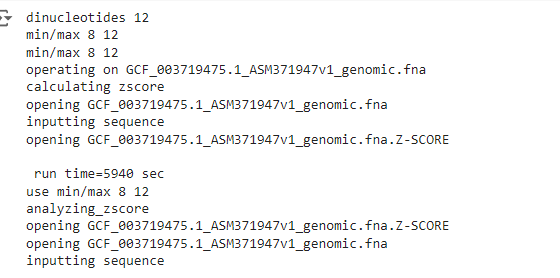

In [19]:
!head GCF_003719475.1_ASM371947v1_genomic.fna.Z-SCORE

GCF_003719475.1_ASM371947v1_genomic.fna 21188635 8 12
1 23 22  36.462  14.635 6.157318e-03 ntanaangtanacnnntacntg   ASASASASASASASASASASAS
2 20 18  31.957  27.299 1.985735e-01 tanaangtanacnnntac   ASASSASASASAASSASA
3 27 24  34.218  11.499 4.666219e-02 anaangtanacnnntacntggntg   ASASASASASASASASASASASAS
4 20 16  31.639  27.267 2.327510e-01 naangtanacnnntac   ASSASASASAASSASA
5 27 22  33.423  14.071 8.291502e-02 aangtanacnnntacntggntg   ASASASASASASASASASASAS
6 22 16  31.593  27.183 2.379268e-01 angtanacnnntacnt   SASASASAASSASAAS
7 27 20  32.784  18.524 1.249104e-01 ngtanacnnntacntggntg   ASASASASASASASASASAS
8 24 16  31.493  25.544 2.494612e-01 gtanacnnntacntgg   SASASAASSASAASAS
9 27 18  32.257  23.161 1.692507e-01 tanacnnntacntggntg   ASASASASASASASASAS


In [20]:
from google.colab import files
files.download( "GCF_003719475.1_ASM371947v1_genomic.fna.Z-SCORE" )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>